In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

import logging
import warnings
from functools import partial

In [9]:
def simulate_gandk(theta, num_samples, c = 0.8):
    zu = np.random.randn(num_samples,1)
    f = (theta[0] + theta[1] * (1 + c * (1 - np.exp(-theta[2] * zu)) / (1 + np.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

def compute_summary_statistics(y):
    quant_y = []
    for i in np.arange(0.125, 1, 0.125):
        quant_y.append(np.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return np.array([Sa, Sb, Sc, Sd])

In [22]:
true_theta = np.array([3, 1, 2, 0.5])
sigma_theta = 10
sigma_latent = 1
num_coeffs = 4
num_latent = 4
num_datasets = 200
num_samples = 200

In [11]:
actual_data = simulate_gandk(true_theta, num_samples)
actual_data

array([[18.89492558],
       [ 2.87496003],
       [13.11410272],
       [ 2.98625887],
       [ 3.46303631],
       [ 2.90801849],
       [ 2.5605488 ],
       [ 2.63424416],
       [ 2.71486899],
       [ 4.42937876],
       [ 3.94253351],
       [ 2.58684448],
       [ 3.82749327],
       [ 3.31431482],
       [ 2.98873244],
       [ 3.03429921],
       [ 2.97875452],
       [ 3.56941882],
       [ 3.48087043],
       [ 3.08653065],
       [ 2.23623804],
       [ 1.86452112],
       [ 3.03103095],
       [ 3.58238178],
       [ 2.27716774],
       [ 2.76071083],
       [ 2.12137809],
       [ 2.50777782],
       [16.55645983],
       [ 2.15538526],
       [ 2.42969822],
       [ 2.78239291],
       [ 1.7443395 ],
       [ 3.43164135],
       [ 6.34838128],
       [ 2.84144555],
       [ 2.16690182],
       [10.84733887],
       [ 2.94339623],
       [ 3.7488597 ],
       [ 3.35210407],
       [ 2.12074471],
       [ 2.27352364],
       [ 2.80607312],
       [ 3.62186616],
       [ 2

In [12]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

array([2.96978227, 1.45609898, 0.4837584 , 2.00723605])

In [13]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [14]:
def summary_statistics(theta, num_samples, num_datasets):
    n_summary_statistics = np.zeros((num_datasets, num_latent))
    for i in range(0, num_datasets):
        y = simulate_gandk(theta, num_samples)
        n_summary_statistics[i,:] = compute_summary_statistics(y)

    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

In [15]:
def mean_adjustment_summary_statistics(adjusted_theta, num_samples, num_datasets):
    theta = adjusted_theta[:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, num_samples, num_datasets)
    adjusted_sample_mean = sample_mean + np.diag(scipy.linalg.sqrtm(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [16]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

def prior_gamma(gamma, sigma_latent, num_latent): 
    log_prior = multivariate_normal.logpdf(gamma, cov= sigma_latent * np.identity(num_latent))
    return log_prior

def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, num_samples, num_datasets, actual_summary_statistics):
    mean_adj_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, num_samples, num_datasets)
    adjusted_sample_mean = mean_adj_ss[0]
    sample_variance = mean_adj_ss[1]

    mean_u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    # diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    # part1 = diff_mean_s.T @ my_inv(sample_variance) @ diff_mean_s
    # mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(sample_variance)[1] - 1/2 * part1
    return mean_u_est_log_likelihood

def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    part1 = (Gamma - mean_nuissance).T @ my_inv(variance_nuissance) @ (Gamma - mean_nuissance)
    nuissance_mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(variance_nuissance)[1] - part1
    # nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [24]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= my_inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([true_theta[0], np.log(true_theta[1]), true_theta[2], np.log(true_theta[3])])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        l_0 = np.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                        [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                        [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                        [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    # alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    # beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    # gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))

                    alpha_0 = theta_tilde_0[0]
                    # beta_q = (0.05 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    beta_0 = np.exp(theta_tilde_0[1])
                    # gamma_q = (np.exp(theta_tilde_q[2]) - 1) / (1 + np.exp(theta_tilde_q[2]))
                    gamma_0 = theta_tilde_0[2]
                    # delta_q = (0.5 * np.exp(theta_tilde_q[3]) + 0.2) / (1 + np.exp(theta_tilde_q[3]))                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    delta_0 = np.exp(theta_tilde_0[3])

                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])
                    
                    ss_0 = summary_statistics(theta_0, num_samples, num_datasets)
                    sample_mean_0 = ss_0[0]
                    sample_variance_0 = ss_0[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance_0)))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance_0) @ diag_var)
                    diff_mean = actual_summary_statistics - sample_mean_0
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_0) @ diff_mean
                    mean_nuissance_0 = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_0 = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_0, cov = variance_nuissance_0)
                    # Gamma = Gamma[0]
                    adjusted_theta_0 = np.concatenate((theta_0, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_0, num_samples, num_datasets, actual_summary_statistics)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_0, variance_nuissance_0)

                    h_lambda_init = prior(theta_tilde_0) + prior_gamma(Gamma, sigma_latent, num_latent) + llh - self.fun_log_q(theta_tilde_0, mu_0, l_0) - llh_gamma

                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = theta_tilde_q[0]
                    # beta_q = (0.05 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    beta_q = np.exp(theta_tilde_q[1])
                    # gamma_q = (np.exp(theta_tilde_q[2]) - 1) / (1 + np.exp(theta_tilde_q[2]))
                    gamma_q = theta_tilde_q[2]
                    # delta_q = (0.5 * np.exp(theta_tilde_q[3]) + 0.2) / (1 + np.exp(theta_tilde_q[3]))                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    delta_q = np.exp(theta_tilde_q[3])

                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    
                    ss_q = summary_statistics(theta_q, num_samples, num_datasets)
                    sample_mean_q = ss_q[0]
                    sample_variance_q = ss_q[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance_q)))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance_q) @ diag_var)
                    diff_mean = actual_summary_statistics - sample_mean_q
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_q) @ diff_mean
                    mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_q = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_q, cov = variance_nuissance_q)
                    # Gamma = Gamma[0]
                    adjusted_theta_q = np.concatenate((theta_q, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, num_samples, num_datasets, actual_summary_statistics)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)


                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + prior_gamma(Gamma, sigma_latent, num_latent) + llh - self.fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [25]:
# Set hyperparameters
stop = 5000
vb = GVB(400, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 100, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [02:18<192:03:52, 138.31s/it]

LB 120.33137792370499


  0%|          | 2/5000 [05:16<224:16:09, 161.54s/it]

LB 98.27241152141734


  0%|          | 3/5000 [08:57<261:51:40, 188.65s/it]

LB 99.80058590613785


  0%|          | 4/5000 [12:23<271:48:39, 195.86s/it]

LB 100.9654443163365


  0%|          | 5/5000 [15:50<277:03:17, 199.68s/it]

LB 100.72791640747391


  0%|          | 6/5000 [19:12<278:18:13, 200.62s/it]

LB 100.81233431642657


  0%|          | 7/5000 [21:57<261:47:41, 188.76s/it]

LB 101.085262584698


  0%|          | 8/5000 [24:25<243:43:28, 175.76s/it]

LB 100.40579274086981


  0%|          | 9/5000 [27:19<243:14:41, 175.45s/it]

LB 99.55284546753856


  0%|          | 10/5000 [29:47<231:16:02, 166.85s/it]

LB 100.43064011279155


  0%|          | 11/5000 [32:15<223:06:26, 160.99s/it]

LB 99.82525642000296


  0%|          | 12/5000 [34:43<217:33:13, 157.02s/it]

LB 100.6860734295451


  0%|          | 13/5000 [37:11<213:58:03, 154.46s/it]

LB 98.63520338786755


  0%|          | 14/5000 [39:36<210:03:50, 151.67s/it]

LB 98.92436861472292


  0%|          | 15/5000 [42:06<209:18:51, 151.16s/it]

LB 98.7847399186903


  0%|          | 16/5000 [44:36<208:39:13, 150.71s/it]

LB 98.91180315885867


  0%|          | 17/5000 [47:06<208:07:45, 150.36s/it]

LB 100.77810203113987


  0%|          | 18/5000 [49:37<208:27:54, 150.64s/it]

LB 99.99482397355722


  0%|          | 19/5000 [52:11<209:57:55, 151.75s/it]

LB 101.23135331387599


  0%|          | 20/5000 [54:48<211:51:50, 153.15s/it]

LB 100.48124336892164


  0%|          | 21/5000 [57:24<213:10:52, 154.14s/it]

LB 99.98820363008926


  0%|          | 22/5000 [59:57<212:41:35, 153.82s/it]

LB 99.81252526219643


  0%|          | 23/5000 [1:02:31<212:34:42, 153.76s/it]

LB 99.85721521167241


  0%|          | 24/5000 [1:05:05<212:50:01, 153.98s/it]

LB 99.84279128216244


  0%|          | 25/5000 [1:07:39<212:42:28, 153.92s/it]

LB 99.26887431700216


  1%|          | 26/5000 [1:10:28<218:51:28, 158.40s/it]

LB 99.04733233619862


  1%|          | 27/5000 [1:13:21<224:46:44, 162.72s/it]

LB 99.95654259897412


  1%|          | 28/5000 [1:16:14<229:01:13, 165.82s/it]

LB 99.65608862211943


  1%|          | 29/5000 [1:18:46<223:18:31, 161.72s/it]

LB 100.56831549303392


  1%|          | 30/5000 [1:21:18<219:06:11, 158.71s/it]

LB 97.5227263238046


  1%|          | 31/5000 [1:23:49<216:03:05, 156.53s/it]

LB 98.13738364228116


  1%|          | 32/5000 [1:26:24<215:30:09, 156.16s/it]

LB 97.9705283105389


  1%|          | 33/5000 [1:28:58<214:17:27, 155.31s/it]

LB 96.57468851979574


  1%|          | 34/5000 [1:31:28<212:19:22, 153.92s/it]

LB 98.94790965699816


  1%|          | 35/5000 [1:34:00<211:19:50, 153.23s/it]

LB 98.20113844951088


  1%|          | 36/5000 [1:36:35<212:03:56, 153.79s/it]

LB 99.13680315609454


  1%|          | 37/5000 [1:39:03<209:36:25, 152.04s/it]

LB 98.22061823432976


  1%|          | 38/5000 [1:41:30<207:26:03, 150.50s/it]

LB 98.10747771822409


  1%|          | 39/5000 [1:43:58<206:32:21, 149.88s/it]

LB 97.42609224096407


  1%|          | 40/5000 [1:46:27<205:48:44, 149.38s/it]

LB 98.39529810140303


  1%|          | 41/5000 [1:48:56<205:52:58, 149.46s/it]

LB 97.86810569870543


  1%|          | 42/5000 [1:51:25<205:22:31, 149.12s/it]

LB 97.40078348781864


  1%|          | 43/5000 [1:53:54<205:23:03, 149.16s/it]

LB 97.95094775766242


  1%|          | 44/5000 [1:56:23<205:15:59, 149.10s/it]

LB 100.3020620658589


  1%|          | 45/5000 [1:58:53<205:41:51, 149.45s/it]

LB 98.29628440292754


  1%|          | 46/5000 [2:01:21<205:15:22, 149.16s/it]

LB 97.67371546979577


  1%|          | 47/5000 [2:03:50<204:49:41, 148.88s/it]

LB 98.80924652371691


  1%|          | 48/5000 [2:06:19<204:46:08, 148.86s/it]

LB 96.72076675436982


  1%|          | 49/5000 [2:08:47<204:32:04, 148.72s/it]

LB 95.72694203317559


  1%|          | 50/5000 [2:11:14<203:59:42, 148.36s/it]

LB 98.2571717625998


  1%|          | 51/5000 [2:13:43<203:55:58, 148.34s/it]

LB 97.15067195324177


  1%|          | 52/5000 [2:16:10<203:34:14, 148.11s/it]

LB 97.35768283640839


  1%|          | 53/5000 [2:18:38<203:27:57, 148.07s/it]

LB 99.48791805970451


  1%|          | 54/5000 [2:21:04<202:35:30, 147.46s/it]

LB 97.04451869417893


  1%|          | 55/5000 [2:23:31<202:21:21, 147.32s/it]

LB 98.40592739481046


  1%|          | 56/5000 [2:26:00<202:46:11, 147.65s/it]

LB 96.92298822142104


  1%|          | 57/5000 [2:28:28<202:49:01, 147.71s/it]

LB 98.88883725068744


  1%|          | 58/5000 [2:30:54<202:08:12, 147.25s/it]

LB 98.29935449362767


  1%|          | 59/5000 [2:33:21<202:09:23, 147.29s/it]

LB 96.69270601111475


  1%|          | 60/5000 [2:35:47<201:37:52, 146.94s/it]

LB 100.66674543414216


  1%|          | 61/5000 [2:38:18<203:20:02, 148.21s/it]

LB 98.39263730323314


  1%|          | 62/5000 [2:40:44<202:12:47, 147.42s/it]

LB 96.89904416051515


  1%|▏         | 63/5000 [2:43:10<201:45:48, 147.12s/it]

LB 96.28433158481864


  1%|▏         | 64/5000 [2:45:36<201:13:06, 146.76s/it]

LB 96.48367298335047


  1%|▏         | 65/5000 [2:48:04<201:20:23, 146.87s/it]

LB 96.25110489979896


  1%|▏         | 66/5000 [2:50:30<200:59:07, 146.65s/it]

LB 98.52862047957788


  1%|▏         | 67/5000 [2:52:56<200:50:08, 146.57s/it]

LB 101.72013384989357


  1%|▏         | 68/5000 [2:55:23<200:51:23, 146.61s/it]

LB 96.21139567455434


  1%|▏         | 69/5000 [2:57:50<201:04:36, 146.80s/it]

LB 101.1341647879261


  1%|▏         | 70/5000 [3:00:17<201:09:26, 146.89s/it]

LB 98.84412800207986


  1%|▏         | 71/5000 [3:02:43<200:47:55, 146.66s/it]

LB 97.54451339966569


  1%|▏         | 72/5000 [3:05:11<201:10:31, 146.96s/it]

LB 98.17071009167579


  1%|▏         | 73/5000 [3:07:38<201:08:39, 146.97s/it]

LB 99.12242881087161


  1%|▏         | 74/5000 [3:10:05<201:06:07, 146.97s/it]

LB 98.52390499498757


  2%|▏         | 75/5000 [3:12:31<200:51:33, 146.82s/it]

LB 97.80123975362442


  2%|▏         | 76/5000 [3:14:58<200:36:33, 146.67s/it]

LB 100.0039895558665


  2%|▏         | 77/5000 [3:17:24<200:27:16, 146.58s/it]

LB 99.5288500409896


  2%|▏         | 78/5000 [3:19:51<200:35:38, 146.72s/it]

LB 100.80796193753442


  2%|▏         | 79/5000 [3:22:18<200:33:52, 146.72s/it]

LB 101.27250164472508


  2%|▏         | 80/5000 [3:24:46<200:58:35, 147.06s/it]

LB 101.55951277435099


  2%|▏         | 81/5000 [3:27:13<201:08:53, 147.21s/it]

LB 100.6851762496345


  2%|▏         | 82/5000 [3:29:47<203:46:34, 149.17s/it]

LB 100.18237657526599


  2%|▏         | 83/5000 [3:32:42<214:21:56, 156.95s/it]

LB 99.29964031811753


  2%|▏         | 84/5000 [3:35:14<212:18:35, 155.48s/it]

LB 100.58713924449465


  2%|▏         | 85/5000 [3:38:16<223:08:46, 163.44s/it]

LB 102.59484799206167


  2%|▏         | 86/5000 [3:41:19<231:00:37, 169.24s/it]

LB 104.77582089510291


  2%|▏         | 87/5000 [3:43:48<222:55:46, 163.35s/it]

LB 104.583198299624


  2%|▏         | 88/5000 [3:46:14<215:42:38, 158.09s/it]

LB 101.86978419490333


  2%|▏         | 89/5000 [3:48:40<210:45:35, 154.50s/it]

LB 102.75526321089636


  2%|▏         | 90/5000 [3:51:07<207:21:23, 152.03s/it]

LB 103.767662535657


  2%|▏         | 91/5000 [3:53:33<204:51:45, 150.24s/it]

LB 102.85063679933587


  2%|▏         | 92/5000 [3:55:59<203:09:45, 149.02s/it]

LB 102.73682354211107


  2%|▏         | 93/5000 [3:58:25<201:52:59, 148.11s/it]

LB 103.36625183583506


  2%|▏         | 94/5000 [4:00:51<201:04:48, 147.55s/it]

LB 105.28858078146304


  2%|▏         | 95/5000 [4:03:17<200:13:28, 146.95s/it]

LB 104.24986767896364


  2%|▏         | 96/5000 [4:05:44<200:08:42, 146.93s/it]

LB 107.01243376441985


  2%|▏         | 97/5000 [4:08:11<200:10:44, 146.98s/it]

LB 107.38488434636882


  2%|▏         | 98/5000 [4:10:37<200:04:30, 146.93s/it]

LB 104.13534460991472


  2%|▏         | 99/5000 [4:13:03<199:37:33, 146.63s/it]

LB 105.58052370568166


  2%|▏         | 100/5000 [4:15:30<199:32:39, 146.60s/it]

LB 106.48134097940583


  2%|▏         | 101/5000 [4:17:56<199:16:57, 146.44s/it]

LB Smoothed 99.81960176458112


  2%|▏         | 102/5000 [4:20:22<199:01:33, 146.28s/it]

LB Smoothed 99.9218502059393


  2%|▏         | 103/5000 [4:22:47<198:39:21, 146.04s/it]

LB Smoothed 99.9927795286128


  2%|▏         | 104/5000 [4:25:14<198:43:16, 146.12s/it]

LB Smoothed 100.07892426183753


  2%|▏         | 105/5000 [4:27:39<198:29:36, 145.98s/it]

LB Smoothed 100.18849236015289


  2%|▏         | 106/5000 [4:30:06<198:43:45, 146.18s/it]

LB Smoothed 100.27494537376522


  2%|▏         | 107/5000 [4:32:32<198:41:04, 146.18s/it]

LB Smoothed 100.32185592181109


  2%|▏         | 108/5000 [4:34:58<198:37:07, 146.16s/it]

LB Smoothed 100.43723357961674


  2%|▏         | 109/5000 [4:37:25<198:51:31, 146.37s/it]

LB Smoothed 100.56012213567085


  2%|▏         | 110/5000 [4:39:52<198:55:38, 146.45s/it]

LB Smoothed 100.6601503831349


  2%|▏         | 111/5000 [4:42:18<198:54:53, 146.47s/it]

LB Smoothed 100.73061669471168


  2%|▏         | 112/5000 [4:44:45<198:59:59, 146.56s/it]

LB Smoothed 100.84440775302762


  2%|▏         | 113/5000 [4:47:13<199:25:53, 146.91s/it]

LB Smoothed 100.9784750096646


  2%|▏         | 114/5000 [4:49:39<199:17:39, 146.84s/it]

LB Smoothed 101.16848321322603


  2%|▏         | 115/5000 [4:52:07<199:25:02, 146.96s/it]

LB Smoothed 101.31195679727395


  2%|▏         | 116/5000 [4:54:34<199:23:06, 146.97s/it]

LB Smoothed 101.45724197698898


  2%|▏         | 117/5000 [4:57:01<199:21:43, 146.98s/it]

LB Smoothed 101.64322222431592


  2%|▏         | 118/5000 [4:59:28<199:29:48, 147.11s/it]

LB Smoothed 101.77238884997219


  2%|▏         | 119/5000 [5:01:55<199:16:12, 146.97s/it]

LB Smoothed 101.8854081903054


  2%|▏         | 120/5000 [5:04:21<198:57:43, 146.78s/it]

LB Smoothed 102.0171387611052


  2%|▏         | 121/5000 [5:06:47<198:42:00, 146.61s/it]

LB Smoothed 102.19259461310388


  2%|▏         | 122/5000 [5:09:14<198:31:13, 146.51s/it]

LB Smoothed 102.36582875529128


  2%|▏         | 123/5000 [5:11:41<198:46:56, 146.73s/it]

LB Smoothed 102.55381324525207


  2%|▏         | 124/5000 [5:14:09<199:14:49, 147.11s/it]

LB Smoothed 102.75440981577123


  2%|▎         | 125/5000 [5:16:35<198:59:02, 146.94s/it]

LB Smoothed 103.00921371692391


  3%|▎         | 126/5000 [5:19:01<198:26:59, 146.58s/it]

LB Smoothed 103.22896710439235


  3%|▎         | 127/5000 [5:21:28<198:22:46, 146.56s/it]

LB Smoothed 103.46574259978073


  3%|▎         | 128/5000 [5:23:56<198:58:59, 147.03s/it]

LB Smoothed 103.68536725285871


  3%|▎         | 129/5000 [5:26:23<199:02:57, 147.11s/it]

LB Smoothed 103.9516199219215


  3%|▎         | 130/5000 [5:28:50<199:03:27, 147.15s/it]

LB Smoothed 104.24248085722836


  3%|▎         | 131/5000 [5:31:16<198:37:36, 146.86s/it]

LB Smoothed 104.52272951555204


  3%|▎         | 132/5000 [5:33:45<199:19:57, 147.41s/it]

LB Smoothed 104.7728156356482


  3%|▎         | 133/5000 [5:36:14<199:44:43, 147.75s/it]

LB Smoothed 105.07216044048945


  3%|▎         | 134/5000 [5:38:42<199:45:53, 147.79s/it]

LB Smoothed 105.37871082532808


  3%|▎         | 135/5000 [5:41:09<199:38:22, 147.73s/it]

LB Smoothed 105.67184343794906


  3%|▎         | 136/5000 [5:43:36<199:18:35, 147.52s/it]

LB Smoothed 105.9771247802565


  3%|▎         | 137/5000 [5:46:03<199:01:07, 147.33s/it]

LB Smoothed 106.30644809608894


  3%|▎         | 138/5000 [5:48:32<199:28:51, 147.70s/it]

LB Smoothed 106.63750485203227


  3%|▎         | 139/5000 [5:50:58<199:02:34, 147.41s/it]

LB Smoothed 106.9939799727005


  3%|▎         | 140/5000 [5:53:24<198:12:32, 146.82s/it]

LB Smoothed 107.35091407493537


  3%|▎         | 141/5000 [5:55:50<197:55:03, 146.64s/it]

LB Smoothed 107.72437507093208


  3%|▎         | 142/5000 [5:58:16<197:46:14, 146.56s/it]

LB Smoothed 108.09924550248607


  3%|▎         | 143/5000 [6:01:02<205:19:20, 152.18s/it]

LB Smoothed 108.48232262767362


  3%|▎         | 144/5000 [6:04:20<223:59:41, 166.06s/it]

LB Smoothed 108.88651423978227


  3%|▎         | 145/5000 [6:07:42<238:33:21, 176.89s/it]

LB Smoothed 109.26766481180952


  3%|▎         | 146/5000 [6:11:00<246:49:21, 183.06s/it]

LB Smoothed 109.66293292002774


  3%|▎         | 147/5000 [6:14:18<252:45:23, 187.50s/it]

LB Smoothed 110.1039532362965


  3%|▎         | 148/5000 [6:17:38<257:49:26, 191.30s/it]

LB Smoothed 110.4964583329398


  3%|▎         | 149/5000 [6:21:01<262:30:12, 194.81s/it]

LB Smoothed 110.93419990815833


  3%|▎         | 150/5000 [6:24:23<265:19:55, 196.95s/it]

LB Smoothed 111.40808912763995


  3%|▎         | 151/5000 [6:27:43<266:45:29, 198.05s/it]

LB Smoothed 111.86951227595385


  3%|▎         | 152/5000 [6:31:09<269:36:42, 200.21s/it]

LB Smoothed 112.35795879729811


  3%|▎         | 153/5000 [6:34:31<270:21:41, 200.81s/it]

LB Smoothed 112.82339236943355


  3%|▎         | 154/5000 [6:37:51<270:06:02, 200.65s/it]

LB Smoothed 113.31936051753524


  3%|▎         | 155/5000 [6:40:58<264:39:14, 196.65s/it]

LB Smoothed 113.80794702895986


  3%|▎         | 156/5000 [6:43:29<245:58:16, 182.80s/it]

LB Smoothed 114.3302121831697


  3%|▎         | 157/5000 [6:46:00<233:18:37, 173.43s/it]

LB Smoothed 114.84093536517844


  3%|▎         | 158/5000 [6:48:35<225:31:20, 167.67s/it]

LB Smoothed 115.36533733268432


  3%|▎         | 159/5000 [6:51:10<220:38:35, 164.08s/it]

LB Smoothed 115.9344350621505


  3%|▎         | 160/5000 [6:53:41<215:06:53, 160.00s/it]

LB Smoothed 116.46622862332067


  3%|▎         | 161/5000 [6:56:13<211:58:29, 157.70s/it]

LB Smoothed 116.99469233121631


  3%|▎         | 162/5000 [6:58:45<209:25:43, 155.84s/it]

LB Smoothed 117.63774603193433


  3%|▎         | 163/5000 [7:01:13<206:25:53, 153.64s/it]

LB Smoothed 118.24548420810079


  3%|▎         | 164/5000 [7:03:43<204:51:13, 152.50s/it]

LB Smoothed 118.88941517340295


  3%|▎         | 165/5000 [7:06:14<204:02:39, 151.93s/it]

LB Smoothed 119.55835606310451


  3%|▎         | 166/5000 [7:08:43<202:54:56, 151.12s/it]

LB Smoothed 120.21177083572634


  3%|▎         | 167/5000 [7:11:13<202:38:48, 150.95s/it]

LB Smoothed 120.75171098661836


  3%|▎         | 168/5000 [7:13:43<202:12:58, 150.66s/it]

LB Smoothed 121.40053593110703


  3%|▎         | 169/5000 [7:16:13<201:36:41, 150.24s/it]

LB Smoothed 122.05794981948446


  3%|▎         | 170/5000 [7:18:47<203:02:51, 151.34s/it]

LB Smoothed 122.76410896837002


  3%|▎         | 171/5000 [7:21:15<201:51:27, 150.48s/it]

LB Smoothed 123.49429555496184


  3%|▎         | 172/5000 [7:23:44<201:23:34, 150.17s/it]

LB Smoothed 124.20615441334299


  3%|▎         | 173/5000 [7:26:16<201:48:23, 150.51s/it]

LB Smoothed 124.91386528507002


  3%|▎         | 174/5000 [7:28:47<201:55:37, 150.63s/it]

LB Smoothed 125.64817658871169


  4%|▎         | 175/5000 [7:31:17<201:49:42, 150.59s/it]

LB Smoothed 126.40505671111798


  4%|▎         | 176/5000 [7:33:48<201:43:10, 150.54s/it]

LB Smoothed 127.13678622501907


  4%|▎         | 177/5000 [7:36:19<201:58:27, 150.76s/it]

LB Smoothed 127.86821675259394


  4%|▎         | 178/5000 [7:38:50<201:52:53, 150.72s/it]

LB Smoothed 128.65141247785607


  4%|▎         | 179/5000 [7:41:19<201:31:43, 150.49s/it]

LB Smoothed 129.45735261339914


  4%|▎         | 180/5000 [7:43:51<201:47:43, 150.72s/it]

LB Smoothed 130.29743625225962


  4%|▎         | 181/5000 [7:46:20<201:21:21, 150.42s/it]

LB Smoothed 131.11956318186893


  4%|▎         | 182/5000 [7:48:54<202:40:39, 151.44s/it]

LB Smoothed 131.9823915129636


  4%|▎         | 183/5000 [7:51:24<202:04:36, 151.02s/it]

LB Smoothed 132.82088900773874


  4%|▎         | 184/5000 [7:54:00<203:52:53, 152.40s/it]

LB Smoothed 133.6640639793892


  4%|▎         | 185/5000 [7:56:31<203:20:07, 152.03s/it]

LB Smoothed 134.53496360712586


  4%|▎         | 186/5000 [7:59:03<203:25:21, 152.12s/it]

LB Smoothed 135.40603075075649


  4%|▎         | 187/5000 [8:01:34<202:52:25, 151.74s/it]

LB Smoothed 136.25251469211184


  4%|▍         | 188/5000 [8:04:06<202:43:32, 151.67s/it]

LB Smoothed 137.2106504333254


  4%|▍         | 189/5000 [8:06:36<202:01:49, 151.18s/it]

LB Smoothed 138.2080511143747


  4%|▍         | 190/5000 [8:09:08<202:19:50, 151.43s/it]

LB Smoothed 139.2293525002618


  4%|▍         | 191/5000 [8:11:39<202:19:43, 151.46s/it]

LB Smoothed 140.26440809444495


  4%|▍         | 192/5000 [8:14:12<202:45:46, 151.82s/it]

LB Smoothed 141.32415843939293


  4%|▍         | 193/5000 [8:16:43<202:27:11, 151.62s/it]

LB Smoothed 142.34593106099467


  4%|▍         | 194/5000 [8:19:15<202:41:10, 151.82s/it]

LB Smoothed 143.4470729512294


  4%|▍         | 195/5000 [8:21:48<202:54:25, 152.02s/it]

LB Smoothed 144.53218540073834


  4%|▍         | 196/5000 [8:24:20<202:53:04, 152.04s/it]

LB Smoothed 145.55985820437638


  4%|▍         | 197/5000 [8:26:52<202:57:06, 152.12s/it]

LB Smoothed 146.53799423726457


  4%|▍         | 198/5000 [8:29:23<202:29:45, 151.81s/it]

LB Smoothed 147.70786046976247


  4%|▍         | 199/5000 [8:31:54<201:56:23, 151.42s/it]

LB Smoothed 148.85644421231757


  4%|▍         | 200/5000 [8:34:23<201:07:25, 150.84s/it]

LB Smoothed 150.03215890373772


  4%|▍         | 201/5000 [8:36:52<200:10:12, 150.16s/it]

LB Smoothed 151.23159570165768


  4%|▍         | 202/5000 [8:39:20<199:22:05, 149.59s/it]

LB Smoothed 152.41957938614686


  4%|▍         | 203/5000 [8:41:49<198:55:24, 149.29s/it]

LB Smoothed 153.7089476478594


  4%|▍         | 204/5000 [8:44:20<199:41:17, 149.89s/it]

LB Smoothed 154.89475283125932


  4%|▍         | 205/5000 [8:46:50<199:33:32, 149.83s/it]

LB Smoothed 156.12143245099432


  4%|▍         | 206/5000 [8:49:21<199:56:44, 150.15s/it]

LB Smoothed 157.3607553999197


  4%|▍         | 207/5000 [8:51:51<199:57:36, 150.19s/it]

LB Smoothed 158.64552206401066


  4%|▍         | 208/5000 [8:54:23<200:32:27, 150.66s/it]

LB Smoothed 160.01756490810422


  4%|▍         | 209/5000 [8:56:54<200:39:37, 150.78s/it]

LB Smoothed 161.3125792821656


  4%|▍         | 210/5000 [8:59:23<200:07:35, 150.41s/it]

LB Smoothed 162.71874693793663


  4%|▍         | 211/5000 [9:01:54<200:19:15, 150.59s/it]

LB Smoothed 164.11215088826899


  4%|▍         | 212/5000 [9:04:25<200:24:57, 150.69s/it]

LB Smoothed 165.48647741769577


  4%|▍         | 213/5000 [9:06:56<200:33:46, 150.83s/it]

LB Smoothed 166.8074302179222


  4%|▍         | 214/5000 [9:09:25<199:42:41, 150.22s/it]

LB Smoothed 168.23102255955976


  4%|▍         | 215/5000 [9:12:06<204:03:03, 153.52s/it]

LB Smoothed 169.73265629332812


  4%|▍         | 216/5000 [9:14:52<208:57:54, 157.25s/it]

LB Smoothed 171.21125977718535


  4%|▍         | 217/5000 [9:17:39<212:37:07, 160.03s/it]

LB Smoothed 172.72259108855903


  4%|▍         | 218/5000 [9:20:23<214:20:50, 161.37s/it]

LB Smoothed 174.36813004037398


  4%|▍         | 219/5000 [9:23:10<216:21:34, 162.91s/it]

LB Smoothed 175.98953009650901


  4%|▍         | 220/5000 [9:25:51<215:46:38, 162.51s/it]

LB Smoothed 177.69703459495628


  4%|▍         | 221/5000 [9:26:46<172:46:54, 130.16s/it]

LB Smoothed 179.27962193968173


  4%|▍         | 222/5000 [9:27:40<142:13:36, 107.16s/it]

LB Smoothed 180.93017147194024


  4%|▍         | 223/5000 [9:28:32<120:17:29, 90.65s/it] 

LB Smoothed 182.53213337556426


  4%|▍         | 224/5000 [9:29:22<104:06:22, 78.47s/it]

LB Smoothed 184.1576186870011


  4%|▍         | 225/5000 [9:30:14<93:36:10, 70.57s/it] 

LB Smoothed 185.74959671562925


  5%|▍         | 226/5000 [9:31:06<86:18:16, 65.08s/it]

LB Smoothed 187.43287853881864


  5%|▍         | 227/5000 [9:31:56<80:07:51, 60.44s/it]

LB Smoothed 189.21022437780647


  5%|▍         | 228/5000 [9:32:47<76:15:53, 57.53s/it]

LB Smoothed 190.9730779629697


  5%|▍         | 229/5000 [9:33:39<74:16:17, 56.04s/it]

LB Smoothed 192.7559802547744


  5%|▍         | 230/5000 [9:34:33<73:16:33, 55.30s/it]

LB Smoothed 194.60625391469097


  5%|▍         | 231/5000 [9:35:27<72:50:38, 54.99s/it]

LB Smoothed 196.43006215467844


  5%|▍         | 232/5000 [9:36:21<72:29:33, 54.73s/it]

LB Smoothed 198.28142739727673


  5%|▍         | 233/5000 [9:37:14<71:36:12, 54.07s/it]

LB Smoothed 200.18241075632258


  5%|▍         | 234/5000 [9:38:09<72:12:57, 54.55s/it]

LB Smoothed 201.95333266000875


  5%|▍         | 235/5000 [9:39:04<72:21:31, 54.67s/it]

LB Smoothed 203.80831536762784


  5%|▍         | 236/5000 [9:39:53<69:58:23, 52.88s/it]

LB Smoothed 205.82176411974922


  5%|▍         | 237/5000 [9:40:41<67:51:28, 51.29s/it]

LB Smoothed 207.8234551086296


  5%|▍         | 238/5000 [9:41:28<66:26:46, 50.23s/it]

LB Smoothed 209.8719347162144


  5%|▍         | 239/5000 [9:42:16<65:30:14, 49.53s/it]

LB Smoothed 211.9919752801814


  5%|▍         | 240/5000 [9:43:04<64:49:49, 49.03s/it]

LB Smoothed 213.90532287178826


  5%|▍         | 241/5000 [9:43:52<64:26:11, 48.74s/it]

LB Smoothed 215.98901183513362


  5%|▍         | 242/5000 [9:44:40<63:59:46, 48.42s/it]

LB Smoothed 217.99352538191886


  5%|▍         | 243/5000 [9:45:27<63:36:27, 48.14s/it]

LB Smoothed 220.11570956481287


  5%|▍         | 244/5000 [9:46:15<63:23:15, 47.98s/it]

LB Smoothed 222.47401527461938


  5%|▍         | 245/5000 [9:47:03<63:18:02, 47.92s/it]

LB Smoothed 224.69212275405403


  5%|▍         | 246/5000 [9:47:51<63:20:52, 47.97s/it]

LB Smoothed 226.88695975270755


  5%|▍         | 247/5000 [9:48:39<63:17:01, 47.93s/it]

LB Smoothed 229.1819793925979


  5%|▍         | 248/5000 [9:49:27<63:19:53, 47.98s/it]

LB Smoothed 231.44901537921206


  5%|▍         | 249/5000 [9:50:15<63:18:52, 47.98s/it]

LB Smoothed 233.8264665808769


  5%|▌         | 250/5000 [9:51:03<63:19:47, 48.00s/it]

LB Smoothed 236.04594185760956


  5%|▌         | 251/5000 [9:51:51<63:18:42, 47.99s/it]

LB Smoothed 238.43140000375317


  5%|▌         | 252/5000 [9:52:39<63:29:02, 48.13s/it]

LB Smoothed 240.8048181162175


  5%|▌         | 253/5000 [9:53:27<63:29:52, 48.16s/it]

LB Smoothed 243.1833828422898


  5%|▌         | 254/5000 [9:54:16<63:30:11, 48.17s/it]

LB Smoothed 245.56145676253408


  5%|▌         | 255/5000 [9:55:04<63:37:48, 48.28s/it]

LB Smoothed 248.10058857038803


  5%|▌         | 256/5000 [9:55:52<63:39:07, 48.30s/it]

LB Smoothed 250.56404468407442


  5%|▌         | 257/5000 [9:56:41<63:36:21, 48.28s/it]

LB Smoothed 253.1649613184774


  5%|▌         | 258/5000 [9:57:29<63:30:24, 48.21s/it]

LB Smoothed 255.814282318538


  5%|▌         | 259/5000 [9:58:17<63:28:46, 48.20s/it]

LB Smoothed 258.41371520080565


  5%|▌         | 260/5000 [9:59:05<63:32:02, 48.25s/it]

LB Smoothed 261.27458011527625


  5%|▌         | 261/5000 [9:59:54<63:36:23, 48.32s/it]

LB Smoothed 263.7050307378964


  5%|▌         | 262/5000 [10:00:42<63:33:04, 48.29s/it]

LB Smoothed 266.26720725206496


  5%|▌         | 263/5000 [10:01:30<63:24:34, 48.19s/it]

LB Smoothed 268.9650994704584


  5%|▌         | 264/5000 [10:02:18<63:28:51, 48.25s/it]

LB Smoothed 271.8472115835661


  5%|▌         | 265/5000 [10:03:07<63:34:31, 48.34s/it]

LB Smoothed 274.7669485718504


  5%|▌         | 266/5000 [10:03:55<63:29:08, 48.28s/it]

LB Smoothed 277.85244433813


  5%|▌         | 267/5000 [10:04:43<63:27:15, 48.26s/it]

LB Smoothed 280.96555397767287


  5%|▌         | 268/5000 [10:05:32<63:26:11, 48.26s/it]

LB Smoothed 283.8763178811347


  5%|▌         | 269/5000 [10:06:20<63:20:57, 48.20s/it]

LB Smoothed 286.92769370967864


  5%|▌         | 270/5000 [10:07:08<63:22:44, 48.24s/it]

LB Smoothed 290.04884703286785


  5%|▌         | 271/5000 [10:07:56<63:16:50, 48.17s/it]

LB Smoothed 293.2463739453478


  5%|▌         | 272/5000 [10:08:44<63:18:31, 48.20s/it]

LB Smoothed 296.4655754620608


  5%|▌         | 273/5000 [10:09:32<63:15:13, 48.17s/it]

LB Smoothed 299.6624519081589


  5%|▌         | 274/5000 [10:10:21<63:16:42, 48.20s/it]

LB Smoothed 302.8015673982644


  6%|▌         | 275/5000 [10:11:09<63:17:45, 48.23s/it]

LB Smoothed 306.09125530715687


  6%|▌         | 276/5000 [10:11:57<63:16:46, 48.22s/it]

LB Smoothed 309.53857857873675


  6%|▌         | 277/5000 [10:12:45<63:18:07, 48.25s/it]

LB Smoothed 312.91329245181595


  6%|▌         | 278/5000 [10:13:33<63:11:09, 48.17s/it]

LB Smoothed 316.14172102555847


  6%|▌         | 279/5000 [10:14:22<63:17:23, 48.26s/it]

LB Smoothed 319.28382973423635


  6%|▌         | 280/5000 [10:15:10<63:17:55, 48.28s/it]

LB Smoothed 322.69475144629774


  6%|▌         | 281/5000 [10:15:58<63:11:31, 48.21s/it]

LB Smoothed 326.03508907376914


  6%|▌         | 282/5000 [10:16:47<63:17:07, 48.29s/it]

LB Smoothed 329.6472796955189


  6%|▌         | 283/5000 [10:17:35<63:17:47, 48.31s/it]

LB Smoothed 333.18095197638536


  6%|▌         | 284/5000 [10:18:23<63:11:07, 48.23s/it]

LB Smoothed 336.8464693326088


  6%|▌         | 285/5000 [10:19:11<63:08:13, 48.21s/it]

LB Smoothed 340.33453445640197


  6%|▌         | 286/5000 [10:19:59<63:04:46, 48.17s/it]

LB Smoothed 343.9575351623709


  6%|▌         | 287/5000 [10:20:48<63:04:16, 48.18s/it]

LB Smoothed 347.6730938467763


  6%|▌         | 288/5000 [10:21:36<63:02:39, 48.17s/it]

LB Smoothed 351.33448486656584


  6%|▌         | 289/5000 [10:22:24<63:12:49, 48.31s/it]

LB Smoothed 355.2662426196121


  6%|▌         | 290/5000 [10:23:13<63:20:24, 48.41s/it]

LB Smoothed 359.1668473421342


  6%|▌         | 291/5000 [10:24:02<63:22:25, 48.45s/it]

LB Smoothed 363.2243875093712


  6%|▌         | 292/5000 [10:24:50<63:30:11, 48.56s/it]

LB Smoothed 367.58660998802594


  6%|▌         | 293/5000 [10:25:39<63:26:08, 48.52s/it]

LB Smoothed 371.7192046737957


  6%|▌         | 294/5000 [10:26:27<63:19:19, 48.44s/it]

LB Smoothed 376.0529345840813


  6%|▌         | 295/5000 [10:27:16<63:25:57, 48.54s/it]

LB Smoothed 380.1933628921255


  6%|▌         | 296/5000 [10:28:04<63:26:17, 48.55s/it]

LB Smoothed 384.6180119680896


  6%|▌         | 297/5000 [10:28:53<63:25:33, 48.55s/it]

LB Smoothed 388.7250414060418


  6%|▌         | 298/5000 [10:29:41<63:17:32, 48.46s/it]

LB Smoothed 393.6486265001541


  6%|▌         | 299/5000 [10:30:29<63:14:02, 48.42s/it]

LB Smoothed 397.69778463752846


  6%|▌         | 300/5000 [10:31:18<63:14:36, 48.44s/it]

LB Smoothed 402.1426703871606


  6%|▌         | 301/5000 [10:32:07<63:16:42, 48.48s/it]

LB Smoothed 406.56238448447175


  6%|▌         | 302/5000 [10:32:55<63:20:18, 48.54s/it]

LB Smoothed 411.09038191904534


  6%|▌         | 303/5000 [10:33:44<63:19:47, 48.54s/it]

LB Smoothed 415.73748594535823


  6%|▌         | 304/5000 [10:34:32<63:22:44, 48.59s/it]

LB Smoothed 420.3266082878415


  6%|▌         | 305/5000 [10:35:21<63:14:30, 48.49s/it]

LB Smoothed 425.3932473670745


  6%|▌         | 306/5000 [10:36:09<63:14:00, 48.50s/it]

LB Smoothed 430.1541042278862


  6%|▌         | 307/5000 [10:36:58<63:16:50, 48.54s/it]

LB Smoothed 434.9806917368234


  6%|▌         | 308/5000 [10:37:49<64:19:22, 49.35s/it]

LB Smoothed 440.19530500165297


  6%|▌         | 309/5000 [10:38:38<64:13:51, 49.29s/it]

LB Smoothed 445.5273470107011


  6%|▌         | 310/5000 [10:39:27<63:56:52, 49.09s/it]

LB Smoothed 450.5248713826584


  6%|▌         | 311/5000 [10:40:15<63:38:36, 48.86s/it]

LB Smoothed 456.03492553041195


  6%|▌         | 312/5000 [10:41:04<63:32:41, 48.80s/it]

LB Smoothed 461.2834609358372


  6%|▋         | 313/5000 [10:41:52<63:21:18, 48.66s/it]

LB Smoothed 466.40566072864505


  6%|▋         | 314/5000 [10:42:41<63:16:17, 48.61s/it]

LB Smoothed 471.5815890552132


  6%|▋         | 315/5000 [10:43:29<63:15:39, 48.61s/it]

LB Smoothed 477.11748251462967


  6%|▋         | 316/5000 [10:44:18<63:18:24, 48.66s/it]

LB Smoothed 482.31047574795275


  6%|▋         | 317/5000 [10:45:07<63:16:25, 48.64s/it]

LB Smoothed 487.49608084315526


  6%|▋         | 318/5000 [10:45:55<63:18:48, 48.68s/it]

LB Smoothed 493.35052574865495


  6%|▋         | 319/5000 [10:46:44<63:13:34, 48.63s/it]

LB Smoothed 499.2735657487533


  6%|▋         | 320/5000 [10:47:32<63:05:53, 48.54s/it]

LB Smoothed 504.7431393656819


  6%|▋         | 321/5000 [10:48:21<63:09:28, 48.59s/it]

LB Smoothed 510.7444544036128


  6%|▋         | 322/5000 [10:49:09<63:04:45, 48.54s/it]

LB Smoothed 516.370569885529


  6%|▋         | 323/5000 [10:50:00<63:46:52, 49.09s/it]

LB Smoothed 522.542239974732


  6%|▋         | 324/5000 [10:50:50<64:05:07, 49.34s/it]

LB Smoothed 528.5048649991876


  6%|▋         | 325/5000 [10:51:38<63:44:02, 49.08s/it]

LB Smoothed 534.4540859528722


  7%|▋         | 326/5000 [10:52:27<63:48:12, 49.14s/it]

LB Smoothed 540.2335543622564


  7%|▋         | 327/5000 [10:53:17<63:48:48, 49.16s/it]

LB Smoothed 546.6107135484287


  7%|▋         | 328/5000 [10:54:06<63:40:56, 49.07s/it]

LB Smoothed 552.7894195260607


  7%|▋         | 329/5000 [10:54:55<63:43:28, 49.11s/it]

LB Smoothed 558.9707596476765


  7%|▋         | 330/5000 [10:55:44<63:47:26, 49.17s/it]

LB Smoothed 565.1122237895314


  7%|▋         | 331/5000 [10:56:33<63:48:09, 49.19s/it]

LB Smoothed 571.6645454842642


  7%|▋         | 332/5000 [10:57:23<63:47:23, 49.20s/it]

LB Smoothed 578.4231595586265


  7%|▋         | 333/5000 [10:58:11<63:39:41, 49.11s/it]

LB Smoothed 585.3801242509002


  7%|▋         | 334/5000 [10:59:00<63:34:32, 49.05s/it]

LB Smoothed 592.0729043871446


  7%|▋         | 335/5000 [10:59:49<63:28:57, 48.99s/it]

LB Smoothed 598.8783681762367


  7%|▋         | 336/5000 [11:00:38<63:30:13, 49.02s/it]

LB Smoothed 606.117830304061


  7%|▋         | 337/5000 [11:01:27<63:19:54, 48.89s/it]

LB Smoothed 613.2585332665392


  7%|▋         | 338/5000 [11:02:16<63:20:13, 48.91s/it]

LB Smoothed 620.608743301914


  7%|▋         | 339/5000 [11:03:05<63:23:53, 48.97s/it]

LB Smoothed 627.7817522694363


  7%|▋         | 340/5000 [11:03:54<63:19:21, 48.92s/it]

LB Smoothed 635.4017768671447


  7%|▋         | 341/5000 [11:04:43<63:20:47, 48.95s/it]

LB Smoothed 643.3879648746527


  7%|▋         | 342/5000 [11:05:32<63:23:25, 48.99s/it]

LB Smoothed 651.2873130087378


  7%|▋         | 343/5000 [11:06:20<63:14:46, 48.89s/it]

LB Smoothed 658.8181951392701


  7%|▋         | 344/5000 [11:07:09<63:15:16, 48.91s/it]

LB Smoothed 666.2717857224201


  7%|▋         | 345/5000 [11:07:58<63:15:43, 48.92s/it]

LB Smoothed 674.1173344151326


  7%|▋         | 346/5000 [11:08:47<63:12:45, 48.90s/it]

LB Smoothed 681.6862840859436


  7%|▋         | 347/5000 [11:09:36<63:10:52, 48.88s/it]

LB Smoothed 689.8599021114952


  7%|▋         | 348/5000 [11:10:25<63:13:41, 48.93s/it]

LB Smoothed 697.5932548484164


  7%|▋         | 349/5000 [11:11:14<63:22:33, 49.05s/it]

LB Smoothed 706.2072928837442


  7%|▋         | 350/5000 [11:12:03<63:10:10, 48.91s/it]

LB Smoothed 714.2046751146422


  7%|▋         | 351/5000 [11:12:52<63:05:42, 48.86s/it]

LB Smoothed 722.4288100124566


  7%|▋         | 352/5000 [11:13:40<63:01:18, 48.81s/it]

LB Smoothed 730.9804642223828


  7%|▋         | 352/5000 [11:14:20<148:24:23, 114.94s/it]


LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

In [ ]:
best_lambda

array([array([ 0.63871002, -0.6884634 ,  0.62504716]),
       array([ 5.035121  , -4.05269621,  0.44321986, 23.32021622, -1.42538119,
              17.48830424])                                                   ],
      dtype=object)

<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

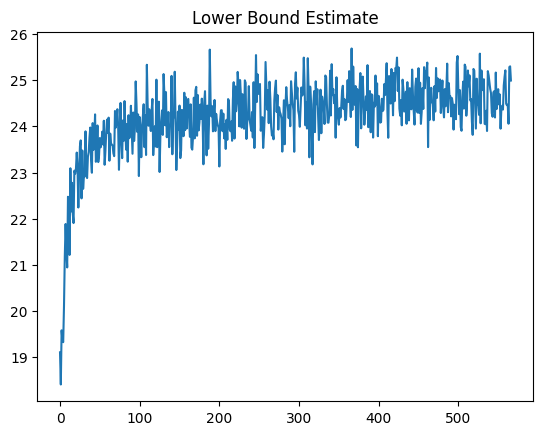

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

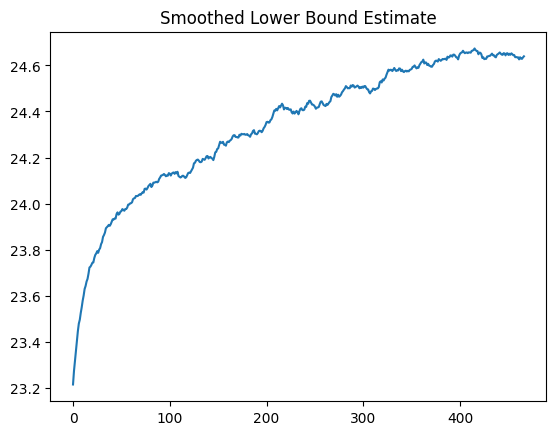

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [18]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)

best_alpha = best_theta_tilde[0]
best_beta = np.exp(best_theta_tilde[1])
best_gamma = best_theta_tilde[2]
best_delta = np.exp(best_theta_tilde[3])
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([2.54239828, 1.01058763, 1.50884163, 0.51628249])

Text(0.5, 1.0, 'Posterior density of alpha')

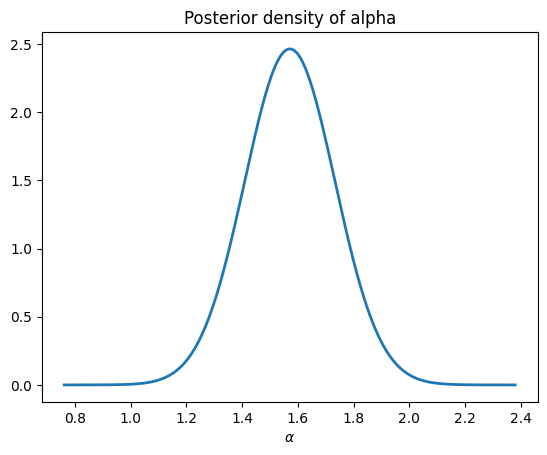

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

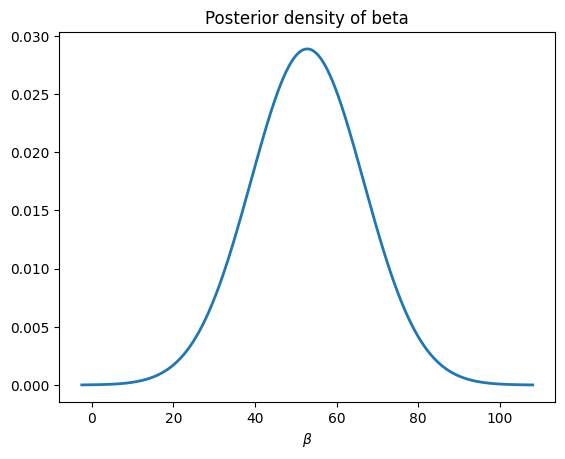

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

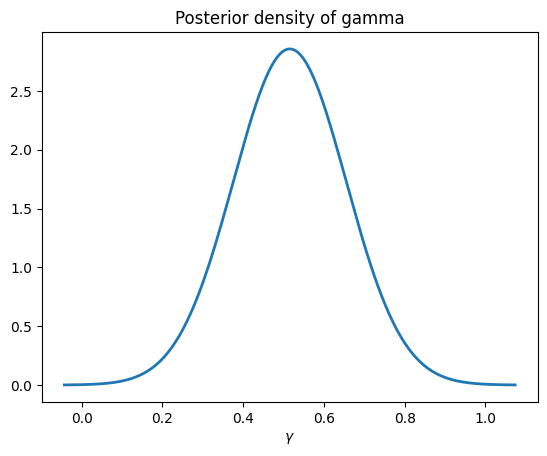

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [72]:
num_samples = 20000
num_burnin = int(0.2 * num_samples)

In [80]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((true_theta[0]-0)/(5-true_theta[0])), np.log((true_theta[1]-0)/(2-true_theta[1])), np.log((true_theta[2]-0)/(3-true_theta[2])), np.log((true_theta[3]-0)/(1-true_theta[3]))])

    alpha = (4 * np.exp(theta_tilde[0]) + 0) / (1 + np.exp(theta_tilde[0]))
    beta = (2 * np.exp(theta_tilde[1]) + 0) / (1 + np.exp(theta_tilde[1]))
    gamma = (1.5 * np.exp(theta_tilde[2]) + 0) / (1 + np.exp(theta_tilde[2]))
    delta = (1 * np.exp(theta_tilde[3]) + 0) / (1 + np.exp(theta_tilde[3]))

    theta = np.array([alpha, beta, gamma, delta])

    # GENERATE GAMMA
    ss = summary_statistics(theta, num_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]

    # Find mean and variance for p(gamma | theta, obs)

    diag_var = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance)))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

    # GENERATE GAMMA
    rng = np.random.default_rng()
    Gamma_init = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
    # Gamma = Gamma[0]
    adjusted_theta = np.concatenate((theta, Gamma_init))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, num_samples, num_datasets, actual_summary_statistics)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma_init, mean_nuissance, variance_nuissance)

    # --------------------- 

    prior_current = prior(theta_tilde)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
#             theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
            theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**4/theta_size) * best_Sigma))
        else:
            if i % 500 == 0:
                Sign = np.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = random.uniform(0, 1)
            if u_proposal < 0.05:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**4/theta_size) * best_Sigma))
            else:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((1.1**2.5/theta_size) * best_Sigma))

        alpha_prop = (4 * np.exp(theta_proposal_tilde[0]) + 0) / (1 + np.exp(theta_proposal_tilde[0]))
        beta_prop = (2 * np.exp(theta_proposal_tilde[1]) + 0) / (1 + np.exp(theta_proposal_tilde[1]))
        gamma_prop = (1.5 * np.exp(theta_proposal_tilde[2]) + 0) / (1 + np.exp(theta_proposal_tilde[2]))
        delta_prop = (1 * np.exp(theta_proposal_tilde[3]) + 0) / (1 + np.exp(theta_proposal_tilde[3]))

        theta_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

        # GENERATE GAMMA
        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]

        # Find mean and variance for p(gamma | theta, obs)

        diag_var = np.zeros((num_latent, num_latent))
        np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance)))
        mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # GENERATE GAMMA
        rng = np.random.default_rng()
        Gamma = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
        # Gamma = Gamma[0]
        adjusted_theta_proposal = np.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets, actual_summary_statistics)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # --------------------- 

        prior_proposal = prior(theta_proposal_tilde)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = random.uniform(0, 1)

        if u < mh_prob:
            # Update position 
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde	
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])
            print(i, naccept / (samples * 1.0) * 100, '% was accepted')

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [81]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

  0%|                                                                              | 2/19999 [00:01<2:49:17,  1.97it/s]

1 [2.3991864  0.99990312 1.00015754 0.49991847]
1 0.005 % was accepted


  0%|                                                                             | 15/19999 [00:05<1:53:38,  2.93it/s]

14 [2.39847235 0.99945805 1.00021072 0.49987307]
14 0.01 % was accepted


  0%|▏                                                                            | 50/19999 [00:17<2:22:02,  2.34it/s]

49 [2.39877885 0.99952841 0.99984834 0.49964592]
49 0.015 % was accepted


  0%|▎                                                                            | 85/19999 [00:30<2:28:46,  2.23it/s]

84 [2.39846171 0.9995581  0.99979978 0.49960931]
84 0.02 % was accepted


  3%|█▉                                                                          | 520/19999 [03:19<2:05:03,  2.60it/s]

519 [2.39839078 0.99928108 0.9997092  0.49960995]
519 0.025 % was accepted


  4%|███                                                                         | 812/19999 [05:06<2:04:18,  2.57it/s]

811 [2.39872471 0.99921051 0.99968036 0.49940281]
811 0.03 % was accepted


 10%|███████▋                                                                   | 2048/19999 [12:27<2:32:35,  1.96it/s]

2047 [2.48669488 1.02406117 1.00227841 0.49249247]
2047 0.034999999999999996 % was accepted


 10%|███████▊                                                                   | 2089/19999 [12:45<1:48:02,  2.76it/s]

2088 [2.54965344 0.98046855 1.00154233 0.49281177]
2088 0.04 % was accepted


 11%|███████▉                                                                   | 2121/19999 [12:57<1:37:31,  3.06it/s]

2120 [2.618481   0.97142482 0.99210611 0.522143  ]
2120 0.045 % was accepted


 11%|███████▉                                                                   | 2126/19999 [12:59<1:44:54,  2.84it/s]

2125 [2.64614849 0.92804284 1.01625876 0.51109983]
2125 0.05 % was accepted


 11%|████████                                                                   | 2137/19999 [13:05<3:41:47,  1.34it/s]

2136 [2.66473356 0.92416005 0.97061526 0.526512  ]
2136 0.055 % was accepted


 11%|████████                                                                   | 2145/19999 [13:08<2:00:55,  2.46it/s]

2144 [2.70955518 0.94212292 1.02307013 0.54076541]
2144 0.06 % was accepted


 11%|████████                                                                   | 2152/19999 [13:11<1:45:09,  2.83it/s]

2151 [2.75281872 0.95284808 1.02204765 0.54905891]
2151 0.065 % was accepted


 11%|████████▎                                                                  | 2211/19999 [13:38<1:55:40,  2.56it/s]

2210 [2.76529798 0.92615715 1.01328831 0.54626943]
2210 0.06999999999999999 % was accepted


 12%|█████████▏                                                                 | 2457/19999 [15:10<1:20:45,  3.62it/s]

2456 [2.78685993 0.90855116 1.02803101 0.53378178]
2456 0.075 % was accepted


 14%|██████████▏                                                                | 2704/19999 [16:38<1:16:41,  3.76it/s]

2703 [2.91093916 0.91425483 0.99199637 0.51114442]
2703 0.08 % was accepted


 14%|██████████▎                                                                | 2736/19999 [16:49<3:45:08,  1.28it/s]

2735 [2.90110832 0.9191504  0.99022453 0.5220786 ]
2735 0.08499999999999999 % was accepted


 14%|██████████▎                                                                | 2752/19999 [16:54<1:16:00,  3.78it/s]

2750 [2.90119382 0.91912976 0.99042578 0.52202396]
2750 0.09 % was accepted


 14%|██████████▎                                                                | 2757/19999 [16:55<1:05:25,  4.39it/s]

2755 [2.87506989 0.9842986  1.00855857 0.5258263 ]
2755 0.095 % was accepted


 14%|██████████▎                                                                | 2760/19999 [16:56<1:09:29,  4.13it/s]

2759 [2.92820404 1.02349462 1.04076067 0.54081235]
2759 0.1 % was accepted


 14%|██████████▌                                                                | 2821/19999 [17:13<1:06:41,  4.29it/s]

2820 [2.92508065 1.01973557 1.02098558 0.5222837 ]
2820 0.105 % was accepted


 14%|██████████▌                                                                | 2826/19999 [17:14<1:02:48,  4.56it/s]

2825 [2.84586968 1.04226511 1.02927666 0.53490561]
2825 0.11 % was accepted


 14%|██████████▋                                                                | 2842/19999 [17:18<1:06:43,  4.29it/s]

2841 [2.87678969 1.04021837 1.03114179 0.54967436]
2841 0.11499999999999999 % was accepted


 14%|██████████▋                                                                | 2848/19999 [17:20<2:23:13,  2.00it/s]

2847 [2.88034655 1.05302954 1.02237315 0.53121808]
2847 0.12 % was accepted


 14%|██████████▋                                                                | 2863/19999 [17:24<1:05:39,  4.35it/s]

2862 [2.85862185 1.06694962 1.01713273 0.54137575]
2862 0.125 % was accepted


 14%|██████████▊                                                                | 2869/19999 [17:26<1:02:41,  4.55it/s]

2867 [2.89769231 1.09307543 0.98244232 0.56581205]
2867 0.13 % was accepted



 14%|██████████▊                                                                | 2870/19999 [17:26<1:03:14,  4.51it/s]

2869 [2.89764719 1.09330714 0.98224728 0.56563773]
2869 0.135 % was accepted


 14%|██████████▊                                                                | 2872/19999 [17:26<1:01:39,  4.63it/s]

2871 [2.91416481 1.11943978 0.96325607 0.55995506]
2871 0.13999999999999999 % was accepted


 15%|██████████▉                                                                | 2918/19999 [17:39<1:21:50,  3.48it/s]

2917 [2.89232852 1.14632325 0.95132945 0.57506787]
2917 0.145 % was accepted



 15%|██████████▉                                                                | 2919/19999 [17:39<1:21:37,  3.49it/s]

2918 [2.93220735 1.15397994 0.9559275  0.5408866 ]
2918 0.15 % was accepted


 15%|██████████▉                                                                | 2921/19999 [17:39<1:19:12,  3.59it/s]

2920 [2.94840339 1.19179132 0.97675368 0.54299629]
2920 0.155 % was accepted


 15%|██████████▉                                                                | 2928/19999 [17:41<1:05:09,  4.37it/s]

2926 [2.96727423 1.19606242 0.97601792 0.54154303]
2926 0.16 % was accepted


 15%|███████████                                                                | 2937/19999 [17:43<1:06:50,  4.25it/s]

2936 [3.00210711 1.22434682 0.99615989 0.53943838]
2936 0.165 % was accepted


 15%|███████████                                                                | 2939/19999 [17:44<1:07:53,  4.19it/s]

2938 [2.99958135 1.21202677 1.00992602 0.52620001]
2938 0.16999999999999998 % was accepted


 15%|███████████                                                                | 2943/19999 [17:45<1:10:20,  4.04it/s]

2942 [3.05197796 1.20990363 1.00387276 0.52306055]
2942 0.17500000000000002 % was accepted


 15%|███████████                                                                | 2960/19999 [17:49<1:03:09,  4.50it/s]

2959 [3.04785316 1.23123287 1.01375364 0.51378786]
2959 0.18 % was accepted



 15%|███████████                                                                | 2961/19999 [17:49<1:03:33,  4.47it/s]

2960 [3.0275423  1.26395652 1.05403184 0.50902348]
2960 0.185 % was accepted


 15%|███████████▏                                                               | 2972/19999 [17:53<1:42:54,  2.76it/s]

2971 [2.98782256 1.30838239 1.0507434  0.51567421]
2971 0.19 % was accepted


 15%|███████████▎                                                               | 3010/19999 [18:02<1:09:57,  4.05it/s]

3009 [2.97871132 1.2972736  1.0602308  0.53831073]
3009 0.19499999999999998 % was accepted


 16%|████████████                                                               | 3216/19999 [18:59<1:09:59,  4.00it/s]

3215 [2.99961796 1.29240455 1.07136004 0.54503286]
3215 0.2 % was accepted


 16%|████████████▍                                                                | 3231/19999 [19:03<57:12,  4.89it/s]

3229 [3.02745703 1.27473413 1.07646142 0.53988516]
3229 0.20500000000000002 % was accepted


 16%|████████████▍                                                                | 3238/19999 [19:04<56:57,  4.90it/s]

3236 [3.00788267 1.29938658 1.06675974 0.55152907]
3236 0.21 % was accepted


 16%|████████████▍                                                                | 3244/19999 [19:05<54:57,  5.08it/s]

3242 [3.00491575 1.29796618 1.06627817 0.56407377]
3242 0.215 % was accepted


 16%|████████████▏                                                              | 3246/19999 [19:06<1:09:03,  4.04it/s]

3244 [3.06764139 1.24678166 1.05956827 0.56018451]
3244 0.22 % was accepted


 16%|████████████▌                                                                | 3249/19999 [19:07<54:08,  5.16it/s]

3247 [3.02666297 1.28122529 1.06053432 0.56771875]
3247 0.22499999999999998 % was accepted


 16%|████████████▌                                                                | 3253/19999 [19:07<53:09,  5.25it/s]

3251 [3.02681474 1.28141883 1.06046081 0.56779879]
3251 0.22999999999999998 % was accepted


 16%|████████████▎                                                              | 3281/19999 [19:14<1:02:45,  4.44it/s]

3280 [2.99605267 1.2729312  1.07593186 0.57122588]
3280 0.23500000000000001 % was accepted


 16%|████████████▋                                                                | 3299/19999 [19:18<52:18,  5.32it/s]

3297 [2.9369318  1.27183647 1.08690458 0.58761568]
3297 0.24 % was accepted


 17%|████████████▋                                                                | 3301/19999 [19:18<52:24,  5.31it/s]

3299 [2.95513385 1.2704621  1.0779611  0.60259509]
3299 0.245 % was accepted


 17%|████████████▍                                                              | 3328/19999 [19:24<1:02:45,  4.43it/s]

3326 [2.96220264 1.28127636 1.05911788 0.61761873]
3326 0.25 % was accepted


 17%|████████████▌                                                              | 3340/19999 [19:27<1:00:15,  4.61it/s]

3338 [2.89931007 1.30588449 1.0743202  0.61236201]
3338 0.255 % was accepted


 17%|████████████▌                                                              | 3342/19999 [19:27<1:14:01,  3.75it/s]

3341 [2.91593728 1.27025696 1.0841377  0.59419653]
3341 0.26 % was accepted


 17%|████████████▌                                                              | 3349/19999 [19:29<1:07:34,  4.11it/s]

3348 [2.90152175 1.28587597 1.1108081  0.57907402]
3348 0.265 % was accepted


 17%|████████████▌                                                              | 3353/19999 [19:30<1:05:58,  4.21it/s]

3352 [2.86425389 1.31166831 1.10906532 0.58616084]
3352 0.27 % was accepted



 17%|████████████▌                                                              | 3354/19999 [19:30<1:08:17,  4.06it/s]

3353 [2.8499815  1.32879805 1.12608358 0.59683955]
3353 0.27499999999999997 % was accepted


 17%|████████████▌                                                              | 3356/19999 [19:31<1:11:05,  3.90it/s]

3355 [2.84949358 1.32854955 1.12611068 0.5967698 ]
3355 0.27999999999999997 % was accepted


 17%|█████████████                                                                | 3391/19999 [19:39<58:28,  4.73it/s]

3390 [2.83768765 1.33509745 1.12908983 0.61890514]
3390 0.28500000000000003 % was accepted


 17%|█████████████                                                                | 3402/19999 [19:41<54:31,  5.07it/s]

3400 [2.84834564 1.27670043 1.142741   0.61530363]
3400 0.29 % was accepted


 17%|████████████▊                                                              | 3427/19999 [19:47<1:02:32,  4.42it/s]

3426 [2.8999165  1.23126758 1.1460812  0.62177893]
3426 0.295 % was accepted


 17%|████████████▉                                                              | 3436/19999 [19:50<1:01:57,  4.45it/s]

3435 [2.9615294  1.26555373 1.15767287 0.61627717]
3435 0.3 % was accepted


 17%|████████████▉                                                              | 3464/19999 [19:56<1:03:53,  4.31it/s]

3463 [2.97129127 1.27756817 1.16977582 0.60717704]
3463 0.305 % was accepted


 17%|█████████████                                                              | 3469/19999 [19:57<1:01:22,  4.49it/s]

3467 [2.95794255 1.25655602 1.18423626 0.59657365]
3467 0.31 % was accepted


 17%|█████████████                                                              | 3484/19999 [20:01<1:35:31,  2.88it/s]

3483 [2.9610425  1.20946096 1.20430287 0.60947645]
3483 0.315 % was accepted


 18%|█████████████▌                                                               | 3508/19999 [20:06<52:44,  5.21it/s]

3507 [2.92217709 1.22673444 1.20016516 0.59733894]
3507 0.32 % was accepted


 18%|█████████████▌                                                               | 3510/19999 [20:07<54:17,  5.06it/s]

3508 [2.95882354 1.21065057 1.21246184 0.56573689]
3508 0.325 % was accepted


 18%|█████████████▌                                                               | 3513/19999 [20:07<53:56,  5.09it/s]

3511 [2.93566662 1.22423509 1.2006425  0.56416831]
3511 0.33 % was accepted


 18%|█████████████▏                                                             | 3516/19999 [20:08<1:06:29,  4.13it/s]

3514 [2.89654706 1.21900147 1.20200316 0.58290183]
3514 0.335 % was accepted


 18%|█████████████▌                                                               | 3521/19999 [20:09<50:03,  5.49it/s]

3519 [2.98786313 1.20089293 1.21396256 0.58562977]
3519 0.33999999999999997 % was accepted


 18%|█████████████▌                                                               | 3526/19999 [20:10<51:14,  5.36it/s]

3524 [3.07729581 1.20510265 1.21602694 0.59242842]
3524 0.345 % was accepted


 18%|█████████████▎                                                             | 3555/19999 [20:17<1:20:42,  3.40it/s]

3553 [3.05734521 1.20005078 1.22383488 0.58534129]
3553 0.35000000000000003 % was accepted


 18%|█████████████▎                                                             | 3558/19999 [20:18<1:12:15,  3.79it/s]

3556 [3.07360252 1.19630358 1.23790811 0.56524339]
3556 0.35500000000000004 % was accepted


 18%|█████████████▊                                                               | 3589/19999 [20:24<54:40,  5.00it/s]

3588 [3.07284192 1.19443268 1.24349055 0.57051995]
3588 0.36 % was accepted


 18%|█████████████▌                                                             | 3631/19999 [20:35<1:02:46,  4.35it/s]

3630 [3.07311159 1.1945091  1.24361519 0.57056462]
3630 0.365 % was accepted


 18%|██████████████                                                               | 3642/19999 [20:37<57:53,  4.71it/s]

3641 [3.07646237 1.17383919 1.22978319 0.55209051]
3641 0.37 % was accepted


 18%|█████████████▋                                                             | 3647/19999 [20:38<1:00:52,  4.48it/s]

3646 [3.07861366 1.13080456 1.2239748  0.55506213]
3646 0.375 % was accepted



 18%|█████████████▋                                                             | 3648/19999 [20:39<1:02:40,  4.35it/s]

3647 [3.10196827 1.13324291 1.21965962 0.55929549]
3647 0.38 % was accepted


 18%|█████████████▋                                                             | 3651/19999 [20:39<1:02:26,  4.36it/s]

3650 [3.10341568 1.13528886 1.22419417 0.55841817]
3650 0.385 % was accepted


 18%|█████████████▋                                                             | 3661/19999 [20:42<1:04:18,  4.23it/s]

3660 [3.05462527 1.11341058 1.23236044 0.56035114]
3660 0.38999999999999996 % was accepted


 18%|█████████████▊                                                             | 3669/19999 [20:44<1:07:32,  4.03it/s]

3668 [3.0076601  1.0786482  1.2577606  0.55084408]
3668 0.395 % was accepted


 18%|█████████████▊                                                             | 3696/19999 [20:53<1:45:23,  2.58it/s]

3694 [2.93604098 1.00438725 1.245319   0.55285172]
3694 0.4 % was accepted


 18%|█████████████▊                                                             | 3699/19999 [20:54<1:11:57,  3.78it/s]

3698 [2.90424323 1.03101714 1.24676613 0.55812764]
3698 0.40499999999999997 % was accepted



 19%|█████████████▉                                                             | 3700/19999 [20:54<1:07:27,  4.03it/s]

3699 [2.95021103 1.02126334 1.25695462 0.54566411]
3699 0.41000000000000003 % was accepted



 19%|█████████████▉                                                             | 3701/19999 [20:54<1:06:45,  4.07it/s]

3700 [2.99404777 1.04818657 1.25354444 0.56060495]
3700 0.415 % was accepted



 19%|█████████████▉                                                             | 3702/19999 [20:54<1:07:21,  4.03it/s]

3701 [3.02748888 1.01674202 1.24923428 0.54101902]
3701 0.42 % was accepted


 19%|█████████████▉                                                             | 3706/19999 [20:56<1:14:27,  3.65it/s]

3705 [3.02692806 1.01684369 1.24917003 0.54102609]
3705 0.42500000000000004 % was accepted



 19%|█████████████▉                                                             | 3707/19999 [20:56<1:14:20,  3.65it/s]

3706 [3.09635106 0.9956668  1.24652641 0.52560782]
3706 0.43 % was accepted


 19%|█████████████▉                                                             | 3713/19999 [20:57<1:06:02,  4.11it/s]

3712 [3.10090266 0.92734345 1.2476181  0.54542086]
3712 0.43499999999999994 % was accepted


 19%|█████████████▉                                                             | 3732/19999 [21:02<1:05:22,  4.15it/s]

3731 [3.09243648 0.95171819 1.24887347 0.53213401]
3731 0.44 % was accepted


 19%|██████████████                                                             | 3734/19999 [21:02<1:06:28,  4.08it/s]

3733 [3.084748   0.99756898 1.23612921 0.52646975]
3733 0.445 % was accepted


 19%|██████████████                                                             | 3745/19999 [21:06<1:05:18,  4.15it/s]

3743 [3.05278444 1.00549821 1.23815246 0.52801265]
3743 0.44999999999999996 % was accepted


 19%|██████████████                                                             | 3749/19999 [21:07<1:09:23,  3.90it/s]

3748 [3.07999872 1.05951913 1.23253545 0.52166909]
3748 0.455 % was accepted



 19%|██████████████                                                             | 3750/19999 [21:07<1:12:30,  3.73it/s]

3749 [3.06535765 1.06501094 1.23966646 0.49585141]
3749 0.45999999999999996 % was accepted


 19%|██████████████                                                             | 3758/19999 [21:10<1:12:38,  3.73it/s]

3757 [3.10495051 1.0689535  1.24600412 0.49947276]
3757 0.46499999999999997 % was accepted


 19%|██████████████                                                             | 3760/19999 [21:10<1:08:51,  3.93it/s]

3759 [3.08139642 1.05543969 1.25336133 0.50741107]
3759 0.47000000000000003 % was accepted


 19%|██████████████                                                             | 3762/19999 [21:11<1:06:18,  4.08it/s]

3761 [3.11232141 1.03966233 1.24410593 0.50547271]
3761 0.475 % was accepted


 19%|██████████████                                                             | 3764/19999 [21:11<1:08:38,  3.94it/s]

3763 [3.1583126  0.9645605  1.23165757 0.476945  ]
3763 0.48 % was accepted


 19%|██████████████▏                                                            | 3770/19999 [21:13<1:06:33,  4.06it/s]

3769 [3.16296019 0.9369752  1.21561385 0.46138241]
3769 0.485 % was accepted


 19%|██████████████▏                                                            | 3795/19999 [21:20<1:37:25,  2.77it/s]

3794 [3.19737371 0.94671335 1.23155997 0.46159067]
3794 0.49 % was accepted


 19%|██████████████▏                                                            | 3797/19999 [21:21<2:11:18,  2.06it/s]

3796 [3.17230748 0.90830596 1.21983912 0.45117169]
3796 0.49500000000000005 % was accepted


 19%|██████████████▏                                                            | 3799/19999 [21:21<1:37:45,  2.76it/s]

3798 [3.1773066  0.93400789 1.21570177 0.44228209]
3798 0.5 % was accepted


 19%|██████████████▎                                                            | 3801/19999 [21:22<1:24:20,  3.20it/s]

3800 [3.19761255 0.96790371 1.19975229 0.46036743]
3800 0.505 % was accepted


 19%|██████████████▎                                                            | 3805/19999 [21:23<1:10:56,  3.80it/s]

3804 [3.17504878 0.95025453 1.19030272 0.44428512]
3804 0.51 % was accepted



 19%|██████████████▎                                                            | 3806/19999 [21:23<1:14:17,  3.63it/s]

3805 [3.05777037 0.99705543 1.19208467 0.44873081]
3805 0.515 % was accepted


 19%|██████████████▎                                                            | 3809/19999 [21:24<1:22:45,  3.26it/s]

3808 [3.10837276 1.00809391 1.18621666 0.46150976]
3808 0.52 % was accepted


 19%|██████████████▎                                                            | 3813/19999 [21:25<1:27:13,  3.09it/s]

3812 [3.08729986 1.02459118 1.17586946 0.45905735]
3812 0.525 % was accepted



 19%|██████████████▎                                                            | 3814/19999 [21:26<1:25:39,  3.15it/s]

3813 [3.00740059 0.99931933 1.16124752 0.48780973]
3813 0.53 % was accepted



 19%|██████████████▎                                                            | 3815/19999 [21:26<1:22:33,  3.27it/s]

3814 [3.00756072 0.99898978 1.16123774 0.48785948]
3814 0.5349999999999999 % was accepted


 19%|██████████████▎                                                            | 3818/19999 [21:27<1:11:48,  3.76it/s]

3817 [2.98684663 0.98401018 1.16314879 0.47265114]
3817 0.54 % was accepted


 19%|██████████████▍                                                            | 3834/19999 [21:31<1:02:34,  4.31it/s]

3833 [2.94580505 0.97730324 1.19400437 0.46765645]
3833 0.545 % was accepted


 19%|██████████████▍                                                            | 3860/19999 [21:38<1:11:54,  3.74it/s]

3859 [2.93414081 0.96678543 1.20090066 0.47730472]
3859 0.5499999999999999 % was accepted


 19%|██████████████▌                                                            | 3885/19999 [21:45<1:26:27,  3.11it/s]

3884 [2.99186426 0.92728725 1.19797305 0.46675102]
3884 0.555 % was accepted


 19%|██████████████▌                                                            | 3887/19999 [21:45<1:11:13,  3.77it/s]

3885 [3.02929536 0.91299262 1.20282811 0.47026514]
3885 0.5599999999999999 % was accepted


 19%|██████████████▌                                                            | 3894/19999 [21:47<1:05:30,  4.10it/s]

3893 [3.00886057 0.83938669 1.18911626 0.44502839]
3893 0.565 % was accepted



 19%|██████████████▌                                                            | 3895/19999 [21:47<1:06:11,  4.05it/s]

3894 [3.01371464 0.8676755  1.21232231 0.44141114]
3894 0.5700000000000001 % was accepted


 19%|██████████████▌                                                            | 3899/19999 [21:48<1:03:49,  4.20it/s]

3898 [3.01375358 0.8925696  1.19631681 0.44524086]
3898 0.575 % was accepted


 20%|██████████████▋                                                            | 3903/19999 [21:49<1:03:56,  4.20it/s]

3902 [3.00698444 0.91193701 1.19472075 0.44549517]
3902 0.58 % was accepted


 20%|██████████████▉                                                            | 3970/19999 [22:09<1:30:08,  2.96it/s]

3969 [3.10898437 0.92734526 1.2172996  0.44424576]
3969 0.585 % was accepted


 20%|██████████████▉                                                            | 3976/19999 [22:10<1:02:44,  4.26it/s]

3975 [3.1349607  0.94085139 1.22635363 0.43910771]
3975 0.59 % was accepted


 20%|██████████████▉                                                            | 3979/19999 [22:11<1:00:52,  4.39it/s]

3978 [3.15448734 0.96240267 1.24573929 0.41020442]
3978 0.5950000000000001 % was accepted


 20%|███████████████▍                                                             | 4001/19999 [22:16<55:07,  4.84it/s]

3999 [3.07932338 0.88678178 1.23925694 0.41274486]
3999 0.6 % was accepted


 20%|███████████████▍                                                             | 4014/19999 [22:18<55:33,  4.80it/s]

4012 [3.0352527  0.87535387 1.25583004 0.40882655]
4012 0.605 % was accepted


 20%|███████████████▍                                                             | 4018/19999 [22:19<53:44,  4.96it/s]

4016 [3.05168298 0.90073338 1.24817995 0.4243094 ]
4016 0.61 % was accepted


 20%|███████████████▏                                                           | 4065/19999 [22:32<1:03:39,  4.17it/s]

4064 [3.0154754  0.90376065 1.25927133 0.44862446]
4064 0.615 % was accepted



 20%|███████████████▏                                                           | 4066/19999 [22:32<1:04:29,  4.12it/s]

4065 [2.96957041 0.88586671 1.22916855 0.4623994 ]
4065 0.62 % was accepted


 20%|███████████████▋                                                             | 4072/19999 [22:34<59:24,  4.47it/s]

4071 [2.97416457 0.84829833 1.22485895 0.46825156]
4071 0.625 % was accepted


 20%|███████████████▎                                                           | 4078/19999 [22:35<1:08:30,  3.87it/s]

4077 [2.94636686 0.83706508 1.23454592 0.46709261]
4077 0.63 % was accepted
4078 [2.87427304 0.85088093 1.24582883 0.45298638]
4078 0.635 % was accepted


 21%|███████████████▍                                                           | 4109/19999 [22:44<1:04:30,  4.11it/s]

4108 [2.86912451 0.8410734  1.23811238 0.45022388]
4108 0.64 % was accepted


 21%|███████████████▉                                                             | 4139/19999 [22:51<56:38,  4.67it/s]

4137 [2.91109893 0.82192411 1.23438883 0.44749779]
4137 0.645 % was accepted


 21%|███████████████▌                                                           | 4156/19999 [22:56<1:31:54,  2.87it/s]

4155 [2.94744058 0.77666699 1.23713174 0.44365115]
4155 0.65 % was accepted


 21%|███████████████▌                                                           | 4160/19999 [22:58<1:49:37,  2.41it/s]

4159 [2.93538249 0.75445583 1.21293094 0.44872735]
4159 0.655 % was accepted


 21%|███████████████▌                                                           | 4163/19999 [22:59<1:31:54,  2.87it/s]

4162 [3.00093424 0.75631723 1.21852221 0.4538361 ]
4162 0.66 % was accepted



 21%|███████████████▌                                                           | 4164/19999 [22:59<1:26:48,  3.04it/s]

4163 [2.96927377 0.78569589 1.22583273 0.45224207]
4163 0.6649999999999999 % was accepted


 21%|███████████████▋                                                           | 4185/19999 [23:05<1:04:43,  4.07it/s]

4183 [3.03733406 0.78679426 1.23124163 0.45592799]
4183 0.67 % was accepted


 21%|███████████████▋                                                           | 4192/19999 [23:07<1:00:52,  4.33it/s]

4191 [3.01885436 0.79805607 1.23509432 0.45536868]
4191 0.675 % was accepted


 21%|███████████████▊                                                           | 4207/19999 [23:10<1:02:03,  4.24it/s]

4206 [3.03910615 0.77323712 1.23997441 0.45038036]
4206 0.6799999999999999 % was accepted


 21%|███████████████▊                                                           | 4220/19999 [23:15<1:04:52,  4.05it/s]

4219 [2.98696584 0.7795789  1.23261362 0.44355108]
4219 0.685 % was accepted


 21%|███████████████▉                                                           | 4254/19999 [23:23<1:00:17,  4.35it/s]

4253 [3.05212018 0.79897725 1.24949862 0.45823648]
4253 0.69 % was accepted


 21%|████████████████▍                                                            | 4259/19999 [23:25<59:51,  4.38it/s]

4258 [3.09858764 0.84828399 1.26530486 0.45563533]
4258 0.695 % was accepted



 21%|████████████████▍                                                            | 4260/19999 [23:25<58:29,  4.48it/s]

4259 [3.09824392 0.84838253 1.26545113 0.45559401]
4259 0.7000000000000001 % was accepted


 21%|███████████████▉                                                           | 4265/19999 [23:27<1:09:09,  3.79it/s]

4264 [3.09756883 0.84228512 1.27355493 0.44806305]
4264 0.705 % was accepted


 22%|████████████████▏                                                          | 4305/19999 [23:38<1:07:09,  3.89it/s]

4303 [3.06419316 0.82986548 1.26616006 0.4642272 ]
4303 0.7100000000000001 % was accepted


 22%|████████████████▏                                                          | 4321/19999 [23:42<1:07:23,  3.88it/s]

4320 [3.02714982 0.80679123 1.26255991 0.46561076]
4320 0.715 % was accepted


 22%|████████████████▏                                                          | 4323/19999 [23:42<1:02:53,  4.15it/s]

4322 [2.99739428 0.80875624 1.26883258 0.44816947]
4322 0.72 % was accepted


 22%|████████████████▏                                                          | 4330/19999 [23:46<1:48:50,  2.40it/s]

4329 [2.98255583 0.81919497 1.28581702 0.45113046]
4329 0.7250000000000001 % was accepted



 22%|████████████████▏                                                          | 4331/19999 [23:46<1:38:08,  2.66it/s]

4330 [2.99313509 0.83930096 1.28754919 0.45414836]
4330 0.73 % was accepted


 22%|████████████████▎                                                          | 4335/19999 [23:47<1:13:25,  3.56it/s]

4334 [2.99097414 0.84809563 1.27949549 0.46896943]
4334 0.735 % was accepted


 22%|████████████████▎                                                          | 4337/19999 [23:47<1:09:11,  3.77it/s]

4336 [3.00155246 0.8345337  1.26999785 0.47275081]
4336 0.74 % was accepted


 22%|████████████████▎                                                          | 4340/19999 [23:48<1:09:15,  3.77it/s]

4339 [2.99395749 0.84953779 1.27766849 0.47669332]
4339 0.745 % was accepted



 22%|████████████████▎                                                          | 4341/19999 [23:48<1:10:03,  3.73it/s]

4340 [3.00083376 0.81350877 1.27874432 0.48700765]
4340 0.75 % was accepted


 22%|████████████████▎                                                          | 4347/19999 [23:50<1:02:41,  4.16it/s]

4346 [2.98716059 0.81461017 1.27753827 0.50986435]
4346 0.755 % was accepted


 22%|████████████████▍                                                          | 4381/19999 [23:58<1:03:10,  4.12it/s]

4380 [2.96387138 0.79536534 1.26807844 0.5126973 ]
4380 0.76 % was accepted


 22%|████████████████▍                                                          | 4392/19999 [24:01<1:22:15,  3.16it/s]

4391 [2.93142718 0.80486957 1.27545685 0.52056087]
4391 0.765 % was accepted


 22%|████████████████▍                                                          | 4394/19999 [24:02<1:17:45,  3.34it/s]

4393 [2.92775022 0.79798176 1.25589273 0.50612827]
4393 0.77 % was accepted



 22%|████████████████▍                                                          | 4395/19999 [24:02<1:19:57,  3.25it/s]

4394 [2.94428248 0.82715973 1.26871916 0.50403399]
4394 0.775 % was accepted



 22%|████████████████▍                                                          | 4396/19999 [24:03<1:20:57,  3.21it/s]

4395 [2.97496252 0.82628277 1.25150716 0.51865015]
4395 0.7799999999999999 % was accepted



 22%|████████████████▍                                                          | 4397/19999 [24:03<1:14:35,  3.49it/s]

4396 [2.96980233 0.84785    1.25587259 0.51886519]
4396 0.7849999999999999 % was accepted


 22%|████████████████▉                                                            | 4405/19999 [24:05<57:39,  4.51it/s]

4404 [2.96974033 0.84813276 1.25588377 0.51895814]
4404 0.79 % was accepted


 22%|████████████████▉                                                            | 4411/19999 [24:06<53:24,  4.86it/s]

4410 [2.93606647 0.85814755 1.25428356 0.55047306]
4410 0.795 % was accepted


 22%|█████████████████                                                            | 4430/19999 [24:10<47:57,  5.41it/s]

4428 [2.89753285 0.86560162 1.24514277 0.55217228]
4428 0.8 % was accepted
4429 [2.88936887 0.82317063 1.24334073 0.53212646]
4429 0.8049999999999999 % was accepted


 22%|█████████████████                                                            | 4432/19999 [24:10<49:30,  5.24it/s]

4430 [2.92089955 0.85325857 1.23111145 0.54951205]
4430 0.8099999999999999 % was accepted


 22%|█████████████████                                                            | 4434/19999 [24:10<50:53,  5.10it/s]

4432 [2.82964704 0.85985203 1.25643138 0.55425062]
4432 0.815 % was accepted
4433 [2.87244742 0.85406233 1.23828308 0.54271805]
4433 0.8200000000000001 % was accepted


 22%|█████████████████                                                            | 4439/19999 [24:11<50:08,  5.17it/s]

4438 [2.8993618  0.80281711 1.23646897 0.55507773]
4438 0.8250000000000001 % was accepted


 22%|█████████████████                                                            | 4441/19999 [24:12<50:12,  5.17it/s]

4439 [2.94324685 0.80583443 1.21921786 0.575352  ]
4439 0.83 % was accepted


 22%|█████████████████▏                                                           | 4454/19999 [24:15<52:43,  4.91it/s]

4452 [2.9704149  0.77362208 1.18723607 0.59306669]
4452 0.835 % was accepted


 23%|█████████████████▎                                                           | 4503/19999 [24:25<50:08,  5.15it/s]

4501 [2.95085651 0.78760532 1.19129541 0.59972445]
4501 0.84 % was accepted


 23%|█████████████████▎                                                           | 4506/19999 [24:26<49:56,  5.17it/s]

4505 [2.9899055  0.81437252 1.2036959  0.6002785 ]
4505 0.845 % was accepted


 23%|█████████████████▍                                                           | 4520/19999 [24:29<50:20,  5.12it/s]

4519 [2.96093441 0.76935703 1.21934658 0.59592007]
4519 0.8500000000000001 % was accepted


 23%|█████████████████▍                                                           | 4522/19999 [24:29<50:37,  5.10it/s]

4520 [2.92930579 0.73593553 1.21414075 0.60565033]
4520 0.855 % was accepted


 23%|█████████████████                                                          | 4534/19999 [24:32<1:27:15,  2.95it/s]

4533 [3.00072381 0.69381732 1.20922049 0.59614652]
4533 0.86 % was accepted


 23%|█████████████████▌                                                           | 4547/19999 [24:35<49:18,  5.22it/s]

4545 [2.99238789 0.70189812 1.22787691 0.56974551]
4545 0.865 % was accepted


 23%|█████████████████▌                                                           | 4552/19999 [24:36<47:55,  5.37it/s]

4550 [3.00769483 0.69401632 1.24594732 0.57506527]
4550 0.8699999999999999 % was accepted


 23%|█████████████████▌                                                           | 4574/19999 [24:40<48:37,  5.29it/s]

4573 [2.95025842 0.69113284 1.23722556 0.58019282]
4573 0.8750000000000001 % was accepted
4574 [2.9998118  0.68658227 1.23043306 0.56645393]
4574 0.88 % was accepted


 23%|█████████████████▋                                                           | 4593/19999 [24:44<55:08,  4.66it/s]

4591 [3.01750549 0.69524897 1.23304301 0.57512924]
4591 0.885 % was accepted
4592 [3.03222326 0.73043458 1.21913442 0.60420155]
4592 0.89 % was accepted


 23%|█████████████████▎                                                         | 4602/19999 [24:46<1:12:53,  3.52it/s]

4601 [2.99979589 0.74873868 1.1969924  0.61410348]
4601 0.895 % was accepted
4602 [3.06435947 0.77431341 1.21063334 0.60998039]
4602 0.8999999999999999 % was accepted


 23%|█████████████████▊                                                           | 4623/19999 [24:51<49:50,  5.14it/s]

4621 [3.08145482 0.78554172 1.20503768 0.61341758]
4621 0.905 % was accepted


 23%|█████████████████▉                                                           | 4651/19999 [24:57<57:14,  4.47it/s]

4650 [3.10399184 0.82630798 1.21589304 0.5958711 ]
4650 0.91 % was accepted


 23%|█████████████████▍                                                         | 4657/19999 [24:59<1:03:10,  4.05it/s]

4656 [3.02351637 0.84990869 1.22642783 0.61263823]
4656 0.915 % was accepted


 23%|█████████████████▌                                                         | 4677/19999 [25:04<1:28:22,  2.89it/s]

4676 [3.01817261 0.83974887 1.22849577 0.62711454]
4676 0.9199999999999999 % was accepted


 23%|█████████████████▌                                                         | 4682/19999 [25:06<1:09:02,  3.70it/s]

4680 [3.01456382 0.82578202 1.23391772 0.62140318]
4680 0.9249999999999999 % was accepted


 23%|██████████████████                                                           | 4687/19999 [25:07<55:34,  4.59it/s]

4685 [3.01581361 0.77487219 1.2319817  0.63122214]
4685 0.9299999999999999 % was accepted


 23%|██████████████████                                                           | 4691/19999 [25:08<52:31,  4.86it/s]

4689 [2.97853989 0.7780502  1.22883379 0.61973184]
4689 0.935 % was accepted


 24%|█████████████████▋                                                         | 4700/19999 [25:10<1:08:01,  3.75it/s]

4698 [2.98029006 0.81115626 1.23405793 0.63531278]
4698 0.9400000000000001 % was accepted
4699 [3.03474844 0.82728273 1.22989945 0.6295349 ]
4699 0.9450000000000001 % was accepted


 24%|██████████████████                                                           | 4703/19999 [25:10<54:22,  4.69it/s]

4702 [3.04751778 0.78384305 1.2244125  0.62657152]
4702 0.95 % was accepted


 24%|█████████████████▋                                                         | 4705/19999 [25:11<1:07:00,  3.80it/s]

4703 [3.02533827 0.76817102 1.22773016 0.64159937]
4703 0.955 % was accepted


 24%|██████████████████▏                                                          | 4727/19999 [25:16<58:56,  4.32it/s]

4725 [3.00431532 0.79845228 1.23048881 0.62814869]
4725 0.96 % was accepted


 24%|██████████████████▎                                                          | 4770/19999 [25:27<51:46,  4.90it/s]

4768 [2.96880454 0.790469   1.2330696  0.65431638]
4768 0.9650000000000001 % was accepted
4769 [2.98621306 0.79844092 1.22749283 0.65613081]
4769 0.97 % was accepted


 24%|██████████████████▌                                                          | 4823/19999 [25:40<53:17,  4.75it/s]

4821 [3.00132775 0.80595607 1.22226462 0.64422009]
4821 0.975 % was accepted
4822 [2.99755324 0.81897396 1.22153831 0.6424905 ]
4822 0.98 % was accepted


 24%|██████████████████                                                         | 4826/19999 [25:41<1:00:22,  4.19it/s]

4824 [2.93902088 0.82966045 1.24469073 0.65201756]
4824 0.985 % was accepted


 24%|██████████████████▌                                                          | 4828/19999 [25:41<56:14,  4.50it/s]

4826 [2.91706651 0.80125082 1.23856754 0.64652423]
4826 0.9900000000000001 % was accepted


 24%|██████████████████▋                                                          | 4839/19999 [25:44<52:53,  4.78it/s]

4837 [2.95198013 0.76494762 1.23497573 0.66513911]
4837 0.9950000000000001 % was accepted
4838 [2.99709333 0.76780823 1.21670162 0.67555523]
4838 1.0 % was accepted


 24%|██████████████████▏                                                        | 4843/19999 [25:45<1:15:30,  3.35it/s]

4841 [2.98643797 0.76225676 1.22569665 0.67384313]
4841 1.005 % was accepted


 24%|██████████████████▋                                                          | 4847/19999 [25:46<56:13,  4.49it/s]

4845 [3.0237209  0.78958788 1.21666145 0.67737961]
4845 1.01 % was accepted


 24%|██████████████████▋                                                          | 4849/19999 [25:46<54:51,  4.60it/s]

4847 [2.9565944  0.83639156 1.21696516 0.69934693]
4847 1.015 % was accepted


 25%|██████████████████▍                                                        | 4915/19999 [26:05<1:02:32,  4.02it/s]

4914 [2.91851326 0.8214277  1.20928314 0.71175015]
4914 1.02 % was accepted


 25%|██████████████████▍                                                        | 4917/19999 [26:06<1:23:37,  3.01it/s]

4915 [2.90500363 0.80041413 1.19660157 0.69203009]
4915 1.0250000000000001 % was accepted


 25%|██████████████████▍                                                        | 4923/19999 [26:07<1:16:56,  3.27it/s]

4922 [2.90062123 0.7922911  1.21162835 0.67676444]
4922 1.03 % was accepted



 25%|██████████████████▍                                                        | 4924/19999 [26:08<1:13:00,  3.44it/s]

4923 [2.94560735 0.78959103 1.21707667 0.67210589]
4923 1.035 % was accepted



 25%|██████████████████▍                                                        | 4925/19999 [26:08<1:14:51,  3.36it/s]

4924 [2.92616349 0.78552613 1.22436844 0.65481208]
4924 1.04 % was accepted


 25%|██████████████████▍                                                        | 4930/19999 [26:10<1:27:50,  2.86it/s]

4928 [2.93376622 0.78111511 1.20258003 0.66035408]
4928 1.045 % was accepted


 25%|██████████████████▍                                                        | 4932/19999 [26:10<1:07:27,  3.72it/s]

4930 [2.90990066 0.75409106 1.20578588 0.631476  ]
4930 1.05 % was accepted


 25%|██████████████████▌                                                        | 4934/19999 [26:11<1:12:10,  3.48it/s]

4933 [2.91353989 0.73314469 1.21519207 0.62998873]
4933 1.055 % was accepted


 25%|██████████████████▌                                                        | 4936/19999 [26:12<1:08:39,  3.66it/s]

4934 [2.87602164 0.73324247 1.22135702 0.65361433]
4934 1.06 % was accepted
4935 [2.88955123 0.74172651 1.21372373 0.6348065 ]
4935 1.065 % was accepted


 25%|███████████████████                                                          | 4939/19999 [26:12<55:54,  4.49it/s]

4937 [2.94004503 0.77878222 1.21692501 0.64572034]
4937 1.0699999999999998 % was accepted



 25%|███████████████████                                                          | 4940/19999 [26:12<55:32,  4.52it/s]

4939 [2.89288285 0.7876212  1.20292269 0.64787349]
4939 1.075 % was accepted


 25%|███████████████████                                                          | 4948/19999 [26:14<55:46,  4.50it/s]

4947 [2.89590816 0.79509887 1.2191055  0.65031839]
4947 1.08 % was accepted


 25%|███████████████████                                                          | 4950/19999 [26:15<56:36,  4.43it/s]

4949 [2.81988358 0.82501147 1.21692801 0.65704427]
4949 1.085 % was accepted


 25%|███████████████████▏                                                         | 4978/19999 [26:21<52:27,  4.77it/s]

4976 [2.86013663 0.80930096 1.23586784 0.66313658]
4976 1.09 % was accepted


 25%|███████████████████▎                                                         | 5000/19999 [26:28<54:21,  4.60it/s]

4998 [2.88442324 0.80175719 1.21921993 0.67041859]
4998 1.095 % was accepted


 25%|███████████████████▎                                                         | 5011/19999 [26:31<53:11,  4.70it/s]

5009 [2.88712075 0.83784043 1.24408464 0.67082136]
5009 1.0999999999999999 % was accepted


 25%|██████████████████▊                                                        | 5014/19999 [26:32<1:05:52,  3.79it/s]

5012 [2.86547113 0.78919096 1.24617693 0.67232607]
5012 1.105 % was accepted


 25%|███████████████████▎                                                         | 5023/19999 [26:33<51:01,  4.89it/s]

5021 [2.86564447 0.78892416 1.24626279 0.67215434]
5021 1.11 % was accepted


 25%|███████████████████▎                                                         | 5025/19999 [26:34<50:04,  4.98it/s]

5024 [2.86548376 0.78911237 1.24617245 0.67208866]
5024 1.115 % was accepted


 25%|███████████████████▎                                                         | 5027/19999 [26:34<52:57,  4.71it/s]

5026 [2.86584474 0.77213724 1.24394343 0.68828013]
5026 1.1199999999999999 % was accepted


 25%|███████████████████▍                                                         | 5043/19999 [26:38<52:36,  4.74it/s]

5041 [2.87158906 0.76991773 1.26270272 0.68912628]
5041 1.125 % was accepted


 25%|██████████████████▉                                                        | 5049/19999 [26:40<1:32:46,  2.69it/s]

5048 [2.92113307 0.8036097  1.26180084 0.69018231]
5048 1.13 % was accepted


 25%|██████████████████▉                                                        | 5056/19999 [26:42<1:03:29,  3.92it/s]

5055 [2.9229128  0.80014215 1.2759798  0.70649269]
5055 1.135 % was accepted


 25%|███████████████████▍                                                         | 5061/19999 [26:43<56:43,  4.39it/s]

5060 [2.94583078 0.80940483 1.29012908 0.70818146]
5060 1.1400000000000001 % was accepted


 25%|███████████████████▌                                                         | 5068/19999 [26:45<57:25,  4.33it/s]

5067 [2.90291218 0.75833688 1.28677043 0.72646307]
5067 1.145 % was accepted



 25%|███████████████████▌                                                         | 5069/19999 [26:45<57:53,  4.30it/s]

5068 [2.91154329 0.77257129 1.29210873 0.72704037]
5068 1.15 % was accepted


 25%|███████████████████                                                        | 5072/19999 [26:46<1:10:27,  3.53it/s]

5070 [2.92651022 0.75975538 1.29315552 0.72876951]
5070 1.155 % was accepted
5071 [2.96507287 0.74621309 1.28316354 0.71639831]
5071 1.16 % was accepted


 25%|███████████████████                                                        | 5074/19999 [26:46<1:00:30,  4.11it/s]

5072 [2.90169376 0.74242792 1.27081056 0.69641217]
5072 1.165 % was accepted
5073 [2.90172504 0.74231764 1.27093197 0.69634374]
5073 1.17 % was accepted



 25%|███████████████████▌                                                         | 5075/19999 [26:47<59:40,  4.17it/s]

5074 [2.93698386 0.75804441 1.28565516 0.70223019]
5074 1.175 % was accepted



 25%|███████████████████                                                        | 5076/19999 [26:47<1:00:31,  4.11it/s]

5075 [2.95420554 0.69260589 1.28597735 0.70528341]
5075 1.18 % was accepted


 25%|███████████████████▌                                                         | 5081/19999 [26:48<58:15,  4.27it/s]

5079 [2.97235719 0.73262225 1.27068954 0.71553201]
5079 1.185 % was accepted
5080 [2.9999334  0.76871006 1.27376461 0.70952126]
5080 1.1900000000000002 % was accepted


 25%|███████████████████                                                        | 5085/19999 [26:50<1:13:34,  3.38it/s]

5083 [3.00169347 0.78166106 1.26367254 0.72867279]
5083 1.195 % was accepted


 25%|███████████████████                                                        | 5094/19999 [26:52<1:12:54,  3.41it/s]

5093 [3.01192985 0.77026654 1.26675573 0.754768  ]
5093 1.2 % was accepted


 25%|███████████████████                                                        | 5097/19999 [26:53<1:06:02,  3.76it/s]

5096 [2.99553971 0.72673074 1.26531546 0.76327531]
5096 1.205 % was accepted


 26%|███████████████████▏                                                       | 5106/19999 [26:56<1:16:57,  3.23it/s]

5105 [2.99492969 0.76896003 1.27745744 0.76583892]
5105 1.21 % was accepted


 26%|███████████████████▏                                                       | 5109/19999 [26:57<1:23:41,  2.97it/s]

5108 [3.01447446 0.7602567  1.27070041 0.76570101]
5108 1.2149999999999999 % was accepted


 26%|███████████████████▏                                                       | 5112/19999 [26:58<1:13:22,  3.38it/s]

5111 [2.96057225 0.74622592 1.27752163 0.7604131 ]
5111 1.22 % was accepted



 26%|███████████████████▏                                                       | 5113/19999 [26:58<1:10:55,  3.50it/s]

5112 [2.93073882 0.7398276  1.26132626 0.76092115]
5112 1.225 % was accepted



 26%|███████████████████▏                                                       | 5114/19999 [26:58<1:09:21,  3.58it/s]

5113 [2.94858279 0.74119906 1.26199861 0.74400679]
5113 1.23 % was accepted


 26%|███████████████████▏                                                       | 5116/19999 [26:59<1:07:29,  3.67it/s]

5115 [2.96803506 0.7815922  1.26606184 0.75067129]
5115 1.2349999999999999 % was accepted


 26%|███████████████████▏                                                       | 5120/19999 [27:01<2:02:27,  2.03it/s]

5119 [3.03106677 0.82456805 1.26098092 0.76983028]
5119 1.24 % was accepted


 26%|███████████████████▏                                                       | 5124/19999 [27:02<1:08:20,  3.63it/s]

5122 [3.00264238 0.81950334 1.22574372 0.76366911]
5122 1.2449999999999999 % was accepted



 26%|███████████████████▏                                                       | 5125/19999 [27:02<1:04:15,  3.86it/s]

5124 [2.98952187 0.79772108 1.21602941 0.77104785]
5124 1.25 % was accepted


 26%|███████████████████▏                                                       | 5129/19999 [27:03<1:05:16,  3.80it/s]

5128 [2.97067917 0.81816505 1.19407388 0.77714616]
5128 1.2550000000000001 % was accepted


 26%|███████████████████▊                                                         | 5134/19999 [27:04<57:40,  4.30it/s]

5132 [2.90226791 0.79392937 1.17408629 0.78158843]
5132 1.26 % was accepted


 26%|███████████████████▊                                                         | 5136/19999 [27:04<56:21,  4.40it/s]

5134 [2.90854744 0.82961598 1.16012928 0.76233275]
5134 1.265 % was accepted



 26%|███████████████████▊                                                         | 5137/19999 [27:05<56:57,  4.35it/s]

5136 [2.89877627 0.82939362 1.14665305 0.78070419]
5136 1.27 % was accepted
5137 [2.91599211 0.80222949 1.13294951 0.78266968]
5137 1.275 % was accepted


 26%|███████████████████▊                                                         | 5140/19999 [27:05<54:43,  4.53it/s]

5139 [2.93403607 0.82242391 1.12327213 0.78769447]
5139 1.28 % was accepted


 26%|███████████████████▊                                                         | 5150/19999 [27:08<56:21,  4.39it/s]

5149 [2.94971147 0.83561257 1.14128934 0.78103826]
5149 1.2850000000000001 % was accepted



 26%|███████████████████▊                                                         | 5151/19999 [27:08<55:21,  4.47it/s]

5150 [2.90207817 0.88375345 1.16283625 0.78306909]
5150 1.29 % was accepted


 26%|███████████████████▊                                                         | 5154/19999 [27:08<53:54,  4.59it/s]

5152 [2.97737954 0.90458149 1.16416391 0.76629141]
5152 1.295 % was accepted


 26%|███████████████████▍                                                       | 5176/19999 [27:14<1:05:54,  3.75it/s]

5175 [2.94089619 0.89852702 1.1470045  0.76903586]
5175 1.3 % was accepted


 26%|███████████████████▉                                                         | 5179/19999 [27:15<59:11,  4.17it/s]

5178 [2.96465354 0.89215455 1.13673048 0.78711418]
5178 1.3050000000000002 % was accepted


 26%|███████████████████▍                                                       | 5186/19999 [27:17<1:09:31,  3.55it/s]

5184 [2.96301534 0.87047061 1.15705278 0.78600702]
5184 1.31 % was accepted



 26%|███████████████████▍                                                       | 5187/19999 [27:17<1:03:01,  3.92it/s]

5186 [2.87759434 0.89225426 1.13904242 0.78241599]
5186 1.315 % was accepted



 26%|███████████████████▍                                                       | 5188/19999 [27:17<1:01:51,  3.99it/s]

5187 [2.86798499 0.87102343 1.1317566  0.79920208]
5187 1.32 % was accepted


 26%|████████████████████                                                         | 5202/19999 [27:21<52:09,  4.73it/s]

5201 [2.90905661 0.82098233 1.12649961 0.79187853]
5201 1.325 % was accepted



 26%|████████████████████                                                         | 5203/19999 [27:21<57:01,  4.32it/s]

5202 [2.83508853 0.8103895  1.1037349  0.79915034]
5202 1.3299999999999998 % was accepted


 26%|███████████████████▌                                                       | 5207/19999 [27:22<1:02:36,  3.94it/s]

5206 [2.87178812 0.75099789 1.11909295 0.77734011]
5206 1.335 % was accepted


 26%|███████████████████▌                                                       | 5209/19999 [27:23<1:09:25,  3.55it/s]

5208 [2.88539364 0.73199332 1.15025825 0.77954268]
5208 1.34 % was accepted


 26%|███████████████████▌                                                       | 5212/19999 [27:23<1:10:05,  3.52it/s]

5211 [2.9602841  0.74957415 1.16035916 0.77869918]
5211 1.345 % was accepted



 26%|███████████████████▌                                                       | 5213/19999 [27:24<1:20:55,  3.04it/s]

5212 [2.96755158 0.74716645 1.14711756 0.7924399 ]
5212 1.35 % was accepted


 26%|███████████████████▌                                                       | 5216/19999 [27:25<1:07:08,  3.67it/s]

5215 [2.93704788 0.77288412 1.14488705 0.77269409]
5215 1.355 % was accepted


 26%|███████████████████▌                                                       | 5226/19999 [27:27<1:15:48,  3.25it/s]

5225 [2.88629446 0.77574828 1.13419728 0.77045485]
5225 1.3599999999999999 % was accepted


 26%|███████████████████▌                                                       | 5228/19999 [27:28<1:08:32,  3.59it/s]

5227 [2.88639199 0.78982583 1.10051811 0.78127274]
5227 1.365 % was accepted


 26%|███████████████████▌                                                       | 5230/19999 [27:29<1:17:12,  3.19it/s]

5229 [2.94140142 0.76520648 1.08187075 0.77168394]
5229 1.37 % was accepted


 26%|███████████████████▌                                                       | 5233/19999 [27:29<1:08:55,  3.57it/s]

5232 [2.92258303 0.79617609 1.10446494 0.77175782]
5232 1.375 % was accepted


 26%|███████████████████▋                                                       | 5238/19999 [27:31<1:05:59,  3.73it/s]

5236 [2.9398292  0.79804976 1.10125898 0.77371233]
5236 1.38 % was accepted



 26%|███████████████████▋                                                       | 5239/19999 [27:31<1:01:42,  3.99it/s]

5238 [2.90796002 0.75903629 1.08338721 0.77099133]
5238 1.385 % was accepted


 26%|███████████████████▋                                                       | 5242/19999 [27:32<1:03:10,  3.89it/s]

5241 [2.95187818 0.78428699 1.04720176 0.77275795]
5241 1.39 % was accepted



 26%|███████████████████▋                                                       | 5243/19999 [27:32<1:04:12,  3.83it/s]

5242 [2.98964635 0.79513569 1.05073758 0.76518368]
5242 1.395 % was accepted


 26%|███████████████████▋                                                       | 5257/19999 [27:36<1:28:21,  2.78it/s]

5256 [2.95183641 0.8532481  1.02780294 0.7577384 ]
5256 1.4000000000000001 % was accepted


 26%|████████████████████▎                                                        | 5261/19999 [27:37<56:03,  4.38it/s]

5259 [3.00718921 0.85353319 1.02924054 0.75331168]
5259 1.405 % was accepted


 26%|████████████████████▎                                                        | 5264/19999 [27:38<52:56,  4.64it/s]

5263 [3.01199342 0.86813192 1.02354143 0.73688728]
5263 1.41 % was accepted


 26%|███████████████████▊                                                       | 5274/19999 [27:40<1:00:56,  4.03it/s]

5273 [3.01182191 0.8682577  1.02353822 0.73686493]
5273 1.415 % was accepted


 26%|███████████████████▊                                                       | 5297/19999 [27:47<1:01:48,  3.96it/s]

5296 [2.93991204 0.87078211 1.04008524 0.75106732]
5296 1.4200000000000002 % was accepted


 27%|████████████████████▍                                                        | 5301/19999 [27:47<57:34,  4.25it/s]

5300 [2.8722965  0.85011307 1.05854552 0.7462157 ]
5300 1.425 % was accepted


 27%|████████████████████▍                                                        | 5304/19999 [27:48<58:11,  4.21it/s]

5303 [2.85724311 0.84998844 1.05095689 0.73147898]
5303 1.43 % was accepted


 27%|███████████████████▉                                                       | 5308/19999 [27:49<1:12:18,  3.39it/s]

5306 [2.82358425 0.78314462 1.04950267 0.72043532]
5306 1.435 % was accepted


 27%|████████████████████▍                                                        | 5311/19999 [27:50<56:17,  4.35it/s]

5310 [2.89847162 0.8067016  1.09761687 0.70565179]
5310 1.44 % was accepted



 27%|████████████████████▍                                                        | 5312/19999 [27:50<57:04,  4.29it/s]

5311 [2.8880951  0.8139443  1.10690478 0.70189006]
5311 1.4449999999999998 % was accepted


 27%|███████████████████▉                                                       | 5318/19999 [27:52<1:01:18,  3.99it/s]

5316 [2.92517691 0.7988623  1.11009749 0.70199239]
5316 1.4500000000000002 % was accepted


 27%|████████████████████▌                                                        | 5325/19999 [27:54<58:40,  4.17it/s]

5324 [2.8694153  0.7971423  1.12617052 0.70922977]
5324 1.455 % was accepted



 27%|███████████████████▉                                                       | 5326/19999 [27:54<1:00:02,  4.07it/s]

5325 [2.92536415 0.78550518 1.11482837 0.70442665]
5325 1.46 % was accepted


 27%|████████████████████                                                       | 5339/19999 [27:57<1:02:41,  3.90it/s]

5338 [2.91559224 0.80093766 1.06745441 0.68963713]
5338 1.465 % was accepted


 27%|████████████████████                                                       | 5351/19999 [28:02<1:47:11,  2.28it/s]

5350 [2.91868716 0.81359904 1.08169787 0.69320491]
5350 1.47 % was accepted


 27%|████████████████████                                                       | 5361/19999 [28:06<1:14:21,  3.28it/s]

5359 [2.99047416 0.80941524 1.07817066 0.67633219]
5359 1.4749999999999999 % was accepted


 27%|████████████████████▋                                                        | 5370/19999 [28:08<55:13,  4.41it/s]

5369 [2.95634913 0.76513656 1.07282024 0.68237268]
5369 1.48 % was accepted



 27%|████████████████████▋                                                        | 5371/19999 [28:09<56:21,  4.33it/s]

5370 [2.94911302 0.82034465 1.09923023 0.67971359]
5370 1.485 % was accepted


 27%|████████████████████▋                                                        | 5382/19999 [28:11<57:43,  4.22it/s]

5381 [2.97970567 0.8181298  1.09865356 0.65992389]
5381 1.49 % was accepted


 27%|████████████████████▋                                                        | 5384/19999 [28:12<57:58,  4.20it/s]

5383 [3.04838446 0.83308121 1.08993678 0.67557549]
5383 1.4949999999999999 % was accepted



 27%|████████████████████▋                                                        | 5385/19999 [28:12<57:31,  4.23it/s]

5384 [3.03073858 0.78671533 1.12015919 0.66632263]
5384 1.5 % was accepted


 27%|████████████████████▊                                                        | 5393/19999 [28:14<58:13,  4.18it/s]

5392 [2.98767238 0.74659539 1.11955515 0.66429542]
5392 1.505 % was accepted


 27%|████████████████████▎                                                      | 5403/19999 [28:18<1:57:21,  2.07it/s]

5402 [3.00745387 0.72068841 1.1468579  0.67922239]
5402 1.51 % was accepted


 27%|████████████████████▎                                                      | 5407/19999 [28:19<1:15:08,  3.24it/s]

5406 [2.98191559 0.69394735 1.17087055 0.67703152]
5406 1.5150000000000001 % was accepted


 27%|████████████████████▎                                                      | 5410/19999 [28:20<1:00:36,  4.01it/s]

5409 [2.94335448 0.68931875 1.16340484 0.69348087]
5409 1.52 % was accepted


 27%|████████████████████▊                                                        | 5416/19999 [28:21<58:56,  4.12it/s]

5415 [2.95051724 0.70043288 1.14722447 0.70782986]
5415 1.525 % was accepted


 27%|████████████████████▉                                                        | 5427/19999 [28:24<58:47,  4.13it/s]

5425 [2.96781974 0.70794815 1.14145541 0.71498498]
5425 1.53 % was accepted


 27%|████████████████████▉                                                        | 5429/19999 [28:25<53:51,  4.51it/s]

5428 [2.98584604 0.69958543 1.15581722 0.71573043]
5428 1.5350000000000001 % was accepted



 27%|████████████████████▉                                                        | 5430/19999 [28:25<55:19,  4.39it/s]

5429 [2.88738785 0.68804353 1.16673486 0.71683047]
5429 1.54 % was accepted



 27%|████████████████████▉                                                        | 5431/19999 [28:25<54:42,  4.44it/s]

5430 [2.88822179 0.71691075 1.15565705 0.71795606]
5430 1.545 % was accepted



 27%|████████████████████▉                                                        | 5432/19999 [28:25<57:12,  4.24it/s]

5431 [2.954568   0.70173507 1.19634056 0.71921384]
5431 1.55 % was accepted



 27%|████████████████████▎                                                      | 5433/19999 [28:26<1:02:10,  3.90it/s]

5432 [2.97863766 0.76123813 1.17942106 0.73834373]
5432 1.555 % was accepted


 27%|████████████████████▍                                                      | 5444/19999 [28:29<1:07:29,  3.59it/s]

5443 [2.96475471 0.74057152 1.17045366 0.74894611]
5443 1.5599999999999998 % was accepted


 27%|████████████████████▍                                                      | 5446/19999 [28:29<1:02:04,  3.91it/s]

5445 [2.93778975 0.75922851 1.16535449 0.73183664]
5445 1.5650000000000002 % was accepted



 27%|████████████████████▍                                                      | 5447/19999 [28:30<1:03:46,  3.80it/s]

5446 [2.95245009 0.70711041 1.16529661 0.73213862]
5446 1.5699999999999998 % was accepted


 27%|████████████████████▍                                                      | 5454/19999 [28:32<1:22:48,  2.93it/s]

5453 [2.96404066 0.71472262 1.16911934 0.72790306]
5453 1.575 % was accepted



 27%|████████████████████▍                                                      | 5455/19999 [28:33<1:52:55,  2.15it/s]

5454 [2.94753221 0.72945472 1.1805309  0.75568452]
5454 1.58 % was accepted


 27%|████████████████████▍                                                      | 5457/19999 [28:33<1:28:40,  2.73it/s]

5456 [2.97294779 0.73804681 1.19256139 0.73819488]
5456 1.585 % was accepted


 27%|█████████████████████                                                        | 5465/19999 [28:35<58:32,  4.14it/s]

5464 [3.02784294 0.67014822 1.19434329 0.73153669]
5464 1.59 % was accepted


 27%|█████████████████████                                                        | 5476/19999 [28:38<56:37,  4.27it/s]

5475 [3.08998312 0.69804719 1.23074095 0.72897342]
5475 1.595 % was accepted


 27%|█████████████████████                                                        | 5478/19999 [28:38<58:32,  4.13it/s]

5477 [3.01304452 0.68785695 1.24103155 0.73390213]
5477 1.6 % was accepted


 27%|█████████████████████▏                                                       | 5493/19999 [28:42<55:48,  4.33it/s]

5492 [3.00266387 0.71263118 1.25359284 0.7408403 ]
5492 1.6049999999999998 % was accepted


 28%|█████████████████████▏                                                       | 5507/19999 [28:45<59:03,  4.09it/s]

5505 [2.97882308 0.75274693 1.28140812 0.74550378]
5505 1.6099999999999999 % was accepted
5506 [2.97892278 0.75999326 1.27854082 0.71675347]
5506 1.6150000000000002 % was accepted


 28%|█████████████████████▏                                                       | 5509/19999 [28:46<52:49,  4.57it/s]

5508 [3.0273651  0.74534081 1.28237976 0.70456176]
5508 1.6199999999999999 % was accepted


 28%|████████████████████▋                                                      | 5513/19999 [28:47<1:06:17,  3.64it/s]

5512 [3.01589092 0.76904505 1.29581846 0.68624363]
5512 1.625 % was accepted


 28%|████████████████████▋                                                      | 5516/19999 [28:48<1:21:04,  2.98it/s]

5515 [3.01653046 0.78020755 1.29736631 0.67933678]
5515 1.63 % was accepted


 28%|████████████████████▋                                                      | 5519/19999 [28:50<1:39:59,  2.41it/s]

5517 [3.06545866 0.78953452 1.29561305 0.67383711]
5517 1.635 % was accepted


 28%|█████████████████████▎                                                       | 5527/19999 [28:51<55:59,  4.31it/s]

5526 [3.0855721  0.75852537 1.28653893 0.68566623]
5526 1.6400000000000001 % was accepted


 28%|█████████████████████▎                                                       | 5529/19999 [28:52<56:41,  4.25it/s]

5528 [2.99087591 0.76920473 1.28525465 0.69019733]
5528 1.645 % was accepted


 28%|█████████████████████▎                                                       | 5531/19999 [28:52<58:51,  4.10it/s]

5530 [2.96696761 0.77727193 1.28443985 0.6671971 ]
5530 1.6500000000000001 % was accepted


 28%|████████████████████▊                                                      | 5535/19999 [28:54<1:18:32,  3.07it/s]

5533 [2.92182771 0.69108062 1.27494742 0.65126674]
5533 1.6549999999999998 % was accepted


 28%|█████████████████████▎                                                       | 5538/19999 [28:54<56:23,  4.27it/s]

5536 [2.9216338  0.69112649 1.27503129 0.6509957 ]
5536 1.66 % was accepted



 28%|█████████████████████▎                                                       | 5539/19999 [28:55<54:45,  4.40it/s]

5538 [2.92152561 0.72396035 1.26319067 0.67889728]
5538 1.6650000000000003 % was accepted



 28%|█████████████████████▎                                                       | 5540/19999 [28:55<54:22,  4.43it/s]

5539 [2.93292973 0.7491241  1.287922   0.68147675]
5539 1.67 % was accepted


 28%|█████████████████████▎                                                       | 5542/19999 [28:55<56:47,  4.24it/s]

5541 [2.92302242 0.73948535 1.28662729 0.68569205]
5541 1.675 % was accepted


 28%|█████████████████████▍                                                       | 5562/19999 [29:00<50:58,  4.72it/s]

5560 [2.96570483 0.75002034 1.30203884 0.68472263]
5560 1.68 % was accepted
5561 [2.93772652 0.79462676 1.31784441 0.68955175]
5561 1.685 % was accepted


 28%|████████████████████▉                                                      | 5581/19999 [29:06<1:04:57,  3.70it/s]

5579 [2.93780827 0.79456695 1.31782814 0.68964041]
5579 1.69 % was accepted


 28%|█████████████████████▌                                                       | 5593/19999 [29:08<48:10,  4.98it/s]

5592 [2.91488227 0.79633149 1.33549215 0.70464073]
5592 1.695 % was accepted


 28%|████████████████████▉                                                      | 5595/19999 [29:09<1:10:45,  3.39it/s]

5594 [2.86917248 0.80054907 1.32187407 0.72278006]
5594 1.7000000000000002 % was accepted


 28%|█████████████████████▋                                                       | 5618/19999 [29:13<44:26,  5.39it/s]

5617 [2.95740394 0.79439577 1.31487459 0.74009878]
5617 1.7049999999999998 % was accepted


 28%|█████████████████████▋                                                       | 5623/19999 [29:14<44:06,  5.43it/s]

5621 [2.9568028  0.81423879 1.30389993 0.76943556]
5621 1.71 % was accepted


 28%|█████████████████████▋                                                       | 5631/19999 [29:16<43:32,  5.50it/s]

5629 [3.00543294 0.80024275 1.30276182 0.77675547]
5629 1.7149999999999999 % was accepted
5630 [3.03876068 0.83089482 1.31477505 0.77770699]
5630 1.72 % was accepted


 28%|█████████████████████▊                                                       | 5657/19999 [29:22<54:09,  4.41it/s]

5655 [3.0653318  0.85007362 1.31189471 0.78130506]
5655 1.725 % was accepted
5656 [3.02942312 0.85668349 1.3112065  0.78540817]
5656 1.73 % was accepted


 28%|█████████████████████▊                                                       | 5659/19999 [29:22<52:24,  4.56it/s]

5657 [2.96452661 0.88027738 1.30567443 0.78573156]
5657 1.735 % was accepted
5658 [2.9213524  0.87575312 1.32064603 0.76302637]
5658 1.7399999999999998 % was accepted


 28%|█████████████████████▊                                                       | 5662/19999 [29:23<51:56,  4.60it/s]

5661 [2.95170264 0.85295028 1.33147348 0.75554847]
5661 1.745 % was accepted


 28%|█████████████████████▊                                                       | 5666/19999 [29:24<51:28,  4.64it/s]

5665 [3.0053135  0.86482409 1.33801447 0.74781127]
5665 1.7500000000000002 % was accepted


 28%|█████████████████████▊                                                       | 5668/19999 [29:24<53:43,  4.45it/s]

5667 [3.01661305 0.86211453 1.3509132  0.74807961]
5667 1.755 % was accepted



 28%|█████████████████████▊                                                       | 5669/19999 [29:25<53:38,  4.45it/s]

5668 [2.96042477 0.83594953 1.34251477 0.74176886]
5668 1.76 % was accepted


 28%|█████████████████████▊                                                       | 5672/19999 [29:25<50:49,  4.70it/s]

5670 [2.94211109 0.77345263 1.34393793 0.74528141]
5670 1.765 % was accepted


 28%|█████████████████████▊                                                       | 5678/19999 [29:27<49:11,  4.85it/s]

5676 [2.95475256 0.76789413 1.34396812 0.74296573]
5676 1.77 % was accepted
5677 [2.9700972  0.75462119 1.35197267 0.74935995]
5677 1.775 % was accepted


 28%|█████████████████████▊                                                       | 5680/19999 [29:27<48:25,  4.93it/s]

5678 [2.92197873 0.78188888 1.35950136 0.75591711]
5678 1.78 % was accepted


 28%|█████████████████████▉                                                       | 5683/19999 [29:28<47:31,  5.02it/s]

5682 [2.92550119 0.7971558  1.36530664 0.76064625]
5682 1.7850000000000001 % was accepted


 28%|█████████████████████▉                                                       | 5685/19999 [29:28<50:23,  4.73it/s]

5684 [2.92560737 0.79674998 1.36537382 0.76054084]
5684 1.79 % was accepted


 28%|█████████████████████▉                                                       | 5688/19999 [29:29<50:40,  4.71it/s]

5686 [2.89135013 0.78964168 1.36009681 0.76199716]
5686 1.7950000000000002 % was accepted
5687 [2.84104992 0.81157071 1.34701763 0.75925106]
5687 1.7999999999999998 % was accepted


 28%|█████████████████████▉                                                       | 5697/19999 [29:31<52:43,  4.52it/s]

5696 [2.89960369 0.78251955 1.34147505 0.77062364]
5696 1.805 % was accepted


 29%|█████████████████████▉                                                       | 5702/19999 [29:32<58:54,  4.05it/s]

5700 [2.91842143 0.79397516 1.33301821 0.76323304]
5700 1.81 % was accepted


 29%|█████████████████████▉                                                       | 5706/19999 [29:33<52:54,  4.50it/s]

5705 [2.94952967 0.79406994 1.34702389 0.751795  ]
5705 1.815 % was accepted


 29%|█████████████████████▍                                                     | 5718/19999 [29:36<1:10:14,  3.39it/s]

5717 [2.93793775 0.76540925 1.34939389 0.76509716]
5717 1.82 % was accepted



 29%|█████████████████████▍                                                     | 5719/19999 [29:37<1:41:10,  2.35it/s]

5718 [2.911661   0.75600017 1.35538335 0.75374561]
5718 1.825 % was accepted



 29%|█████████████████████▍                                                     | 5720/19999 [29:37<1:31:20,  2.61it/s]

5719 [2.94336839 0.76789046 1.35143206 0.75081572]
5719 1.83 % was accepted


 29%|█████████████████████▌                                                     | 5735/19999 [29:41<1:06:38,  3.57it/s]

5733 [2.93333258 0.72541901 1.35785497 0.76870531]
5733 1.8350000000000002 % was accepted


 29%|██████████████████████                                                       | 5738/19999 [29:41<50:27,  4.71it/s]

5736 [2.99751509 0.73881126 1.37524027 0.76783783]
5736 1.8399999999999999 % was accepted


 29%|██████████████████████                                                       | 5740/19999 [29:42<49:10,  4.83it/s]

5739 [2.97286609 0.7478487  1.38125374 0.77195343]
5739 1.8450000000000002 % was accepted


 29%|██████████████████████                                                       | 5743/19999 [29:42<48:21,  4.91it/s]

5741 [3.01188812 0.75089989 1.38471816 0.78427842]
5741 1.8499999999999999 % was accepted


 29%|██████████████████████▏                                                      | 5748/19999 [29:43<48:05,  4.94it/s]

5746 [2.97708848 0.76121133 1.38816661 0.79129119]
5746 1.855 % was accepted


 29%|██████████████████████▏                                                      | 5752/19999 [29:44<48:36,  4.88it/s]

5750 [2.9776412  0.82173568 1.38252862 0.80069103]
5750 1.8599999999999999 % was accepted


 29%|█████████████████████▋                                                     | 5773/19999 [29:49<1:06:50,  3.55it/s]

5771 [2.93512271 0.79983336 1.38008699 0.80618023]
5771 1.865 % was accepted
5772 [2.95406771 0.75993545 1.37948995 0.80950745]
5772 1.87 % was accepted


 29%|█████████████████████▋                                                     | 5787/19999 [29:53<1:45:20,  2.25it/s]

5786 [2.97803018 0.79765501 1.37391175 0.80728933]
5786 1.875 % was accepted


 29%|██████████████████████▍                                                      | 5812/19999 [29:59<52:12,  4.53it/s]

5810 [3.00870114 0.79924107 1.3728141  0.78782547]
5810 1.8800000000000001 % was accepted
5811 [3.0053912  0.82587945 1.37478043 0.78456502]
5811 1.8849999999999998 % was accepted


 29%|██████████████████████▍                                                      | 5814/19999 [29:59<51:05,  4.63it/s]

5812 [2.97169036 0.81175964 1.37734295 0.77439206]
5812 1.8900000000000001 % was accepted


 29%|██████████████████████▍                                                      | 5816/19999 [30:00<50:11,  4.71it/s]

5814 [2.93672426 0.78780891 1.37361364 0.77310499]
5814 1.8950000000000002 % was accepted


 29%|██████████████████████▍                                                      | 5820/19999 [30:00<47:27,  4.98it/s]

5818 [2.95030062 0.83205746 1.35955068 0.76243828]
5818 1.9 % was accepted



 29%|██████████████████████▍                                                      | 5821/19999 [30:01<48:44,  4.85it/s]

5820 [2.93520379 0.78513581 1.35848102 0.77295213]
5820 1.905 % was accepted


 29%|██████████████████████▍                                                      | 5824/19999 [30:01<48:06,  4.91it/s]

5822 [2.93880145 0.80961769 1.34595249 0.77354298]
5822 1.91 % was accepted


 29%|██████████████████████▍                                                      | 5828/19999 [30:02<49:07,  4.81it/s]

5827 [2.94664629 0.83127773 1.33508586 0.78984829]
5827 1.915 % was accepted


 29%|██████████████████████▍                                                      | 5832/19999 [30:03<49:17,  4.79it/s]

5830 [2.9325778  0.81219314 1.33156892 0.78044081]
5830 1.92 % was accepted


 29%|██████████████████████▍                                                      | 5836/19999 [30:04<46:48,  5.04it/s]

5834 [2.9741326  0.83107768 1.31685942 0.78815832]
5834 1.925 % was accepted


 29%|██████████████████████▌                                                      | 5849/19999 [30:06<44:29,  5.30it/s]

5847 [2.98212128 0.78180769 1.32407197 0.78127051]
5847 1.9300000000000002 % was accepted


 29%|██████████████████████▌                                                      | 5851/19999 [30:07<45:51,  5.14it/s]

5849 [3.09353496 0.74602369 1.32304136 0.79248406]
5849 1.9349999999999998 % was accepted


 29%|██████████████████████▌                                                      | 5862/19999 [30:10<54:22,  4.33it/s]

5860 [3.02304726 0.70480723 1.33947792 0.79495442]
5860 1.94 % was accepted


 29%|██████████████████████▌                                                      | 5865/19999 [30:10<47:26,  4.97it/s]

5863 [2.98224907 0.71764881 1.33670107 0.80993563]
5863 1.9449999999999998 % was accepted


 29%|██████████████████████▌                                                      | 5868/19999 [30:11<50:43,  4.64it/s]

5866 [3.02844328 0.67998608 1.33500764 0.805331  ]
5866 1.95 % was accepted
5867 [2.99968391 0.7116668  1.34223939 0.8320362 ]
5867 1.955 % was accepted


 29%|██████████████████████▌                                                      | 5875/19999 [30:13<46:37,  5.05it/s]

5873 [3.02857098 0.70110609 1.35385511 0.84172098]
5873 1.96 % was accepted


 29%|██████████████████████▋                                                      | 5877/19999 [30:13<46:37,  5.05it/s]

5875 [3.00652365 0.67774265 1.36186744 0.83426887]
5875 1.965 % was accepted


 29%|██████████████████████▋                                                      | 5885/19999 [30:14<43:28,  5.41it/s]

5883 [3.01783534 0.66356666 1.36793085 0.8323474 ]
5883 1.97 % was accepted


 29%|██████████████████████▋                                                      | 5890/19999 [30:15<44:17,  5.31it/s]

5888 [2.97805206 0.65706113 1.36017628 0.82881823]
5888 1.975 % was accepted


 30%|██████████████████████▋                                                      | 5900/19999 [30:18<54:00,  4.35it/s]

5899 [2.95564836 0.68175236 1.36189863 0.82929764]
5899 1.9800000000000002 % was accepted


 30%|██████████████████████▋                                                      | 5907/19999 [30:19<45:48,  5.13it/s]

5905 [2.9050499  0.64911351 1.37108228 0.83836942]
5905 1.9849999999999999 % was accepted


 30%|██████████████████████▏                                                    | 5929/19999 [30:24<1:16:29,  3.07it/s]

5928 [2.93857312 0.6668109  1.36547486 0.83770047]
5928 1.9900000000000002 % was accepted



 30%|██████████████████████▏                                                    | 5930/19999 [30:24<1:14:17,  3.16it/s]

5929 [2.92829019 0.62663687 1.36905371 0.83004898]
5929 1.9949999999999999 % was accepted


 30%|██████████████████████▉                                                      | 5946/19999 [30:28<51:40,  4.53it/s]

5944 [2.95423306 0.62343483 1.37336701 0.83507613]
5944 2.0 % was accepted
5945 [2.94417791 0.62534484 1.3789444  0.81405699]
5945 2.005 % was accepted


 30%|██████████████████████▉                                                      | 5966/19999 [30:32<48:19,  4.84it/s]

5965 [2.92043395 0.62370639 1.37636568 0.82248566]
5965 2.01 % was accepted


 30%|██████████████████████▉                                                      | 5968/19999 [30:33<58:57,  3.97it/s]

5966 [2.90103637 0.62741709 1.38591948 0.82521982]
5966 2.015 % was accepted
5967 [2.85281975 0.65293706 1.37897402 0.81954081]
5967 2.02 % was accepted


 30%|██████████████████████▉                                                      | 5970/19999 [30:33<50:22,  4.64it/s]

5968 [2.85177889 0.63237651 1.37636717 0.82650351]
5968 2.025 % was accepted


 30%|███████████████████████                                                      | 5974/19999 [30:34<48:13,  4.85it/s]

5972 [2.8797802  0.65717707 1.37874039 0.81823762]
5972 2.03 % was accepted
5973 [2.92474395 0.63852482 1.38414064 0.81952503]
5973 2.035 % was accepted


 30%|███████████████████████                                                      | 5976/19999 [30:34<48:39,  4.80it/s]

5975 [2.9408313  0.65018547 1.39768956 0.81946864]
5975 2.04 % was accepted


 30%|███████████████████████                                                      | 5978/19999 [30:35<50:15,  4.65it/s]

5977 [2.83389639 0.64890062 1.39876264 0.79422713]
5977 2.045 % was accepted


 30%|███████████████████████                                                      | 5993/19999 [30:38<48:22,  4.83it/s]

5991 [2.83853815 0.65915667 1.40217937 0.78070524]
5991 2.0500000000000003 % was accepted


 30%|███████████████████████▏                                                     | 6027/19999 [30:46<48:34,  4.79it/s]

6025 [2.84063507 0.68563313 1.39574338 0.78257219]
6025 2.0549999999999997 % was accepted


 30%|███████████████████████▏                                                     | 6037/19999 [30:49<52:01,  4.47it/s]

6035 [2.91462036 0.68259171 1.39096221 0.79843174]
6035 2.06 % was accepted


 30%|███████████████████████▎                                                     | 6040/19999 [30:49<50:39,  4.59it/s]

6039 [2.82296588 0.66368346 1.39344642 0.80637084]
6039 2.0650000000000004 % was accepted


 30%|███████████████████████▎                                                     | 6044/19999 [30:50<56:03,  4.15it/s]

6042 [2.83997112 0.69555841 1.39356539 0.79781547]
6042 2.07 % was accepted


 30%|███████████████████████▎                                                     | 6060/19999 [30:54<55:31,  4.18it/s]

6059 [2.90511208 0.70532974 1.39502873 0.80349368]
6059 2.075 % was accepted


 30%|██████████████████████▊                                                    | 6072/19999 [30:58<1:14:18,  3.12it/s]

6071 [2.93012454 0.70542355 1.39002596 0.80297423]
6071 2.08 % was accepted



 30%|██████████████████████▊                                                    | 6073/19999 [30:59<1:08:31,  3.39it/s]

6072 [2.93051205 0.7003024  1.37923342 0.80061795]
6072 2.085 % was accepted



 30%|██████████████████████▊                                                    | 6074/19999 [30:59<1:04:35,  3.59it/s]

6073 [2.94870433 0.73269904 1.37601836 0.79107809]
6073 2.09 % was accepted


 30%|██████████████████████▊                                                    | 6077/19999 [31:00<1:02:13,  3.73it/s]

6076 [2.96833798 0.72134712 1.37746271 0.80906148]
6076 2.095 % was accepted



 30%|██████████████████████▊                                                    | 6078/19999 [31:00<1:01:04,  3.80it/s]

6077 [2.91726028 0.74368762 1.38208538 0.7956135 ]
6077 2.1 % was accepted



 30%|██████████████████████▊                                                    | 6079/19999 [31:00<1:04:43,  3.58it/s]

6078 [2.94970995 0.76266483 1.39052519 0.79244082]
6078 2.105 % was accepted



 30%|██████████████████████▊                                                    | 6080/19999 [31:01<1:07:09,  3.45it/s]

6079 [2.88884823 0.75281554 1.40141918 0.80033857]
6079 2.11 % was accepted


 30%|██████████████████████▊                                                    | 6088/19999 [31:03<1:12:05,  3.22it/s]

6086 [2.92338126 0.7392734  1.40837255 0.79988511]
6086 2.1149999999999998 % was accepted


 30%|███████████████████████▍                                                     | 6098/19999 [31:06<57:34,  4.02it/s]

6097 [2.94546047 0.79400914 1.41094061 0.80079299]
6097 2.12 % was accepted


 31%|███████████████████████▌                                                     | 6113/19999 [31:10<59:04,  3.92it/s]

6111 [2.91456685 0.81756801 1.40557774 0.8050163 ]
6111 2.125 % was accepted


 31%|██████████████████████▉                                                    | 6121/19999 [31:12<1:16:37,  3.02it/s]

6120 [2.91558646 0.81721903 1.40554239 0.80492327]
6120 2.13 % was accepted


 31%|███████████████████████▋                                                     | 6146/19999 [31:18<55:07,  4.19it/s]

6145 [2.92733367 0.82495333 1.40202406 0.81008653]
6145 2.1350000000000002 % was accepted


 31%|███████████████████████▋                                                     | 6150/19999 [31:19<56:30,  4.08it/s]

6149 [2.91315676 0.85063537 1.40359127 0.80790806]
6149 2.1399999999999997 % was accepted


 31%|███████████████████████                                                    | 6156/19999 [31:21<1:01:28,  3.75it/s]

6154 [2.89055811 0.836874   1.4053273  0.80868135]
6154 2.145 % was accepted
6155 [2.88556469 0.84185201 1.4090113  0.8059612 ]
6155 2.15 % was accepted


 31%|███████████████████████                                                    | 6166/19999 [31:24<1:14:03,  3.11it/s]

6164 [2.8945547  0.83516428 1.40779071 0.80857451]
6164 2.155 % was accepted


 31%|███████████████████████▋                                                     | 6168/19999 [31:24<58:22,  3.95it/s]

6167 [2.93520835 0.84707752 1.41126536 0.81899307]
6167 2.16 % was accepted


 31%|███████████████████████▊                                                     | 6178/19999 [31:26<52:40,  4.37it/s]

6177 [2.95974081 0.86814196 1.41084616 0.8160796 ]
6177 2.165 % was accepted


 31%|███████████████████████▏                                                   | 6189/19999 [31:30<1:00:43,  3.79it/s]

6188 [2.91078747 0.90802326 1.40924387 0.81860206]
6188 2.17 % was accepted


 31%|███████████████████████▊                                                     | 6192/19999 [31:31<55:33,  4.14it/s]

6191 [2.99509556 0.91109099 1.41017149 0.81830185]
6191 2.175 % was accepted



 31%|███████████████████████▊                                                     | 6193/19999 [31:31<54:26,  4.23it/s]

6192 [2.99947861 0.87151908 1.41094261 0.82746279]
6192 2.18 % was accepted



 31%|███████████████████████▊                                                     | 6194/19999 [31:31<55:13,  4.17it/s]

6193 [2.93629886 0.87873353 1.4105291  0.83191094]
6193 2.185 % was accepted


 31%|███████████████████████▊                                                     | 6197/19999 [31:32<57:36,  3.99it/s]

6196 [2.93476127 0.8658242  1.42008154 0.822785  ]
6196 2.19 % was accepted



 31%|███████████████████████▊                                                     | 6198/19999 [31:32<57:30,  4.00it/s]

6197 [2.93475168 0.86582777 1.42004515 0.82274063]
6197 2.1950000000000003 % was accepted


 31%|███████████████████████▉                                                     | 6210/19999 [31:35<49:59,  4.60it/s]

6209 [2.94022172 0.93610041 1.41679353 0.84240822]
6209 2.1999999999999997 % was accepted


 31%|███████████████████████▉                                                     | 6214/19999 [31:36<59:38,  3.85it/s]

6213 [2.97966361 0.94216514 1.419804   0.84102457]
6213 2.205 % was accepted


 31%|███████████████████████▎                                                   | 6219/19999 [31:38<1:17:44,  2.95it/s]

6218 [2.97895644 0.90414366 1.42272102 0.85662499]
6218 2.21 % was accepted


 31%|████████████████████████▏                                                    | 6267/19999 [31:52<59:32,  3.84it/s]

6266 [2.95567986 0.96726781 1.41971498 0.87206718]
6266 2.215 % was accepted


 31%|████████████████████████▏                                                    | 6270/19999 [31:53<59:31,  3.84it/s]

6269 [2.84917268 0.97656789 1.42371658 0.87443735]
6269 2.22 % was accepted


 31%|███████████████████████▌                                                   | 6281/19999 [32:00<2:59:08,  1.28it/s]

6280 [2.95111239 1.0106593  1.4256477  0.87294335]
6280 2.225 % was accepted


 31%|███████████████████████▌                                                   | 6284/19999 [32:02<2:11:58,  1.73it/s]

6283 [2.9851695  1.00305881 1.42767475 0.87207913]
6283 2.23 % was accepted


 31%|███████████████████████▌                                                   | 6288/19999 [32:03<1:31:29,  2.50it/s]

6287 [3.0406831  0.98787613 1.42320428 0.87969268]
6287 2.235 % was accepted


 31%|███████████████████████▌                                                   | 6291/19999 [32:04<1:11:12,  3.21it/s]

6290 [3.01946963 1.0080167  1.42167577 0.87909092]
6290 2.2399999999999998 % was accepted


 31%|███████████████████████▌                                                   | 6298/19999 [32:06<1:02:11,  3.67it/s]

6297 [3.02008923 1.00815274 1.42166932 0.87911057]
6297 2.245 % was accepted


 32%|███████████████████████▋                                                   | 6301/19999 [32:07<1:11:30,  3.19it/s]

6299 [2.95978476 0.99958972 1.41703019 0.88085253]
6299 2.25 % was accepted


 32%|████████████████████████▎                                                    | 6307/19999 [32:08<48:47,  4.68it/s]

6306 [2.90756545 1.00667002 1.41544752 0.88126777]
6306 2.255 % was accepted


 32%|████████████████████████▎                                                    | 6317/19999 [32:11<46:00,  4.96it/s]

6315 [2.91888884 1.04063194 1.41483918 0.8952464 ]
6315 2.26 % was accepted


 32%|███████████████████████▊                                                   | 6345/19999 [32:18<1:02:31,  3.64it/s]

6344 [2.9981114  0.99354192 1.41305358 0.88985699]
6344 2.265 % was accepted


 32%|████████████████████████▍                                                    | 6354/19999 [32:20<50:41,  4.49it/s]

6352 [2.93763169 1.03296941 1.41632061 0.89199986]
6352 2.27 % was accepted


 32%|████████████████████████▌                                                    | 6390/19999 [32:28<46:20,  4.89it/s]

6388 [2.95757157 1.0491247  1.40854126 0.89478444]
6388 2.275 % was accepted


 32%|████████████████████████▌                                                    | 6394/19999 [32:29<54:28,  4.16it/s]

6392 [2.94147821 1.04356782 1.40446042 0.88930475]
6392 2.2800000000000002 % was accepted
6393 [2.96110155 1.00363118 1.40791835 0.88804253]
6393 2.2849999999999997 % was accepted


 32%|████████████████████████▋                                                    | 6400/19999 [32:30<39:58,  5.67it/s]

6398 [2.96122822 1.00348313 1.40793349 0.88806893]
6398 2.29 % was accepted


 32%|████████████████████████▋                                                    | 6403/19999 [32:31<41:42,  5.43it/s]

6402 [2.86406857 1.02428986 1.40527612 0.89042415]
6402 2.2950000000000004 % was accepted
6403 [2.87385481 1.0448955  1.41104525 0.887888  ]
6403 2.3 % was accepted


 32%|████████████████████████                                                   | 6409/19999 [32:33<1:16:49,  2.95it/s]

6408 [2.86330169 1.03056271 1.41404392 0.89271519]
6408 2.305 % was accepted


 32%|████████████████████████▋                                                    | 6422/19999 [32:35<47:48,  4.73it/s]

6421 [2.90724926 1.03122759 1.41590791 0.88934445]
6421 2.31 % was accepted


 32%|████████████████████████▋                                                    | 6425/19999 [32:36<44:05,  5.13it/s]

6423 [2.88729056 1.00241004 1.40574171 0.88746406]
6423 2.315 % was accepted


 32%|████████████████████████▊                                                    | 6431/19999 [32:37<53:37,  4.22it/s]

6430 [2.90468509 0.96973047 1.40920372 0.8858456 ]
6430 2.32 % was accepted


 32%|████████████████████████                                                   | 6433/19999 [32:38<1:02:31,  3.62it/s]

6432 [2.91905091 0.92319729 1.40432542 0.89237875]
6432 2.325 % was accepted


 32%|████████████████████████▏                                                  | 6435/19999 [32:39<1:01:45,  3.66it/s]

6433 [2.90552548 0.91610955 1.41600026 0.90373171]
6433 2.33 % was accepted


 32%|████████████████████████▊                                                    | 6451/19999 [32:42<49:16,  4.58it/s]

6449 [2.8568759  0.90609477 1.40110624 0.90428403]
6449 2.335 % was accepted


 32%|████████████████████████▎                                                  | 6470/19999 [32:47<1:00:13,  3.74it/s]

6469 [2.8571318  0.90599257 1.40103445 0.90432334]
6469 2.34 % was accepted


 32%|████████████████████████▎                                                  | 6472/19999 [32:48<1:12:00,  3.13it/s]

6471 [2.81837296 0.90297602 1.40169062 0.89281918]
6471 2.3449999999999998 % was accepted


 32%|█████████████████████████                                                    | 6494/19999 [32:53<43:17,  5.20it/s]

6493 [2.84007869 0.95405008 1.40655408 0.89082116]
6493 2.35 % was accepted


 33%|█████████████████████████                                                    | 6501/19999 [32:55<47:12,  4.77it/s]

6499 [2.86115568 1.0002464  1.40012769 0.88929273]
6499 2.355 % was accepted


 33%|█████████████████████████                                                    | 6525/19999 [33:00<52:39,  4.26it/s]

6524 [2.87297754 1.0074544  1.3999655  0.88728114]
6524 2.36 % was accepted


 33%|████████████████████████▍                                                  | 6533/19999 [33:02<1:04:15,  3.49it/s]

6532 [2.87825836 0.99580321 1.40400071 0.88841074]
6532 2.365 % was accepted



 33%|████████████████████████▌                                                  | 6534/19999 [33:03<1:00:10,  3.73it/s]

6533 [2.8876873  0.97979124 1.4086791  0.88534029]
6533 2.37 % was accepted


 33%|████████████████████████▌                                                  | 6540/19999 [33:05<1:30:55,  2.47it/s]

6539 [2.91002832 0.96072078 1.40527141 0.88654694]
6539 2.375 % was accepted


 33%|█████████████████████████▏                                                   | 6548/19999 [33:07<49:24,  4.54it/s]

6547 [2.88114489 0.94973953 1.39697387 0.88274145]
6547 2.3800000000000003 % was accepted


 33%|█████████████████████████▏                                                   | 6551/19999 [33:08<46:44,  4.79it/s]

6549 [2.872839   0.9945603  1.39914467 0.88517704]
6549 2.385 % was accepted


 33%|█████████████████████████▏                                                   | 6556/19999 [33:09<45:21,  4.94it/s]

6555 [2.84076341 0.96252755 1.39088142 0.8815647 ]
6555 2.39 % was accepted


 33%|█████████████████████████▎                                                   | 6576/19999 [33:13<51:05,  4.38it/s]

6575 [2.85950654 0.99659058 1.39830329 0.88422827]
6575 2.395 % was accepted


 33%|█████████████████████████▍                                                   | 6593/19999 [33:17<45:34,  4.90it/s]

6591 [2.83071323 0.98081836 1.39697981 0.88187332]
6591 2.4 % was accepted



 33%|█████████████████████████▍                                                   | 6594/19999 [33:17<48:02,  4.65it/s]

6593 [2.8300758  0.98099101 1.39702555 0.8818658 ]
6593 2.405 % was accepted


 33%|█████████████████████████▍                                                   | 6617/19999 [33:23<44:58,  4.96it/s]

6615 [2.92320666 0.98676821 1.40526466 0.88798854]
6615 2.41 % was accepted


 33%|█████████████████████████▌                                                   | 6625/19999 [33:25<45:16,  4.92it/s]

6623 [2.96955037 0.95126651 1.40389964 0.89129234]
6623 2.415 % was accepted


 33%|█████████████████████████▌                                                   | 6627/19999 [33:25<41:49,  5.33it/s]

6625 [2.8825234  0.94237723 1.39853408 0.88408069]
6625 2.42 % was accepted


 33%|█████████████████████████▌                                                   | 6644/19999 [33:28<40:59,  5.43it/s]

6642 [2.95128637 0.8907993  1.39313891 0.88040788]
6642 2.4250000000000003 % was accepted
6643 [2.98474989 0.87580528 1.39447164 0.86721151]
6643 2.4299999999999997 % was accepted


 33%|█████████████████████████▌                                                   | 6653/19999 [33:30<40:55,  5.43it/s]

6651 [2.93982783 0.83517423 1.39989559 0.86782788]
6651 2.435 % was accepted


 33%|█████████████████████████▋                                                   | 6664/19999 [33:32<39:22,  5.64it/s]

6662 [2.91991539 0.86224118 1.40097034 0.87337358]
6662 2.44 % was accepted


 33%|█████████████████████████▋                                                   | 6672/19999 [33:34<45:19,  4.90it/s]

6670 [2.99657069 0.86305544 1.40009075 0.86596447]
6670 2.445 % was accepted



 33%|█████████████████████████▋                                                   | 6673/19999 [33:34<42:42,  5.20it/s]

6672 [2.9488907  0.83515518 1.39501143 0.87569064]
6672 2.45 % was accepted


 33%|█████████████████████████                                                  | 6682/19999 [33:37<1:21:12,  2.73it/s]

6681 [2.99343671 0.79680423 1.38816228 0.8782842 ]
6681 2.455 % was accepted


 33%|█████████████████████████▋                                                   | 6687/19999 [33:38<52:51,  4.20it/s]

6685 [3.00175637 0.79029536 1.38105503 0.87292163]
6685 2.46 % was accepted


 33%|█████████████████████████▊                                                   | 6692/19999 [33:39<41:02,  5.40it/s]

6690 [2.9823584  0.73820228 1.37393196 0.87587994]
6690 2.465 % was accepted
6691 [2.98824119 0.74905928 1.37638237 0.87818769]
6691 2.4699999999999998 % was accepted



 33%|█████████████████████████▊                                                   | 6693/19999 [33:39<40:56,  5.42it/s]

6692 [2.9868406  0.71328709 1.37644689 0.87700952]
6692 2.475 % was accepted


 33%|█████████████████████████▊                                                   | 6697/19999 [33:40<42:25,  5.23it/s]

6695 [3.00201863 0.74046962 1.36690858 0.88175186]
6695 2.48 % was accepted
6696 [3.00752802 0.76553148 1.35559007 0.88542109]
6696 2.485 % was accepted


 34%|█████████████████████████▊                                                   | 6704/19999 [33:41<40:54,  5.42it/s]

6702 [3.02003341 0.75062731 1.34859101 0.88336488]
6702 2.4899999999999998 % was accepted


 34%|█████████████████████████▊                                                   | 6708/19999 [33:42<42:29,  5.21it/s]

6706 [3.00092329 0.75162272 1.34940366 0.88901484]
6706 2.495 % was accepted
6707 [2.98994311 0.73721712 1.35117626 0.88143205]
6707 2.5 % was accepted


 34%|█████████████████████████▊                                                   | 6711/19999 [33:42<42:36,  5.20it/s]

6710 [2.94214052 0.78664616 1.35598046 0.88349212]
6710 2.505 % was accepted


 34%|█████████████████████████▊                                                   | 6717/19999 [33:43<40:15,  5.50it/s]

6715 [2.9756377  0.78255298 1.34775946 0.88244477]
6715 2.5100000000000002 % was accepted


 34%|█████████████████████████▊                                                   | 6720/19999 [33:44<40:22,  5.48it/s]

6718 [2.9383644  0.75724913 1.34243291 0.88308634]
6718 2.5149999999999997 % was accepted
6719 [2.96315811 0.7720353  1.3501066  0.88298027]
6719 2.52 % was accepted


 34%|█████████████████████████▉                                                   | 6729/19999 [33:46<49:12,  4.49it/s]

6728 [2.99066933 0.7767156  1.3623983  0.87914645]
6728 2.5250000000000004 % was accepted


 34%|█████████████████████████▉                                                   | 6747/19999 [33:49<53:13,  4.15it/s]

6745 [2.99073375 0.77650368 1.36236355 0.87907863]
6745 2.53 % was accepted


 34%|██████████████████████████                                                   | 6753/19999 [33:51<41:22,  5.34it/s]

6752 [2.94901959 0.76632979 1.36778555 0.88689653]
6752 2.535 % was accepted


 34%|██████████████████████████                                                   | 6761/19999 [33:52<50:21,  4.38it/s]

6760 [2.94813178 0.76642796 1.36778399 0.88683879]
6760 2.54 % was accepted


 34%|██████████████████████████                                                   | 6781/19999 [33:57<45:37,  4.83it/s]

6779 [2.94564336 0.73891167 1.37091816 0.88853437]
6779 2.545 % was accepted



 34%|██████████████████████████                                                   | 6782/19999 [33:57<43:13,  5.10it/s]

6781 [2.89863454 0.71877937 1.36109019 0.88050279]
6781 2.55 % was accepted


 34%|██████████████████████████▏                                                  | 6791/19999 [33:59<45:59,  4.79it/s]

6790 [2.92102051 0.76306915 1.3578125  0.88531263]
6790 2.555 % was accepted


 34%|██████████████████████████▏                                                  | 6798/19999 [34:01<50:09,  4.39it/s]

6797 [2.94987083 0.75582344 1.3565972  0.88895213]
6797 2.56 % was accepted


 34%|█████████████████████████▌                                                 | 6805/19999 [34:03<1:08:41,  3.20it/s]

6804 [2.95311189 0.7829226  1.35458015 0.88780333]
6804 2.565 % was accepted


 34%|██████████████████████████▎                                                  | 6821/19999 [34:07<42:20,  5.19it/s]

6820 [2.97624876 0.77541936 1.37112505 0.89026183]
6820 2.5700000000000003 % was accepted
6821 [2.94239022 0.78856515 1.35494445 0.88604509]
6821 2.5749999999999997 % was accepted


 34%|██████████████████████████▎                                                  | 6823/19999 [34:07<54:28,  4.03it/s]

6822 [2.94232517 0.78875757 1.3549153  0.88614222]
6822 2.58 % was accepted



 34%|█████████████████████████▌                                                 | 6824/19999 [34:08<1:14:22,  2.95it/s]

6823 [2.92504489 0.77959183 1.35567332 0.88585145]
6823 2.585 % was accepted



 34%|█████████████████████████▌                                                 | 6825/19999 [34:08<1:17:06,  2.85it/s]

6824 [2.9157992  0.81946646 1.36105788 0.88536681]
6824 2.59 % was accepted



 34%|█████████████████████████▌                                                 | 6826/19999 [34:09<1:25:01,  2.58it/s]

6825 [2.82596604 0.88402306 1.35194308 0.88275382]
6825 2.595 % was accepted


 34%|██████████████████████████▎                                                  | 6841/19999 [34:12<41:29,  5.28it/s]

6839 [2.83226778 0.87875567 1.36318207 0.89076818]
6839 2.6 % was accepted


 34%|██████████████████████████▎                                                  | 6846/19999 [34:13<41:20,  5.30it/s]

6844 [2.83527532 0.88462635 1.36559236 0.89820316]
6844 2.605 % was accepted


 34%|██████████████████████████▎                                                  | 6849/19999 [34:13<42:43,  5.13it/s]

6848 [2.88174929 0.84984487 1.37904994 0.89073165]
6848 2.6100000000000003 % was accepted


 34%|██████████████████████████▍                                                  | 6853/19999 [34:14<47:38,  4.60it/s]

6851 [2.82814924 0.8434105  1.37550541 0.89101181]
6851 2.6149999999999998 % was accepted


 34%|██████████████████████████▍                                                  | 6866/19999 [34:17<50:50,  4.30it/s]

6864 [2.83217442 0.79569633 1.37123305 0.89178899]
6864 2.62 % was accepted


 34%|██████████████████████████▍                                                  | 6872/19999 [34:19<44:24,  4.93it/s]

6871 [2.90912988 0.81168449 1.37263315 0.90034405]
6871 2.625 % was accepted


 34%|██████████████████████████▌                                                  | 6887/19999 [34:22<39:12,  5.57it/s]

6885 [2.92504551 0.82520951 1.36746557 0.90190072]
6885 2.63 % was accepted


 34%|██████████████████████████▌                                                  | 6889/19999 [34:22<40:28,  5.40it/s]

6887 [2.96462781 0.81325369 1.36858216 0.89957938]
6887 2.635 % was accepted


 34%|██████████████████████████▌                                                  | 6892/19999 [34:23<40:22,  5.41it/s]

6891 [2.92228483 0.8079534  1.37349461 0.88964197]
6891 2.64 % was accepted



 34%|██████████████████████████▌                                                  | 6893/19999 [34:23<42:00,  5.20it/s]

6892 [2.9308721  0.8123376  1.36942585 0.88008568]
6892 2.645 % was accepted


 35%|██████████████████████████▌                                                  | 6901/19999 [34:25<57:07,  3.82it/s]

6899 [3.00368386 0.80618072 1.365548   0.88216024]
6899 2.65 % was accepted


 35%|██████████████████████████▌                                                  | 6908/19999 [34:27<41:50,  5.21it/s]

6906 [3.0684342  0.79957724 1.37840272 0.8815393 ]
6906 2.6550000000000002 % was accepted


 35%|██████████████████████████▌                                                  | 6915/19999 [34:28<51:56,  4.20it/s]

6914 [3.02908607 0.78699977 1.38091928 0.87381481]
6914 2.6599999999999997 % was accepted



 35%|██████████████████████████▋                                                  | 6916/19999 [34:29<50:44,  4.30it/s]

6915 [3.03849748 0.73697335 1.38009554 0.87987222]
6915 2.665 % was accepted


 35%|██████████████████████████▋                                                  | 6921/19999 [34:30<43:28,  5.01it/s]

6920 [2.9948967  0.72370869 1.38796889 0.88322315]
6920 2.67 % was accepted


 35%|█████████████████████████▉                                                 | 6923/19999 [34:31<1:04:23,  3.38it/s]

6921 [2.95270557 0.71695098 1.38928874 0.88846986]
6921 2.675 % was accepted


 35%|██████████████████████████▋                                                  | 6932/19999 [34:33<48:20,  4.50it/s]

6930 [3.03288253 0.67440682 1.39387455 0.88006245]
6930 2.68 % was accepted


 35%|██████████████████████████▋                                                  | 6934/19999 [34:33<43:22,  5.02it/s]

6932 [2.97191404 0.67813414 1.39585314 0.87180339]
6932 2.685 % was accepted



 35%|██████████████████████████▋                                                  | 6935/19999 [34:33<42:52,  5.08it/s]

6934 [2.99212465 0.70304743 1.39985589 0.87243234]
6934 2.69 % was accepted


 35%|██████████████████████████                                                 | 6937/19999 [34:34<1:02:14,  3.50it/s]

6935 [2.93472959 0.76909265 1.40053949 0.87787455]
6935 2.6950000000000003 % was accepted


 35%|██████████████████████████▊                                                  | 6954/19999 [34:37<42:06,  5.16it/s]

6953 [2.98260319 0.78720212 1.39200923 0.879039  ]
6953 2.7 % was accepted


 35%|██████████████████████████▊                                                  | 6962/19999 [34:39<55:55,  3.88it/s]

6961 [2.97015193 0.78041398 1.39928946 0.87535912]
6961 2.705 % was accepted


 35%|██████████████████████████                                                 | 6965/19999 [34:41<1:19:48,  2.72it/s]

6963 [3.01433623 0.82771039 1.3976776  0.87975107]
6963 2.71 % was accepted



 35%|██████████████████████████                                                 | 6966/19999 [34:41<1:09:36,  3.12it/s]

6965 [2.98300913 0.76674548 1.39836711 0.8846014 ]
6965 2.715 % was accepted


 35%|██████████████████████████▏                                                | 6975/19999 [34:45<2:09:46,  1.67it/s]

6974 [3.00098211 0.72635761 1.3987462  0.89296102]
6974 2.7199999999999998 % was accepted


 35%|██████████████████████████▏                                                | 6977/19999 [34:45<1:22:53,  2.62it/s]

6975 [2.95889272 0.7787264  1.40196369 0.89181674]
6975 2.725 % was accepted



 35%|██████████████████████████▏                                                | 6978/19999 [34:45<1:07:47,  3.20it/s]

6977 [2.9533645  0.75893037 1.39255748 0.89586304]
6977 2.73 % was accepted



 35%|██████████████████████████▏                                                | 6979/19999 [34:45<1:06:41,  3.25it/s]

6978 [2.94723032 0.7073886  1.38697917 0.89507599]
6978 2.735 % was accepted


 35%|██████████████████████████▏                                                | 6987/19999 [34:53<2:41:59,  1.34it/s]

6986 [2.89051852 0.72793143 1.38465363 0.89470958]
6986 2.74 % was accepted



 35%|██████████████████████████▏                                                | 6988/19999 [34:53<2:28:18,  1.46it/s]

6987 [2.9041167  0.72435446 1.38018606 0.88993931]
6987 2.7449999999999997 % was accepted



 35%|██████████████████████████▏                                                | 6989/19999 [34:54<2:08:29,  1.69it/s]

6988 [3.00693588 0.74447765 1.37438203 0.89349685]
6988 2.75 % was accepted



 35%|██████████████████████████▏                                                | 6990/19999 [34:54<1:52:17,  1.93it/s]

6989 [3.05100617 0.74674067 1.37202745 0.8959154 ]
6989 2.7550000000000003 % was accepted


 35%|██████████████████████████▏                                                | 6993/19999 [34:56<1:44:58,  2.06it/s]

6992 [3.04070253 0.76598146 1.36990022 0.8959911 ]
6992 2.76 % was accepted


 35%|██████████████████████████▎                                                | 7000/19999 [35:00<1:53:26,  1.91it/s]

6999 [3.03599589 0.77328797 1.37023022 0.89102102]
6999 2.765 % was accepted



 35%|██████████████████████████▎                                                | 7001/19999 [35:00<1:39:30,  2.18it/s]

7000 [3.13605106 0.80147374 1.37781642 0.89454716]
7000 2.77 % was accepted


 35%|██████████████████████████▎                                                | 7009/19999 [35:03<1:22:41,  2.62it/s]

7008 [3.02479653 0.80020788 1.37099537 0.88846466]
7008 2.775 % was accepted


 35%|██████████████████████████▎                                                | 7013/19999 [35:04<1:08:38,  3.15it/s]

7012 [3.06333294 0.80308182 1.37164232 0.88671014]
7012 2.78 % was accepted


 35%|██████████████████████████▍                                                | 7034/19999 [35:11<2:08:01,  1.69it/s]

7033 [3.04049178 0.75751854 1.36933202 0.88760453]
7033 2.785 % was accepted


 35%|██████████████████████████▌                                                | 7075/19999 [35:28<2:55:12,  1.23it/s]

7074 [2.9530482  0.76570264 1.37352506 0.88194902]
7074 2.79 % was accepted


 35%|██████████████████████████▌                                                | 7084/19999 [35:38<4:05:32,  1.14s/it]

7083 [2.9827024  0.7834328  1.38359609 0.88536743]
7083 2.795 % was accepted


 35%|██████████████████████████▌                                                | 7088/19999 [35:42<3:28:18,  1.03it/s]

7087 [2.95985506 0.83102689 1.39109568 0.87873556]
7087 2.8000000000000003 % was accepted


 35%|██████████████████████████▌                                                | 7090/19999 [35:45<3:54:49,  1.09s/it]

7089 [3.00673627 0.82709155 1.3865947  0.87719181]
7089 2.8049999999999997 % was accepted



 35%|██████████████████████████▌                                                | 7091/19999 [35:46<4:01:52,  1.12s/it]

7090 [3.03009161 0.83401545 1.38407266 0.8744314 ]
7090 2.81 % was accepted


 35%|██████████████████████████▌                                                | 7094/19999 [35:48<3:07:29,  1.15it/s]

7093 [2.9365622  0.74510316 1.38810052 0.87222569]
7093 2.815 % was accepted



 35%|██████████████████████████▌                                                | 7095/19999 [35:49<2:48:10,  1.28it/s]

7094 [2.93582839 0.74511439 1.38812528 0.87225545]
7094 2.82 % was accepted


 35%|██████████████████████████▌                                                | 7097/19999 [35:50<2:07:13,  1.69it/s]

7096 [2.96993649 0.74842708 1.38632804 0.87581475]
7096 2.825 % was accepted


 35%|██████████████████████████▌                                                | 7099/19999 [35:51<2:31:10,  1.42it/s]

7098 [2.95412331 0.72264312 1.38616136 0.86909559]
7098 2.83 % was accepted


 36%|██████████████████████████▋                                                | 7101/19999 [35:52<2:12:22,  1.62it/s]

7100 [2.95395077 0.73118794 1.37843252 0.86891877]
7100 2.835 % was accepted


 36%|██████████████████████████▋                                                | 7107/19999 [35:58<3:13:43,  1.11it/s]

7106 [2.92660627 0.741914   1.38132123 0.86986528]
7106 2.8400000000000003 % was accepted


 36%|██████████████████████████▋                                                | 7113/19999 [36:06<5:09:19,  1.44s/it]

7112 [2.92180128 0.7720997  1.38347176 0.87053716]
7112 2.8449999999999998 % was accepted



 36%|██████████████████████████▋                                                | 7114/19999 [36:07<4:19:18,  1.21s/it]

7113 [2.93470573 0.76366157 1.38503039 0.86679534]
7113 2.85 % was accepted


 36%|██████████████████████████▋                                                | 7116/19999 [36:09<3:55:19,  1.10s/it]

7115 [2.90726378 0.77600722 1.38372596 0.86041015]
7115 2.855 % was accepted


 36%|██████████████████████████▋                                                | 7119/19999 [36:11<2:38:04,  1.36it/s]

7118 [2.85077672 0.8050113  1.3858163  0.86822033]
7118 2.86 % was accepted


 36%|██████████████████████████▋                                                | 7128/19999 [36:17<3:01:13,  1.18it/s]

7127 [2.90874753 0.78052073 1.38986952 0.8659931 ]
7127 2.8649999999999998 % was accepted


 36%|██████████████████████████▊                                                | 7144/19999 [36:28<1:10:56,  3.02it/s]

7143 [2.90383728 0.76427645 1.39843463 0.87633019]
7143 2.87 % was accepted


 36%|██████████████████████████▉                                                | 7177/19999 [36:41<1:15:44,  2.82it/s]

7176 [2.9392268  0.7745723  1.40923987 0.88149781]
7176 2.875 % was accepted


 36%|██████████████████████████▉                                                | 7179/19999 [36:41<1:17:54,  2.74it/s]

7178 [2.91312585 0.73258643 1.40561527 0.88367988]
7178 2.88 % was accepted


 36%|██████████████████████████▉                                                | 7181/19999 [36:42<1:23:08,  2.57it/s]

7180 [2.87924607 0.68877549 1.40975016 0.88474648]
7180 2.8850000000000002 % was accepted


 36%|██████████████████████████▉                                                | 7183/19999 [36:43<1:21:46,  2.61it/s]

7182 [2.91624237 0.63441517 1.41393503 0.88062389]
7182 2.8899999999999997 % was accepted


 36%|██████████████████████████▉                                                | 7189/19999 [36:45<1:16:24,  2.79it/s]

7188 [2.93668644 0.62542285 1.40901294 0.88451171]
7188 2.895 % was accepted


 36%|██████████████████████████▉                                                | 7192/19999 [36:46<1:14:03,  2.88it/s]

7191 [3.01194598 0.65153814 1.40807847 0.88736623]
7191 2.9000000000000004 % was accepted



 36%|██████████████████████████▉                                                | 7193/19999 [36:46<1:14:37,  2.86it/s]

7192 [2.96712024 0.66310632 1.41176711 0.89090038]
7192 2.905 % was accepted



 36%|██████████████████████████▉                                                | 7194/19999 [36:47<1:20:13,  2.66it/s]

7193 [3.04747435 0.6243539  1.41101002 0.89634959]
7193 2.91 % was accepted


 36%|██████████████████████████▉                                                | 7197/19999 [36:48<1:42:17,  2.09it/s]

7196 [3.07285352 0.60023133 1.41752388 0.89911393]
7196 2.915 % was accepted


 36%|███████████████████████████                                                | 7200/19999 [36:50<1:58:04,  1.81it/s]

7199 [3.04365153 0.63410137 1.41534315 0.89572142]
7199 2.92 % was accepted



 36%|███████████████████████████                                                | 7201/19999 [36:50<1:46:04,  2.01it/s]

7200 [3.01700719 0.6276732  1.41904207 0.90537013]
7200 2.9250000000000003 % was accepted



 36%|███████████████████████████                                                | 7202/19999 [36:51<1:37:52,  2.18it/s]

7201 [2.99504459 0.59722351 1.42191082 0.90131209]
7201 2.93 % was accepted



 36%|███████████████████████████                                                | 7203/19999 [36:51<1:33:38,  2.28it/s]

7202 [2.9371502  0.58305863 1.41945757 0.8886895 ]
7202 2.935 % was accepted


 36%|███████████████████████████                                                | 7209/19999 [36:54<1:25:34,  2.49it/s]

7208 [2.9817613  0.63036479 1.41733454 0.87991881]
7208 2.94 % was accepted


 36%|███████████████████████████                                                | 7212/19999 [36:55<1:19:51,  2.67it/s]

7211 [3.00451536 0.65347687 1.41124267 0.87830144]
7211 2.945 % was accepted



 36%|███████████████████████████                                                | 7213/19999 [36:55<1:19:59,  2.66it/s]

7212 [3.00279538 0.68554736 1.41275421 0.88351072]
7212 2.9499999999999997 % was accepted


 36%|███████████████████████████▏                                               | 7256/19999 [37:13<1:25:29,  2.48it/s]

7255 [3.02454352 0.69080799 1.41021766 0.8776324 ]
7255 2.955 % was accepted


 36%|███████████████████████████▏                                               | 7259/19999 [37:14<1:26:33,  2.45it/s]

7258 [2.98756654 0.69583046 1.40410162 0.88428085]
7258 2.96 % was accepted



 36%|███████████████████████████▏                                               | 7260/19999 [37:14<1:19:36,  2.67it/s]

7259 [2.96712886 0.7176343  1.39739791 0.87898214]
7259 2.965 % was accepted


 36%|███████████████████████████▏                                               | 7266/19999 [37:17<1:26:28,  2.45it/s]

7265 [2.93216036 0.69789248 1.39583891 0.87566598]
7265 2.97 % was accepted



 36%|███████████████████████████▎                                               | 7267/19999 [37:17<1:33:52,  2.26it/s]

7266 [2.87174513 0.72675238 1.39215332 0.87770894]
7266 2.9749999999999996 % was accepted


 36%|███████████████████████████▎                                               | 7272/19999 [37:19<1:27:20,  2.43it/s]

7271 [2.87253657 0.72623415 1.39213543 0.87757171]
7271 2.98 % was accepted


 36%|███████████████████████████▎                                               | 7290/19999 [37:26<1:16:45,  2.76it/s]

7289 [2.88921117 0.76825771 1.39352681 0.87586009]
7289 2.9850000000000003 % was accepted



 36%|███████████████████████████▎                                               | 7291/19999 [37:27<1:34:09,  2.25it/s]

7290 [2.88953337 0.76818593 1.39363257 0.87588065]
7290 2.9899999999999998 % was accepted


 36%|███████████████████████████▎                                               | 7295/19999 [37:28<1:12:46,  2.91it/s]

7294 [2.93915792 0.73048094 1.39815153 0.87846471]
7294 2.995 % was accepted


 36%|███████████████████████████▎                                               | 7298/19999 [37:29<1:13:29,  2.88it/s]

7297 [2.9802477  0.70048268 1.39694832 0.88114388]
7297 3.0 % was accepted


 37%|███████████████████████████▍                                               | 7307/19999 [37:33<1:15:48,  2.79it/s]

7306 [2.90387111 0.72484928 1.40421575 0.87182543]
7306 3.005 % was accepted



 37%|███████████████████████████▍                                               | 7308/19999 [37:33<1:12:01,  2.94it/s]

7307 [2.99299675 0.77128181 1.40098371 0.87373996]
7307 3.01 % was accepted


 37%|███████████████████████████▍                                               | 7314/19999 [37:35<1:12:33,  2.91it/s]

7313 [2.99320699 0.77126701 1.40095118 0.87378478]
7313 3.015 % was accepted


 37%|███████████████████████████▍                                               | 7318/19999 [37:37<1:30:18,  2.34it/s]

7317 [2.98249863 0.7585683  1.40615215 0.87851152]
7317 3.02 % was accepted


 37%|███████████████████████████▍                                               | 7330/19999 [37:42<1:12:07,  2.93it/s]

7329 [3.00243089 0.78167333 1.39795882 0.87021663]
7329 3.025 % was accepted


 37%|███████████████████████████▌                                               | 7334/19999 [37:43<1:14:17,  2.84it/s]

7333 [2.94934286 0.74864647 1.39208936 0.86264279]
7333 3.0300000000000002 % was accepted



 37%|███████████████████████████▌                                               | 7335/19999 [37:44<1:14:38,  2.83it/s]

7334 [2.94931661 0.74924655 1.39129187 0.85644102]
7334 3.0349999999999997 % was accepted


 37%|███████████████████████████▌                                               | 7348/19999 [37:48<1:04:07,  3.29it/s]

7347 [3.00880522 0.73603872 1.38239342 0.86295104]
7347 3.04 % was accepted



 37%|███████████████████████████▌                                               | 7349/19999 [37:48<1:11:33,  2.95it/s]

7348 [3.00869354 0.73606753 1.38239578 0.86291509]
7348 3.045 % was accepted


 37%|███████████████████████████▌                                               | 7354/19999 [37:50<1:01:13,  3.44it/s]

7353 [3.03213702 0.7492688  1.38817098 0.85531862]
7353 3.05 % was accepted


 37%|███████████████████████████▌                                               | 7356/19999 [37:51<1:04:41,  3.26it/s]

7355 [2.98322878 0.74380044 1.38737645 0.84921632]
7355 3.055 % was accepted


 37%|███████████████████████████▌                                               | 7359/19999 [37:52<1:23:07,  2.53it/s]

7358 [2.9814672  0.72044759 1.38095229 0.86231571]
7358 3.06 % was accepted


 37%|███████████████████████████▌                                               | 7361/19999 [37:53<1:49:46,  1.92it/s]

7360 [2.94891866 0.74713511 1.38948825 0.87603487]
7360 3.065 % was accepted



 37%|███████████████████████████▌                                               | 7362/19999 [37:54<1:44:04,  2.02it/s]

7361 [2.8962787  0.70463934 1.38190039 0.87315578]
7361 3.0700000000000003 % was accepted


 37%|███████████████████████████▋                                               | 7367/19999 [37:56<1:20:57,  2.60it/s]

7366 [2.8540906  0.71222676 1.37852566 0.88304547]
7366 3.075 % was accepted


 37%|███████████████████████████▋                                               | 7381/19999 [38:01<1:25:22,  2.46it/s]

7380 [2.91536478 0.6980003  1.38345391 0.87747589]
7380 3.08 % was accepted


 37%|███████████████████████████▋                                               | 7398/19999 [38:08<1:11:20,  2.94it/s]

7397 [2.89132179 0.6936769  1.38121449 0.86511552]
7397 3.085 % was accepted



 37%|███████████████████████████▋                                               | 7399/19999 [38:08<1:14:40,  2.81it/s]

7398 [2.87832856 0.67181061 1.38523096 0.84877639]
7398 3.09 % was accepted


 37%|███████████████████████████▊                                               | 7405/19999 [38:11<1:29:50,  2.34it/s]

7404 [2.91116241 0.69550347 1.39261912 0.85764567]
7404 3.0949999999999998 % was accepted



 37%|███████████████████████████▊                                               | 7406/19999 [38:11<1:28:28,  2.37it/s]

7405 [2.95892379 0.66030416 1.39569851 0.86624917]
7405 3.1 % was accepted


 37%|███████████████████████████▊                                               | 7416/19999 [38:15<1:19:44,  2.63it/s]

7415 [2.9484638  0.65037702 1.38824742 0.87033252]
7415 3.105 % was accepted



 37%|███████████████████████████▊                                               | 7417/19999 [38:15<1:14:32,  2.81it/s]

7416 [2.96756646 0.62402488 1.39503422 0.87293678]
7416 3.11 % was accepted



 37%|███████████████████████████▊                                               | 7418/19999 [38:16<1:14:05,  2.83it/s]

7417 [2.94658223 0.59641732 1.40009024 0.87430174]
7417 3.115 % was accepted


 37%|███████████████████████████▊                                               | 7426/19999 [38:18<1:06:09,  3.17it/s]

7425 [2.94247955 0.58543211 1.39793079 0.87276067]
7425 3.1199999999999997 % was accepted


 37%|███████████████████████████▊                                               | 7428/19999 [38:19<1:08:21,  3.07it/s]

7427 [2.94542    0.56713958 1.40003057 0.87079903]
7427 3.125 % was accepted


 37%|███████████████████████████▊                                               | 7431/19999 [38:20<1:10:07,  2.99it/s]

7430 [2.84631031 0.5576376  1.39581401 0.87442937]
7430 3.1300000000000003 % was accepted


 37%|███████████████████████████▉                                               | 7444/19999 [38:24<1:25:01,  2.46it/s]

7443 [2.9162821  0.58299456 1.3949673  0.87610959]
7443 3.1350000000000002 % was accepted


 37%|███████████████████████████▉                                               | 7446/19999 [38:25<1:33:35,  2.24it/s]

7445 [2.91640142 0.58341504 1.39489799 0.87617003]
7445 3.1399999999999997 % was accepted


 37%|███████████████████████████▉                                               | 7448/19999 [38:26<1:54:46,  1.82it/s]

7447 [2.90512013 0.58628388 1.39272039 0.87555966]
7447 3.145 % was accepted


 37%|███████████████████████████▉                                               | 7451/19999 [38:28<1:45:41,  1.98it/s]

7450 [2.96206334 0.58668425 1.38946398 0.87931603]
7450 3.15 % was accepted


 37%|███████████████████████████▉                                               | 7454/19999 [38:29<1:27:49,  2.38it/s]

7453 [2.96284489 0.58458317 1.38849385 0.88170156]
7453 3.1550000000000002 % was accepted



 37%|███████████████████████████▉                                               | 7455/19999 [38:30<1:30:04,  2.32it/s]

7454 [2.9322416  0.54387655 1.39489447 0.87889539]
7454 3.16 % was accepted


 37%|███████████████████████████▉                                               | 7457/19999 [38:30<1:20:55,  2.58it/s]

7456 [2.93784404 0.52682527 1.39916318 0.88951145]
7456 3.1649999999999996 % was accepted


 37%|███████████████████████████▉                                               | 7460/19999 [38:31<1:18:01,  2.68it/s]

7459 [2.92336916 0.57347646 1.40420476 0.88911933]
7459 3.17 % was accepted


 37%|████████████████████████████                                               | 7485/19999 [38:40<1:18:25,  2.66it/s]

7484 [2.93593505 0.58680727 1.40221804 0.88816954]
7484 3.175 % was accepted


 38%|████████████████████████████▏                                              | 7515/19999 [38:50<1:10:57,  2.93it/s]

7514 [2.94874064 0.58752426 1.40486138 0.89498223]
7514 3.18 % was accepted


 38%|████████████████████████████▎                                              | 7536/19999 [39:00<1:50:18,  1.88it/s]

7535 [2.91497237 0.59388377 1.40301505 0.88553483]
7535 3.1850000000000005 % was accepted


 38%|████████████████████████████▎                                              | 7556/19999 [39:08<1:03:34,  3.26it/s]

7555 [2.97412898 0.63039542 1.40537356 0.88841028]
7555 3.19 % was accepted


 38%|████████████████████████████▍                                              | 7577/19999 [39:17<1:26:17,  2.40it/s]

7576 [3.00426585 0.63756441 1.40026585 0.89855483]
7576 3.195 % was accepted


 38%|████████████████████████████▍                                              | 7579/19999 [39:17<1:14:24,  2.78it/s]

7578 [3.02055809 0.63004859 1.39108076 0.89497438]
7578 3.2 % was accepted


 38%|████████████████████████████▍                                              | 7586/19999 [39:20<1:19:01,  2.62it/s]

7585 [3.02086182 0.62991002 1.39121772 0.8950055 ]
7585 3.205 % was accepted



 38%|████████████████████████████▍                                              | 7587/19999 [39:20<1:09:24,  2.98it/s]

7586 [2.97391368 0.63378185 1.38799167 0.88532604]
7586 3.2099999999999995 % was accepted


 38%|████████████████████████████▍                                              | 7590/19999 [39:21<1:00:29,  3.42it/s]

7589 [2.99581604 0.64629165 1.38543707 0.88700183]
7589 3.215 % was accepted



 38%|████████████████████████████▍                                              | 7591/19999 [39:21<1:02:17,  3.32it/s]

7590 [2.90764504 0.66873227 1.38995184 0.88713281]
7590 3.2199999999999998 % was accepted


 38%|████████████████████████████▍                                              | 7593/19999 [39:22<1:01:22,  3.37it/s]

7592 [2.91999041 0.66627583 1.39212911 0.88271375]
7592 3.225 % was accepted


 38%|████████████████████████████▍                                              | 7595/19999 [39:23<1:05:01,  3.18it/s]

7594 [2.94663386 0.67688431 1.38913485 0.87956846]
7594 3.2300000000000004 % was accepted



 38%|████████████████████████████▍                                              | 7596/19999 [39:23<1:05:39,  3.15it/s]

7595 [2.92907738 0.70096815 1.38997779 0.87692721]
7595 3.235 % was accepted


 38%|████████████████████████████▌                                              | 7602/19999 [39:25<1:02:25,  3.31it/s]

7601 [2.96835197 0.71615725 1.3886619  0.87036677]
7601 3.2399999999999998 % was accepted



 38%|████████████████████████████▌                                              | 7603/19999 [39:25<1:06:22,  3.11it/s]

7602 [2.96999791 0.71144045 1.39272345 0.87446411]
7602 3.245 % was accepted



 38%|████████████████████████████▌                                              | 7604/19999 [39:26<1:08:24,  3.02it/s]

7603 [3.01474433 0.75061069 1.39912815 0.87768337]
7603 3.25 % was accepted


 38%|████████████████████████████▌                                              | 7607/19999 [39:27<1:06:12,  3.12it/s]

7606 [3.01834786 0.76738724 1.39280149 0.87882361]
7606 3.2550000000000003 % was accepted


 38%|████████████████████████████▌                                              | 7613/19999 [39:30<1:49:41,  1.88it/s]

7612 [2.96241742 0.77385793 1.38899393 0.87561638]
7612 3.26 % was accepted


 38%|████████████████████████████▌                                              | 7619/19999 [39:32<1:28:00,  2.34it/s]

7618 [3.00540773 0.7838625  1.39271183 0.88221585]
7618 3.2649999999999997 % was accepted



 38%|████████████████████████████▌                                              | 7620/19999 [39:33<1:28:09,  2.34it/s]

7619 [2.9548019  0.77936551 1.39802452 0.87924284]
7619 3.27 % was accepted



 38%|████████████████████████████▌                                              | 7621/19999 [39:33<1:32:11,  2.24it/s]

7620 [3.00729271 0.75728417 1.40086025 0.88704103]
7620 3.2750000000000004 % was accepted


 38%|████████████████████████████▌                                              | 7624/19999 [39:35<1:27:57,  2.34it/s]

7623 [3.02976866 0.76515873 1.3946165  0.89064217]
7623 3.2800000000000002 % was accepted



 38%|████████████████████████████▌                                              | 7625/19999 [39:35<1:25:38,  2.41it/s]

7624 [2.98354253 0.79326977 1.39443496 0.8867109 ]
7624 3.2849999999999997 % was accepted


 38%|████████████████████████████▌                                              | 7631/19999 [39:37<1:00:14,  3.42it/s]

7630 [2.96614333 0.82715752 1.39767433 0.8948281 ]
7630 3.29 % was accepted



 38%|█████████████████████████████▍                                               | 7632/19999 [39:37<55:37,  3.71it/s]

7631 [2.87897506 0.8025338  1.40192552 0.89250217]
7631 3.295 % was accepted


 38%|████████████████████████████▋                                              | 7634/19999 [39:38<1:10:24,  2.93it/s]

7633 [2.91623971 0.80828249 1.40706636 0.90003884]
7633 3.3000000000000003 % was accepted



 38%|████████████████████████████▋                                              | 7635/19999 [39:38<1:11:52,  2.87it/s]

7634 [2.96814618 0.77801028 1.4024446  0.89704121]
7634 3.305 % was accepted


 38%|████████████████████████████▋                                              | 7638/19999 [39:39<1:10:42,  2.91it/s]

7637 [2.96896052 0.78825188 1.405636   0.89415571]
7637 3.3099999999999996 % was accepted


 38%|████████████████████████████▋                                              | 7653/19999 [39:45<1:44:56,  1.96it/s]

7652 [2.94446635 0.81481924 1.40601846 0.89760657]
7652 3.315 % was accepted


 38%|████████████████████████████▋                                              | 7662/19999 [39:49<1:07:09,  3.06it/s]

7661 [2.90785378 0.81303121 1.41582963 0.89587501]
7661 3.32 % was accepted


 38%|████████████████████████████▋                                              | 7665/19999 [39:50<1:03:25,  3.24it/s]

7664 [2.89075334 0.79049309 1.4154607  0.90034019]
7664 3.325 % was accepted


 38%|█████████████████████████████▌                                               | 7668/19999 [39:50<52:06,  3.94it/s]

7666 [2.89117781 0.79056184 1.41543614 0.90033758]
7666 3.3300000000000005 % was accepted


 38%|█████████████████████████████▌                                               | 7679/19999 [39:54<59:48,  3.43it/s]

7678 [2.84975387 0.82049519 1.41638636 0.89745984]
7678 3.335 % was accepted



 38%|█████████████████████████████▌                                               | 7680/19999 [39:54<58:28,  3.51it/s]

7679 [2.89427975 0.84087701 1.41998242 0.88851378]
7679 3.34 % was accepted


 38%|████████████████████████████▊                                              | 7682/19999 [39:55<1:08:04,  3.02it/s]

7681 [2.91659937 0.86469465 1.41212036 0.88159345]
7681 3.345 % was accepted


 39%|████████████████████████████▉                                              | 7707/19999 [40:06<1:22:55,  2.47it/s]

7706 [2.94270155 0.81478867 1.4108679  0.88095456]
7706 3.35 % was accepted



 39%|████████████████████████████▉                                              | 7708/19999 [40:06<1:20:57,  2.53it/s]

7707 [2.91800888 0.78838652 1.40832936 0.87867251]
7707 3.3550000000000004 % was accepted


 39%|████████████████████████████▉                                              | 7711/19999 [40:08<1:27:46,  2.33it/s]

7710 [2.94052901 0.8306017  1.40381168 0.88264918]
7710 3.36 % was accepted



 39%|████████████████████████████▉                                              | 7712/19999 [40:08<1:26:54,  2.36it/s]

7711 [2.90711785 0.77363433 1.4063936  0.88025777]
7711 3.3649999999999998 % was accepted



 39%|████████████████████████████▉                                              | 7713/19999 [40:09<1:25:22,  2.40it/s]

7712 [2.90389869 0.77359002 1.41227963 0.88158608]
7712 3.37 % was accepted


 39%|████████████████████████████▉                                              | 7717/19999 [40:10<1:30:53,  2.25it/s]

7716 [2.96791015 0.76279346 1.41457386 0.88461292]
7716 3.375 % was accepted


 39%|████████████████████████████▉                                              | 7724/19999 [40:13<1:07:46,  3.02it/s]

7723 [2.95103114 0.77128769 1.41546865 0.87899466]
7723 3.38 % was accepted


 39%|████████████████████████████▉                                              | 7728/19999 [40:14<1:03:27,  3.22it/s]

7727 [2.93685647 0.74022799 1.41890269 0.88320886]
7727 3.385 % was accepted


 39%|████████████████████████████▉                                              | 7731/19999 [40:15<1:13:55,  2.77it/s]

7730 [2.9360975  0.70058555 1.41144436 0.88508457]
7730 3.39 % was accepted


 39%|█████████████████████████████                                              | 7734/19999 [40:17<1:47:45,  1.90it/s]

7733 [2.93670168 0.67030241 1.42076296 0.88901828]
7733 3.395 % was accepted


 39%|█████████████████████████████                                              | 7742/19999 [40:22<1:30:49,  2.25it/s]

7741 [2.91463565 0.64073705 1.42468355 0.88714359]
7741 3.4000000000000004 % was accepted


 39%|█████████████████████████████                                              | 7761/19999 [40:29<1:07:49,  3.01it/s]

7760 [2.91408218 0.68024148 1.41792185 0.88743174]
7760 3.405 % was accepted



 39%|█████████████████████████████                                              | 7762/19999 [40:29<1:02:11,  3.28it/s]

7761 [2.90226241 0.66127029 1.41825232 0.88540289]
7761 3.4099999999999997 % was accepted


 39%|█████████████████████████████▎                                             | 7818/19999 [40:52<1:14:10,  2.74it/s]

7817 [2.93285244 0.63953409 1.41591377 0.88079127]
7817 3.415 % was accepted


 39%|█████████████████████████████▎                                             | 7820/19999 [40:53<1:09:46,  2.91it/s]

7819 [2.89995007 0.65118406 1.41719181 0.8858354 ]
7819 3.42 % was accepted



 39%|█████████████████████████████▎                                             | 7821/19999 [40:53<1:09:27,  2.92it/s]

7820 [2.89990885 0.65123716 1.4172942  0.8858703 ]
7820 3.4250000000000003 % was accepted



 39%|█████████████████████████████▎                                             | 7822/19999 [40:53<1:06:50,  3.04it/s]

7821 [2.88263371 0.63326746 1.41396617 0.88650665]
7821 3.4299999999999997 % was accepted



 39%|█████████████████████████████▎                                             | 7823/19999 [40:54<1:10:00,  2.90it/s]

7822 [2.95413663 0.62598099 1.41582582 0.88635197]
7822 3.435 % was accepted



 39%|█████████████████████████████▎                                             | 7824/19999 [40:54<1:11:33,  2.84it/s]

7823 [3.00150094 0.61250508 1.42460312 0.89113629]
7823 3.44 % was accepted


 39%|█████████████████████████████▍                                             | 7835/19999 [40:58<1:17:53,  2.60it/s]

7834 [3.01399233 0.58649732 1.42406849 0.88881775]
7834 3.4450000000000003 % was accepted


 39%|█████████████████████████████▍                                             | 7840/19999 [41:00<1:31:54,  2.20it/s]

7839 [3.01447795 0.58614122 1.4240965  0.88879709]
7839 3.45 % was accepted


 39%|█████████████████████████████▍                                             | 7850/19999 [41:04<1:20:57,  2.50it/s]

7849 [2.9915758  0.59501409 1.43457351 0.89208302]
7849 3.4549999999999996 % was accepted


 39%|█████████████████████████████▌                                             | 7886/19999 [41:18<1:03:55,  3.16it/s]

7885 [2.97101324 0.57833506 1.4336294  0.88777533]
7885 3.46 % was accepted


 40%|█████████████████████████████▋                                             | 7900/19999 [41:25<1:30:51,  2.22it/s]

7899 [2.97533625 0.54130183 1.43000272 0.88703205]
7899 3.465 % was accepted


 40%|█████████████████████████████▊                                             | 7933/19999 [41:35<1:10:29,  2.85it/s]

7932 [2.94301384 0.55182387 1.43160502 0.8788154 ]
7932 3.47 % was accepted



 40%|█████████████████████████████▊                                             | 7934/19999 [41:35<1:12:23,  2.78it/s]

7933 [2.94311805 0.53647739 1.42798904 0.89476473]
7933 3.4750000000000005 % was accepted


 40%|█████████████████████████████▊                                             | 7942/19999 [41:39<1:26:12,  2.33it/s]

7941 [2.9751276  0.53345194 1.42803236 0.89763918]
7941 3.4799999999999995 % was accepted


 40%|█████████████████████████████▉                                             | 7972/19999 [41:50<1:20:17,  2.50it/s]

7971 [3.02858626 0.53943344 1.42653416 0.89211429]
7971 3.485 % was accepted


 40%|█████████████████████████████▉                                             | 7978/19999 [41:52<1:18:22,  2.56it/s]

7977 [3.02233122 0.5453187  1.42489393 0.88885912]
7977 3.49 % was accepted


 40%|█████████████████████████████▉                                             | 7994/19999 [41:59<1:23:34,  2.39it/s]

7993 [2.99528226 0.55973013 1.42180517 0.88582344]
7993 3.495 % was accepted


 40%|██████████████████████████████                                             | 8000/19999 [42:01<1:03:10,  3.17it/s]

7999 [2.99040748 0.57999877 1.42586588 0.88405869]
7999 3.5000000000000004 % was accepted


 40%|██████████████████████████████▊                                              | 8009/19999 [42:03<53:55,  3.71it/s]

8008 [2.90853709 0.56968077 1.43389733 0.88562147]
8008 3.505 % was accepted



 40%|██████████████████████████████▊                                              | 8010/19999 [42:04<57:45,  3.46it/s]

8009 [2.92610196 0.63699326 1.43486021 0.89169618]
8009 3.51 % was accepted


 40%|██████████████████████████████                                             | 8014/19999 [42:05<1:00:08,  3.32it/s]

8013 [2.94932105 0.60981879 1.43525856 0.89255993]
8013 3.515 % was accepted


 40%|██████████████████████████████▊                                              | 8017/19999 [42:06<48:28,  4.12it/s]

8015 [2.94638159 0.59877384 1.4371752  0.88758085]
8015 3.52 % was accepted
8016 [2.99162984 0.5864831  1.43536501 0.88797301]
8016 3.5249999999999995 % was accepted


 40%|██████████████████████████████▉                                              | 8023/19999 [42:07<58:42,  3.40it/s]

8022 [2.99265264 0.58643407 1.43532999 0.88795942]
8022 3.53 % was accepted


 40%|██████████████████████████████▎                                            | 8097/19999 [42:32<1:09:10,  2.87it/s]

8096 [2.92011662 0.57019247 1.43119677 0.89244715]
8096 3.535 % was accepted



 40%|██████████████████████████████▎                                            | 8098/19999 [42:32<1:05:15,  3.04it/s]

8097 [2.9712397  0.58288521 1.43030151 0.8919745 ]
8097 3.54 % was accepted


 41%|███████████████████████████████▏                                             | 8107/19999 [42:35<57:50,  3.43it/s]

8106 [2.9769811  0.57016265 1.42988403 0.89843768]
8106 3.5450000000000004 % was accepted


 41%|███████████████████████████████▏                                             | 8110/19999 [42:35<55:32,  3.57it/s]

8109 [2.98556735 0.58342664 1.42825168 0.90284536]
8109 3.55 % was accepted


 41%|███████████████████████████████▏                                             | 8114/19999 [42:37<57:24,  3.45it/s]

8113 [2.9759762  0.56886859 1.42668173 0.9006109 ]
8113 3.5549999999999997 % was accepted


 41%|██████████████████████████████▍                                            | 8118/19999 [42:38<1:00:33,  3.27it/s]

8117 [2.95699908 0.55897206 1.433282   0.89717377]
8117 3.56 % was accepted


 41%|███████████████████████████████▎                                             | 8121/19999 [42:39<57:39,  3.43it/s]

8120 [2.98574706 0.56060482 1.42590305 0.8943515 ]
8120 3.565 % was accepted


 41%|███████████████████████████████▎                                             | 8142/19999 [42:46<51:57,  3.80it/s]

8141 [2.97929866 0.61036559 1.42852092 0.90265622]
8141 3.5700000000000003 % was accepted


 41%|███████████████████████████████▍                                             | 8149/19999 [42:48<58:05,  3.40it/s]

8148 [2.94390677 0.60429827 1.43218586 0.90502969]
8148 3.5749999999999997 % was accepted


 41%|██████████████████████████████▌                                            | 8165/19999 [42:53<1:01:46,  3.19it/s]

8164 [2.91088501 0.6221399  1.43389154 0.90764001]
8164 3.58 % was accepted


 41%|██████████████████████████████▋                                            | 8172/19999 [42:55<1:05:59,  2.99it/s]

8171 [2.95892201 0.63123112 1.43660775 0.91079685]
8171 3.585 % was accepted


 41%|██████████████████████████████▋                                            | 8183/19999 [42:59<1:18:07,  2.52it/s]

8182 [2.91195981 0.66853733 1.43476178 0.91444739]
8182 3.5900000000000003 % was accepted


 41%|██████████████████████████████▋                                            | 8185/19999 [43:00<1:15:06,  2.62it/s]

8184 [2.93572573 0.64974658 1.43983884 0.90943274]
8184 3.595 % was accepted


 41%|██████████████████████████████▋                                            | 8187/19999 [43:01<1:18:29,  2.51it/s]

8186 [2.96038003 0.68102093 1.44425278 0.90847984]
8186 3.5999999999999996 % was accepted



 41%|██████████████████████████████▋                                            | 8188/19999 [43:01<1:20:42,  2.44it/s]

8187 [2.91090071 0.69698725 1.44309978 0.89779787]
8187 3.605 % was accepted



 41%|██████████████████████████████▋                                            | 8189/19999 [43:02<1:25:41,  2.30it/s]

8188 [2.91033028 0.69691675 1.44311155 0.89777337]
8188 3.61 % was accepted



 41%|██████████████████████████████▋                                            | 8190/19999 [43:02<1:17:04,  2.55it/s]

8189 [2.91578793 0.68281452 1.44413237 0.8932937 ]
8189 3.615 % was accepted


 41%|██████████████████████████████▋                                            | 8197/19999 [43:05<1:10:19,  2.80it/s]

8196 [2.95687683 0.66534434 1.44240769 0.89742011]
8196 3.62 % was accepted


 41%|██████████████████████████████▊                                            | 8202/19999 [43:07<1:18:44,  2.50it/s]

8201 [2.96787207 0.67016052 1.439638   0.90437146]
8201 3.6249999999999996 % was accepted


 41%|██████████████████████████████▊                                            | 8204/19999 [43:08<1:31:23,  2.15it/s]

8203 [2.98059088 0.67981499 1.43980793 0.90113093]
8203 3.63 % was accepted


 41%|██████████████████████████████▊                                            | 8208/19999 [43:09<1:06:10,  2.97it/s]

8207 [2.97438678 0.69594693 1.44173904 0.89849253]
8207 3.6350000000000002 % was accepted


 41%|███████████████████████████████▌                                             | 8210/19999 [43:10<59:39,  3.29it/s]

8209 [2.97397992 0.69578654 1.44170711 0.8985313 ]
8209 3.64 % was accepted


 41%|██████████████████████████████▊                                            | 8217/19999 [43:13<1:38:25,  2.00it/s]

8216 [2.97493205 0.72231907 1.44410354 0.89023762]
8216 3.6450000000000005 % was accepted


 41%|██████████████████████████████▊                                            | 8224/19999 [43:16<1:25:12,  2.30it/s]

8223 [2.97403748 0.72186375 1.44414691 0.89020271]
8223 3.65 % was accepted


 41%|██████████████████████████████▊                                            | 8226/19999 [43:17<1:11:12,  2.76it/s]

8225 [2.93585624 0.73323917 1.44470646 0.88880355]
8225 3.655 % was accepted


 41%|███████████████████████████████▋                                             | 8237/19999 [43:20<49:31,  3.96it/s]

8236 [2.97748644 0.73881032 1.44546661 0.88719063]
8236 3.66 % was accepted



 41%|███████████████████████████████▋                                             | 8238/19999 [43:20<48:53,  4.01it/s]

8237 [2.97680747 0.73872978 1.44548168 0.88717115]
8237 3.665 % was accepted



 41%|███████████████████████████████▋                                             | 8239/19999 [43:20<48:46,  4.02it/s]

8238 [2.95884381 0.68290497 1.44209143 0.88397563]
8238 3.6700000000000004 % was accepted



 41%|███████████████████████████████▋                                             | 8240/19999 [43:20<54:48,  3.58it/s]

8239 [2.9429247  0.69315695 1.44286922 0.87647998]
8239 3.675 % was accepted


 41%|███████████████████████████████▊                                             | 8253/19999 [43:25<58:17,  3.36it/s]

8252 [2.94283302 0.69309294 1.44287311 0.87642292]
8252 3.6799999999999997 % was accepted


 41%|██████████████████████████████▉                                            | 8255/19999 [43:26<1:01:52,  3.16it/s]

8254 [2.96365054 0.66791674 1.44187431 0.88750322]
8254 3.685 % was accepted


 41%|██████████████████████████████▉                                            | 8257/19999 [43:27<1:07:34,  2.90it/s]

8256 [2.96345272 0.66770492 1.44188164 0.88750624]
8256 3.6900000000000004 % was accepted


 41%|███████████████████████████████                                            | 8270/19999 [43:33<1:22:05,  2.38it/s]

8269 [2.94428089 0.6908978  1.44064939 0.89288892]
8269 3.695 % was accepted


 41%|███████████████████████████████                                            | 8272/19999 [43:33<1:21:14,  2.41it/s]

8271 [2.96244568 0.66000519 1.43738837 0.89485979]
8271 3.6999999999999997 % was accepted


 41%|███████████████████████████████                                            | 8277/19999 [43:35<1:12:58,  2.68it/s]

8276 [2.97589098 0.66012303 1.44157508 0.89342534]
8276 3.705 % was accepted



 41%|███████████████████████████████                                            | 8278/19999 [43:35<1:04:13,  3.04it/s]

8277 [2.97789323 0.65535565 1.44298004 0.89231847]
8277 3.71 % was accepted


 41%|███████████████████████████████▉                                             | 8285/19999 [43:38<59:26,  3.28it/s]

8284 [3.03060537 0.6709317  1.4436606  0.88208354]
8284 3.7150000000000003 % was accepted


 41%|███████████████████████████████▉                                             | 8292/19999 [43:40<55:35,  3.51it/s]

8291 [2.96056285 0.6912533  1.44257546 0.87886945]
8291 3.7199999999999998 % was accepted



 41%|███████████████████████████████                                            | 8293/19999 [43:40<1:12:06,  2.71it/s]

8292 [3.01394908 0.69633847 1.44751766 0.87314876]
8292 3.7249999999999996 % was accepted



 41%|███████████████████████████████                                            | 8294/19999 [43:41<1:22:37,  2.36it/s]

8293 [3.00608983 0.69354639 1.44278104 0.86355884]
8293 3.73 % was accepted


 41%|███████████████████████████████                                            | 8299/19999 [43:42<1:07:47,  2.88it/s]

8298 [2.99019372 0.71270967 1.43817356 0.86118687]
8298 3.7350000000000003 % was accepted



 42%|███████████████████████████████▏                                           | 8300/19999 [43:43<1:13:40,  2.65it/s]

8299 [2.96007642 0.71997246 1.44003756 0.86211794]
8299 3.74 % was accepted



 42%|███████████████████████████████▏                                           | 8301/19999 [43:43<1:11:05,  2.74it/s]

8300 [2.91858202 0.74161102 1.43543007 0.86240478]
8300 3.7449999999999997 % was accepted


 42%|███████████████████████████████▏                                           | 8311/19999 [43:48<1:39:22,  1.96it/s]

8310 [2.93256901 0.66873948 1.43415977 0.86324082]
8310 3.75 % was accepted


 42%|███████████████████████████████▏                                           | 8319/19999 [43:51<1:13:12,  2.66it/s]

8318 [2.91845956 0.68707724 1.43017035 0.85795753]
8318 3.755 % was accepted


 42%|███████████████████████████████▎                                           | 8334/19999 [43:56<1:11:48,  2.71it/s]

8333 [2.93792145 0.64264273 1.43234254 0.85510749]
8333 3.7600000000000002 % was accepted


 42%|███████████████████████████████▎                                           | 8337/19999 [43:58<1:14:00,  2.63it/s]

8336 [2.93567559 0.6201388  1.43337773 0.86191352]
8336 3.765 % was accepted


 42%|███████████████████████████████▍                                           | 8392/19999 [44:22<1:51:20,  1.74it/s]

8391 [2.93526438 0.62011608 1.43340626 0.86188885]
8391 3.7699999999999996 % was accepted



 42%|███████████████████████████████▍                                           | 8393/19999 [44:22<1:41:05,  1.91it/s]

8392 [2.93700478 0.59158574 1.43426667 0.86637135]
8392 3.775 % was accepted


 42%|███████████████████████████████▍                                           | 8395/19999 [44:23<1:42:15,  1.89it/s]

8394 [2.95883076 0.62603713 1.43727716 0.85704071]
8394 3.7800000000000002 % was accepted


 42%|███████████████████████████████▍                                           | 8397/19999 [44:24<1:56:17,  1.66it/s]

8396 [2.98194631 0.60824526 1.4381675  0.85719504]
8396 3.785 % was accepted



 42%|███████████████████████████████▍                                           | 8398/19999 [44:25<2:07:19,  1.52it/s]

8397 [3.02288562 0.61624431 1.43481758 0.87915881]
8397 3.7900000000000005 % was accepted


 42%|███████████████████████████████▌                                           | 8410/19999 [44:38<2:51:54,  1.12it/s]

8409 [2.99444371 0.63301627 1.43542737 0.8702953 ]
8409 3.795 % was accepted


 42%|███████████████████████████████▌                                           | 8432/19999 [44:49<2:02:17,  1.58it/s]

8431 [3.01180486 0.65776721 1.43662487 0.86391807]
8431 3.8 % was accepted


 42%|███████████████████████████████▋                                           | 8435/19999 [44:51<2:04:31,  1.55it/s]

8434 [2.97330754 0.63254464 1.43612305 0.85251968]
8434 3.805 % was accepted


 42%|███████████████████████████████▋                                           | 8447/19999 [44:57<1:37:47,  1.97it/s]

8446 [3.01455863 0.61369771 1.43202613 0.85366486]
8446 3.81 % was accepted


 42%|███████████████████████████████▋                                           | 8451/19999 [44:58<1:12:57,  2.64it/s]

8450 [3.02937606 0.59921199 1.43787883 0.85748371]
8450 3.8150000000000004 % was accepted


 42%|███████████████████████████████▊                                           | 8485/19999 [45:13<1:10:35,  2.72it/s]

8483 [3.02887303 0.61960939 1.43355611 0.8619307 ]
8483 3.82 % was accepted


 43%|████████████████████████████████                                           | 8560/19999 [45:42<1:05:25,  2.91it/s]

8559 [3.00461216 0.62961417 1.43956817 0.86397873]
8559 3.8249999999999997 % was accepted


 43%|████████████████████████████████                                           | 8562/19999 [45:43<1:04:38,  2.95it/s]

8561 [2.98146705 0.62222428 1.4414829  0.86435071]
8561 3.83 % was accepted


 43%|████████████████████████████████▏                                          | 8570/19999 [45:45<1:05:48,  2.89it/s]

8569 [2.92459639 0.64989967 1.44247719 0.86537881]
8569 3.8350000000000004 % was accepted



 43%|████████████████████████████████▏                                          | 8571/19999 [45:46<1:10:31,  2.70it/s]

8570 [2.9313042  0.67714856 1.44264202 0.8662772 ]
8570 3.84 % was accepted


 43%|████████████████████████████████▏                                          | 8573/19999 [45:46<1:08:40,  2.77it/s]

8572 [2.85439581 0.67944077 1.44247332 0.86162327]
8572 3.8449999999999998 % was accepted



 43%|████████████████████████████████▏                                          | 8574/19999 [45:47<1:11:00,  2.68it/s]

8573 [2.86627264 0.62694193 1.44248911 0.86116088]
8573 3.85 % was accepted


 43%|████████████████████████████████▏                                          | 8577/19999 [45:48<1:15:54,  2.51it/s]

8576 [2.86585327 0.6270133  1.44250386 0.86115991]
8576 3.855 % was accepted


 43%|█████████████████████████████████                                            | 8582/19999 [45:49<54:37,  3.48it/s]

8581 [2.88117546 0.59048792 1.44477934 0.86235625]
8581 3.8600000000000003 % was accepted


 43%|████████████████████████████████▏                                          | 8585/19999 [45:51<1:09:53,  2.72it/s]

8584 [2.90798701 0.63725822 1.44617025 0.87172697]
8584 3.8649999999999998 % was accepted



 43%|████████████████████████████████▏                                          | 8586/19999 [45:51<1:07:24,  2.82it/s]

8585 [2.90814497 0.636764   1.44622425 0.8717347 ]
8585 3.8699999999999997 % was accepted


 43%|████████████████████████████████▏                                          | 8588/19999 [45:52<1:19:23,  2.40it/s]

8587 [2.96778818 0.64757064 1.44784669 0.86710666]
8587 3.875 % was accepted



 43%|████████████████████████████████▏                                          | 8589/19999 [45:52<1:23:23,  2.28it/s]

8588 [2.98935993 0.69187277 1.44745205 0.86491116]
8588 3.88 % was accepted


 43%|████████████████████████████████▏                                          | 8598/19999 [45:56<1:22:29,  2.30it/s]

8597 [2.97282696 0.68308179 1.44831061 0.87117569]
8597 3.8850000000000002 % was accepted



 43%|████████████████████████████████▏                                          | 8599/19999 [45:57<1:24:10,  2.26it/s]

8598 [2.9724828  0.68353248 1.44834334 0.87121111]
8598 3.8899999999999997 % was accepted


 43%|████████████████████████████████▎                                          | 8611/19999 [46:01<1:10:05,  2.71it/s]

8610 [2.98550549 0.70691731 1.44860795 0.86570483]
8610 3.895 % was accepted


 43%|████████████████████████████████▎                                          | 8615/19999 [46:03<1:21:10,  2.34it/s]

8614 [2.99192038 0.7607619  1.45612737 0.85687724]
8614 3.9 % was accepted


 43%|████████████████████████████████▎                                          | 8628/19999 [46:08<1:29:06,  2.13it/s]

8627 [2.9795694  0.73705185 1.4517475  0.85106251]
8627 3.9050000000000002 % was accepted



 43%|████████████████████████████████▎                                          | 8629/19999 [46:09<1:32:19,  2.05it/s]

8628 [3.01518143 0.70819442 1.45354517 0.84872655]
8628 3.91 % was accepted


 43%|█████████████████████████████████▎                                           | 8637/19999 [46:12<58:59,  3.21it/s]

8636 [3.00998565 0.74166961 1.45210315 0.85932137]
8636 3.9149999999999996 % was accepted


 43%|█████████████████████████████████▎                                           | 8643/19999 [46:13<46:47,  4.04it/s]

8642 [3.00245035 0.76429826 1.4496616  0.85916708]
8642 3.92 % was accepted


 43%|█████████████████████████████████▎                                           | 8649/19999 [46:15<52:16,  3.62it/s]

8648 [3.04279306 0.74659342 1.44500803 0.84990492]
8648 3.925 % was accepted


 43%|████████████████████████████████▍                                          | 8662/19999 [46:19<1:02:55,  3.00it/s]

8661 [3.04838724 0.74065664 1.44544674 0.84084451]
8661 3.93 % was accepted


 43%|█████████████████████████████████▎                                           | 8665/19999 [46:20<52:00,  3.63it/s]

8664 [3.01492738 0.7774309  1.44334093 0.83779271]
8664 3.9350000000000005 % was accepted



 43%|█████████████████████████████████▎                                           | 8666/19999 [46:20<49:57,  3.78it/s]

8665 [3.01538628 0.77705041 1.44332301 0.83780207]
8665 3.94 % was accepted



 43%|█████████████████████████████████▎                                           | 8667/19999 [46:21<50:05,  3.77it/s]

8666 [3.04091621 0.75198764 1.44734255 0.82175226]
8666 3.945 % was accepted



 43%|█████████████████████████████████▎                                           | 8668/19999 [46:21<55:58,  3.37it/s]

8667 [3.01612942 0.74383379 1.44907101 0.81933115]
8667 3.95 % was accepted


 43%|████████████████████████████████▌                                          | 8686/19999 [46:28<1:03:15,  2.98it/s]

8685 [3.04535265 0.78098545 1.44648898 0.81496095]
8685 3.955 % was accepted


 43%|█████████████████████████████████▍                                           | 8691/19999 [46:29<56:44,  3.32it/s]

8690 [3.05735025 0.78990126 1.44630938 0.81180319]
8690 3.9600000000000004 % was accepted


 43%|█████████████████████████████████▍                                           | 8696/19999 [46:31<55:35,  3.39it/s]

8695 [2.99207593 0.80700193 1.44178119 0.81363855]
8695 3.965 % was accepted


 44%|████████████████████████████████▋                                          | 8704/19999 [46:33<1:07:38,  2.78it/s]

8703 [2.99217792 0.80674351 1.44181773 0.81370491]
8703 3.9699999999999998 % was accepted


 44%|█████████████████████████████████▌                                           | 8708/19999 [46:34<53:10,  3.54it/s]

8707 [2.9860312  0.80024232 1.43871637 0.81808344]
8707 3.975 % was accepted


 44%|█████████████████████████████████▌                                           | 8714/19999 [46:36<51:29,  3.65it/s]

8713 [3.00150745 0.76244383 1.43734052 0.82205636]
8713 3.9800000000000004 % was accepted



 44%|█████████████████████████████████▌                                           | 8715/19999 [46:36<51:20,  3.66it/s]

8714 [2.97851022 0.7747053  1.43742116 0.82289732]
8714 3.9849999999999994 % was accepted


 44%|█████████████████████████████████▌                                           | 8723/19999 [46:38<57:49,  3.25it/s]

8722 [2.97737703 0.77437074 1.43746894 0.82299649]
8722 3.9899999999999998 % was accepted


 44%|████████████████████████████████▋                                          | 8727/19999 [46:40<1:03:14,  2.97it/s]

8726 [2.94993798 0.76041113 1.43839686 0.8157699 ]
8726 3.995 % was accepted


 44%|████████████████████████████████▋                                          | 8729/19999 [46:41<1:22:53,  2.27it/s]

8728 [2.9472764  0.75453782 1.44395803 0.81095585]
8728 4.0 % was accepted


 44%|████████████████████████████████▊                                          | 8749/19999 [46:49<1:21:58,  2.29it/s]

8748 [2.90772209 0.76222571 1.44338256 0.80915878]
8748 4.005 % was accepted


 44%|████████████████████████████████▊                                          | 8755/19999 [46:51<1:18:11,  2.40it/s]

8754 [2.93095388 0.70284349 1.45147227 0.81535833]
8754 4.01 % was accepted


 44%|████████████████████████████████▊                                          | 8758/19999 [46:53<1:10:58,  2.64it/s]

8757 [2.90508808 0.73604636 1.45008264 0.82191913]
8757 4.015 % was accepted


 44%|████████████████████████████████▊                                          | 8765/19999 [46:59<2:29:57,  1.25it/s]

8764 [2.89331729 0.74944463 1.44788645 0.82527982]
8764 4.02 % was accepted


 44%|████████████████████████████████▉                                          | 8769/19999 [47:01<1:48:31,  1.72it/s]

8768 [2.95861684 0.71415463 1.44714511 0.83341883]
8768 4.025 % was accepted


 44%|████████████████████████████████▉                                          | 8772/19999 [47:02<1:38:35,  1.90it/s]

8771 [2.98674105 0.71073313 1.44385574 0.82469794]
8771 4.03 % was accepted



 44%|████████████████████████████████▉                                          | 8773/19999 [47:03<1:35:10,  1.97it/s]

8772 [3.01502817 0.66100118 1.44309943 0.82821506]
8772 4.035 % was accepted


 44%|████████████████████████████████▉                                          | 8775/19999 [47:04<1:21:35,  2.29it/s]

8774 [3.04140693 0.68454235 1.44100848 0.82320161]
8774 4.04 % was accepted


 44%|████████████████████████████████▉                                          | 8779/19999 [47:05<1:09:13,  2.70it/s]

8778 [3.0491227  0.6895838  1.43633985 0.81842694]
8778 4.045 % was accepted


 44%|████████████████████████████████▉                                          | 8785/19999 [47:08<1:27:56,  2.13it/s]

8784 [3.02967307 0.68652359 1.43683957 0.82395226]
8784 4.05 % was accepted



 44%|████████████████████████████████▉                                          | 8786/19999 [47:08<1:26:27,  2.16it/s]

8785 [3.02916713 0.68659224 1.43683732 0.82395751]
8785 4.055000000000001 % was accepted


 44%|████████████████████████████████▉                                          | 8794/19999 [47:11<1:23:32,  2.24it/s]

8793 [3.00726141 0.71124626 1.43324711 0.81312421]
8793 4.06 % was accepted



 44%|████████████████████████████████▉                                          | 8795/19999 [47:12<1:34:46,  1.97it/s]

8794 [2.99243491 0.73606995 1.43611893 0.8064191 ]
8794 4.0649999999999995 % was accepted


 44%|████████████████████████████████▉                                          | 8797/19999 [47:13<1:30:02,  2.07it/s]

8796 [2.9571306  0.74154013 1.4363386  0.81164452]
8796 4.07 % was accepted


 44%|█████████████████████████████████                                          | 8800/19999 [47:14<1:23:07,  2.25it/s]

8799 [2.91834684 0.72764798 1.43481737 0.80013055]
8799 4.075 % was accepted


 44%|█████████████████████████████████                                          | 8805/19999 [47:16<1:13:53,  2.52it/s]

8804 [2.87317396 0.758447   1.43712452 0.79875111]
8804 4.08 % was accepted


 44%|█████████████████████████████████                                          | 8808/19999 [47:18<1:21:08,  2.30it/s]

8807 [2.94741634 0.72814043 1.43834818 0.78280237]
8807 4.085 % was accepted


 44%|█████████████████████████████████                                          | 8810/19999 [47:18<1:11:02,  2.63it/s]

8809 [2.99156628 0.72726123 1.43780995 0.77887771]
8809 4.09 % was accepted



 44%|█████████████████████████████████                                          | 8811/19999 [47:19<1:06:26,  2.81it/s]

8810 [2.97271134 0.74199211 1.43564095 0.77571197]
8810 4.095 % was accepted


 44%|█████████████████████████████████                                          | 8813/19999 [47:19<1:03:35,  2.93it/s]

8812 [3.00680474 0.73799428 1.44225711 0.7843114 ]
8812 4.1000000000000005 % was accepted


 44%|█████████████████████████████████                                          | 8815/19999 [47:20<1:07:52,  2.75it/s]

8814 [3.00706258 0.73779413 1.44228693 0.7843046 ]
8814 4.105 % was accepted


 44%|█████████████████████████████████                                          | 8817/19999 [47:21<1:12:53,  2.56it/s]

8816 [3.03094379 0.74146291 1.44323861 0.78475007]
8816 4.109999999999999 % was accepted



 44%|█████████████████████████████████                                          | 8818/19999 [47:21<1:12:14,  2.58it/s]

8817 [3.01017842 0.75165433 1.44006871 0.78099958]
8817 4.115 % was accepted


 44%|█████████████████████████████████▏                                         | 8839/19999 [47:30<1:14:41,  2.49it/s]

8838 [2.95770015 0.72409992 1.4353826  0.76960456]
8838 4.12 % was accepted


 44%|█████████████████████████████████▏                                         | 8851/19999 [47:34<1:04:09,  2.90it/s]

8850 [2.95666089 0.71331736 1.43265636 0.78852115]
8850 4.125 % was accepted



 44%|█████████████████████████████████▏                                         | 8852/19999 [47:34<1:04:03,  2.90it/s]

8851 [2.98547044 0.68705387 1.43388057 0.78955157]
8851 4.130000000000001 % was accepted


 44%|██████████████████████████████████                                           | 8857/19999 [47:36<58:29,  3.17it/s]

8856 [2.95475715 0.63593975 1.4327097  0.79847073]
8856 4.135 % was accepted


 44%|██████████████████████████████████                                           | 8859/19999 [47:37<55:18,  3.36it/s]

8858 [2.99612187 0.67989322 1.43445996 0.79379656]
8858 4.14 % was accepted


 44%|██████████████████████████████████                                           | 8862/19999 [47:38<55:33,  3.34it/s]

8861 [3.00929138 0.65951653 1.4341743  0.79284255]
8861 4.1450000000000005 % was accepted



 44%|█████████████████████████████████▏                                         | 8863/19999 [47:38<1:05:10,  2.85it/s]

8862 [3.02027073 0.67286039 1.43846307 0.79760702]
8862 4.15 % was accepted


 44%|█████████████████████████████████▎                                         | 8868/19999 [47:40<1:05:29,  2.83it/s]

8867 [2.98450528 0.68082138 1.43417689 0.79243403]
8867 4.154999999999999 % was accepted



 44%|█████████████████████████████████▎                                         | 8869/19999 [47:40<1:13:43,  2.52it/s]

8868 [2.98878187 0.71761577 1.43822897 0.78802414]
8868 4.16 % was accepted



 44%|█████████████████████████████████▎                                         | 8870/19999 [47:41<1:10:16,  2.64it/s]

8869 [2.96779302 0.7350959  1.43449336 0.77348948]
8869 4.165 % was accepted


 44%|█████████████████████████████████▎                                         | 8882/19999 [47:46<1:35:17,  1.94it/s]

8881 [2.97467881 0.77225137 1.43588199 0.78467474]
8881 4.17 % was accepted


 44%|█████████████████████████████████▎                                         | 8884/19999 [47:47<1:27:29,  2.12it/s]

8883 [3.0345341  0.74909813 1.43285966 0.79622856]
8883 4.175 % was accepted


 44%|█████████████████████████████████▎                                         | 8886/19999 [47:48<1:16:03,  2.44it/s]

8885 [3.03460989 0.74909657 1.43287387 0.79620099]
8885 4.18 % was accepted


 44%|█████████████████████████████████▎                                         | 8889/19999 [47:49<1:04:02,  2.89it/s]

8888 [3.05193948 0.75809222 1.43935011 0.7810541 ]
8888 4.185 % was accepted



 44%|█████████████████████████████████▎                                         | 8890/19999 [47:49<1:08:17,  2.71it/s]

8889 [3.07909707 0.75286782 1.43866345 0.78118975]
8889 4.19 % was accepted


 44%|██████████████████████████████████▎                                          | 8898/19999 [47:51<48:14,  3.83it/s]

8896 [3.08940155 0.72007284 1.44011606 0.78329021]
8896 4.195 % was accepted


 45%|██████████████████████████████████▎                                          | 8900/19999 [47:52<59:31,  3.11it/s]

8899 [3.01777596 0.71624594 1.4387289  0.77630356]
8899 4.2 % was accepted



 45%|█████████████████████████████████▍                                         | 8901/19999 [47:52<1:03:08,  2.93it/s]

8900 [3.02380894 0.75161185 1.44213579 0.78304695]
8900 4.205 % was accepted


 45%|█████████████████████████████████▍                                         | 8903/19999 [47:53<1:00:23,  3.06it/s]

8902 [2.95842566 0.79396852 1.44511496 0.77136301]
8902 4.21 % was accepted



 45%|█████████████████████████████████▍                                         | 8904/19999 [47:53<1:07:02,  2.76it/s]

8903 [3.0957665  0.79543544 1.45076023 0.76836456]
8903 4.215 % was accepted


 45%|█████████████████████████████████▍                                         | 8924/19999 [48:06<1:32:52,  1.99it/s]

8923 [3.12293944 0.78012398 1.45201931 0.7554295 ]
8923 4.22 % was accepted


 45%|█████████████████████████████████▍                                         | 8931/19999 [48:11<1:39:16,  1.86it/s]

8930 [3.06191883 0.77825531 1.45363671 0.75387024]
8930 4.2250000000000005 % was accepted


 45%|█████████████████████████████████▌                                         | 8936/19999 [48:12<1:05:38,  2.81it/s]

8935 [2.98203772 0.76055834 1.45209285 0.75584277]
8935 4.2299999999999995 % was accepted


 45%|█████████████████████████████████▌                                         | 8943/19999 [48:15<1:28:12,  2.09it/s]

8942 [2.92692153 0.73837154 1.44910231 0.75475244]
8942 4.234999999999999 % was accepted


 45%|█████████████████████████████████▌                                         | 8945/19999 [48:17<1:50:09,  1.67it/s]

8944 [2.97230214 0.7685637  1.45056349 0.7547168 ]
8944 4.24 % was accepted


 45%|█████████████████████████████████▌                                         | 8949/19999 [48:18<1:16:32,  2.41it/s]

8948 [2.92390673 0.76866251 1.45033079 0.76412624]
8948 4.245 % was accepted


 45%|██████████████████████████████████▌                                          | 8961/19999 [48:21<39:31,  4.65it/s]

8959 [2.91444309 0.74642711 1.44622563 0.76990922]
8959 4.25 % was accepted
8960 [2.90376663 0.7510343  1.44490839 0.77699219]
8960 4.255 % was accepted



 45%|██████████████████████████████████▌                                          | 8962/19999 [48:21<40:30,  4.54it/s]

8961 [2.9530286  0.72500749 1.44690515 0.77349567]
8961 4.26 % was accepted



 45%|██████████████████████████████████▌                                          | 8963/19999 [48:21<40:21,  4.56it/s]

8962 [2.93229257 0.70080586 1.44732595 0.80023724]
8962 4.265 % was accepted


 45%|██████████████████████████████████▌                                          | 8971/19999 [48:23<43:12,  4.25it/s]

8970 [2.89587558 0.72088831 1.44519783 0.80420604]
8970 4.2700000000000005 % was accepted


 45%|██████████████████████████████████▌                                          | 8973/19999 [48:24<55:11,  3.33it/s]

8972 [2.9405788  0.71557254 1.44537017 0.78445282]
8972 4.275 % was accepted


 45%|██████████████████████████████████▌                                          | 8981/19999 [48:27<56:30,  3.25it/s]

8980 [2.94903112 0.72071296 1.44344507 0.77844748]
8980 4.279999999999999 % was accepted



 45%|██████████████████████████████████▌                                          | 8982/19999 [48:27<57:41,  3.18it/s]

8981 [2.95520487 0.77403796 1.44650399 0.78440125]
8981 4.285 % was accepted


 45%|██████████████████████████████████▌                                          | 8991/19999 [48:29<46:58,  3.91it/s]

8990 [2.99156217 0.82835204 1.44162373 0.79967956]
8990 4.29 % was accepted


 45%|██████████████████████████████████▌                                          | 8993/19999 [48:30<48:14,  3.80it/s]

8992 [2.97191812 0.8201545  1.44493603 0.80516745]
8992 4.295 % was accepted


 45%|█████████████████████████████████▋                                         | 8999/19999 [48:32<1:21:39,  2.24it/s]

8998 [2.98895296 0.82687731 1.44549087 0.80387843]
8998 4.3 % was accepted



 45%|█████████████████████████████████▊                                         | 9000/19999 [48:33<1:22:48,  2.21it/s]

8999 [2.94371087 0.84294968 1.44464141 0.79608742]
8999 4.305 % was accepted


 45%|█████████████████████████████████▊                                         | 9004/19999 [48:34<1:11:12,  2.57it/s]

9003 [3.00078383 0.89990079 1.44777539 0.81113167]
9003 4.31 % was accepted



 45%|█████████████████████████████████▊                                         | 9005/19999 [48:35<1:06:09,  2.77it/s]

9004 [3.01157503 0.95588228 1.44547622 0.80738937]
9004 4.315 % was accepted



 45%|█████████████████████████████████▊                                         | 9006/19999 [48:35<1:03:11,  2.90it/s]

9005 [2.99016883 0.9156242  1.4465484  0.80937166]
9005 4.32 % was accepted


 45%|█████████████████████████████████▊                                         | 9008/19999 [48:36<1:09:38,  2.63it/s]

9007 [3.06474623 0.9079827  1.44717823 0.8086786 ]
9007 4.324999999999999 % was accepted



 45%|█████████████████████████████████▊                                         | 9009/19999 [48:36<1:06:00,  2.78it/s]

9008 [3.03916789 0.95368611 1.44957229 0.80961431]
9008 4.33 % was accepted



 45%|█████████████████████████████████▊                                         | 9010/19999 [48:36<1:02:58,  2.91it/s]

9009 [3.03285934 0.95848855 1.44872389 0.81259146]
9009 4.335 % was accepted



 45%|█████████████████████████████████▊                                         | 9011/19999 [48:37<1:03:02,  2.91it/s]

9010 [3.08678865 0.96334915 1.44697925 0.80722645]
9010 4.34 % was accepted


 45%|██████████████████████████████████▋                                          | 9019/19999 [48:39<45:33,  4.02it/s]

9018 [3.07974265 1.03096311 1.44684907 0.80466141]
9018 4.345000000000001 % was accepted



 45%|██████████████████████████████████▋                                          | 9020/19999 [48:39<45:23,  4.03it/s]

9019 [3.0791631  1.02895618 1.44817989 0.797587  ]
9019 4.35 % was accepted


 46%|███████████████████████████████████▏                                         | 9153/19999 [49:44<47:37,  3.80it/s]

9152 [3.03324719 0.99079482 1.4478785  0.78697107]
9152 4.3549999999999995 % was accepted


 46%|███████████████████████████████████▎                                         | 9160/19999 [49:46<49:50,  3.62it/s]

9159 [3.03352701 0.99103146 1.44788965 0.78696316]
9159 4.36 % was accepted


 46%|██████████████████████████████████▍                                        | 9179/19999 [49:53<1:10:55,  2.54it/s]

9178 [3.03336357 1.02099798 1.45003914 0.77338438]
9178 4.365 % was accepted



 46%|██████████████████████████████████▍                                        | 9180/19999 [49:54<1:27:49,  2.05it/s]

9179 [3.02914645 1.00172055 1.4462917  0.76890526]
9179 4.37 % was accepted


 46%|██████████████████████████████████▍                                        | 9190/19999 [49:58<1:08:39,  2.62it/s]

9189 [3.0495251  1.01633121 1.44450885 0.76412832]
9189 4.375 % was accepted


 46%|███████████████████████████████████▍                                         | 9199/19999 [50:01<54:25,  3.31it/s]

9198 [3.002475   0.99485017 1.44252499 0.75073264]
9198 4.38 % was accepted



 46%|███████████████████████████████████▍                                         | 9200/19999 [50:01<56:10,  3.20it/s]

9199 [2.936399   1.01649653 1.43783647 0.74516845]
9199 4.385 % was accepted


 46%|██████████████████████████████████▌                                        | 9213/19999 [50:07<1:36:01,  1.87it/s]

9212 [2.88286224 0.99860773 1.435886   0.73213873]
9212 4.390000000000001 % was accepted


 46%|██████████████████████████████████▌                                        | 9219/19999 [50:10<1:58:07,  1.52it/s]

9218 [2.87487179 0.99034642 1.43382847 0.71532619]
9218 4.3950000000000005 % was accepted


 46%|██████████████████████████████████▌                                        | 9225/19999 [50:13<1:09:08,  2.60it/s]

9224 [2.84975011 0.98685633 1.43138766 0.70975907]
9224 4.3999999999999995 % was accepted


 46%|██████████████████████████████████▌                                        | 9228/19999 [50:14<1:04:32,  2.78it/s]

9227 [2.87730077 1.00456753 1.43618059 0.7048436 ]
9227 4.405 % was accepted


 46%|██████████████████████████████████▌                                        | 9230/19999 [50:14<1:01:36,  2.91it/s]

9229 [2.86229451 1.02583745 1.43772361 0.69951311]
9229 4.41 % was accepted


 46%|███████████████████████████████████▌                                         | 9246/19999 [50:19<55:13,  3.24it/s]

9245 [2.82479818 1.01248131 1.44187659 0.68978422]
9245 4.415 % was accepted


 46%|███████████████████████████████████▋                                         | 9276/19999 [50:29<51:28,  3.47it/s]

9275 [2.88176297 0.98997475 1.44599141 0.70192451]
9275 4.42 % was accepted


 46%|███████████████████████████████████▋                                         | 9278/19999 [50:30<49:06,  3.64it/s]

9277 [2.91366006 1.02599413 1.4493713  0.7118083 ]
9277 4.425 % was accepted


 46%|███████████████████████████████████▋                                         | 9280/19999 [50:30<47:42,  3.74it/s]

9279 [2.9087162  1.0395203  1.4497197  0.69482768]
9279 4.43 % was accepted


 46%|███████████████████████████████████▋                                         | 9283/19999 [50:31<48:59,  3.65it/s]

9282 [2.85633773 1.064249   1.44966023 0.69935811]
9282 4.4350000000000005 % was accepted


 46%|███████████████████████████████████▊                                         | 9296/19999 [50:35<55:50,  3.19it/s]

9295 [2.90972562 1.03659604 1.44839118 0.71132003]
9295 4.44 % was accepted


 46%|███████████████████████████████████▊                                         | 9298/19999 [50:36<53:39,  3.32it/s]

9297 [2.93381941 1.0225101  1.44753075 0.71716572]
9297 4.445 % was accepted


 47%|███████████████████████████████████▊                                         | 9303/19999 [50:37<51:47,  3.44it/s]

9302 [2.98458583 0.98489263 1.44860788 0.72823967]
9302 4.45 % was accepted



 47%|███████████████████████████████████▊                                         | 9304/19999 [50:38<51:11,  3.48it/s]

9303 [2.90292384 0.98449452 1.44395699 0.72666751]
9303 4.455 % was accepted


 47%|███████████████████████████████████▊                                         | 9310/19999 [50:39<59:08,  3.01it/s]

9309 [2.83917304 0.9933326  1.44533719 0.72700033]
9309 4.46 % was accepted


 47%|███████████████████████████████████▉                                         | 9320/19999 [50:44<59:01,  3.02it/s]

9319 [2.84683437 0.97991641 1.45080396 0.75392935]
9319 4.465 % was accepted


 47%|███████████████████████████████████▉                                         | 9327/19999 [50:46<55:39,  3.20it/s]

9326 [2.86539292 0.99316971 1.45559481 0.76298263]
9326 4.47 % was accepted


 47%|███████████████████████████████████▉                                         | 9335/19999 [50:48<51:04,  3.48it/s]

9334 [2.86554007 1.04211726 1.45315228 0.75988432]
9334 4.475 % was accepted



 47%|███████████████████████████████████▉                                         | 9336/19999 [50:48<51:09,  3.47it/s]

9335 [2.88024678 1.00124715 1.45578729 0.75919515]
9335 4.4799999999999995 % was accepted


 47%|███████████████████████████████████▉                                         | 9338/19999 [50:49<51:53,  3.42it/s]

9337 [2.85333235 1.01605359 1.45408626 0.76168916]
9337 4.485 % was accepted


 47%|████████████████████████████████████                                         | 9358/19999 [50:55<56:38,  3.13it/s]

9357 [2.82537462 1.03747565 1.45056049 0.76938427]
9357 4.49 % was accepted


 47%|███████████████████████████████████▏                                       | 9367/19999 [50:59<1:18:44,  2.25it/s]

9366 [2.84294638 1.034436   1.45454077 0.78498261]
9366 4.495 % was accepted


 47%|███████████████████████████████████▏                                       | 9373/19999 [51:02<1:12:23,  2.45it/s]

9372 [2.9551993  1.08148161 1.45435068 0.77894073]
9372 4.5 % was accepted


 47%|███████████████████████████████████▏                                       | 9375/19999 [51:02<1:09:50,  2.54it/s]

9374 [2.98261189 1.08232111 1.45728925 0.76993924]
9374 4.505 % was accepted



 47%|███████████████████████████████████▏                                       | 9376/19999 [51:03<1:09:21,  2.55it/s]

9375 [3.02399217 1.08260799 1.45367369 0.76577397]
9375 4.51 % was accepted


 47%|████████████████████████████████████▏                                        | 9385/19999 [51:06<51:21,  3.44it/s]

9384 [2.99137151 1.08430774 1.45683726 0.76571189]
9384 4.515000000000001 % was accepted


 47%|████████████████████████████████████▏                                        | 9387/19999 [51:06<48:46,  3.63it/s]

9386 [3.02957909 1.05804065 1.45666851 0.76544235]
9386 4.52 % was accepted


 47%|████████████████████████████████████▏                                        | 9396/19999 [51:09<47:03,  3.76it/s]

9395 [2.98444777 1.04249813 1.46201769 0.762656  ]
9395 4.5249999999999995 % was accepted



 47%|████████████████████████████████████▏                                        | 9397/19999 [51:09<47:43,  3.70it/s]

9396 [2.8841675  1.05335879 1.46378891 0.74127598]
9396 4.53 % was accepted


 47%|████████████████████████████████████▏                                        | 9406/19999 [51:11<55:27,  3.18it/s]

9405 [2.84827836 1.11168466 1.46711741 0.73064052]
9405 4.535 % was accepted


 47%|███████████████████████████████████▎                                       | 9422/19999 [51:19<1:30:33,  1.95it/s]

9421 [2.82788849 1.11879207 1.46869073 0.74039692]
9421 4.54 % was accepted


 47%|███████████████████████████████████▍                                       | 9444/19999 [51:35<3:09:44,  1.08s/it]

9443 [2.8523352  1.12449679 1.46755473 0.72664902]
9443 4.545 % was accepted


 47%|███████████████████████████████████▍                                       | 9446/19999 [51:37<2:38:21,  1.11it/s]

9445 [2.87638144 1.06644421 1.46624888 0.72407789]
9445 4.55 % was accepted



 47%|███████████████████████████████████▍                                       | 9447/19999 [51:37<2:12:57,  1.32it/s]

9446 [2.86272357 1.09505866 1.46745352 0.71630919]
9446 4.555 % was accepted


 47%|███████████████████████████████████▍                                       | 9453/19999 [51:39<1:10:33,  2.49it/s]

9452 [2.8977179  1.07905903 1.46648998 0.69155365]
9452 4.5600000000000005 % was accepted


 47%|███████████████████████████████████▌                                       | 9468/19999 [51:47<1:56:39,  1.50it/s]

9467 [2.94838197 1.03678675 1.46792875 0.69017176]
9467 4.565 % was accepted



 47%|███████████████████████████████████▌                                       | 9469/19999 [51:47<1:44:12,  1.68it/s]

9468 [2.9664667  1.04207848 1.46698574 0.70535898]
9468 4.569999999999999 % was accepted



 47%|███████████████████████████████████▌                                       | 9470/19999 [51:48<1:46:30,  1.65it/s]

9469 [2.94281981 1.0806854  1.46607101 0.69934444]
9469 4.575 % was accepted


 47%|███████████████████████████████████▌                                       | 9472/19999 [51:50<2:14:41,  1.30it/s]

9471 [2.94257331 1.08147724 1.46609126 0.69948936]
9471 4.58 % was accepted


 47%|███████████████████████████████████▌                                       | 9475/19999 [51:51<1:30:52,  1.93it/s]

9474 [2.95692051 1.06065233 1.46666008 0.68912858]
9474 4.585 % was accepted



 47%|███████████████████████████████████▌                                       | 9476/19999 [51:52<1:20:41,  2.17it/s]

9475 [2.95659612 1.05384601 1.4659556  0.68443469]
9475 4.590000000000001 % was accepted


 47%|███████████████████████████████████▌                                       | 9478/19999 [51:52<1:08:42,  2.55it/s]

9477 [2.99773553 1.07559424 1.46630834 0.67747166]
9477 4.595 % was accepted


 47%|████████████████████████████████████▌                                        | 9484/19999 [51:54<53:57,  3.25it/s]

9483 [2.99644092 1.04699289 1.46581404 0.68379063]
9483 4.6 % was accepted


 47%|████████████████████████████████████▌                                        | 9496/19999 [51:58<57:04,  3.07it/s]

9495 [3.03411018 1.02867791 1.46416672 0.68314106]
9495 4.605 % was accepted


 48%|███████████████████████████████████▋                                       | 9500/19999 [52:00<1:18:07,  2.24it/s]

9499 [3.01171664 1.05270171 1.46391526 0.68171656]
9499 4.61 % was accepted


 48%|███████████████████████████████████▋                                       | 9502/19999 [52:01<1:14:21,  2.35it/s]

9501 [3.0320014  0.99645438 1.46600748 0.65185927]
9501 4.614999999999999 % was accepted



 48%|███████████████████████████████████▋                                       | 9503/19999 [52:01<1:20:14,  2.18it/s]

9502 [3.04066551 0.95514184 1.46288368 0.65846954]
9502 4.62 % was accepted


 48%|███████████████████████████████████▋                                       | 9506/19999 [52:03<1:26:08,  2.03it/s]

9505 [2.98490861 0.95424612 1.46713363 0.65251188]
9505 4.625 % was accepted



 48%|███████████████████████████████████▋                                       | 9507/19999 [52:03<1:19:59,  2.19it/s]

9506 [3.00222283 0.98458173 1.46695224 0.64534858]
9506 4.63 % was accepted


 48%|███████████████████████████████████▋                                       | 9517/19999 [52:08<1:23:28,  2.09it/s]

9516 [2.98526347 0.99004827 1.4644996  0.64491888]
9516 4.635 % was accepted



 48%|███████████████████████████████████▋                                       | 9518/19999 [52:08<1:27:07,  2.00it/s]

9517 [2.91836146 0.96508152 1.4662988  0.64903143]
9517 4.64 % was accepted


 48%|███████████████████████████████████▋                                       | 9521/19999 [52:09<1:21:38,  2.14it/s]

9520 [2.92203953 0.9632266  1.4673339  0.64346358]
9520 4.645 % was accepted


 48%|███████████████████████████████████▋                                       | 9531/19999 [52:14<1:07:42,  2.58it/s]

9530 [2.99787849 0.983981   1.4661557  0.65164513]
9530 4.65 % was accepted


 48%|███████████████████████████████████▊                                       | 9537/19999 [52:17<1:32:47,  1.88it/s]

9536 [3.00736683 0.94352731 1.46651067 0.6833946 ]
9536 4.655 % was accepted


 48%|███████████████████████████████████▊                                       | 9548/19999 [52:21<1:03:56,  2.72it/s]

9547 [2.932943   0.96104258 1.46592223 0.67296527]
9547 4.66 % was accepted



 48%|███████████████████████████████████▊                                       | 9549/19999 [52:22<1:09:14,  2.52it/s]

9548 [2.94485576 0.98011563 1.46716283 0.67580649]
9548 4.665 % was accepted



 48%|███████████████████████████████████▊                                       | 9550/19999 [52:22<1:03:58,  2.72it/s]

9549 [2.94516079 0.99154558 1.46711308 0.68460353]
9549 4.67 % was accepted


 48%|███████████████████████████████████▊                                       | 9554/19999 [52:24<1:00:32,  2.88it/s]

9553 [2.92211962 0.98833577 1.46857193 0.67088385]
9553 4.675 % was accepted


 48%|████████████████████████████████████▊                                        | 9559/19999 [52:25<48:46,  3.57it/s]

9558 [2.98350823 0.98533995 1.4715525  0.63847175]
9558 4.68 % was accepted



 48%|████████████████████████████████████▊                                        | 9560/19999 [52:25<54:48,  3.17it/s]

9559 [3.00712299 0.93033907 1.4718482  0.64441025]
9559 4.6850000000000005 % was accepted


 48%|████████████████████████████████████▊                                        | 9572/19999 [52:29<49:52,  3.48it/s]

9571 [2.9339674  0.91989479 1.47130358 0.61751201]
9571 4.6899999999999995 % was accepted


 48%|████████████████████████████████████                                       | 9600/19999 [52:40<1:21:04,  2.14it/s]

9599 [2.91079966 0.92448249 1.47133366 0.63107765]
9599 4.695 % was accepted


 48%|████████████████████████████████████                                       | 9607/19999 [52:43<1:16:59,  2.25it/s]

9606 [2.91571013 0.93723515 1.47240536 0.60915624]
9606 4.7 % was accepted


 48%|████████████████████████████████████                                       | 9611/19999 [52:45<1:27:41,  1.97it/s]

9610 [2.95160006 0.89912522 1.47508305 0.62548204]
9610 4.705 % was accepted


 48%|████████████████████████████████████                                       | 9615/19999 [52:47<1:14:41,  2.32it/s]

9614 [2.8758181  0.87123977 1.47753038 0.59127497]
9614 4.71 % was accepted


 48%|████████████████████████████████████▏                                      | 9639/19999 [53:00<1:17:02,  2.24it/s]

9638 [2.87101789 0.86196067 1.47840012 0.57439259]
9638 4.715 % was accepted


 48%|████████████████████████████████████▏                                      | 9646/19999 [53:05<2:18:19,  1.25it/s]

9645 [2.87673862 0.86446211 1.47762117 0.57935709]
9645 4.72 % was accepted


 48%|████████████████████████████████████▏                                      | 9650/19999 [53:07<1:50:22,  1.56it/s]

9649 [2.89464426 0.89145281 1.47735378 0.59887365]
9649 4.725 % was accepted


 48%|████████████████████████████████████▏                                      | 9656/19999 [53:09<1:02:10,  2.77it/s]

9655 [2.91466257 0.92030181 1.47700511 0.61344682]
9655 4.73 % was accepted


 48%|█████████████████████████████████████▏                                       | 9665/19999 [53:12<55:58,  3.08it/s]

9664 [2.91429342 0.92212652 1.47628067 0.62596305]
9664 4.735 % was accepted


 48%|█████████████████████████████████████▏                                       | 9671/19999 [53:14<55:38,  3.09it/s]

9670 [2.8388602  0.92670709 1.47647147 0.64404212]
9670 4.74 % was accepted


 48%|█████████████████████████████████████▎                                       | 9681/19999 [53:17<59:29,  2.89it/s]

9680 [2.83243417 0.93578671 1.47576401 0.63640835]
9680 4.745 % was accepted



 48%|████████████████████████████████████▎                                      | 9682/19999 [53:18<1:01:03,  2.82it/s]

9681 [2.82351167 0.92044563 1.4772271  0.63729732]
9681 4.75 % was accepted


 48%|████████████████████████████████████▎                                      | 9691/19999 [53:21<1:13:58,  2.32it/s]

9690 [2.92622596 0.94431829 1.47917826 0.63020729]
9690 4.755 % was accepted



 48%|████████████████████████████████████▎                                      | 9692/19999 [53:22<1:23:12,  2.06it/s]

9691 [2.93034663 0.94442296 1.4788017  0.61119946]
9691 4.760000000000001 % was accepted



 48%|████████████████████████████████████▎                                      | 9693/19999 [53:22<1:25:00,  2.02it/s]

9692 [2.95135604 0.95123023 1.4775478  0.61333867]
9692 4.765 % was accepted


 48%|████████████████████████████████████▎                                      | 9697/19999 [53:24<1:30:54,  1.89it/s]

9696 [3.00384905 0.9800929  1.47722451 0.62792482]
9696 4.77 % was accepted



 48%|████████████████████████████████████▎                                      | 9698/19999 [53:25<1:22:02,  2.09it/s]

9697 [2.92694622 0.9726848  1.47706894 0.62597353]
9697 4.775 % was accepted



 48%|████████████████████████████████████▎                                      | 9699/19999 [53:25<1:16:16,  2.25it/s]

9698 [2.873591   0.95904147 1.47689932 0.62942165]
9698 4.78 % was accepted


 49%|████████████████████████████████████▍                                      | 9703/19999 [53:26<1:07:17,  2.55it/s]

9702 [2.92896935 0.92572816 1.47652752 0.65791469]
9702 4.784999999999999 % was accepted



 49%|████████████████████████████████████▍                                      | 9704/19999 [53:27<1:07:22,  2.55it/s]

9703 [2.92906081 0.97546029 1.47770122 0.64764306]
9703 4.79 % was accepted


 49%|████████████████████████████████████▍                                      | 9708/19999 [53:29<1:08:54,  2.49it/s]

9707 [2.91248938 1.00262537 1.4784405  0.68007757]
9707 4.795 % was accepted


 49%|████████████████████████████████████▍                                      | 9713/19999 [53:32<1:58:36,  1.45it/s]

9712 [2.90444962 1.01075306 1.47856176 0.65951824]
9712 4.8 % was accepted


 49%|████████████████████████████████████▍                                      | 9730/19999 [53:41<1:03:19,  2.70it/s]

9729 [2.89834588 1.06020372 1.47829994 0.66264095]
9729 4.805000000000001 % was accepted


 49%|█████████████████████████████████████▍                                       | 9733/19999 [53:42<55:50,  3.06it/s]

9732 [2.96951303 1.10109944 1.47701152 0.66839807]
9732 4.81 % was accepted


 49%|████████████████████████████████████▌                                      | 9743/19999 [53:47<1:13:50,  2.31it/s]

9742 [2.95688787 1.16288679 1.47642448 0.68846165]
9742 4.8149999999999995 % was accepted


 49%|████████████████████████████████████▌                                      | 9751/19999 [53:51<1:09:37,  2.45it/s]

9750 [2.9592442  1.17184284 1.4730949  0.70352092]
9750 4.82 % was accepted



 49%|████████████████████████████████████▌                                      | 9752/19999 [53:51<1:11:03,  2.40it/s]

9751 [2.9585303  1.17172327 1.47312764 0.70354927]
9751 4.825 % was accepted


 49%|████████████████████████████████████▌                                      | 9757/19999 [53:57<2:26:32,  1.16it/s]

9756 [2.96143613 1.18838842 1.47138538 0.69955945]
9756 4.83 % was accepted


 49%|████████████████████████████████████▌                                      | 9765/19999 [54:00<1:13:38,  2.32it/s]

9764 [2.86135606 1.15374523 1.47308456 0.69276568]
9764 4.835 % was accepted


 49%|████████████████████████████████████▋                                      | 9767/19999 [54:01<1:13:11,  2.33it/s]

9766 [2.90811651 1.16209179 1.47326334 0.68409259]
9766 4.84 % was accepted


 49%|████████████████████████████████████▋                                      | 9769/19999 [54:02<1:10:17,  2.43it/s]

9768 [2.94026868 1.16751058 1.47526258 0.68071961]
9768 4.845 % was accepted


 49%|█████████████████████████████████████▋                                       | 9781/19999 [54:06<55:42,  3.06it/s]

9780 [2.94258733 1.17846254 1.47600983 0.70537987]
9780 4.8500000000000005 % was accepted


 49%|████████████████████████████████████▋                                      | 9786/19999 [54:08<1:19:30,  2.14it/s]

9785 [2.92688177 1.21828459 1.47443557 0.71154642]
9785 4.855 % was accepted


 49%|████████████████████████████████████▋                                      | 9793/19999 [54:11<1:09:55,  2.43it/s]

9792 [2.95235938 1.22056463 1.47513433 0.69481949]
9792 4.859999999999999 % was accepted


 49%|█████████████████████████████████████▋                                       | 9799/19999 [54:13<52:34,  3.23it/s]

9798 [2.99460303 1.18918589 1.47581749 0.68772537]
9798 4.865 % was accepted


 49%|█████████████████████████████████████▋                                       | 9802/19999 [54:13<46:42,  3.64it/s]

9801 [3.06091754 1.17698914 1.47470386 0.70641012]
9801 4.87 % was accepted


 49%|█████████████████████████████████████▋                                       | 9804/19999 [54:14<45:54,  3.70it/s]

9803 [3.06063098 1.17729006 1.47470846 0.70649417]
9803 4.875 % was accepted


 49%|█████████████████████████████████████▊                                       | 9832/19999 [54:22<47:03,  3.60it/s]

9831 [3.04039139 1.16105047 1.47788041 0.70343239]
9831 4.88 % was accepted


 49%|████████████████████████████████████▉                                      | 9838/19999 [54:24<1:18:52,  2.15it/s]

9837 [3.00501941 1.2059293  1.47928709 0.68920407]
9837 4.885 % was accepted


 49%|████████████████████████████████████▉                                      | 9841/19999 [54:26<1:27:49,  1.93it/s]

9840 [3.02165799 1.19198181 1.47901339 0.69352511]
9840 4.89 % was accepted


 49%|████████████████████████████████████▉                                      | 9846/19999 [54:28<1:04:26,  2.63it/s]

9845 [3.00434903 1.21507335 1.47652012 0.68563778]
9845 4.8950000000000005 % was accepted


 49%|█████████████████████████████████████▉                                       | 9853/19999 [54:30<52:20,  3.23it/s]

9852 [3.05426758 1.19840092 1.47664885 0.69585343]
9852 4.9 % was accepted


 49%|█████████████████████████████████████▉                                       | 9855/19999 [54:31<49:51,  3.39it/s]

9854 [3.00243821 1.20982419 1.47579346 0.704774  ]
9854 4.905 % was accepted


 49%|█████████████████████████████████████▉                                       | 9859/19999 [54:32<56:02,  3.02it/s]

9858 [3.02488562 1.21060271 1.47796318 0.68633557]
9858 4.91 % was accepted


 49%|█████████████████████████████████████▉                                       | 9863/19999 [54:33<48:16,  3.50it/s]

9862 [3.0473892  1.21249511 1.47729555 0.69270945]
9862 4.915 % was accepted


 49%|██████████████████████████████████████                                       | 9870/19999 [54:35<51:54,  3.25it/s]

9869 [3.04310059 1.13601215 1.47758051 0.69810545]
9869 4.92 % was accepted



 49%|██████████████████████████████████████                                       | 9871/19999 [54:35<56:09,  3.01it/s]

9870 [3.0437277  1.13588179 1.4775707  0.69812233]
9870 4.925 % was accepted


 49%|██████████████████████████████████████                                       | 9873/19999 [54:36<55:21,  3.05it/s]

9872 [3.08111956 1.14116443 1.47809385 0.69930567]
9872 4.93 % was accepted


 49%|██████████████████████████████████████                                       | 9877/19999 [54:37<56:29,  2.99it/s]

9876 [3.06526774 1.12256032 1.47761996 0.68305126]
9876 4.935 % was accepted


 49%|█████████████████████████████████████                                      | 9883/19999 [54:40<1:03:46,  2.64it/s]

9882 [3.04491554 1.12980289 1.4767559  0.65467002]
9882 4.9399999999999995 % was accepted



 49%|█████████████████████████████████████                                      | 9884/19999 [54:40<1:16:57,  2.19it/s]

9883 [3.10809459 1.10944712 1.47758646 0.64897413]
9883 4.945 % was accepted



 49%|█████████████████████████████████████                                      | 9885/19999 [54:41<1:35:21,  1.77it/s]

9884 [3.10065512 1.14314451 1.47541806 0.64512076]
9884 4.95 % was accepted


 49%|█████████████████████████████████████                                      | 9892/19999 [54:45<1:11:48,  2.35it/s]

9891 [3.03674207 1.15485353 1.47772576 0.62111425]
9891 4.955 % was accepted


 50%|██████████████████████████████████████                                       | 9901/19999 [54:48<53:39,  3.14it/s]

9900 [3.10144603 1.17018596 1.47568324 0.61630166]
9900 4.96 % was accepted


 50%|██████████████████████████████████████▏                                      | 9912/19999 [54:51<51:17,  3.28it/s]

9911 [3.08536445 1.12587486 1.47755333 0.58644158]
9911 4.965 % was accepted



 50%|██████████████████████████████████████▏                                      | 9913/19999 [54:52<53:11,  3.16it/s]

9912 [2.99493746 1.12720042 1.47834199 0.58681957]
9912 4.97 % was accepted



 50%|██████████████████████████████████████▏                                      | 9914/19999 [54:52<52:40,  3.19it/s]

9913 [3.00399919 1.08000393 1.47932964 0.59381311]
9913 4.9750000000000005 % was accepted


 50%|██████████████████████████████████████▏                                      | 9917/19999 [54:53<51:18,  3.27it/s]

9916 [2.95014092 1.0711961  1.47846994 0.60158736]
9916 4.9799999999999995 % was accepted



 50%|██████████████████████████████████████▏                                      | 9918/19999 [54:53<50:20,  3.34it/s]

9917 [2.9461595  1.08532482 1.47894125 0.61170048]
9917 4.984999999999999 % was accepted


 50%|██████████████████████████████████████▏                                      | 9922/19999 [54:54<57:30,  2.92it/s]

9921 [2.98066214 1.10933811 1.4799423  0.62245329]
9921 4.99 % was accepted


 50%|█████████████████████████████████████▏                                     | 9927/19999 [54:57<1:20:52,  2.08it/s]

9926 [2.98741342 1.11465657 1.47896336 0.62130486]
9926 4.995 % was accepted


 50%|█████████████████████████████████████▎                                     | 9934/19999 [55:00<1:20:25,  2.09it/s]

9933 [2.8907106  1.12939833 1.47839949 0.63896562]
9933 5.0 % was accepted


 50%|█████████████████████████████████████▎                                     | 9937/19999 [55:02<1:15:55,  2.21it/s]

9936 [2.98918322 1.14579985 1.47817086 0.63346654]
9936 5.005 % was accepted



 50%|█████████████████████████████████████▎                                     | 9938/19999 [55:02<1:19:41,  2.10it/s]

9937 [2.98494182 1.17857639 1.47786857 0.61110005]
9937 5.01 % was accepted


 50%|█████████████████████████████████████▎                                     | 9941/19999 [55:04<1:38:33,  1.70it/s]

9940 [2.94498287 1.13896736 1.47948758 0.60646633]
9940 5.015 % was accepted


 50%|█████████████████████████████████████▎                                     | 9945/19999 [55:06<1:42:50,  1.63it/s]

9944 [2.92543166 1.1495499  1.47752287 0.59449373]
9944 5.0200000000000005 % was accepted



 50%|█████████████████████████████████████▎                                     | 9946/19999 [55:07<2:14:14,  1.25it/s]

9945 [2.9187047  1.16935957 1.47726743 0.59399632]
9945 5.025 % was accepted


 50%|█████████████████████████████████████▎                                     | 9950/19999 [55:09<1:22:23,  2.03it/s]

9949 [2.92933596 1.11163547 1.47769177 0.58155004]
9949 5.029999999999999 % was accepted



 50%|█████████████████████████████████████▎                                     | 9951/19999 [55:09<1:16:07,  2.20it/s]

9950 [2.94678095 1.03640314 1.47784075 0.57170276]
9950 5.035 % was accepted


 50%|██████████████████████████████████████▍                                      | 9968/19999 [55:16<56:56,  2.94it/s]

9967 [2.92490523 1.03010651 1.47750247 0.58667285]
9967 5.04 % was accepted


 50%|██████████████████████████████████████▍                                      | 9975/19999 [55:19<59:34,  2.80it/s]

9974 [2.92383593 1.02230145 1.47613301 0.62163951]
9974 5.045 % was accepted



 50%|██████████████████████████████████████▍                                      | 9976/19999 [55:19<57:44,  2.89it/s]

9975 [2.9176357  0.96750772 1.47726679 0.59273906]
9975 5.050000000000001 % was accepted


 50%|█████████████████████████████████████▍                                     | 9981/19999 [55:21<1:04:17,  2.60it/s]

9980 [2.86108549 1.01397821 1.47627058 0.60853326]
9980 5.055 % was accepted


 50%|█████████████████████████████████████▍                                     | 9987/19999 [55:24<1:27:24,  1.91it/s]

9986 [2.87150712 1.04050884 1.47588397 0.60443082]
9986 5.06 % was accepted


 50%|█████████████████████████████████████▍                                     | 9998/19999 [55:29<1:31:02,  1.83it/s]

9997 [2.9427561  1.05020238 1.47665892 0.60841484]
9997 5.065 % was accepted


 50%|█████████████████████████████████████                                     | 10006/19999 [55:33<1:10:41,  2.36it/s]

10005 [2.96638418 1.06391265 1.47624346 0.57756484]
10005 5.07 % was accepted


 50%|█████████████████████████████████████                                     | 10012/19999 [55:36<1:05:14,  2.55it/s]

10011 [2.95756591 1.05873136 1.47403925 0.57696707]
10011 5.075 % was accepted


 50%|█████████████████████████████████████                                     | 10015/19999 [55:37<1:00:57,  2.73it/s]

10014 [2.98182673 1.04229057 1.47500767 0.57344044]
10014 5.08 % was accepted


 50%|██████████████████████████████████████                                      | 10032/19999 [55:41<46:12,  3.60it/s]

10031 [2.97147343 1.0384795  1.47623428 0.54864971]
10031 5.085 % was accepted


 50%|██████████████████████████████████████▏                                     | 10034/19999 [55:42<51:31,  3.22it/s]

10033 [2.93170941 1.07317159 1.474465   0.53249731]
10033 5.09 % was accepted



 50%|██████████████████████████████████████▏                                     | 10035/19999 [55:42<48:24,  3.43it/s]

10034 [2.87679813 1.06534295 1.47489949 0.52355657]
10034 5.095000000000001 % was accepted


 50%|██████████████████████████████████████▏                                     | 10038/19999 [55:43<43:13,  3.84it/s]

10037 [2.87700703 1.06537855 1.47490243 0.5234907 ]
10037 5.1 % was accepted


 50%|█████████████████████████████████████▏                                    | 10041/19999 [55:44<1:00:14,  2.75it/s]

10040 [2.80833521 1.08378267 1.4731608  0.53253001]
10040 5.1049999999999995 % was accepted


 50%|█████████████████████████████████████▏                                    | 10045/19999 [55:46<1:26:38,  1.91it/s]

10044 [2.84369588 1.09049614 1.47513084 0.54445757]
10044 5.11 % was accepted


 50%|█████████████████████████████████████▏                                    | 10047/19999 [55:47<1:10:06,  2.37it/s]

10046 [2.84236753 1.10038901 1.47607865 0.55849302]
10046 5.115 % was accepted


 50%|██████████████████████████████████████▏                                     | 10052/19999 [55:49<54:31,  3.04it/s]

10051 [2.89021834 1.11321984 1.47527641 0.57570311]
10051 5.12 % was accepted


 50%|█████████████████████████████████████▏                                    | 10056/19999 [55:50<1:04:18,  2.58it/s]

10055 [2.81589475 1.15727756 1.47389403 0.58143252]
10055 5.125 % was accepted



 50%|█████████████████████████████████████▏                                    | 10057/19999 [55:51<1:05:45,  2.52it/s]

10056 [2.8608308  1.13187946 1.47340279 0.59473448]
10056 5.13 % was accepted



 50%|█████████████████████████████████████▏                                    | 10058/19999 [55:51<1:08:01,  2.44it/s]

10057 [2.88792461 1.10954897 1.47378423 0.58924306]
10057 5.135 % was accepted


 50%|██████████████████████████████████████▏                                     | 10064/19999 [55:53<53:39,  3.09it/s]

10063 [2.87953012 1.12665575 1.47296852 0.58373409]
10063 5.140000000000001 % was accepted


 50%|██████████████████████████████████████▎                                     | 10072/19999 [55:55<50:50,  3.25it/s]

10071 [2.89046175 1.1132839  1.47351066 0.61257673]
10071 5.1450000000000005 % was accepted


 50%|██████████████████████████████████████▎                                     | 10075/19999 [55:56<58:06,  2.85it/s]

10074 [2.91697566 1.12228212 1.47410503 0.63157641]
10074 5.1499999999999995 % was accepted


 50%|██████████████████████████████████████▎                                     | 10080/19999 [55:58<57:43,  2.86it/s]

10079 [2.97448574 1.1796349  1.47348966 0.61489359]
10079 5.155 % was accepted



 50%|█████████████████████████████████████▎                                    | 10081/19999 [55:59<1:04:07,  2.58it/s]

10080 [2.97186038 1.19417619 1.47242028 0.6394277 ]
10080 5.16 % was accepted


 50%|█████████████████████████████████████▎                                    | 10099/19999 [56:07<1:07:03,  2.46it/s]

10098 [2.99234089 1.18201567 1.47337765 0.64663604]
10098 5.165 % was accepted


 51%|█████████████████████████████████████▍                                    | 10102/19999 [56:08<1:03:04,  2.62it/s]

10101 [3.02940459 1.12928989 1.4726374  0.63631106]
10101 5.17 % was accepted


 51%|██████████████████████████████████████▍                                     | 10108/19999 [56:10<55:14,  2.98it/s]

10107 [3.02078959 1.12148194 1.47383131 0.64660704]
10107 5.175 % was accepted


 51%|██████████████████████████████████████▍                                     | 10110/19999 [56:11<55:21,  2.98it/s]

10109 [3.06701535 1.10358608 1.47791908 0.65884975]
10109 5.18 % was accepted


 51%|██████████████████████████████████████▍                                     | 10114/19999 [56:12<51:35,  3.19it/s]

10113 [3.04402756 1.10062075 1.47823312 0.66567601]
10113 5.185 % was accepted


 51%|██████████████████████████████████████▍                                     | 10118/19999 [56:13<50:08,  3.28it/s]

10117 [3.08358242 1.10656926 1.47714936 0.65814985]
10117 5.19 % was accepted


 51%|█████████████████████████████████████▍                                    | 10126/19999 [56:19<2:37:16,  1.05it/s]

10125 [3.00360966 1.10293439 1.4780037  0.65909069]
10125 5.195 % was accepted


 51%|█████████████████████████████████████▍                                    | 10128/19999 [56:21<2:30:41,  1.09it/s]

10127 [2.986761   1.12253612 1.47756779 0.65590676]
10127 5.2 % was accepted



 51%|█████████████████████████████████████▍                                    | 10129/19999 [56:22<2:14:28,  1.22it/s]

10128 [2.99179206 1.11567465 1.47896672 0.64823629]
10128 5.205 % was accepted


 51%|█████████████████████████████████████▍                                    | 10131/19999 [56:23<1:51:27,  1.48it/s]

10130 [2.87181487 1.10042687 1.47844697 0.65793454]
10130 5.21 % was accepted



 51%|█████████████████████████████████████▍                                    | 10132/19999 [56:23<1:39:24,  1.65it/s]

10131 [2.8762798  1.06550435 1.47801448 0.64709981]
10131 5.215 % was accepted



 51%|█████████████████████████████████████▍                                    | 10133/19999 [56:24<1:36:56,  1.70it/s]

10132 [2.9102353  1.0710753  1.4770116  0.64047616]
10132 5.220000000000001 % was accepted


 51%|█████████████████████████████████████▌                                    | 10138/19999 [56:27<1:37:11,  1.69it/s]

10137 [2.8956093  1.06677426 1.47498963 0.64892184]
10137 5.225 % was accepted


 51%|█████████████████████████████████████▌                                    | 10141/19999 [56:28<1:23:55,  1.96it/s]

10140 [2.90782197 1.06119085 1.47562043 0.65182394]
10140 5.2299999999999995 % was accepted


 51%|██████████████████████████████████████▋                                     | 10195/19999 [56:46<50:32,  3.23it/s]

10194 [2.95829816 1.02714803 1.47470184 0.65044759]
10194 5.235 % was accepted



 51%|██████████████████████████████████████▋                                     | 10196/19999 [56:47<53:22,  3.06it/s]

10195 [3.03796876 0.99143565 1.47401635 0.64463864]
10195 5.24 % was accepted


 51%|██████████████████████████████████████▊                                     | 10200/19999 [56:48<56:15,  2.90it/s]

10199 [3.00651185 1.00655132 1.47544958 0.64382576]
10199 5.244999999999999 % was accepted



 51%|█████████████████████████████████████▋                                    | 10201/19999 [56:49<1:01:00,  2.68it/s]

10200 [2.95102795 1.02060617 1.47486223 0.64178133]
10200 5.25 % was accepted



 51%|█████████████████████████████████████▋                                    | 10202/19999 [56:49<1:04:09,  2.54it/s]

10201 [2.90264115 0.99302328 1.47203348 0.6402432 ]
10201 5.255 % was accepted


 51%|██████████████████████████████████████▊                                     | 10206/19999 [56:51<59:18,  2.75it/s]

10205 [2.88523838 1.03549863 1.46976456 0.61657464]
10205 5.26 % was accepted


 51%|██████████████████████████████████████▊                                     | 10213/19999 [56:53<53:28,  3.05it/s]

10212 [2.88736082 1.00664524 1.47059264 0.59499113]
10212 5.265000000000001 % was accepted


 51%|██████████████████████████████████████▊                                     | 10219/19999 [56:55<54:23,  3.00it/s]

10218 [2.90507331 1.00397479 1.46970177 0.60609604]
10218 5.27 % was accepted


 51%|██████████████████████████████████████▊                                     | 10221/19999 [56:55<50:14,  3.24it/s]

10220 [2.88077131 1.01207091 1.46773943 0.58796591]
10220 5.2749999999999995 % was accepted



 51%|██████████████████████████████████████▊                                     | 10222/19999 [56:56<49:21,  3.30it/s]

10221 [2.84243315 1.00484015 1.46544334 0.61282755]
10221 5.28 % was accepted


 51%|██████████████████████████████████████▊                                     | 10225/19999 [56:57<54:50,  2.97it/s]

10224 [2.93210307 1.03507089 1.46480705 0.59846742]
10224 5.285 % was accepted


 51%|█████████████████████████████████████▉                                    | 10256/19999 [57:08<1:03:46,  2.55it/s]

10255 [2.88632617 1.07127971 1.46656973 0.5993281 ]
10255 5.29 % was accepted


 51%|███████████████████████████████████████                                     | 10264/19999 [57:11<53:47,  3.02it/s]

10263 [2.89966485 1.06171682 1.46494447 0.56964921]
10263 5.295 % was accepted


 51%|███████████████████████████████████████                                     | 10270/19999 [57:13<43:54,  3.69it/s]

10269 [2.91150921 1.0742161  1.46509264 0.58390533]
10269 5.3 % was accepted


 51%|███████████████████████████████████████                                     | 10284/19999 [57:16<44:05,  3.67it/s]

10283 [2.95155632 1.04368205 1.46662061 0.617822  ]
10283 5.305 % was accepted


 51%|███████████████████████████████████████                                     | 10290/19999 [57:18<57:29,  2.81it/s]

10289 [2.94169224 1.04929535 1.46433921 0.60669699]
10289 5.3100000000000005 % was accepted


 52%|███████████████████████████████████████▏                                    | 10318/19999 [57:29<43:17,  3.73it/s]

10317 [2.89003555 1.03252272 1.46685242 0.60353602]
10317 5.315 % was accepted


 52%|███████████████████████████████████████▎                                    | 10339/19999 [57:35<49:20,  3.26it/s]

10338 [2.9854038  1.04638691 1.46924305 0.61037999]
10338 5.319999999999999 % was accepted


 52%|███████████████████████████████████████▍                                    | 10374/19999 [57:49<53:45,  2.98it/s]

10373 [2.99084182 1.0156972  1.47045419 0.61816562]
10373 5.325 % was accepted


 52%|██████████████████████████████████████▍                                   | 10385/19999 [57:56<1:45:30,  1.52it/s]

10384 [3.01615185 1.01898681 1.4690095  0.62934639]
10384 5.33 % was accepted



 52%|██████████████████████████████████████▍                                   | 10386/19999 [57:56<1:32:33,  1.73it/s]

10385 [2.94001916 1.01472922 1.46952175 0.6154874 ]
10385 5.335 % was accepted


 52%|██████████████████████████████████████▍                                   | 10388/19999 [57:57<1:17:35,  2.06it/s]

10387 [2.93163245 0.997302   1.4697308  0.61478603]
10387 5.34 % was accepted



 52%|██████████████████████████████████████▍                                   | 10389/19999 [57:57<1:10:01,  2.29it/s]

10388 [2.94796322 0.95564874 1.46909108 0.63563903]
10388 5.345 % was accepted


 52%|██████████████████████████████████████▍                                   | 10391/19999 [57:58<1:01:52,  2.59it/s]

10390 [2.93554691 0.98229311 1.46757847 0.65949903]
10390 5.35 % was accepted


 52%|███████████████████████████████████████▌                                    | 10397/19999 [58:00<54:58,  2.91it/s]

10396 [2.96081919 0.97548584 1.47005522 0.67750045]
10396 5.355 % was accepted


 52%|███████████████████████████████████████▌                                    | 10407/19999 [58:03<54:14,  2.95it/s]

10406 [2.98451396 0.93771556 1.46743211 0.68650275]
10406 5.36 % was accepted



 52%|███████████████████████████████████████▌                                    | 10408/19999 [58:03<53:09,  3.01it/s]

10407 [3.01753094 0.94348036 1.46850283 0.70302162]
10407 5.365 % was accepted


 52%|███████████████████████████████████████▌                                    | 10417/19999 [58:06<43:32,  3.67it/s]

10416 [2.9879871  0.92860601 1.46709651 0.72210191]
10416 5.37 % was accepted



 52%|███████████████████████████████████████▌                                    | 10418/19999 [58:06<42:59,  3.71it/s]

10417 [2.99164634 0.92381759 1.46963124 0.71443205]
10417 5.375 % was accepted



 52%|███████████████████████████████████████▌                                    | 10419/19999 [58:06<42:43,  3.74it/s]

10418 [2.97527665 0.94075954 1.46842674 0.71968144]
10418 5.38 % was accepted


 52%|███████████████████████████████████████▌                                    | 10424/19999 [58:08<39:38,  4.03it/s]

10423 [2.92333231 0.94338341 1.47144423 0.71170304]
10423 5.385 % was accepted


 52%|███████████████████████████████████████▌                                    | 10426/19999 [58:08<53:34,  2.98it/s]

10425 [2.92374689 0.94331297 1.47144776 0.71158505]
10425 5.390000000000001 % was accepted


 52%|███████████████████████████████████████▋                                    | 10436/19999 [58:12<45:49,  3.48it/s]

10435 [2.94740338 0.87076646 1.47141184 0.69753194]
10435 5.395 % was accepted


 52%|███████████████████████████████████████▋                                    | 10452/19999 [58:16<37:30,  4.24it/s]

10451 [2.94747444 0.87492849 1.47039559 0.67903598]
10451 5.4 % was accepted


 52%|███████████████████████████████████████▋                                    | 10458/19999 [58:17<35:11,  4.52it/s]

10457 [2.9543149  0.8248383  1.46786271 0.65718334]
10457 5.405 % was accepted


 52%|███████████████████████████████████████▊                                    | 10463/19999 [58:18<35:23,  4.49it/s]

10462 [2.94064433 0.81613929 1.46824293 0.65368694]
10462 5.41 % was accepted


 52%|███████████████████████████████████████▊                                    | 10467/19999 [58:19<41:38,  3.82it/s]

10465 [2.92848032 0.79021331 1.46715952 0.63904383]
10465 5.415 % was accepted
10466 [2.94527698 0.73674465 1.47139283 0.6323252 ]
10466 5.42 % was accepted


 52%|███████████████████████████████████████▊                                    | 10469/19999 [58:20<36:21,  4.37it/s]

10467 [2.96702681 0.69783112 1.47217931 0.64005243]
10467 5.425 % was accepted


 52%|███████████████████████████████████████▊                                    | 10472/19999 [58:20<33:19,  4.76it/s]

10471 [2.98641637 0.68207919 1.47122439 0.65236825]
10471 5.43 % was accepted


 52%|███████████████████████████████████████▊                                    | 10478/19999 [58:22<35:54,  4.42it/s]

10477 [2.92477441 0.67619149 1.47195862 0.65818794]
10477 5.4350000000000005 % was accepted


 52%|███████████████████████████████████████▊                                    | 10480/19999 [58:22<35:36,  4.46it/s]

10479 [2.94972811 0.66053407 1.47288493 0.65023828]
10479 5.4399999999999995 % was accepted


 52%|███████████████████████████████████████▊                                    | 10483/19999 [58:23<38:07,  4.16it/s]

10482 [2.93855639 0.6963192  1.47160083 0.64471176]
10482 5.445 % was accepted


 52%|███████████████████████████████████████▊                                    | 10485/19999 [58:23<36:59,  4.29it/s]

10484 [2.87903761 0.720024   1.47253003 0.65121095]
10484 5.45 % was accepted



 52%|███████████████████████████████████████▊                                    | 10486/19999 [58:24<43:04,  3.68it/s]

10485 [2.8976937  0.73977954 1.47365429 0.68371827]
10485 5.455 % was accepted


 53%|███████████████████████████████████████▉                                    | 10508/19999 [58:31<41:32,  3.81it/s]

10507 [2.97699882 0.73943115 1.47269438 0.70830559]
10507 5.46 % was accepted



 53%|███████████████████████████████████████▉                                    | 10509/19999 [58:31<42:12,  3.75it/s]

10508 [2.99361263 0.68333631 1.47148768 0.7158217 ]
10508 5.465 % was accepted


 53%|███████████████████████████████████████▉                                    | 10513/19999 [58:32<40:04,  3.95it/s]

10512 [2.9194524  0.67746116 1.4725832  0.70670581]
10512 5.47 % was accepted


 53%|███████████████████████████████████████▉                                    | 10516/19999 [58:33<37:40,  4.20it/s]

10515 [2.9797146  0.68694454 1.47465957 0.70863797]
10515 5.475 % was accepted



 53%|███████████████████████████████████████▉                                    | 10517/19999 [58:33<37:55,  4.17it/s]

10516 [2.97981296 0.6863998  1.47464524 0.70868535]
10516 5.48 % was accepted


 53%|███████████████████████████████████████▉                                    | 10523/19999 [58:35<47:38,  3.32it/s]

10522 [2.98983275 0.6937012  1.47626082 0.70398617]
10522 5.485 % was accepted



 53%|███████████████████████████████████████▉                                    | 10524/19999 [58:35<50:38,  3.12it/s]

10523 [2.98990427 0.69401696 1.47626653 0.70397623]
10523 5.489999999999999 % was accepted


 53%|████████████████████████████████████████                                    | 10531/19999 [58:38<51:29,  3.06it/s]

10530 [3.00464568 0.68073666 1.47702225 0.69976593]
10530 5.495 % was accepted


 53%|████████████████████████████████████████                                    | 10538/19999 [58:39<43:10,  3.65it/s]

10537 [2.99312939 0.70361663 1.47652839 0.69279952]
10537 5.5 % was accepted


 53%|████████████████████████████████████████                                    | 10542/19999 [58:41<59:40,  2.64it/s]

10541 [2.97810799 0.71891676 1.47422205 0.69552154]
10541 5.505 % was accepted


 53%|███████████████████████████████████████                                   | 10544/19999 [58:42<1:07:20,  2.34it/s]

10543 [3.01107903 0.71095383 1.47245775 0.70958436]
10543 5.510000000000001 % was accepted


 53%|████████████████████████████████████████                                    | 10550/19999 [58:44<40:34,  3.88it/s]

10549 [3.01088298 0.71090957 1.47247236 0.70961107]
10549 5.515 % was accepted


 53%|████████████████████████████████████████                                    | 10558/19999 [58:46<36:16,  4.34it/s]

10557 [3.02702847 0.62953951 1.47406655 0.71403454]
10557 5.52 % was accepted


 53%|████████████████████████████████████████▏                                   | 10561/19999 [58:46<37:14,  4.22it/s]

10560 [2.99305249 0.65170237 1.47544953 0.71629066]
10560 5.525 % was accepted


 53%|████████████████████████████████████████▏                                   | 10569/19999 [58:48<38:55,  4.04it/s]

10568 [2.99274658 0.65183274 1.47543859 0.71627532]
10568 5.53 % was accepted


 53%|████████████████████████████████████████▏                                   | 10574/19999 [58:50<37:30,  4.19it/s]

10573 [2.981708   0.68061861 1.47408703 0.72948124]
10573 5.535 % was accepted



 53%|████████████████████████████████████████▏                                   | 10575/19999 [58:50<36:53,  4.26it/s]

10574 [3.00772433 0.69557375 1.47389977 0.74151626]
10574 5.54 % was accepted



 53%|████████████████████████████████████████▏                                   | 10576/19999 [58:50<36:10,  4.34it/s]

10575 [2.99408626 0.67779219 1.47412953 0.74473662]
10575 5.545 % was accepted


 53%|████████████████████████████████████████▏                                   | 10580/19999 [58:51<39:13,  4.00it/s]

10579 [2.98147004 0.70517333 1.46778229 0.75847232]
10579 5.55 % was accepted


 53%|████████████████████████████████████████▏                                   | 10582/19999 [58:52<46:55,  3.35it/s]

10581 [2.97198901 0.66603696 1.4682272  0.74777148]
10581 5.555000000000001 % was accepted


 53%|████████████████████████████████████████▏                                   | 10588/19999 [58:53<44:09,  3.55it/s]

10587 [2.95737126 0.66185985 1.47049588 0.74910698]
10587 5.56 % was accepted


 53%|████████████████████████████████████████▏                                   | 10590/19999 [58:54<41:01,  3.82it/s]

10589 [2.91017044 0.69547039 1.47088512 0.73762786]
10589 5.5649999999999995 % was accepted


 53%|████████████████████████████████████████▎                                   | 10592/19999 [58:54<40:09,  3.90it/s]

10591 [2.93557093 0.69095097 1.46766182 0.73721923]
10591 5.57 % was accepted


 53%|████████████████████████████████████████▎                                   | 10594/19999 [58:55<40:11,  3.90it/s]

10593 [2.93599818 0.6904458  1.46764719 0.73715426]
10593 5.575 % was accepted


 53%|████████████████████████████████████████▎                                   | 10598/19999 [58:56<53:22,  2.94it/s]

10597 [2.93956677 0.687331   1.46538097 0.74747915]
10597 5.58 % was accepted


 53%|███████████████████████████████████████▏                                  | 10601/19999 [58:58<1:11:47,  2.18it/s]

10600 [2.95811646 0.67402214 1.46625874 0.73935468]
10600 5.585 % was accepted



 53%|███████████████████████████████████████▏                                  | 10602/19999 [58:59<1:19:42,  1.96it/s]

10601 [2.99523133 0.70613001 1.46476417 0.74655635]
10601 5.59 % was accepted


 53%|███████████████████████████████████████▎                                  | 10612/19999 [59:03<1:21:34,  1.92it/s]

10611 [2.9572059  0.66849503 1.46570088 0.72817274]
10611 5.595 % was accepted


 53%|███████████████████████████████████████▎                                  | 10614/19999 [59:04<1:26:39,  1.80it/s]

10613 [2.9590419  0.7098278  1.46640306 0.73390804]
10613 5.6000000000000005 % was accepted



 53%|███████████████████████████████████████▎                                  | 10615/19999 [59:05<1:21:46,  1.91it/s]

10614 [2.91728425 0.69192785 1.47030736 0.74707162]
10614 5.605 % was accepted



 53%|███████████████████████████████████████▎                                  | 10616/19999 [59:05<1:17:45,  2.01it/s]

10615 [2.86147422 0.66784636 1.47058369 0.74336827]
10615 5.609999999999999 % was accepted


 53%|████████████████████████████████████████▍                                   | 10625/19999 [59:08<56:25,  2.77it/s]

10624 [2.89861221 0.65296535 1.46998086 0.71939328]
10624 5.615 % was accepted


 53%|████████████████████████████████████████▍                                   | 10628/19999 [59:09<49:53,  3.13it/s]

10627 [2.92950776 0.69375443 1.46971995 0.71203371]
10627 5.62 % was accepted


 53%|████████████████████████████████████████▍                                   | 10632/19999 [59:10<47:47,  3.27it/s]

10631 [2.95247555 0.71356327 1.46809234 0.71983573]
10631 5.625 % was accepted



 53%|████████████████████████████████████████▍                                   | 10633/19999 [59:11<45:41,  3.42it/s]

10632 [2.98507815 0.73588532 1.47149184 0.71579621]
10632 5.63 % was accepted


 53%|████████████████████████████████████████▍                                   | 10636/19999 [59:12<55:59,  2.79it/s]

10635 [2.992809   0.76604232 1.47130636 0.73959841]
10635 5.635 % was accepted


 53%|███████████████████████████████████████▎                                  | 10640/19999 [59:14<1:08:56,  2.26it/s]

10639 [3.01277246 0.74643811 1.47414522 0.74207013]
10639 5.64 % was accepted


 53%|███████████████████████████████████████▍                                  | 10642/19999 [59:15<1:05:21,  2.39it/s]

10641 [2.99026966 0.77832015 1.47482939 0.72672469]
10641 5.645 % was accepted



 53%|███████████████████████████████████████▍                                  | 10643/19999 [59:15<1:04:11,  2.43it/s]

10642 [2.92940766 0.78092427 1.47502277 0.72390934]
10642 5.65 % was accepted


 53%|████████████████████████████████████████▍                                   | 10649/19999 [59:17<52:46,  2.95it/s]

10648 [2.96172866 0.81135115 1.47430504 0.72619655]
10648 5.655 % was accepted


 53%|████████████████████████████████████████▍                                   | 10654/19999 [59:19<48:38,  3.20it/s]

10653 [2.95159498 0.83770305 1.47385441 0.7308911 ]
10653 5.66 % was accepted


 53%|████████████████████████████████████████▌                                   | 10658/19999 [59:20<50:41,  3.07it/s]

10657 [2.90397693 0.84623045 1.47427234 0.73243255]
10657 5.665 % was accepted


 53%|████████████████████████████████████████▌                                   | 10666/19999 [59:22<41:46,  3.72it/s]

10665 [2.93698369 0.80122459 1.47534728 0.72076537]
10665 5.67 % was accepted


 53%|████████████████████████████████████████▌                                   | 10669/19999 [59:23<45:11,  3.44it/s]

10668 [2.99551749 0.81585927 1.47220327 0.72739031]
10668 5.675 % was accepted


 53%|████████████████████████████████████████▋                                   | 10697/19999 [59:32<51:06,  3.03it/s]

10696 [2.98915657 0.7713287  1.47381324 0.72757985]
10696 5.680000000000001 % was accepted


 54%|████████████████████████████████████████▋                                   | 10704/19999 [59:34<41:44,  3.71it/s]

10703 [2.95927779 0.82631673 1.4720063  0.7242231 ]
10703 5.685 % was accepted


 54%|████████████████████████████████████████▋                                   | 10712/19999 [59:37<41:29,  3.73it/s]

10711 [2.93017949 0.82356766 1.47489756 0.71985226]
10711 5.6899999999999995 % was accepted


 54%|████████████████████████████████████████▋                                   | 10714/19999 [59:37<39:37,  3.91it/s]

10713 [2.94900706 0.83047593 1.47401434 0.71138042]
10713 5.695 % was accepted



 54%|████████████████████████████████████████▋                                   | 10715/19999 [59:37<41:41,  3.71it/s]

10714 [2.98020565 0.78613599 1.47406132 0.69990239]
10714 5.7 % was accepted


 54%|████████████████████████████████████████▋                                   | 10722/19999 [59:39<43:54,  3.52it/s]

10721 [3.00425972 0.79529731 1.47318387 0.69476414]
10721 5.705 % was accepted


 54%|████████████████████████████████████████▊                                   | 10730/19999 [59:42<47:41,  3.24it/s]

10729 [2.93354952 0.80985366 1.47343317 0.69791048]
10729 5.71 % was accepted


 54%|████████████████████████████████████████▊                                   | 10732/19999 [59:42<45:59,  3.36it/s]

10731 [2.9560569  0.84108482 1.47219095 0.70681508]
10731 5.715 % was accepted


 54%|████████████████████████████████████████▊                                   | 10734/19999 [59:43<44:41,  3.45it/s]

10733 [2.97425396 0.84996352 1.47217144 0.71384514]
10733 5.72 % was accepted


 54%|████████████████████████████████████████▊                                   | 10736/19999 [59:44<52:23,  2.95it/s]

10735 [3.0576838  0.8462169  1.46902966 0.71303751]
10735 5.7250000000000005 % was accepted


 54%|████████████████████████████████████████▊                                   | 10753/19999 [59:50<47:26,  3.25it/s]

10752 [3.03218253 0.8246939  1.47134041 0.70291768]
10752 5.7299999999999995 % was accepted



 54%|████████████████████████████████████████▊                                   | 10754/19999 [59:50<46:02,  3.35it/s]

10753 [3.03260541 0.82501951 1.47133238 0.70285335]
10753 5.734999999999999 % was accepted



 54%|████████████████████████████████████████▊                                   | 10755/19999 [59:51<44:40,  3.45it/s]

10754 [3.03250464 0.82447409 1.47133355 0.70285626]
10754 5.74 % was accepted



 54%|████████████████████████████████████████▊                                   | 10756/19999 [59:51<44:06,  3.49it/s]

10755 [2.99317025 0.82600187 1.47234122 0.70110732]
10755 5.745 % was accepted


 54%|████████████████████████████████████████▉                                   | 10767/19999 [59:54<46:33,  3.31it/s]

10766 [2.99749707 0.87490704 1.46947241 0.69114747]
10766 5.75 % was accepted


 54%|████████████████████████████████████████▉                                   | 10770/19999 [59:55<48:27,  3.17it/s]

10769 [3.03837417 0.90220479 1.46818323 0.69248502]
10769 5.755 % was accepted


 54%|████████████████████████████████████████▉                                   | 10772/19999 [59:56<53:06,  2.90it/s]

10771 [2.96430232 0.85304023 1.46534796 0.69628828]
10771 5.76 % was accepted



 54%|████████████████████████████████████████▉                                   | 10773/19999 [59:56<52:25,  2.93it/s]

10772 [2.99569022 0.79868575 1.46303011 0.70946871]
10772 5.765 % was accepted



 54%|████████████████████████████████████████▉                                   | 10774/19999 [59:57<53:41,  2.86it/s]

10773 [2.98207525 0.8056299  1.46238207 0.6982783 ]
10773 5.7700000000000005 % was accepted


 54%|██████████████████████████████████████▊                                 | 10785/19999 [1:00:01<1:01:30,  2.50it/s]

10784 [2.92509148 0.80772213 1.46122496 0.69895982]
10784 5.775 % was accepted


 54%|██████████████████████████████████████▊                                 | 10788/19999 [1:00:03<1:14:39,  2.06it/s]

10787 [3.01575789 0.83804615 1.46409574 0.7044661 ]
10787 5.779999999999999 % was accepted


 54%|███████████████████████████████████████▉                                  | 10792/19999 [1:00:04<58:53,  2.61it/s]

10791 [2.94848744 0.84829472 1.46283157 0.71460024]
10791 5.785 % was accepted



 54%|███████████████████████████████████████▉                                  | 10793/19999 [1:00:04<55:07,  2.78it/s]

10792 [2.94768608 0.80119578 1.46552237 0.71428341]
10792 5.79 % was accepted


 54%|███████████████████████████████████████▉                                  | 10796/19999 [1:00:05<49:26,  3.10it/s]

10795 [2.95172294 0.8347056  1.46522637 0.73669347]
10795 5.795 % was accepted



 54%|███████████████████████████████████████▉                                  | 10797/19999 [1:00:06<49:20,  3.11it/s]

10796 [2.90572044 0.82237032 1.46668366 0.7156408 ]
10796 5.800000000000001 % was accepted


 54%|███████████████████████████████████████▉                                  | 10802/19999 [1:00:07<44:39,  3.43it/s]

10801 [2.93311326 0.833277   1.46624634 0.7184348 ]
10801 5.805 % was accepted


 54%|███████████████████████████████████████▉                                  | 10805/19999 [1:00:08<55:44,  2.75it/s]

10804 [3.00008667 0.85162902 1.46675561 0.7198391 ]
10804 5.81 % was accepted



 54%|███████████████████████████████████████▉                                  | 10806/19999 [1:00:09<54:44,  2.80it/s]

10805 [2.95715671 0.8303412  1.4611259  0.72778292]
10805 5.815 % was accepted


 54%|███████████████████████████████████████▉                                  | 10808/19999 [1:00:09<57:23,  2.67it/s]

10807 [2.90281803 0.82561867 1.45924505 0.73610483]
10807 5.82 % was accepted



 54%|███████████████████████████████████████▉                                  | 10809/19999 [1:00:10<59:55,  2.56it/s]

10808 [2.8988513  0.81622411 1.45852801 0.7398573 ]
10808 5.825 % was accepted


 54%|████████████████████████████████████████                                  | 10815/19999 [1:00:12<55:56,  2.74it/s]

10814 [2.90851854 0.8121821  1.45861597 0.73630706]
10814 5.83 % was accepted


 54%|████████████████████████████████████████                                  | 10818/19999 [1:00:13<46:24,  3.30it/s]

10817 [2.88582718 0.82054727 1.45739547 0.73906026]
10817 5.835 % was accepted


 54%|████████████████████████████████████████                                  | 10820/19999 [1:00:14<46:55,  3.26it/s]

10819 [2.93900221 0.85064833 1.45606418 0.73366747]
10819 5.84 % was accepted


 54%|████████████████████████████████████████                                  | 10826/19999 [1:00:16<53:19,  2.87it/s]

10825 [2.9258818  0.8909083  1.4541607  0.71923197]
10825 5.845000000000001 % was accepted


 54%|██████████████████████████████████████▉                                 | 10831/19999 [1:00:18<1:09:11,  2.21it/s]

10830 [2.98033542 0.87078304 1.45102175 0.7138792 ]
10830 5.8500000000000005 % was accepted


 54%|███████████████████████████████████████                                 | 10837/19999 [1:00:21<1:02:20,  2.45it/s]

10836 [3.02071297 0.87457255 1.4485198  0.71296355]
10836 5.8549999999999995 % was accepted


 54%|████████████████████████████████████████                                  | 10841/19999 [1:00:22<53:38,  2.85it/s]

10840 [2.99842554 0.8604186  1.449634   0.72046155]
10840 5.86 % was accepted


 54%|████████████████████████████████████████▏                                 | 10848/19999 [1:00:24<49:11,  3.10it/s]

10847 [3.05004518 0.84367245 1.45181577 0.70712366]
10847 5.865 % was accepted


 54%|████████████████████████████████████████▏                                 | 10852/19999 [1:00:25<48:28,  3.15it/s]

10851 [3.01745169 0.88100069 1.45116348 0.71832522]
10851 5.87 % was accepted



 54%|████████████████████████████████████████▏                                 | 10853/19999 [1:00:25<45:37,  3.34it/s]

10852 [2.98315311 0.86839278 1.446905   0.70404381]
10852 5.875 % was accepted


 54%|████████████████████████████████████████▏                                 | 10855/19999 [1:00:26<44:23,  3.43it/s]

10854 [2.92186099 0.84425027 1.44531742 0.6992885 ]
10854 5.88 % was accepted


 54%|████████████████████████████████████████▏                                 | 10858/19999 [1:00:27<42:02,  3.62it/s]

10857 [2.85036578 0.87058876 1.44233513 0.71266309]
10857 5.885 % was accepted


 54%|███████████████████████████████████████▏                                | 10876/19999 [1:00:33<1:02:35,  2.43it/s]

10875 [2.96479303 0.91940963 1.44296985 0.71252894]
10875 5.89 % was accepted


 54%|███████████████████████████████████████▏                                | 10879/19999 [1:00:34<1:05:24,  2.32it/s]

10878 [2.98397781 0.88812007 1.44250795 0.70597597]
10878 5.8950000000000005 % was accepted


 54%|████████████████████████████████████████▎                                 | 10884/19999 [1:00:36<53:39,  2.83it/s]

10883 [3.04420292 0.95311137 1.44241102 0.70488218]
10883 5.8999999999999995 % was accepted


 54%|████████████████████████████████████████▎                                 | 10894/19999 [1:00:40<56:28,  2.69it/s]

10893 [3.02473591 0.97397193 1.44556894 0.68668823]
10893 5.905 % was accepted


 55%|████████████████████████████████████████▎                                 | 10900/19999 [1:00:41<48:10,  3.15it/s]

10899 [2.98043981 0.97744424 1.44689129 0.69086532]
10899 5.91 % was accepted


 55%|████████████████████████████████████████▎                                 | 10906/19999 [1:00:43<48:36,  3.12it/s]

10905 [2.99059216 0.96204309 1.45209638 0.68212269]
10905 5.915 % was accepted



 55%|████████████████████████████████████████▎                                 | 10907/19999 [1:00:44<49:28,  3.06it/s]

10906 [2.98850263 0.93912492 1.45345132 0.69014344]
10906 5.92 % was accepted


 55%|████████████████████████████████████████▎                                 | 10910/19999 [1:00:45<45:40,  3.32it/s]

10909 [2.98049511 0.90960714 1.44979101 0.6893118 ]
10909 5.925 % was accepted


 55%|████████████████████████████████████████▍                                 | 10912/19999 [1:00:45<42:48,  3.54it/s]

10911 [2.916247   0.9019926  1.44885585 0.69329593]
10911 5.93 % was accepted



 55%|████████████████████████████████████████▍                                 | 10913/19999 [1:00:45<46:15,  3.27it/s]

10912 [2.87345107 0.93954487 1.44908763 0.7022008 ]
10912 5.935 % was accepted


 55%|████████████████████████████████████████▌                                 | 10953/19999 [1:01:01<52:21,  2.88it/s]

10952 [2.90914369 0.9312056  1.45115748 0.70706167]
10952 5.94 % was accepted


 55%|████████████████████████████████████████▌                                 | 10958/19999 [1:01:02<42:00,  3.59it/s]

10957 [2.93362004 0.92967504 1.45075913 0.69365606]
10957 5.945 % was accepted



 55%|████████████████████████████████████████▌                                 | 10959/19999 [1:01:02<41:43,  3.61it/s]

10958 [2.93549388 0.92141395 1.45186828 0.68886326]
10958 5.949999999999999 % was accepted


 55%|████████████████████████████████████████▌                                 | 10961/19999 [1:01:03<46:53,  3.21it/s]

10960 [2.90083472 0.96128091 1.44988665 0.69119531]
10960 5.955 % was accepted



 55%|████████████████████████████████████████▌                                 | 10962/19999 [1:01:03<46:20,  3.25it/s]

10961 [2.89332717 0.96850875 1.4468149  0.69969144]
10961 5.96 % was accepted


 55%|████████████████████████████████████████▋                                 | 10981/19999 [1:01:09<32:01,  4.69it/s]

10980 [2.8989253  0.94731621 1.44798671 0.6922474 ]
10980 5.965 % was accepted


 55%|████████████████████████████████████████▋                                 | 10983/19999 [1:01:10<33:26,  4.49it/s]

10982 [2.92128058 0.9404569  1.44950928 0.6957895 ]
10982 5.970000000000001 % was accepted



 55%|████████████████████████████████████████▋                                 | 10984/19999 [1:01:10<35:40,  4.21it/s]

10983 [2.92800401 0.9384101  1.4476305  0.66990586]
10983 5.975 % was accepted



 55%|████████████████████████████████████████▋                                 | 10985/19999 [1:01:10<34:27,  4.36it/s]

10984 [2.86102922 0.95987415 1.44273752 0.66764849]
10984 5.9799999999999995 % was accepted


 55%|████████████████████████████████████████▊                                 | 11024/19999 [1:01:19<33:50,  4.42it/s]

11023 [2.86056824 0.95995053 1.44279562 0.66765476]
11023 5.985 % was accepted


 55%|████████████████████████████████████████▊                                 | 11046/19999 [1:01:25<36:08,  4.13it/s]

11044 [2.87478883 0.92202815 1.44155455 0.6899637 ]
11044 5.99 % was accepted


 55%|█████████████████████████████████████████                                 | 11098/19999 [1:01:39<37:57,  3.91it/s]

11097 [2.93250094 0.91304335 1.43886954 0.71651836]
11097 5.995 % was accepted


 56%|█████████████████████████████████████████                                 | 11110/19999 [1:01:43<42:18,  3.50it/s]

11109 [2.9620965  0.91803812 1.4377128  0.69960849]
11109 6.0 % was accepted


 56%|█████████████████████████████████████████▏                                | 11117/19999 [1:01:45<39:31,  3.74it/s]

11116 [3.00493246 0.94228682 1.4372632  0.69182612]
11116 6.005 % was accepted


 56%|█████████████████████████████████████████▏                                | 11123/19999 [1:01:46<39:17,  3.77it/s]

11122 [2.97175535 0.93496132 1.43343677 0.6893213 ]
11122 6.01 % was accepted


 56%|█████████████████████████████████████████▏                                | 11127/19999 [1:01:48<42:40,  3.46it/s]

11126 [2.95291034 0.88731753 1.4255815  0.6830447 ]
11126 6.015000000000001 % was accepted


 56%|█████████████████████████████████████████▏                                | 11130/19999 [1:01:48<41:37,  3.55it/s]

11129 [2.95443236 0.93364285 1.4229255  0.69653389]
11129 6.02 % was accepted



 56%|█████████████████████████████████████████▏                                | 11131/19999 [1:01:49<41:22,  3.57it/s]

11130 [2.86309966 0.94092115 1.4230373  0.68108701]
11130 6.0249999999999995 % was accepted


 56%|█████████████████████████████████████████▎                                | 11153/19999 [1:01:56<58:52,  2.50it/s]

11152 [2.86275088 0.94086575 1.42306583 0.68091053]
11152 6.03 % was accepted


 56%|█████████████████████████████████████████▍                                | 11182/19999 [1:02:05<53:31,  2.75it/s]

11181 [2.89745611 0.97297966 1.42333749 0.70464668]
11181 6.035 % was accepted


 56%|████████████████████████████████████████▎                               | 11193/19999 [1:02:09<1:11:06,  2.06it/s]

11192 [2.93497668 0.98484122 1.42259402 0.71536527]
11192 6.04 % was accepted


 56%|█████████████████████████████████████████▍                                | 11213/19999 [1:02:16<37:54,  3.86it/s]

11212 [2.84860054 0.94831823 1.42850351 0.72278562]
11212 6.045 % was accepted


 56%|█████████████████████████████████████████▌                                | 11221/19999 [1:02:18<39:10,  3.73it/s]

11220 [2.84863747 0.97182648 1.42474318 0.71946619]
11220 6.05 % was accepted


 56%|█████████████████████████████████████████▌                                | 11244/19999 [1:02:24<51:10,  2.85it/s]

11243 [2.87457264 0.97170512 1.42560372 0.72245453]
11243 6.055 % was accepted


 56%|████████████████████████████████████████▍                               | 11249/19999 [1:02:27<1:09:49,  2.09it/s]

11248 [2.89449691 0.95961938 1.42564966 0.73070524]
11248 6.0600000000000005 % was accepted


 56%|█████████████████████████████████████████▋                                | 11251/19999 [1:02:28<56:40,  2.57it/s]

11250 [2.90335827 0.93818539 1.4262012  0.72283539]
11250 6.065 % was accepted


 56%|█████████████████████████████████████████▋                                | 11253/19999 [1:02:28<48:58,  2.98it/s]

11252 [2.90311385 0.93838759 1.42624081 0.72282098]
11252 6.069999999999999 % was accepted


 56%|█████████████████████████████████████████▋                                | 11262/19999 [1:02:30<37:37,  3.87it/s]

11261 [2.90265643 0.93839868 1.42622784 0.72288972]
11261 6.075 % was accepted



 56%|█████████████████████████████████████████▋                                | 11263/19999 [1:02:31<38:46,  3.75it/s]

11262 [2.98144249 0.9351724  1.43060359 0.72900567]
11262 6.08 % was accepted


 56%|█████████████████████████████████████████▋                                | 11276/19999 [1:02:35<42:04,  3.46it/s]

11275 [3.05341477 0.94553157 1.42418478 0.7313045 ]
11275 6.085 % was accepted


 56%|█████████████████████████████████████████▊                                | 11285/19999 [1:02:37<41:28,  3.50it/s]

11284 [3.0744377  0.96966002 1.42294808 0.69534527]
11284 6.09 % was accepted


 56%|████████████████████████████████████████▋                               | 11295/19999 [1:02:41<1:08:35,  2.12it/s]

11294 [3.07446254 0.96974488 1.42290212 0.69523489]
11294 6.095 % was accepted



 56%|████████████████████████████████████████▋                               | 11296/19999 [1:02:42<1:19:09,  1.83it/s]

11295 [3.06646359 0.93638815 1.41818047 0.68990008]
11295 6.1 % was accepted


 57%|████████████████████████████████████████▋                               | 11305/19999 [1:02:47<1:10:21,  2.06it/s]

11304 [3.04615374 0.95893057 1.4200778  0.67880068]
11304 6.105 % was accepted


 57%|█████████████████████████████████████████▊                                | 11308/19999 [1:02:48<57:00,  2.54it/s]

11307 [3.04650121 0.95868235 1.42010693 0.67875671]
11307 6.11 % was accepted


 57%|████████████████████████████████████████▋                               | 11318/19999 [1:02:55<2:19:19,  1.04it/s]

11317 [2.98401883 0.95500838 1.42175166 0.66630531]
11317 6.115 % was accepted


 57%|████████████████████████████████████████▊                               | 11325/19999 [1:03:13<7:19:18,  3.04s/it]

11324 [2.99325777 0.95245208 1.4197323  0.66881433]
11324 6.12 % was accepted


 57%|████████████████████████████████████████▊                               | 11336/19999 [1:03:26<1:46:14,  1.36it/s]

11335 [3.01942512 0.96655911 1.41386703 0.6819738 ]
11335 6.125 % was accepted


 57%|████████████████████████████████████████▊                               | 11344/19999 [1:03:36<2:22:44,  1.01it/s]

11343 [3.01994618 0.96672871 1.41392164 0.68169382]
11343 6.13 % was accepted


 57%|██████████████████████████████████████████                                | 11361/19999 [1:03:43<58:48,  2.45it/s]

11360 [3.06378579 1.02789001 1.42000686 0.68280939]
11360 6.135 % was accepted



 57%|████████████████████████████████████████▉                               | 11362/19999 [1:03:44<1:15:26,  1.91it/s]

11361 [3.06884007 1.02162191 1.42101756 0.69148168]
11361 6.140000000000001 % was accepted


 57%|█████████████████████████████████████████                               | 11389/19999 [1:04:02<1:24:23,  1.70it/s]

11388 [3.09641858 1.03267074 1.41710735 0.68401703]
11388 6.145 % was accepted



 57%|█████████████████████████████████████████                               | 11390/19999 [1:04:03<1:30:09,  1.59it/s]

11389 [3.04500415 1.02613757 1.41807989 0.69239458]
11389 6.15 % was accepted


 57%|█████████████████████████████████████████                               | 11397/19999 [1:04:07<1:51:19,  1.29it/s]

11396 [3.04155309 1.05448561 1.41516141 0.69739723]
11396 6.155 % was accepted


 57%|█████████████████████████████████████████                               | 11400/19999 [1:04:10<2:07:16,  1.13it/s]

11399 [2.96537832 1.06881637 1.41004913 0.71175811]
11399 6.16 % was accepted


 57%|█████████████████████████████████████████                               | 11404/19999 [1:04:13<1:28:19,  1.62it/s]

11403 [2.98605374 1.05564817 1.41128131 0.71241564]
11403 6.165 % was accepted


 57%|█████████████████████████████████████████                               | 11412/19999 [1:04:16<1:06:45,  2.14it/s]

11411 [2.97076443 1.05054601 1.41607843 0.71608538]
11411 6.17 % was accepted


 57%|█████████████████████████████████████████                               | 11415/19999 [1:04:18<1:30:26,  1.58it/s]

11414 [2.90687852 1.08534778 1.41692543 0.70631591]
11414 6.175 % was accepted


 57%|█████████████████████████████████████████                               | 11418/19999 [1:04:20<1:25:15,  1.68it/s]

11417 [2.90720262 1.06467854 1.41280138 0.69395605]
11417 6.18 % was accepted


 57%|██████████████████████████████████████████▎                               | 11422/19999 [1:04:21<57:35,  2.48it/s]

11421 [2.87960239 1.07457712 1.41836595 0.71186113]
11421 6.1850000000000005 % was accepted


 57%|██████████████████████████████████████████▎                               | 11436/19999 [1:04:25<46:08,  3.09it/s]

11435 [2.86592826 1.07610134 1.4242797  0.71410642]
11435 6.1899999999999995 % was accepted


 57%|█████████████████████████████████████████▏                              | 11443/19999 [1:04:29<1:07:52,  2.10it/s]

11442 [2.86695061 1.0798796  1.42536463 0.70510833]
11442 6.194999999999999 % was accepted


 57%|█████████████████████████████████████████▏                              | 11453/19999 [1:04:34<1:23:12,  1.71it/s]

11452 [2.86733943 1.02291838 1.43154476 0.70198663]
11452 6.2 % was accepted


 57%|█████████████████████████████████████████▏                              | 11455/19999 [1:04:35<1:25:36,  1.66it/s]

11454 [2.91485633 1.03619593 1.43749353 0.7084199 ]
11454 6.205 % was accepted


 57%|█████████████████████████████████████████▎                              | 11458/19999 [1:04:36<1:09:17,  2.05it/s]

11457 [2.96283828 1.0371989  1.43926115 0.70246618]
11457 6.21 % was accepted


 57%|██████████████████████████████████████████▍                               | 11460/19999 [1:04:37<58:08,  2.45it/s]

11459 [2.94889413 1.09921504 1.44091022 0.70694357]
11459 6.215 % was accepted


 57%|██████████████████████████████████████████▍                               | 11464/19999 [1:04:38<46:33,  3.06it/s]

11463 [2.85344348 1.10797268 1.44119921 0.72241595]
11463 6.22 % was accepted



 57%|██████████████████████████████████████████▍                               | 11465/19999 [1:04:39<44:50,  3.17it/s]

11464 [2.92571485 1.11396208 1.43491981 0.70950601]
11464 6.225 % was accepted


 57%|██████████████████████████████████████████▍                               | 11467/19999 [1:04:39<41:03,  3.46it/s]

11466 [2.87784092 1.12974639 1.43203744 0.70320553]
11466 6.23 % was accepted


 57%|██████████████████████████████████████████▍                               | 11476/19999 [1:04:42<39:14,  3.62it/s]

11475 [2.89809454 1.08669936 1.43413873 0.68511361]
11475 6.235 % was accepted


 57%|██████████████████████████████████████████▍                               | 11480/19999 [1:04:43<45:22,  3.13it/s]

11479 [2.88947706 1.03009867 1.42491222 0.68901794]
11479 6.239999999999999 % was accepted


 57%|█████████████████████████████████████████▎                              | 11488/19999 [1:04:50<2:11:26,  1.08it/s]

11487 [2.93104189 0.98102717 1.42766602 0.68516551]
11487 6.245 % was accepted


 57%|█████████████████████████████████████████▎                              | 11490/19999 [1:04:52<2:18:58,  1.02it/s]

11489 [2.91798407 1.0241937  1.42656481 0.67548642]
11489 6.25 % was accepted


 58%|██████████████████████████████████████████▌                               | 11500/19999 [1:04:56<49:50,  2.84it/s]

11499 [2.94204444 1.02340395 1.42278001 0.67660157]
11499 6.254999999999999 % was accepted


 58%|██████████████████████████████████████████▌                               | 11505/19999 [1:04:58<46:53,  3.02it/s]

11504 [2.89948879 1.04127879 1.42112385 0.68791104]
11504 6.260000000000001 % was accepted



 58%|██████████████████████████████████████████▌                               | 11506/19999 [1:04:58<47:38,  2.97it/s]

11505 [3.00546041 1.06802318 1.42425639 0.69575383]
11505 6.265 % was accepted


 58%|██████████████████████████████████████████▌                               | 11510/19999 [1:04:59<47:14,  2.99it/s]

11509 [3.03320105 1.06309174 1.42596992 0.70125324]
11509 6.2700000000000005 % was accepted


 58%|██████████████████████████████████████████▌                               | 11513/19999 [1:05:00<48:52,  2.89it/s]

11512 [3.01058358 1.01838173 1.42684857 0.684292  ]
11512 6.275 % was accepted


 58%|██████████████████████████████████████████▌                               | 11517/19999 [1:05:02<52:57,  2.67it/s]

11516 [3.01602243 1.01096846 1.42408655 0.67842169]
11516 6.279999999999999 % was accepted



 58%|██████████████████████████████████████████▌                               | 11518/19999 [1:05:02<52:37,  2.69it/s]

11517 [3.03460869 0.98612074 1.42951813 0.68284766]
11517 6.285 % was accepted


 58%|██████████████████████████████████████████▋                               | 11520/19999 [1:05:03<47:41,  2.96it/s]

11519 [3.03586513 0.9792691  1.42759832 0.67439001]
11519 6.29 % was accepted



 58%|██████████████████████████████████████████▋                               | 11521/19999 [1:05:03<48:21,  2.92it/s]

11520 [3.00000302 0.9743961  1.42810326 0.66651552]
11520 6.295000000000001 % was accepted


 58%|██████████████████████████████████████████▋                               | 11537/19999 [1:05:10<52:21,  2.69it/s]

11536 [3.01789267 1.00471403 1.42015128 0.66408475]
11536 6.3 % was accepted


 58%|██████████████████████████████████████████▊                               | 11571/19999 [1:05:22<58:00,  2.42it/s]

11570 [3.05888922 1.02510071 1.41947513 0.65078327]
11570 6.305 % was accepted


 58%|██████████████████████████████████████████▉                               | 11594/19999 [1:05:30<42:56,  3.26it/s]

11593 [2.99995053 1.04016004 1.41883004 0.63895744]
11593 6.3100000000000005 % was accepted


 58%|██████████████████████████████████████████▉                               | 11600/19999 [1:05:32<43:07,  3.25it/s]

11599 [2.93368073 0.99275534 1.42021248 0.62340219]
11599 6.3149999999999995 % was accepted


 58%|█████████████████████████████████████████▊                              | 11605/19999 [1:05:36<1:35:41,  1.46it/s]

11604 [2.9141597  0.97481453 1.42575773 0.63761093]
11604 6.32 % was accepted



 58%|█████████████████████████████████████████▊                              | 11606/19999 [1:05:37<2:07:54,  1.09it/s]

11605 [2.93608085 1.02765649 1.42372241 0.65513911]
11605 6.325 % was accepted



 58%|█████████████████████████████████████████▊                              | 11607/19999 [1:05:38<2:04:09,  1.13it/s]

11606 [2.91132978 1.02562343 1.42168757 0.65266211]
11606 6.329999999999999 % was accepted


 58%|█████████████████████████████████████████▊                              | 11612/19999 [1:05:41<1:25:37,  1.63it/s]

11611 [2.9172037  0.98275763 1.42642767 0.68360166]
11611 6.335 % was accepted


 58%|█████████████████████████████████████████▊                              | 11615/19999 [1:05:43<1:21:49,  1.71it/s]

11614 [2.90468399 1.00001625 1.42907493 0.69050986]
11614 6.34 % was accepted


 58%|█████████████████████████████████████████▊                              | 11621/19999 [1:05:45<1:00:32,  2.31it/s]

11620 [2.9015216  0.9988071  1.43001136 0.68932112]
11620 6.345000000000001 % was accepted


 58%|█████████████████████████████████████████▊                              | 11629/19999 [1:05:49<1:05:11,  2.14it/s]

11628 [2.94122253 0.99141683 1.42565319 0.70373374]
11628 6.35 % was accepted


 58%|███████████████████████████████████████████                               | 11634/19999 [1:05:51<46:39,  2.99it/s]

11633 [2.87518785 0.99647813 1.43242064 0.69437992]
11633 6.3549999999999995 % was accepted



 58%|███████████████████████████████████████████                               | 11635/19999 [1:05:51<44:22,  3.14it/s]

11634 [2.87507298 0.99644578 1.43241981 0.6942434 ]
11634 6.36 % was accepted


 58%|███████████████████████████████████████████                               | 11637/19999 [1:05:52<47:31,  2.93it/s]

11636 [2.92202778 0.98326067 1.43277892 0.69977715]
11636 6.365 % was accepted


 58%|█████████████████████████████████████████▉                              | 11640/19999 [1:05:53<1:07:20,  2.07it/s]

11639 [2.89777752 0.92466696 1.42976036 0.7154054 ]
11639 6.370000000000001 % was accepted



 58%|█████████████████████████████████████████▉                              | 11641/19999 [1:05:54<1:13:42,  1.89it/s]

11640 [2.91527372 0.88472716 1.42881517 0.70547176]
11640 6.375 % was accepted


 58%|█████████████████████████████████████████▉                              | 11643/19999 [1:05:55<1:08:56,  2.02it/s]

11642 [2.95365595 0.90360954 1.42468399 0.7051981 ]
11642 6.38 % was accepted


 58%|█████████████████████████████████████████▉                              | 11645/19999 [1:05:56<1:00:46,  2.29it/s]

11644 [2.97296463 0.88361742 1.42177256 0.68700953]
11644 6.385000000000001 % was accepted


 58%|███████████████████████████████████████████                               | 11649/19999 [1:05:57<55:03,  2.53it/s]

11648 [2.95139942 0.92731154 1.41852242 0.69251967]
11648 6.39 % was accepted



 58%|███████████████████████████████████████████                               | 11650/19999 [1:05:58<54:23,  2.56it/s]

11649 [2.98432113 0.90548888 1.42390439 0.68843126]
11649 6.3950000000000005 % was accepted


 58%|█████████████████████████████████████████▉                              | 11659/19999 [1:06:04<2:02:54,  1.13it/s]

11658 [2.96364938 0.88739345 1.42779766 0.67469706]
11658 6.4 % was accepted


 58%|█████████████████████████████████████████▉                              | 11661/19999 [1:06:05<1:36:14,  1.44it/s]

11660 [2.97533535 0.88308521 1.4277428  0.69055188]
11660 6.404999999999999 % was accepted


 58%|█████████████████████████████████████████▉                              | 11664/19999 [1:06:06<1:07:45,  2.05it/s]

11663 [2.97605245 0.88298922 1.42768586 0.69044489]
11663 6.41 % was accepted


 58%|██████████████████████████████████████████                              | 11670/19999 [1:06:09<1:06:21,  2.09it/s]

11669 [2.96925203 0.92303254 1.42348427 0.66984741]
11669 6.415 % was accepted


 58%|██████████████████████████████████████████                              | 11672/19999 [1:06:10<1:12:23,  1.92it/s]

11671 [2.94273891 0.90628101 1.42620529 0.68529739]
11671 6.419999999999999 % was accepted



 58%|██████████████████████████████████████████                              | 11673/19999 [1:06:11<1:16:05,  1.82it/s]

11672 [2.96190129 0.90598196 1.42198917 0.6974067 ]
11672 6.425 % was accepted


 58%|███████████████████████████████████████████▏                              | 11685/19999 [1:06:14<41:11,  3.36it/s]

11684 [2.95731559 0.89420621 1.41907389 0.68217936]
11684 6.43 % was accepted


 58%|███████████████████████████████████████████▎                              | 11694/19999 [1:06:17<47:35,  2.91it/s]

11693 [2.96509166 0.86343311 1.42975912 0.6873028 ]
11693 6.4350000000000005 % was accepted


 58%|███████████████████████████████████████████▎                              | 11696/19999 [1:06:18<51:43,  2.68it/s]

11695 [3.00697491 0.89267017 1.43446937 0.7172564 ]
11695 6.4399999999999995 % was accepted


 59%|███████████████████████████████████████████▎                              | 11706/19999 [1:06:21<44:55,  3.08it/s]

11705 [3.01583001 0.84680907 1.43430223 0.72421216]
11705 6.444999999999999 % was accepted


 59%|███████████████████████████████████████████▎                              | 11716/19999 [1:06:24<54:20,  2.54it/s]

11715 [3.00204805 0.82751888 1.43778675 0.72541256]
11715 6.45 % was accepted


 59%|██████████████████████████████████████████▏                             | 11719/19999 [1:06:26<1:14:10,  1.86it/s]

11718 [3.05503505 0.82134087 1.439675   0.72879509]
11718 6.455 % was accepted


 59%|███████████████████████████████████████████▍                              | 11751/19999 [1:06:36<39:28,  3.48it/s]

11750 [3.05440088 0.82119727 1.43966141 0.72889031]
11750 6.460000000000001 % was accepted



 59%|███████████████████████████████████████████▍                              | 11752/19999 [1:06:36<43:03,  3.19it/s]

11751 [3.01592772 0.82320822 1.44286774 0.76148814]
11751 6.465 % was accepted


 59%|███████████████████████████████████████████▍                              | 11754/19999 [1:06:37<44:04,  3.12it/s]

11753 [2.99433009 0.84206855 1.44071673 0.75821381]
11753 6.47 % was accepted


 59%|███████████████████████████████████████████▌                              | 11764/19999 [1:06:40<49:11,  2.79it/s]

11763 [2.96981251 0.82916226 1.43832055 0.74871871]
11763 6.4750000000000005 % was accepted


 59%|██████████████████████████████████████████▎                             | 11768/19999 [1:06:42<1:12:25,  1.89it/s]

11767 [2.97084698 0.81956578 1.43863931 0.77246249]
11767 6.4799999999999995 % was accepted


 59%|███████████████████████████████████████████▋                              | 11790/19999 [1:06:49<39:27,  3.47it/s]

11789 [2.95673468 0.81633119 1.43930971 0.78575299]
11789 6.485 % was accepted


 59%|███████████████████████████████████████████▋                              | 11797/19999 [1:06:51<38:33,  3.55it/s]

11796 [2.96784331 0.83867267 1.4411249  0.79020752]
11796 6.49 % was accepted


 59%|███████████████████████████████████████████▋                              | 11802/19999 [1:06:52<40:26,  3.38it/s]

11801 [2.99755954 0.81871014 1.43937634 0.79518129]
11801 6.494999999999999 % was accepted


 59%|███████████████████████████████████████████▋                              | 11804/19999 [1:06:53<40:20,  3.39it/s]

11803 [2.99807041 0.81875853 1.43939425 0.79521696]
11803 6.5 % was accepted



 59%|███████████████████████████████████████████▋                              | 11805/19999 [1:06:53<39:21,  3.47it/s]

11804 [2.9425718  0.75482921 1.44022059 0.7892864 ]
11804 6.505 % was accepted


 59%|███████████████████████████████████████████▋                              | 11812/19999 [1:06:55<40:38,  3.36it/s]

11811 [2.904356   0.75276304 1.43791766 0.7954029 ]
11811 6.510000000000001 % was accepted


 59%|██████████████████████████████████████████▌                             | 11819/19999 [1:06:59<1:12:39,  1.88it/s]

11818 [2.94348291 0.75669806 1.43432823 0.76774864]
11818 6.515 % was accepted


 59%|██████████████████████████████████████████▌                             | 11821/19999 [1:06:59<1:01:41,  2.21it/s]

11820 [2.92675246 0.76728135 1.43804394 0.77194756]
11820 6.52 % was accepted


 59%|██████████████████████████████████████████▌                             | 11823/19999 [1:07:00<1:03:12,  2.16it/s]

11822 [2.87632398 0.76303653 1.4437068  0.7494948 ]
11822 6.525 % was accepted



 59%|██████████████████████████████████████████▌                             | 11824/19999 [1:07:01<1:01:31,  2.21it/s]

11823 [2.88813394 0.75093566 1.44072044 0.74880524]
11823 6.529999999999999 % was accepted


 59%|███████████████████████████████████████████▊                              | 11827/19999 [1:07:02<56:04,  2.43it/s]

11826 [2.96444063 0.77830973 1.43425478 0.7505808 ]
11826 6.535 % was accepted


 59%|██████████████████████████████████████████▌                             | 11829/19999 [1:07:03<1:01:48,  2.20it/s]

11828 [2.92406132 0.73626369 1.43465326 0.76476561]
11828 6.54 % was accepted



 59%|██████████████████████████████████████████▌                             | 11830/19999 [1:07:03<1:03:14,  2.15it/s]

11829 [3.01230848 0.72970249 1.43065443 0.761482  ]
11829 6.544999999999999 % was accepted


 59%|███████████████████████████████████████████▊                              | 11836/19999 [1:07:06<48:47,  2.79it/s]

11835 [3.03509416 0.75716536 1.4354868  0.7401455 ]
11835 6.550000000000001 % was accepted


 59%|███████████████████████████████████████████▊                              | 11852/19999 [1:07:11<39:47,  3.41it/s]

11851 [3.06978704 0.78712461 1.43222397 0.75173469]
11851 6.555 % was accepted


 59%|███████████████████████████████████████████▊                              | 11854/19999 [1:07:11<38:20,  3.54it/s]

11853 [2.98068679 0.78079804 1.43327859 0.75783807]
11853 6.5600000000000005 % was accepted


 59%|███████████████████████████████████████████▊                              | 11856/19999 [1:07:12<40:24,  3.36it/s]

11855 [2.98302644 0.78200235 1.42963098 0.75799268]
11855 6.565 % was accepted



 59%|███████████████████████████████████████████▊                              | 11857/19999 [1:07:12<44:19,  3.06it/s]

11856 [2.98248094 0.78228278 1.42958115 0.75807574]
11856 6.569999999999999 % was accepted



 59%|███████████████████████████████████████████▉                              | 11858/19999 [1:07:13<45:25,  2.99it/s]

11857 [3.01865908 0.78064463 1.42667497 0.74335982]
11857 6.575 % was accepted


 59%|███████████████████████████████████████████▉                              | 11860/19999 [1:07:14<52:25,  2.59it/s]

11859 [2.99401004 0.7812617  1.42980179 0.76396933]
11859 6.58 % was accepted



 59%|███████████████████████████████████████████▉                              | 11861/19999 [1:07:14<56:45,  2.39it/s]

11860 [3.00632857 0.79816876 1.42653101 0.76834582]
11860 6.585000000000001 % was accepted



 59%|███████████████████████████████████████████▉                              | 11862/19999 [1:07:14<54:14,  2.50it/s]

11861 [2.96392909 0.79173227 1.4261787  0.77854637]
11861 6.59 % was accepted



 59%|███████████████████████████████████████████▉                              | 11863/19999 [1:07:15<52:12,  2.60it/s]

11862 [2.95636459 0.77160119 1.4251896  0.79163841]
11862 6.595 % was accepted


 59%|███████████████████████████████████████████▉                              | 11877/19999 [1:07:19<40:48,  3.32it/s]

11876 [2.95486656 0.78627807 1.4255892  0.78499942]
11876 6.6000000000000005 % was accepted


 59%|███████████████████████████████████████████▉                              | 11879/19999 [1:07:20<39:05,  3.46it/s]

11878 [2.90090301 0.76816645 1.43648918 0.78470719]
11878 6.6049999999999995 % was accepted



 59%|███████████████████████████████████████████▉                              | 11880/19999 [1:07:20<38:22,  3.53it/s]

11879 [2.91552402 0.7778251  1.43671119 0.81332684]
11879 6.61 % was accepted



 59%|███████████████████████████████████████████▉                              | 11881/19999 [1:07:20<37:31,  3.61it/s]

11880 [2.88232376 0.77170913 1.4389342  0.82394195]
11880 6.615 % was accepted


 59%|███████████████████████████████████████████▉                              | 11885/19999 [1:07:21<40:03,  3.38it/s]

11884 [2.88507507 0.78889518 1.43519389 0.808362  ]
11884 6.619999999999999 % was accepted


 60%|████████████████████████████████████████████                              | 11900/19999 [1:07:27<41:40,  3.24it/s]

11899 [2.973036   0.7432498  1.43295519 0.80309797]
11899 6.625 % was accepted



 60%|████████████████████████████████████████████                              | 11901/19999 [1:07:27<41:39,  3.24it/s]

11900 [3.00325262 0.71092648 1.43365661 0.82543528]
11900 6.63 % was accepted


 60%|████████████████████████████████████████████                              | 11910/19999 [1:07:31<50:07,  2.69it/s]

11909 [3.00346417 0.71100195 1.43368226 0.82540085]
11909 6.635000000000001 % was accepted



 60%|████████████████████████████████████████████                              | 11911/19999 [1:07:31<45:14,  2.98it/s]

11910 [3.06271278 0.71414786 1.43476005 0.8338494 ]
11910 6.64 % was accepted


 60%|████████████████████████████████████████████                              | 11914/19999 [1:07:32<40:32,  3.32it/s]

11913 [3.02525172 0.69307579 1.43589671 0.82748597]
11913 6.645 % was accepted


 60%|████████████████████████████████████████████                              | 11920/19999 [1:07:33<31:34,  4.27it/s]

11919 [2.99659929 0.70045331 1.42966044 0.83256415]
11919 6.65 % was accepted



 60%|████████████████████████████████████████████                              | 11921/19999 [1:07:33<30:57,  4.35it/s]

11920 [2.95348843 0.65963201 1.42415953 0.83730916]
11920 6.654999999999999 % was accepted


 60%|████████████████████████████████████████████                              | 11923/19999 [1:07:34<29:22,  4.58it/s]

11922 [2.95163839 0.68050488 1.42971254 0.84295358]
11922 6.660000000000001 % was accepted



 60%|████████████████████████████████████████████                              | 11924/19999 [1:07:34<30:15,  4.45it/s]

11923 [2.96387754 0.70779429 1.43472777 0.84455899]
11923 6.665 % was accepted


 60%|████████████████████████████████████████████▏                             | 11933/19999 [1:07:36<29:00,  4.63it/s]

11932 [2.99064249 0.71500966 1.43291451 0.84542162]
11932 6.67 % was accepted


 60%|████████████████████████████████████████████▏                             | 11937/19999 [1:07:37<29:00,  4.63it/s]

11936 [2.96000987 0.72520257 1.4401283  0.86077092]
11936 6.675000000000001 % was accepted



 60%|████████████████████████████████████████████▏                             | 11938/19999 [1:07:37<29:24,  4.57it/s]

11937 [2.90502397 0.71722428 1.43855069 0.85815419]
11937 6.68 % was accepted


 60%|████████████████████████████████████████████▎                             | 11971/19999 [1:07:46<47:24,  2.82it/s]

11970 [2.92265435 0.72391215 1.43809865 0.85791487]
11970 6.6850000000000005 % was accepted


 60%|████████████████████████████████████████████▎                             | 11979/19999 [1:07:48<29:46,  4.49it/s]

11978 [2.96519638 0.74509105 1.4389064  0.85938992]
11978 6.69 % was accepted


 60%|████████████████████████████████████████████▎                             | 11984/19999 [1:07:49<28:35,  4.67it/s]

11983 [2.98259697 0.76131797 1.43710236 0.85733604]
11983 6.694999999999999 % was accepted


 60%|████████████████████████████████████████████▎                             | 11986/19999 [1:07:49<28:17,  4.72it/s]

11985 [2.99908586 0.72535276 1.43070248 0.85523403]
11985 6.7 % was accepted


 60%|████████████████████████████████████████████▎                             | 11989/19999 [1:07:50<28:06,  4.75it/s]

11988 [2.9507784  0.70682378 1.43207753 0.86177542]
11988 6.705 % was accepted


 60%|████████████████████████████████████████████▎                             | 11991/19999 [1:07:50<29:56,  4.46it/s]

11989 [2.91252245 0.65296015 1.42585582 0.84872656]
11989 6.710000000000001 % was accepted


 60%|████████████████████████████████████████████▍                             | 11997/19999 [1:07:52<32:06,  4.15it/s]

11996 [2.94981066 0.6345583  1.42861093 0.84519148]
11996 6.715 % was accepted



 60%|████████████████████████████████████████████▍                             | 11998/19999 [1:07:52<31:53,  4.18it/s]

11997 [2.94281766 0.65396078 1.43119565 0.8467559 ]
11997 6.72 % was accepted


 60%|████████████████████████████████████████████▍                             | 12000/19999 [1:07:53<33:47,  3.94it/s]

11999 [3.00568502 0.64998688 1.42997574 0.85850343]
11999 6.7250000000000005 % was accepted


 60%|████████████████████████████████████████████▍                             | 12012/19999 [1:07:55<29:12,  4.56it/s]

12011 [3.00543727 0.65019591 1.42995881 0.85851817]
12011 6.7299999999999995 % was accepted


 60%|████████████████████████████████████████████▍                             | 12015/19999 [1:07:56<41:50,  3.18it/s]

12014 [2.92040444 0.67236968 1.43403002 0.85617525]
12014 6.734999999999999 % was accepted


 60%|████████████████████████████████████████████▍                             | 12019/19999 [1:07:57<30:56,  4.30it/s]

12017 [2.99026398 0.62873028 1.43782949 0.84233393]
12017 6.74 % was accepted
12018 [3.02241908 0.6436653  1.43688118 0.84408756]
12018 6.744999999999999 % was accepted


 60%|████████████████████████████████████████████▍                             | 12025/19999 [1:07:59<32:13,  4.12it/s]

12024 [3.00085268 0.660679   1.4401207  0.84792575]
12024 6.75 % was accepted


 60%|████████████████████████████████████████████▌                             | 12041/19999 [1:08:04<38:01,  3.49it/s]

12040 [3.01897791 0.65820106 1.44134062 0.84767895]
12040 6.755 % was accepted



 60%|████████████████████████████████████████████▌                             | 12042/19999 [1:08:05<36:00,  3.68it/s]

12041 [3.02313383 0.68325692 1.43699396 0.84818386]
12041 6.76 % was accepted


 60%|████████████████████████████████████████████▌                             | 12048/19999 [1:08:07<50:31,  2.62it/s]

12047 [3.07274826 0.69318225 1.42851692 0.84534146]
12047 6.765000000000001 % was accepted


 60%|████████████████████████████████████████████▌                             | 12052/19999 [1:08:08<45:08,  2.93it/s]

12051 [2.98505615 0.68546653 1.42208968 0.84080542]
12051 6.77 % was accepted



 60%|████████████████████████████████████████████▌                             | 12053/19999 [1:08:08<43:08,  3.07it/s]

12052 [2.94467716 0.69097947 1.41896619 0.85361507]
12052 6.775 % was accepted


 60%|████████████████████████████████████████████▌                             | 12059/19999 [1:08:10<35:16,  3.75it/s]

12058 [2.93881883 0.65724293 1.41575559 0.85122212]
12058 6.78 % was accepted



 60%|████████████████████████████████████████████▌                             | 12060/19999 [1:08:10<34:54,  3.79it/s]

12059 [2.94912613 0.67439271 1.41491992 0.85117761]
12059 6.784999999999999 % was accepted



 60%|████████████████████████████████████████████▋                             | 12061/19999 [1:08:10<34:44,  3.81it/s]

12060 [2.94732176 0.63717347 1.4138034  0.8428389 ]
12060 6.79 % was accepted


 60%|████████████████████████████████████████████▋                             | 12070/19999 [1:08:13<37:06,  3.56it/s]

12069 [2.95199776 0.64955573 1.41600738 0.84377681]
12069 6.795 % was accepted


 60%|████████████████████████████████████████████▋                             | 12078/19999 [1:08:15<33:52,  3.90it/s]

12077 [2.94483421 0.63217042 1.41388911 0.85063165]
12077 6.800000000000001 % was accepted


 60%|███████████████████████████████████████████▌                            | 12083/19999 [1:08:17<1:00:50,  2.17it/s]

12082 [2.93753555 0.66317472 1.40774509 0.84168704]
12082 6.805 % was accepted


 60%|████████████████████████████████████████████▊                             | 12098/19999 [1:08:23<44:59,  2.93it/s]

12097 [2.91008896 0.657723   1.41549789 0.8366936 ]
12097 6.81 % was accepted



 60%|████████████████████████████████████████████▊                             | 12099/19999 [1:08:23<41:18,  3.19it/s]

12098 [2.95708533 0.63724702 1.41022945 0.8526061 ]
12098 6.815 % was accepted


 61%|████████████████████████████████████████████▊                             | 12103/19999 [1:08:25<46:18,  2.84it/s]

12102 [2.9455513  0.62747053 1.41174342 0.84411336]
12102 6.819999999999999 % was accepted


 61%|████████████████████████████████████████████▊                             | 12111/19999 [1:08:27<38:11,  3.44it/s]

12110 [2.97157914 0.64330894 1.41361113 0.84582269]
12110 6.825 % was accepted


 61%|████████████████████████████████████████████▊                             | 12126/19999 [1:08:31<39:41,  3.31it/s]

12125 [3.02803872 0.65075339 1.41461515 0.84263168]
12125 6.83 % was accepted


 61%|████████████████████████████████████████████▉                             | 12142/19999 [1:08:37<37:51,  3.46it/s]

12141 [3.05081646 0.67476797 1.41956976 0.81892285]
12141 6.834999999999999 % was accepted



 61%|████████████████████████████████████████████▉                             | 12143/19999 [1:08:37<39:31,  3.31it/s]

12142 [3.06739207 0.64525402 1.42346365 0.82591142]
12142 6.84 % was accepted


 61%|████████████████████████████████████████████▉                             | 12146/19999 [1:08:38<40:35,  3.22it/s]

12145 [3.01167319 0.70284551 1.42090285 0.79986126]
12145 6.845 % was accepted


 61%|████████████████████████████████████████████▉                             | 12148/19999 [1:08:39<39:52,  3.28it/s]

12147 [2.97478573 0.67455112 1.42166875 0.81022724]
12147 6.8500000000000005 % was accepted


 61%|████████████████████████████████████████████▉                             | 12152/19999 [1:08:40<44:10,  2.96it/s]

12151 [2.9567866  0.68572875 1.41798309 0.81109182]
12151 6.855 % was accepted


 61%|████████████████████████████████████████████▉                             | 12154/19999 [1:08:41<43:28,  3.01it/s]

12153 [2.98526837 0.68928063 1.42446109 0.80967605]
12153 6.859999999999999 % was accepted


 61%|████████████████████████████████████████████▉                             | 12157/19999 [1:08:42<47:52,  2.73it/s]

12156 [2.9568424  0.69132921 1.42381132 0.80952892]
12156 6.865 % was accepted


 61%|████████████████████████████████████████████▉                             | 12159/19999 [1:08:43<45:44,  2.86it/s]

12158 [2.97186466 0.70983563 1.42309287 0.80404416]
12158 6.87 % was accepted



 61%|████████████████████████████████████████████▉                             | 12160/19999 [1:08:43<43:36,  3.00it/s]

12159 [2.97067311 0.73711    1.41352196 0.7829542 ]
12159 6.875000000000001 % was accepted



 61%|████████████████████████████████████████████▉                             | 12161/19999 [1:08:44<42:06,  3.10it/s]

12160 [2.9879202  0.74577722 1.41846255 0.80683674]
12160 6.88 % was accepted


 61%|█████████████████████████████████████████████                             | 12166/19999 [1:08:45<40:50,  3.20it/s]

12165 [2.98206406 0.73942918 1.41709099 0.78921936]
12165 6.885 % was accepted


 61%|█████████████████████████████████████████████                             | 12169/19999 [1:08:46<40:52,  3.19it/s]

12168 [2.98871627 0.76469608 1.41352503 0.78307937]
12168 6.890000000000001 % was accepted



 61%|█████████████████████████████████████████████                             | 12170/19999 [1:08:46<39:54,  3.27it/s]

12169 [2.94932753 0.78879944 1.41818995 0.77948062]
12169 6.895 % was accepted


 61%|█████████████████████████████████████████████                             | 12175/19999 [1:08:48<52:32,  2.48it/s]

12174 [2.85704608 0.79889264 1.42064931 0.79317518]
12174 6.9 % was accepted


 61%|███████████████████████████████████████████▊                            | 12179/19999 [1:08:51<1:12:46,  1.79it/s]

12178 [2.8303642  0.77210834 1.42433787 0.79553821]
12178 6.905 % was accepted


 61%|█████████████████████████████████████████████                             | 12189/19999 [1:08:55<49:23,  2.64it/s]

12188 [2.87307193 0.75215129 1.4217812  0.7921605 ]
12188 6.909999999999999 % was accepted


 61%|█████████████████████████████████████████████                             | 12192/19999 [1:08:56<45:55,  2.83it/s]

12191 [2.90182492 0.75773567 1.42383201 0.77828972]
12191 6.915 % was accepted


 61%|█████████████████████████████████████████████▏                            | 12196/19999 [1:08:57<44:10,  2.94it/s]

12195 [2.95099654 0.76664456 1.4231371  0.77973019]
12195 6.92 % was accepted


 61%|█████████████████████████████████████████████▏                            | 12205/19999 [1:09:01<53:37,  2.42it/s]

12204 [2.93233978 0.77250095 1.42461183 0.78016334]
12204 6.925000000000001 % was accepted


 61%|███████████████████████████████████████████▉                            | 12217/19999 [1:09:09<1:35:05,  1.36it/s]

12216 [2.94467284 0.79269487 1.42630633 0.77600389]
12216 6.93 % was accepted


 61%|███████████████████████████████████████████▉                            | 12219/19999 [1:09:10<1:19:44,  1.63it/s]

12218 [2.96498594 0.82433328 1.42937343 0.77498621]
12218 6.935 % was accepted


 61%|█████████████████████████████████████████████▏                            | 12229/19999 [1:09:14<42:48,  3.03it/s]

12228 [2.96963538 0.8429018  1.42348682 0.78084035]
12228 6.94 % was accepted


 61%|█████████████████████████████████████████████▎                            | 12237/19999 [1:09:16<41:35,  3.11it/s]

12236 [2.96862619 0.79915188 1.4190062  0.79335347]
12236 6.944999999999999 % was accepted



 61%|█████████████████████████████████████████████▎                            | 12238/19999 [1:09:17<43:27,  2.98it/s]

12237 [2.93585247 0.79375778 1.41596867 0.79139353]
12237 6.950000000000001 % was accepted


 61%|█████████████████████████████████████████████▎                            | 12240/19999 [1:09:17<45:30,  2.84it/s]

12239 [2.87369317 0.7871487  1.41732103 0.78037867]
12239 6.955 % was accepted


 61%|█████████████████████████████████████████████▎                            | 12245/19999 [1:09:19<40:52,  3.16it/s]

12244 [2.80921036 0.79586525 1.41718582 0.77036604]
12244 6.959999999999999 % was accepted


 61%|█████████████████████████████████████████████▍                            | 12266/19999 [1:09:26<34:06,  3.78it/s]

12265 [2.90643265 0.76525331 1.41609193 0.78563646]
12265 6.965000000000001 % was accepted


 61%|█████████████████████████████████████████████▍                            | 12275/19999 [1:09:28<31:24,  4.10it/s]

12274 [2.85910247 0.77626534 1.41760969 0.79692174]
12274 6.97 % was accepted


 61%|█████████████████████████████████████████████▍                            | 12284/19999 [1:09:31<34:11,  3.76it/s]

12283 [2.8895432  0.80463368 1.41293816 0.79926292]
12283 6.9750000000000005 % was accepted


 61%|█████████████████████████████████████████████▍                            | 12291/19999 [1:09:32<36:11,  3.55it/s]

12290 [2.86785104 0.84150428 1.4157585  0.79581933]
12290 6.98 % was accepted



 61%|█████████████████████████████████████████████▍                            | 12292/19999 [1:09:33<36:14,  3.54it/s]

12291 [2.84060361 0.88259038 1.41782938 0.80138234]
12291 6.984999999999999 % was accepted


 61%|█████████████████████████████████████████████▍                            | 12294/19999 [1:09:33<35:07,  3.66it/s]

12293 [2.90487426 0.86147629 1.42603692 0.81847643]
12293 6.99 % was accepted


 61%|█████████████████████████████████████████████▌                            | 12298/19999 [1:09:35<44:24,  2.89it/s]

12297 [2.87317441 0.84336393 1.41904641 0.82698791]
12297 6.995 % was accepted


 62%|█████████████████████████████████████████████▌                            | 12303/19999 [1:09:37<56:03,  2.29it/s]

12302 [2.915835   0.85087485 1.42183219 0.8341495 ]
12302 7.000000000000001 % was accepted



 62%|████████████████████████████████████████████▎                           | 12304/19999 [1:09:38<1:12:21,  1.77it/s]

12303 [2.96822959 0.85950502 1.42138687 0.83895372]
12303 7.005 % was accepted


 62%|█████████████████████████████████████████████▋                            | 12342/19999 [1:09:50<41:08,  3.10it/s]

12341 [3.01914883 0.8787529  1.4205396  0.84400498]
12341 7.01 % was accepted


 62%|████████████████████████████████████████████▍                           | 12348/19999 [1:09:53<1:13:54,  1.73it/s]

12347 [3.03174863 0.92818706 1.41297116 0.842734  ]
12347 7.015000000000001 % was accepted



 62%|████████████████████████████████████████████▍                           | 12349/19999 [1:09:54<1:16:57,  1.66it/s]

12348 [3.00238898 0.94707088 1.41397589 0.8435188 ]
12348 7.02 % was accepted


 62%|████████████████████████████████████████████▍                           | 12354/19999 [1:09:56<1:02:39,  2.03it/s]

12353 [3.00235549 0.94704265 1.41395889 0.84355375]
12353 7.025 % was accepted


 62%|█████████████████████████████████████████████▊                            | 12367/19999 [1:10:01<45:07,  2.82it/s]

12366 [3.02252497 0.92052388 1.41136442 0.83499646]
12366 7.03 % was accepted



 62%|█████████████████████████████████████████████▊                            | 12368/19999 [1:10:01<42:53,  2.97it/s]

12367 [3.00900893 0.91919941 1.39802043 0.83696452]
12367 7.034999999999999 % was accepted


 62%|█████████████████████████████████████████████▊                            | 12370/19999 [1:10:02<41:29,  3.06it/s]

12369 [2.95006221 0.93586893 1.39830974 0.84417177]
12369 7.04 % was accepted


 62%|█████████████████████████████████████████████▊                            | 12374/19999 [1:10:03<40:56,  3.10it/s]

12373 [2.95128528 0.89634188 1.39451169 0.83410929]
12373 7.045 % was accepted


 62%|█████████████████████████████████████████████▊                            | 12377/19999 [1:10:04<41:57,  3.03it/s]

12376 [2.97778964 0.89514571 1.39902578 0.82736356]
12376 7.049999999999999 % was accepted



 62%|█████████████████████████████████████████████▊                            | 12378/19999 [1:10:04<40:05,  3.17it/s]

12377 [2.89372739 0.86792432 1.39848899 0.82749097]
12377 7.055 % was accepted


 62%|█████████████████████████████████████████████▊                            | 12380/19999 [1:10:05<37:09,  3.42it/s]

12379 [2.91857941 0.87773693 1.39234861 0.83011901]
12379 7.06 % was accepted


 62%|█████████████████████████████████████████████▊                            | 12384/19999 [1:10:06<34:53,  3.64it/s]

12383 [2.93525908 0.85309656 1.38487519 0.83300826]
12383 7.065 % was accepted


 62%|█████████████████████████████████████████████▊                            | 12391/19999 [1:10:08<44:17,  2.86it/s]

12390 [2.95016315 0.84961833 1.38947473 0.84052786]
12390 7.07 % was accepted


 62%|█████████████████████████████████████████████▊                            | 12395/19999 [1:10:10<47:48,  2.65it/s]

12394 [2.95753928 0.82265772 1.38510926 0.8349139 ]
12394 7.074999999999999 % was accepted



 62%|█████████████████████████████████████████████▊                            | 12396/19999 [1:10:10<53:52,  2.35it/s]

12395 [2.94731645 0.76500873 1.38429219 0.81685108]
12395 7.08 % was accepted


 62%|█████████████████████████████████████████████▉                            | 12399/19999 [1:10:11<43:41,  2.90it/s]

12398 [2.93022285 0.7446502  1.38701281 0.82019567]
12398 7.085 % was accepted


 62%|█████████████████████████████████████████████▉                            | 12402/19999 [1:10:12<37:15,  3.40it/s]

12401 [2.95655701 0.75173116 1.3912725  0.83518414]
12401 7.090000000000001 % was accepted



 62%|█████████████████████████████████████████████▉                            | 12403/19999 [1:10:12<38:26,  3.29it/s]

12402 [2.91615059 0.69370329 1.39677592 0.82904697]
12402 7.095 % was accepted


 62%|█████████████████████████████████████████████▉                            | 12412/19999 [1:10:15<35:04,  3.60it/s]

12411 [2.88488707 0.69401165 1.39104547 0.81168029]
12411 7.1 % was accepted


 62%|█████████████████████████████████████████████▉                            | 12424/19999 [1:10:18<39:11,  3.22it/s]

12423 [2.8522951  0.71674892 1.38903574 0.82005072]
12423 7.105 % was accepted



 62%|█████████████████████████████████████████████▉                            | 12425/19999 [1:10:18<37:48,  3.34it/s]

12424 [2.90802818 0.74276829 1.39264162 0.8143471 ]
12424 7.109999999999999 % was accepted


 62%|█████████████████████████████████████████████▉                            | 12429/19999 [1:10:19<38:11,  3.30it/s]

12428 [2.89570566 0.73486232 1.39522122 0.8246803 ]
12428 7.115 % was accepted


 62%|██████████████████████████████████████████████                            | 12432/19999 [1:10:21<49:40,  2.54it/s]

12430 [2.88135948 0.69379516 1.39606832 0.81358187]
12430 7.12 % was accepted



 62%|██████████████████████████████████████████████                            | 12433/19999 [1:10:21<41:17,  3.05it/s]

12432 [2.89867871 0.69868392 1.39461799 0.82697799]
12432 7.124999999999999 % was accepted


 62%|██████████████████████████████████████████████                            | 12438/19999 [1:10:23<39:20,  3.20it/s]

12437 [2.83388475 0.71925051 1.39199383 0.8240664 ]
12437 7.13 % was accepted


 62%|██████████████████████████████████████████████                            | 12440/19999 [1:10:23<37:14,  3.38it/s]

12439 [2.87670923 0.69339685 1.39747069 0.82798369]
12439 7.135 % was accepted


 62%|██████████████████████████████████████████████                            | 12445/19999 [1:10:25<47:09,  2.67it/s]

12444 [2.94573126 0.70270422 1.39825749 0.82036276]
12444 7.140000000000001 % was accepted


 62%|██████████████████████████████████████████████                            | 12447/19999 [1:10:26<48:22,  2.60it/s]

12446 [2.9310896  0.69928471 1.39714621 0.80619502]
12446 7.145 % was accepted



 62%|██████████████████████████████████████████████                            | 12448/19999 [1:10:26<51:28,  2.44it/s]

12447 [2.92297143 0.72131689 1.39802969 0.82025228]
12447 7.1499999999999995 % was accepted


 62%|██████████████████████████████████████████████                            | 12455/19999 [1:10:28<40:44,  3.09it/s]

12454 [2.98215485 0.7462356  1.39912099 0.83341657]
12454 7.155 % was accepted



 62%|██████████████████████████████████████████████                            | 12456/19999 [1:10:29<42:20,  2.97it/s]

12455 [3.0023636  0.75082364 1.40088975 0.82660164]
12455 7.16 % was accepted



 62%|██████████████████████████████████████████████                            | 12457/19999 [1:10:29<40:41,  3.09it/s]

12456 [3.02688817 0.76497253 1.40462155 0.81722693]
12456 7.165000000000001 % was accepted



 62%|██████████████████████████████████████████████                            | 12458/19999 [1:10:29<39:35,  3.17it/s]

12457 [3.0897302  0.75211647 1.40386662 0.80924907]
12457 7.17 % was accepted


 62%|██████████████████████████████████████████████                            | 12464/19999 [1:10:31<35:17,  3.56it/s]

12463 [3.0261641  0.74234379 1.40190175 0.80273978]
12463 7.175 % was accepted


 62%|██████████████████████████████████████████████▏                           | 12468/19999 [1:10:32<32:56,  3.81it/s]

12467 [3.08364428 0.71205362 1.40333608 0.80590263]
12467 7.180000000000001 % was accepted


 62%|██████████████████████████████████████████████▏                           | 12471/19999 [1:10:33<36:04,  3.48it/s]

12470 [3.11024597 0.73364841 1.40174232 0.80502837]
12470 7.185 % was accepted


 62%|██████████████████████████████████████████████▏                           | 12483/19999 [1:10:36<35:28,  3.53it/s]

12482 [3.05382268 0.76662379 1.40759962 0.81164424]
12482 7.19 % was accepted


 62%|██████████████████████████████████████████████▏                           | 12492/19999 [1:10:39<40:13,  3.11it/s]

12491 [3.0013192  0.75999249 1.41374362 0.80212761]
12491 7.195 % was accepted


 62%|██████████████████████████████████████████████▏                           | 12496/19999 [1:10:41<57:40,  2.17it/s]

12495 [3.07093268 0.8233244  1.41699121 0.81567427]
12495 7.199999999999999 % was accepted



 62%|██████████████████████████████████████████████▏                           | 12497/19999 [1:10:41<58:14,  2.15it/s]

12496 [3.0097955  0.79357197 1.41682048 0.81294474]
12496 7.205 % was accepted


 63%|██████████████████████████████████████████████▎                           | 12509/19999 [1:10:46<35:46,  3.49it/s]

12508 [2.9890183  0.81539017 1.42223731 0.81574811]
12508 7.21 % was accepted


 63%|██████████████████████████████████████████████▎                           | 12512/19999 [1:10:46<32:10,  3.88it/s]

12511 [2.96020321 0.89567652 1.42692589 0.81993744]
12511 7.215000000000001 % was accepted


 63%|██████████████████████████████████████████████▎                           | 12519/19999 [1:10:48<35:50,  3.48it/s]

12518 [2.99029234 0.90149312 1.42183241 0.82937366]
12518 7.22 % was accepted


 63%|██████████████████████████████████████████████▍                           | 12534/19999 [1:10:52<32:13,  3.86it/s]

12533 [2.96044491 0.91733265 1.42250795 0.82178228]
12533 7.225 % was accepted


 63%|██████████████████████████████████████████████▍                           | 12539/19999 [1:10:54<37:34,  3.31it/s]

12538 [2.99351274 0.87341172 1.42417329 0.83902239]
12538 7.23 % was accepted


 63%|██████████████████████████████████████████████▍                           | 12545/19999 [1:10:56<37:14,  3.34it/s]

12544 [2.96987206 0.90181641 1.42594288 0.83970414]
12544 7.234999999999999 % was accepted


 63%|██████████████████████████████████████████████▍                           | 12548/19999 [1:10:57<46:12,  2.69it/s]

12547 [2.95283854 0.87915251 1.42580791 0.84628582]
12547 7.24 % was accepted



 63%|██████████████████████████████████████████████▍                           | 12549/19999 [1:10:57<51:42,  2.40it/s]

12548 [2.93257741 0.90301943 1.42905729 0.84328229]
12548 7.245 % was accepted


 63%|██████████████████████████████████████████████▍                           | 12561/19999 [1:11:02<35:19,  3.51it/s]

12560 [2.89837749 0.86385929 1.42021791 0.83233439]
12560 7.249999999999999 % was accepted


 63%|██████████████████████████████████████████████▋                           | 12613/19999 [1:11:15<35:15,  3.49it/s]

12612 [2.89942111 0.87912218 1.42100955 0.83957012]
12612 7.255000000000001 % was accepted



 63%|██████████████████████████████████████████████▋                           | 12614/19999 [1:11:16<33:27,  3.68it/s]

12613 [2.89874356 0.84309909 1.41815763 0.84409861]
12613 7.26 % was accepted


 63%|██████████████████████████████████████████████▊                           | 12637/19999 [1:11:21<29:16,  4.19it/s]

12636 [2.94413436 0.85405293 1.42391468 0.84242447]
12636 7.265000000000001 % was accepted



 63%|██████████████████████████████████████████████▊                           | 12638/19999 [1:11:22<28:35,  4.29it/s]

12637 [2.90492994 0.80993923 1.42168216 0.84712477]
12637 7.2700000000000005 % was accepted



 63%|██████████████████████████████████████████████▊                           | 12639/19999 [1:11:22<28:22,  4.32it/s]

12638 [2.84328945 0.83862804 1.42821395 0.85746319]
12638 7.2749999999999995 % was accepted


 63%|██████████████████████████████████████████████▊                           | 12644/19999 [1:11:23<27:40,  4.43it/s]

12642 [2.86005754 0.84956627 1.42745011 0.85467161]
12642 7.28 % was accepted


 63%|██████████████████████████████████████████████▊                           | 12646/19999 [1:11:24<29:43,  4.12it/s]

12645 [2.90860641 0.78599706 1.42562679 0.85073309]
12645 7.285 % was accepted


 63%|██████████████████████████████████████████████▊                           | 12650/19999 [1:11:24<29:00,  4.22it/s]

12649 [2.9363123  0.80340441 1.41735567 0.85520928]
12649 7.290000000000001 % was accepted


 63%|██████████████████████████████████████████████▊                           | 12652/19999 [1:11:25<27:54,  4.39it/s]

12651 [3.02320402 0.79222263 1.42143845 0.84749426]
12651 7.295 % was accepted


 63%|██████████████████████████████████████████████▊                           | 12654/19999 [1:11:25<26:44,  4.58it/s]

12653 [3.05257878 0.74595367 1.42339108 0.8410237 ]
12653 7.3 % was accepted


 63%|██████████████████████████████████████████████▊                           | 12663/19999 [1:11:27<29:21,  4.17it/s]

12662 [3.02883891 0.74375555 1.43239997 0.83193087]
12662 7.305000000000001 % was accepted


 63%|██████████████████████████████████████████████▉                           | 12669/19999 [1:11:30<39:12,  3.12it/s]

12668 [2.98210137 0.77928483 1.44036406 0.82543184]
12668 7.31 % was accepted


 63%|██████████████████████████████████████████████▉                           | 12675/19999 [1:11:31<36:15,  3.37it/s]

12674 [2.97891736 0.72742632 1.44055091 0.80710537]
12674 7.315 % was accepted



 63%|██████████████████████████████████████████████▉                           | 12676/19999 [1:11:32<40:30,  3.01it/s]

12675 [2.96543371 0.69888328 1.43915312 0.80418693]
12675 7.32 % was accepted


 63%|██████████████████████████████████████████████▉                           | 12681/19999 [1:11:33<33:09,  3.68it/s]

12680 [2.92480061 0.67996879 1.4348248  0.81338302]
12680 7.324999999999999 % was accepted


 63%|██████████████████████████████████████████████▉                           | 12688/19999 [1:11:35<32:19,  3.77it/s]

12687 [2.96822    0.69221569 1.43549159 0.81803421]
12687 7.33 % was accepted



 63%|██████████████████████████████████████████████▉                           | 12689/19999 [1:11:35<32:05,  3.80it/s]

12688 [2.99217285 0.66507464 1.4393921  0.80127996]
12688 7.335 % was accepted


 63%|██████████████████████████████████████████████▉                           | 12694/19999 [1:11:37<31:34,  3.86it/s]

12693 [2.98407629 0.6473254  1.44301792 0.80826954]
12693 7.340000000000001 % was accepted


 63%|██████████████████████████████████████████████▉                           | 12699/19999 [1:11:38<32:58,  3.69it/s]

12698 [2.99616307 0.68870332 1.44376749 0.8027599 ]
12698 7.345 % was accepted


 64%|██████████████████████████████████████████████▉                           | 12701/19999 [1:11:38<32:27,  3.75it/s]

12700 [2.93219466 0.72322141 1.44758036 0.80048816]
12700 7.35 % was accepted


 64%|███████████████████████████████████████████████                           | 12710/19999 [1:11:41<33:19,  3.65it/s]

12709 [2.95178031 0.73509484 1.45032872 0.80514217]
12709 7.355 % was accepted



 64%|███████████████████████████████████████████████                           | 12711/19999 [1:11:41<33:02,  3.68it/s]

12710 [2.95918426 0.68275776 1.44801588 0.80824641]
12710 7.359999999999999 % was accepted



 64%|███████████████████████████████████████████████                           | 12712/19999 [1:11:41<32:30,  3.74it/s]

12711 [3.02585187 0.68718119 1.44635437 0.80019378]
12711 7.364999999999999 % was accepted


 64%|███████████████████████████████████████████████                           | 12730/19999 [1:11:47<33:25,  3.62it/s]

12729 [2.97600632 0.68535935 1.44405699 0.79065843]
12729 7.37 % was accepted


 64%|███████████████████████████████████████████████                           | 12735/19999 [1:11:49<30:45,  3.94it/s]

12734 [3.00425079 0.6908741  1.44233544 0.79399063]
12734 7.375 % was accepted


 64%|███████████████████████████████████████████████▏                          | 12738/19999 [1:11:49<29:46,  4.06it/s]

12737 [2.95565086 0.66326942 1.44168475 0.76791283]
12737 7.380000000000001 % was accepted


 64%|███████████████████████████████████████████████▏                          | 12751/19999 [1:11:53<29:46,  4.06it/s]

12750 [2.89032017 0.63107983 1.44363003 0.75971992]
12750 7.385 % was accepted


 64%|███████████████████████████████████████████████▎                          | 12789/19999 [1:12:05<42:51,  2.80it/s]

12788 [2.96073978 0.64465549 1.44133367 0.75621898]
12788 7.39 % was accepted


 64%|███████████████████████████████████████████████▎                          | 12792/19999 [1:12:06<39:49,  3.02it/s]

12791 [2.97153378 0.67250979 1.44197801 0.77180179]
12791 7.3950000000000005 % was accepted


 64%|███████████████████████████████████████████████▎                          | 12799/19999 [1:12:08<35:09,  3.41it/s]

12798 [2.97163498 0.67253388 1.4419978  0.77174771]
12798 7.3999999999999995 % was accepted


 64%|███████████████████████████████████████████████▎                          | 12801/19999 [1:12:09<38:16,  3.13it/s]

12800 [2.95226175 0.7099627  1.44514489 0.76353543]
12800 7.405 % was accepted



 64%|███████████████████████████████████████████████▎                          | 12802/19999 [1:12:09<37:30,  3.20it/s]

12801 [2.88586492 0.72472538 1.44867808 0.76745097]
12801 7.41 % was accepted


 64%|███████████████████████████████████████████████▍                          | 12810/19999 [1:12:11<37:31,  3.19it/s]

12809 [2.88595583 0.72468795 1.44871363 0.76734655]
12809 7.414999999999999 % was accepted


 64%|███████████████████████████████████████████████▍                          | 12812/19999 [1:12:12<40:07,  2.99it/s]

12811 [2.91855644 0.76886979 1.44919413 0.77081222]
12811 7.42 % was accepted


 64%|███████████████████████████████████████████████▍                          | 12816/19999 [1:12:13<34:31,  3.47it/s]

12815 [2.95842636 0.75359184 1.44919171 0.78419629]
12815 7.425 % was accepted


 64%|███████████████████████████████████████████████▍                          | 12818/19999 [1:12:14<39:19,  3.04it/s]

12817 [2.95839163 0.75363128 1.44915742 0.78417074]
12817 7.430000000000001 % was accepted


 64%|███████████████████████████████████████████████▌                          | 12863/19999 [1:12:28<29:39,  4.01it/s]

12862 [2.93780678 0.77334279 1.44921663 0.79534388]
12862 7.435 % was accepted


 64%|███████████████████████████████████████████████▌                          | 12866/19999 [1:12:29<29:01,  4.10it/s]

12865 [2.88882555 0.73532142 1.44425669 0.79686281]
12865 7.4399999999999995 % was accepted


 64%|███████████████████████████████████████████████▋                          | 12874/19999 [1:12:31<36:09,  3.28it/s]

12873 [2.92640842 0.69433042 1.44647991 0.80585444]
12873 7.445 % was accepted


 64%|███████████████████████████████████████████████▋                          | 12878/19999 [1:12:33<50:02,  2.37it/s]

12877 [2.94673381 0.72308668 1.44642878 0.82174113]
12877 7.449999999999999 % was accepted



 64%|███████████████████████████████████████████████▋                          | 12879/19999 [1:12:34<53:09,  2.23it/s]

12878 [2.95689659 0.71464896 1.44615435 0.81822395]
12878 7.455 % was accepted


 64%|███████████████████████████████████████████████▋                          | 12889/19999 [1:12:37<37:03,  3.20it/s]

12888 [2.9608786  0.72902074 1.44180217 0.81144118]
12888 7.46 % was accepted



 64%|███████████████████████████████████████████████▋                          | 12890/19999 [1:12:37<35:09,  3.37it/s]

12889 [2.95797607 0.73108695 1.43864022 0.82081549]
12889 7.465 % was accepted


 64%|███████████████████████████████████████████████▋                          | 12892/19999 [1:12:38<33:48,  3.50it/s]

12891 [2.95568138 0.72161551 1.43111427 0.82372103]
12891 7.470000000000001 % was accepted


 64%|███████████████████████████████████████████████▋                          | 12898/19999 [1:12:40<31:09,  3.80it/s]

12897 [2.98004433 0.75240481 1.42792704 0.82474913]
12897 7.475 % was accepted


 65%|███████████████████████████████████████████████▋                          | 12903/19999 [1:12:41<35:07,  3.37it/s]

12902 [2.99700405 0.74018053 1.42179837 0.81366919]
12902 7.48 % was accepted



 65%|███████████████████████████████████████████████▋                          | 12904/19999 [1:12:41<35:45,  3.31it/s]

12903 [2.97386013 0.71033026 1.4243696  0.81460178]
12903 7.485 % was accepted



 65%|███████████████████████████████████████████████▊                          | 12905/19999 [1:12:42<34:55,  3.39it/s]

12904 [2.97591495 0.66876352 1.4211691  0.80235163]
12904 7.489999999999999 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12907/19999 [1:12:42<33:01,  3.58it/s]

12906 [2.99145271 0.7180188  1.4285302  0.80776806]
12906 7.495 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12910/19999 [1:12:43<32:30,  3.63it/s]

12909 [2.99428132 0.72508225 1.43044777 0.79984791]
12909 7.5 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12915/19999 [1:12:44<33:15,  3.55it/s]

12914 [2.97944677 0.75299159 1.43549485 0.7915931 ]
12914 7.505000000000001 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12920/19999 [1:12:46<32:43,  3.60it/s]

12919 [2.96746096 0.74857292 1.43014137 0.78845319]
12919 7.51 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12923/19999 [1:12:47<31:38,  3.73it/s]

12922 [2.97905263 0.76082412 1.43377849 0.79665686]
12922 7.515 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12925/19999 [1:12:47<31:21,  3.76it/s]

12924 [2.89784054 0.71273254 1.4351697  0.80136822]
12924 7.5200000000000005 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12929/19999 [1:12:49<46:03,  2.56it/s]

12928 [2.93456457 0.67983079 1.43326543 0.78946014]
12928 7.5249999999999995 % was accepted


 65%|██████████████████████████████████████████████▌                         | 12931/19999 [1:12:50<1:00:49,  1.94it/s]

12930 [2.98554342 0.69131179 1.43116284 0.80561727]
12930 7.53 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12934/19999 [1:12:51<45:18,  2.60it/s]

12933 [2.96314696 0.68386459 1.4352783  0.8031506 ]
12933 7.535 % was accepted


 65%|███████████████████████████████████████████████▊                          | 12937/19999 [1:12:52<41:41,  2.82it/s]

12936 [3.01107925 0.68860523 1.43524415 0.80069557]
12936 7.539999999999999 % was accepted



 65%|███████████████████████████████████████████████▊                          | 12938/19999 [1:12:52<40:32,  2.90it/s]

12937 [2.97006695 0.69819514 1.42728908 0.80251171]
12937 7.545 % was accepted


 65%|███████████████████████████████████████████████▉                          | 12945/19999 [1:12:55<34:58,  3.36it/s]

12944 [2.99272418 0.71515383 1.42614625 0.79370887]
12944 7.55 % was accepted



 65%|███████████████████████████████████████████████▉                          | 12946/19999 [1:12:55<36:33,  3.22it/s]

12945 [3.01589741 0.71821011 1.42746979 0.7853351 ]
12945 7.555000000000001 % was accepted


 65%|███████████████████████████████████████████████▉                          | 12972/19999 [1:13:04<44:10,  2.65it/s]

12971 [2.93535046 0.72969655 1.42679359 0.78010551]
12971 7.5600000000000005 % was accepted


 65%|████████████████████████████████████████████████                          | 12977/19999 [1:13:06<52:18,  2.24it/s]

12976 [2.95516086 0.75165097 1.43124121 0.79329641]
12976 7.5649999999999995 % was accepted


 65%|████████████████████████████████████████████████                          | 12983/19999 [1:13:08<40:06,  2.92it/s]

12982 [2.95586663 0.75181026 1.43119656 0.79338708]
12982 7.57 % was accepted



 65%|████████████████████████████████████████████████                          | 12984/19999 [1:13:09<38:29,  3.04it/s]

12983 [2.96548279 0.73040822 1.43332817 0.78654052]
12983 7.575 % was accepted


 65%|████████████████████████████████████████████████                          | 12986/19999 [1:13:09<35:08,  3.33it/s]

12985 [2.97999122 0.6929769  1.43444829 0.77263126]
12985 7.580000000000001 % was accepted


 65%|████████████████████████████████████████████████                          | 12999/19999 [1:13:13<36:38,  3.18it/s]

12998 [2.96802907 0.68553313 1.42475726 0.78271636]
12998 7.585 % was accepted


 65%|████████████████████████████████████████████████                          | 13005/19999 [1:13:15<32:12,  3.62it/s]

13004 [2.97311221 0.71955433 1.42175712 0.7716278 ]
13004 7.59 % was accepted


 65%|████████████████████████████████████████████████▏                         | 13025/19999 [1:13:21<50:31,  2.30it/s]

13024 [2.98530529 0.7417831  1.41980021 0.76436337]
13024 7.595000000000001 % was accepted


 65%|████████████████████████████████████████████████▏                         | 13028/19999 [1:13:23<52:36,  2.21it/s]

13027 [2.99088293 0.76539598 1.41237199 0.77428629]
13027 7.6 % was accepted


 65%|████████████████████████████████████████████████▏                         | 13031/19999 [1:13:24<41:15,  2.81it/s]

13030 [2.99975937 0.70978921 1.40261943 0.78275398]
13030 7.605 % was accepted


 65%|████████████████████████████████████████████████▏                         | 13037/19999 [1:13:25<34:12,  3.39it/s]

13036 [2.95668419 0.66850852 1.39516904 0.77888138]
13036 7.61 % was accepted


 65%|████████████████████████████████████████████████▎                         | 13044/19999 [1:13:27<28:48,  4.02it/s]

13043 [2.99784354 0.66044017 1.39365771 0.78020634]
13043 7.614999999999999 % was accepted


 65%|████████████████████████████████████████████████▎                         | 13048/19999 [1:13:28<31:20,  3.70it/s]

13047 [2.98285579 0.66408374 1.38712197 0.75632168]
13047 7.62 % was accepted


 65%|████████████████████████████████████████████████▎                         | 13053/19999 [1:13:30<30:34,  3.79it/s]

13052 [3.01184528 0.64170266 1.38610879 0.76232092]
13052 7.625 % was accepted


 65%|████████████████████████████████████████████████▎                         | 13060/19999 [1:13:31<28:02,  4.12it/s]

13059 [3.01504487 0.61819737 1.38701419 0.74883499]
13059 7.630000000000001 % was accepted


 65%|████████████████████████████████████████████████▎                         | 13064/19999 [1:13:32<27:59,  4.13it/s]

13063 [3.02331432 0.59822768 1.37143087 0.73726337]
13063 7.635 % was accepted


 65%|████████████████████████████████████████████████▍                         | 13086/19999 [1:13:38<39:32,  2.91it/s]

13085 [3.02305958 0.59813654 1.37151241 0.73726032]
13085 7.64 % was accepted


 65%|████████████████████████████████████████████████▍                         | 13088/19999 [1:13:39<36:15,  3.18it/s]

13087 [3.01359463 0.62382075 1.36156832 0.73327034]
13087 7.6450000000000005 % was accepted


 65%|████████████████████████████████████████████████▍                         | 13093/19999 [1:13:40<30:26,  3.78it/s]

13092 [3.0387947  0.58462131 1.34582518 0.74754997]
13092 7.6499999999999995 % was accepted


 65%|████████████████████████████████████████████████▍                         | 13097/19999 [1:13:41<28:43,  4.00it/s]

13096 [3.04882138 0.61546793 1.34271805 0.74374343]
13096 7.655000000000001 % was accepted


 66%|████████████████████████████████████████████████▌                         | 13113/19999 [1:13:45<26:35,  4.32it/s]

13112 [3.02111767 0.58371177 1.34451083 0.74696235]
13112 7.66 % was accepted


 66%|████████████████████████████████████████████████▌                         | 13116/19999 [1:13:46<26:36,  4.31it/s]

13115 [3.02671925 0.58930867 1.34717198 0.74368009]
13115 7.664999999999999 % was accepted


 66%|████████████████████████████████████████████████▌                         | 13126/19999 [1:13:48<28:35,  4.01it/s]

13125 [3.01067729 0.60887696 1.35312503 0.74552462]
13125 7.670000000000001 % was accepted


 66%|████████████████████████████████████████████████▌                         | 13132/19999 [1:13:50<28:04,  4.08it/s]

13131 [2.97613105 0.65998567 1.35149398 0.74047506]
13131 7.675 % was accepted



 66%|████████████████████████████████████████████████▌                         | 13133/19999 [1:13:50<28:46,  3.98it/s]

13132 [2.98481769 0.66308165 1.34928279 0.75041016]
13132 7.68 % was accepted



 66%|████████████████████████████████████████████████▌                         | 13134/19999 [1:13:50<28:45,  3.98it/s]

13133 [3.01997277 0.66035749 1.34467128 0.74166639]
13133 7.6850000000000005 % was accepted


 66%|████████████████████████████████████████████████▉                         | 13215/19999 [1:14:14<29:06,  3.88it/s]

13214 [3.01434443 0.68369712 1.3459909  0.77369624]
13214 7.6899999999999995 % was accepted


 66%|████████████████████████████████████████████████▉                         | 13218/19999 [1:14:15<30:21,  3.72it/s]

13217 [2.97812814 0.66212429 1.33054934 0.76727391]
13217 7.695 % was accepted


 66%|████████████████████████████████████████████████▉                         | 13222/19999 [1:14:17<38:42,  2.92it/s]

13221 [3.0049972  0.62439907 1.32844815 0.75391193]
13221 7.7 % was accepted


 66%|█████████████████████████████████████████████████                         | 13247/19999 [1:14:24<32:09,  3.50it/s]

13246 [2.97971167 0.61093041 1.33288305 0.76658339]
13246 7.704999999999999 % was accepted


 66%|█████████████████████████████████████████████████▏                        | 13288/19999 [1:14:36<31:17,  3.57it/s]

13287 [2.96114381 0.57773339 1.34270275 0.77163208]
13287 7.71 % was accepted


 66%|█████████████████████████████████████████████████▏                        | 13290/19999 [1:14:36<29:32,  3.79it/s]

13289 [2.93870677 0.59393918 1.34496777 0.76733558]
13289 7.715 % was accepted


 67%|█████████████████████████████████████████████████▏                        | 13301/19999 [1:14:39<30:30,  3.66it/s]

13300 [2.9653776  0.63528683 1.33852183 0.77340466]
13300 7.720000000000001 % was accepted


 67%|█████████████████████████████████████████████████▏                        | 13307/19999 [1:14:42<49:05,  2.27it/s]

13306 [2.93431761 0.67054719 1.35548021 0.76881227]
13306 7.725 % was accepted


 67%|█████████████████████████████████████████████████▎                        | 13314/19999 [1:14:44<38:38,  2.88it/s]

13313 [2.93004503 0.67777627 1.35080827 0.76472621]
13313 7.7299999999999995 % was accepted


 67%|█████████████████████████████████████████████████▎                        | 13322/19999 [1:14:47<32:33,  3.42it/s]

13321 [2.94536922 0.6713797  1.35888581 0.76056123]
13321 7.735 % was accepted


 67%|█████████████████████████████████████████████████▎                        | 13327/19999 [1:14:48<28:56,  3.84it/s]

13326 [3.01534649 0.69135116 1.34551115 0.76579432]
13326 7.739999999999999 % was accepted



 67%|█████████████████████████████████████████████████▎                        | 13328/19999 [1:14:48<28:18,  3.93it/s]

13327 [3.05241552 0.71332769 1.3556015  0.77805073]
13327 7.745 % was accepted



 67%|█████████████████████████████████████████████████▎                        | 13329/19999 [1:14:49<30:54,  3.60it/s]

13328 [3.02470276 0.72251709 1.36702776 0.78346676]
13328 7.75 % was accepted



 67%|█████████████████████████████████████████████████▎                        | 13330/19999 [1:14:49<30:43,  3.62it/s]

13329 [2.97783624 0.76322879 1.36923346 0.77915599]
13329 7.754999999999999 % was accepted


 67%|█████████████████████████████████████████████████▎                        | 13333/19999 [1:14:50<30:09,  3.68it/s]

13332 [2.95141744 0.76969864 1.35936865 0.77585165]
13332 7.76 % was accepted


 67%|█████████████████████████████████████████████████▎                        | 13341/19999 [1:14:52<30:21,  3.66it/s]

13340 [2.94675008 0.755018   1.36092603 0.75651718]
13340 7.765 % was accepted



 67%|█████████████████████████████████████████████████▎                        | 13342/19999 [1:14:52<30:24,  3.65it/s]

13341 [2.94052462 0.76289537 1.36070834 0.75269739]
13341 7.7700000000000005 % was accepted


 67%|█████████████████████████████████████████████████▍                        | 13347/19999 [1:14:54<32:02,  3.46it/s]

13346 [2.88212641 0.80745489 1.35206262 0.75396011]
13346 7.775 % was accepted


 67%|█████████████████████████████████████████████████▍                        | 13353/19999 [1:14:55<33:57,  3.26it/s]

13352 [2.88282151 0.80737922 1.3521007  0.75393915]
13352 7.779999999999999 % was accepted


 67%|█████████████████████████████████████████████████▍                        | 13356/19999 [1:14:57<42:54,  2.58it/s]

13355 [2.90538068 0.80251622 1.36365218 0.74652998]
13355 7.785 % was accepted


 67%|████████████████████████████████████████████████                        | 13358/19999 [1:14:58<1:01:31,  1.80it/s]

13357 [2.90943204 0.81541873 1.36537127 0.74678975]
13357 7.79 % was accepted



 67%|████████████████████████████████████████████████                        | 13359/19999 [1:14:59<1:04:57,  1.70it/s]

13358 [2.96287172 0.8178177  1.35172862 0.7456583 ]
13358 7.795000000000001 % was accepted



 67%|████████████████████████████████████████████████                        | 13360/19999 [1:15:00<1:07:56,  1.63it/s]

13359 [2.9474248  0.81598209 1.34199218 0.76596336]
13359 7.8 % was accepted


 67%|█████████████████████████████████████████████████▍                        | 13362/19999 [1:15:01<59:58,  1.84it/s]

13361 [2.99546572 0.83551547 1.33338037 0.76911594]
13361 7.805 % was accepted


 67%|█████████████████████████████████████████████████▍                        | 13368/19999 [1:15:03<45:35,  2.42it/s]

13367 [2.9378776  0.81346184 1.33570122 0.77445445]
13367 7.8100000000000005 % was accepted


 67%|█████████████████████████████████████████████████▍                        | 13376/19999 [1:15:06<38:24,  2.87it/s]

13375 [2.92459927 0.76162698 1.31985223 0.78110855]
13375 7.8149999999999995 % was accepted


 67%|█████████████████████████████████████████████████▌                        | 13379/19999 [1:15:07<36:20,  3.04it/s]

13378 [2.92408249 0.75326728 1.32007899 0.78098646]
13378 7.82 % was accepted


 67%|█████████████████████████████████████████████████▌                        | 13381/19999 [1:15:08<34:17,  3.22it/s]

13380 [2.95957001 0.73960296 1.32449339 0.79100452]
13380 7.825 % was accepted



 67%|█████████████████████████████████████████████████▌                        | 13382/19999 [1:15:08<33:45,  3.27it/s]

13381 [3.00119586 0.76633859 1.31777408 0.78727783]
13381 7.829999999999999 % was accepted


 67%|█████████████████████████████████████████████████▌                        | 13384/19999 [1:15:09<36:30,  3.02it/s]

13383 [2.9753875  0.76012155 1.31543756 0.79231474]
13383 7.835 % was accepted


 67%|█████████████████████████████████████████████████▌                        | 13386/19999 [1:15:09<33:43,  3.27it/s]

13385 [2.96756128 0.77449079 1.30639462 0.78626113]
13385 7.84 % was accepted


 67%|█████████████████████████████████████████████████▌                        | 13394/19999 [1:15:11<31:11,  3.53it/s]

13393 [2.96478981 0.72894095 1.30003961 0.79063366]
13393 7.845000000000001 % was accepted



 67%|█████████████████████████████████████████████████▌                        | 13395/19999 [1:15:12<30:53,  3.56it/s]

13394 [3.02509917 0.70846622 1.2873799  0.78567313]
13394 7.85 % was accepted


 67%|█████████████████████████████████████████████████▋                        | 13416/19999 [1:15:19<31:18,  3.51it/s]

13415 [2.96053061 0.69284095 1.29860915 0.78159157]
13415 7.8549999999999995 % was accepted


 67%|█████████████████████████████████████████████████▋                        | 13430/19999 [1:15:22<28:27,  3.85it/s]

13429 [3.0537229  0.68972325 1.29702829 0.78006268]
13429 7.86 % was accepted


 67%|█████████████████████████████████████████████████▊                        | 13457/19999 [1:15:32<45:39,  2.39it/s]

13456 [3.00825215 0.6893672  1.30347798 0.78579905]
13456 7.865 % was accepted


 67%|█████████████████████████████████████████████████▊                        | 13463/19999 [1:15:34<33:43,  3.23it/s]

13462 [2.9892541  0.696073   1.31393395 0.78868571]
13462 7.870000000000001 % was accepted


 67%|█████████████████████████████████████████████████▉                        | 13489/19999 [1:15:41<27:27,  3.95it/s]

13488 [2.95783779 0.71869062 1.30634211 0.78537447]
13488 7.875 % was accepted


 68%|█████████████████████████████████████████████████▉                        | 13500/19999 [1:15:44<43:51,  2.47it/s]

13499 [2.92837896 0.71186116 1.31872048 0.78737586]
13499 7.88 % was accepted


 68%|█████████████████████████████████████████████████▉                        | 13508/19999 [1:15:48<44:40,  2.42it/s]

13507 [2.89227696 0.74788811 1.32566327 0.79454664]
13507 7.885000000000001 % was accepted


 68%|██████████████████████████████████████████████████                        | 13524/19999 [1:15:52<31:11,  3.46it/s]

13523 [2.89792164 0.79942968 1.33519736 0.77713438]
13523 7.89 % was accepted



 68%|██████████████████████████████████████████████████                        | 13525/19999 [1:15:53<30:55,  3.49it/s]

13524 [2.9292694  0.78670615 1.31804383 0.77608986]
13524 7.8950000000000005 % was accepted


 68%|██████████████████████████████████████████████████                        | 13532/19999 [1:15:55<32:41,  3.30it/s]

13531 [2.98897342 0.81859934 1.31831349 0.77032649]
13531 7.9 % was accepted


 68%|██████████████████████████████████████████████████                        | 13541/19999 [1:15:58<36:40,  2.93it/s]

13540 [2.99587551 0.81988988 1.31345838 0.7759752 ]
13540 7.904999999999999 % was accepted



 68%|██████████████████████████████████████████████████                        | 13542/19999 [1:15:58<39:04,  2.75it/s]

13541 [3.01366182 0.79175125 1.30910846 0.7790587 ]
13541 7.91 % was accepted


 68%|██████████████████████████████████████████████████▏                       | 13559/19999 [1:16:06<42:38,  2.52it/s]

13558 [2.97256656 0.82327286 1.31339016 0.78337129]
13558 7.915 % was accepted


 68%|██████████████████████████████████████████████████▏                       | 13561/19999 [1:16:07<38:35,  2.78it/s]

13560 [2.88452774 0.82417779 1.31839522 0.79664008]
13560 7.920000000000001 % was accepted



 68%|██████████████████████████████████████████████████▏                       | 13562/19999 [1:16:07<38:52,  2.76it/s]

13561 [2.93931311 0.81132629 1.32353739 0.82340493]
13561 7.925 % was accepted


 68%|██████████████████████████████████████████████████▏                       | 13580/19999 [1:16:13<29:11,  3.66it/s]

13579 [2.94471494 0.83525616 1.31501602 0.81183796]
13579 7.93 % was accepted


 68%|██████████████████████████████████████████████████▎                       | 13587/19999 [1:16:15<28:57,  3.69it/s]

13586 [2.95860373 0.78233563 1.31558453 0.81532682]
13586 7.9350000000000005 % was accepted



 68%|██████████████████████████████████████████████████▎                       | 13588/19999 [1:16:15<28:09,  3.79it/s]

13587 [2.9694212  0.75270262 1.31831482 0.82424344]
13587 7.9399999999999995 % was accepted


 68%|██████████████████████████████████████████████████▎                       | 13590/19999 [1:16:15<28:29,  3.75it/s]

13589 [2.96909276 0.75276154 1.31815867 0.82407429]
13589 7.945 % was accepted


 68%|██████████████████████████████████████████████████▎                       | 13595/19999 [1:16:18<52:10,  2.05it/s]

13594 [2.99873029 0.74240183 1.30782911 0.82856743]
13594 7.95 % was accepted


 68%|██████████████████████████████████████████████████▎                       | 13601/19999 [1:16:20<33:54,  3.15it/s]

13600 [2.94802526 0.75152044 1.32993546 0.83731283]
13600 7.954999999999999 % was accepted


 68%|██████████████████████████████████████████████████▎                       | 13604/19999 [1:16:21<33:46,  3.16it/s]

13603 [2.93363611 0.77894764 1.33520658 0.83971876]
13603 7.960000000000001 % was accepted


 68%|██████████████████████████████████████████████████▎                       | 13610/19999 [1:16:23<34:09,  3.12it/s]

13609 [2.91979803 0.68260775 1.31765323 0.83182805]
13609 7.965 % was accepted


 68%|██████████████████████████████████████████████████▎                       | 13613/19999 [1:16:24<32:17,  3.30it/s]

13612 [2.92294478 0.68756103 1.30894058 0.83050789]
13612 7.969999999999999 % was accepted


 68%|██████████████████████████████████████████████████▍                       | 13624/19999 [1:16:27<47:26,  2.24it/s]

13623 [2.9260401  0.68777178 1.31840501 0.83234085]
13623 7.9750000000000005 % was accepted


 68%|██████████████████████████████████████████████████▍                       | 13627/19999 [1:16:28<30:31,  3.48it/s]

13626 [2.99823084 0.66525253 1.30253749 0.83624246]
13626 7.9799999999999995 % was accepted


 68%|██████████████████████████████████████████████████▍                       | 13629/19999 [1:16:28<26:56,  3.94it/s]

13628 [2.94768048 0.6668753  1.30522302 0.8423748 ]
13628 7.985 % was accepted



 68%|██████████████████████████████████████████████████▍                       | 13630/19999 [1:16:29<25:55,  4.10it/s]

13629 [2.99453427 0.66832816 1.30479473 0.84223531]
13629 7.99 % was accepted



 68%|██████████████████████████████████████████████████▍                       | 13631/19999 [1:16:29<25:31,  4.16it/s]

13630 [2.994648   0.66826071 1.30474861 0.84211051]
13630 7.994999999999999 % was accepted


 68%|██████████████████████████████████████████████████▍                       | 13639/19999 [1:16:31<32:23,  3.27it/s]

13638 [3.01219846 0.69473346 1.31388534 0.84143541]
13638 8.0 % was accepted


 68%|██████████████████████████████████████████████████▍                       | 13642/19999 [1:16:32<41:07,  2.58it/s]

13641 [2.91715399 0.69886328 1.32465325 0.83436748]
13641 8.004999999999999 % was accepted


 68%|██████████████████████████████████████████████████▍                       | 13645/19999 [1:16:34<51:40,  2.05it/s]

13644 [2.96155029 0.67746422 1.31962916 0.82707612]
13644 8.01 % was accepted



 68%|██████████████████████████████████████████████████▍                       | 13646/19999 [1:16:35<48:07,  2.20it/s]

13645 [2.99608651 0.67932827 1.3170615  0.83442011]
13645 8.015 % was accepted


 68%|██████████████████████████████████████████████████▌                       | 13650/19999 [1:16:36<37:30,  2.82it/s]

13649 [2.99470353 0.66523007 1.32370493 0.83033769]
13649 8.02 % was accepted



 68%|██████████████████████████████████████████████████▌                       | 13651/19999 [1:16:36<35:06,  3.01it/s]

13650 [2.97001558 0.70625376 1.32275109 0.82167217]
13650 8.025 % was accepted


 68%|██████████████████████████████████████████████████▌                       | 13656/19999 [1:16:37<28:58,  3.65it/s]

13655 [3.03081524 0.66877826 1.31730256 0.81646877]
13655 8.03 % was accepted


 68%|██████████████████████████████████████████████████▌                       | 13665/19999 [1:16:40<28:45,  3.67it/s]

13664 [3.00434148 0.67209686 1.31778176 0.81761199]
13664 8.035 % was accepted


 68%|██████████████████████████████████████████████████▌                       | 13674/19999 [1:16:42<29:12,  3.61it/s]

13673 [3.04290316 0.64207643 1.31394043 0.81732103]
13673 8.04 % was accepted


 68%|██████████████████████████████████████████████████▋                       | 13687/19999 [1:16:47<38:32,  2.73it/s]

13686 [3.04001189 0.68241685 1.31122549 0.82082972]
13686 8.045 % was accepted


 68%|██████████████████████████████████████████████████▋                       | 13689/19999 [1:16:47<35:27,  2.97it/s]

13688 [3.05206567 0.64718345 1.30031038 0.82264655]
13688 8.05 % was accepted


 69%|██████████████████████████████████████████████████▋                       | 13701/19999 [1:16:53<51:07,  2.05it/s]

13700 [3.01242077 0.6368731  1.30523446 0.82105814]
13700 8.055 % was accepted


 69%|██████████████████████████████████████████████████▋                       | 13703/19999 [1:16:54<47:08,  2.23it/s]

13702 [3.01150805 0.6490467  1.31564591 0.81696804]
13702 8.06 % was accepted


 69%|██████████████████████████████████████████████████▊                       | 13716/19999 [1:16:58<38:19,  2.73it/s]

13715 [3.03162613 0.6234992  1.31184253 0.80928798]
13715 8.065 % was accepted


 69%|██████████████████████████████████████████████████▊                       | 13737/19999 [1:17:04<35:08,  2.97it/s]

13736 [3.03229157 0.6315055  1.30912407 0.82512083]
13736 8.07 % was accepted


 69%|██████████████████████████████████████████████████▊                       | 13741/19999 [1:17:06<36:38,  2.85it/s]

13740 [3.03959722 0.65589933 1.30791058 0.82493223]
13740 8.075000000000001 % was accepted


 69%|██████████████████████████████████████████████████▉                       | 13755/19999 [1:17:10<26:31,  3.92it/s]

13754 [3.01686644 0.61885634 1.31127001 0.82736891]
13754 8.08 % was accepted


 69%|██████████████████████████████████████████████████▉                       | 13770/19999 [1:17:13<22:31,  4.61it/s]

13769 [2.99812431 0.64604798 1.30405973 0.82559618]
13769 8.085 % was accepted


 69%|██████████████████████████████████████████████████▉                       | 13774/19999 [1:17:14<28:01,  3.70it/s]

13773 [2.94815895 0.63786816 1.30331055 0.83066046]
13773 8.09 % was accepted


 69%|██████████████████████████████████████████████████▉                       | 13776/19999 [1:17:15<27:52,  3.72it/s]

13775 [2.97954749 0.60585729 1.32515258 0.81500257]
13775 8.094999999999999 % was accepted


 69%|███████████████████████████████████████████████████                       | 13798/19999 [1:17:21<50:30,  2.05it/s]

13797 [3.00470567 0.61543529 1.32735765 0.80421121]
13797 8.1 % was accepted


 69%|███████████████████████████████████████████████████                       | 13801/19999 [1:17:22<37:53,  2.73it/s]

13800 [3.0036259  0.64643883 1.32127884 0.786529  ]
13800 8.105 % was accepted


 69%|███████████████████████████████████████████████████                       | 13805/19999 [1:17:23<28:56,  3.57it/s]

13804 [3.02177628 0.65296933 1.33937318 0.78292026]
13804 8.110000000000001 % was accepted



 69%|███████████████████████████████████████████████████                       | 13806/19999 [1:17:24<29:42,  3.47it/s]

13805 [3.01852425 0.63300166 1.33291091 0.79053405]
13805 8.115 % was accepted


 69%|███████████████████████████████████████████████████                       | 13808/19999 [1:17:24<27:42,  3.72it/s]

13807 [2.9926826  0.5979663  1.32754766 0.79005058]
13807 8.12 % was accepted


 69%|███████████████████████████████████████████████████                       | 13811/19999 [1:17:25<25:39,  4.02it/s]

13810 [3.00342682 0.60359407 1.32124136 0.78790585]
13810 8.125 % was accepted


 69%|███████████████████████████████████████████████████                       | 13813/19999 [1:17:25<25:50,  3.99it/s]

13812 [2.99905208 0.60389137 1.3228127  0.77629647]
13812 8.129999999999999 % was accepted


 69%|███████████████████████████████████████████████████▏                      | 13821/19999 [1:17:27<23:42,  4.34it/s]

13819 [3.03624556 0.62226136 1.31305947 0.78826318]
13819 8.135 % was accepted
13820 [3.0761151  0.6688693  1.30395715 0.78616339]
13820 8.14 % was accepted


 69%|███████████████████████████████████████████████████▏                      | 13828/19999 [1:17:29<25:19,  4.06it/s]

13827 [3.02952338 0.63205024 1.2875278  0.80019552]
13827 8.145 % was accepted



 69%|███████████████████████████████████████████████████▏                      | 13829/19999 [1:17:29<26:03,  3.95it/s]

13828 [3.03996344 0.67214059 1.30549274 0.78713578]
13828 8.15 % was accepted


 69%|███████████████████████████████████████████████████▏                      | 13831/19999 [1:17:30<25:20,  4.06it/s]

13830 [2.98467802 0.72051173 1.31087753 0.8030125 ]
13830 8.155 % was accepted



 69%|███████████████████████████████████████████████████▏                      | 13832/19999 [1:17:30<25:12,  4.08it/s]

13831 [2.9806703  0.71192322 1.30391727 0.78429241]
13831 8.16 % was accepted



 69%|███████████████████████████████████████████████████▏                      | 13833/19999 [1:17:30<25:18,  4.06it/s]

13832 [2.975082   0.72067846 1.30920422 0.78816395]
13832 8.165 % was accepted


 69%|███████████████████████████████████████████████████▎                      | 13873/19999 [1:17:41<23:33,  4.33it/s]

13872 [3.02034275 0.71849173 1.31398389 0.78969304]
13872 8.17 % was accepted


 69%|███████████████████████████████████████████████████▎                      | 13876/19999 [1:17:42<23:22,  4.36it/s]

13875 [3.04250958 0.74374946 1.31280077 0.79284798]
13875 8.175 % was accepted


 69%|███████████████████████████████████████████████████▍                      | 13897/19999 [1:17:47<25:08,  4.04it/s]

13896 [3.0100006  0.69828826 1.32158802 0.77971553]
13896 8.18 % was accepted



 69%|███████████████████████████████████████████████████▍                      | 13898/19999 [1:17:48<24:47,  4.10it/s]

13897 [2.9786438  0.69897083 1.29856509 0.77299543]
13897 8.185 % was accepted



 69%|███████████████████████████████████████████████████▍                      | 13899/19999 [1:17:48<24:27,  4.16it/s]

13898 [2.95374554 0.70295603 1.30312144 0.77933305]
13898 8.19 % was accepted


 70%|███████████████████████████████████████████████████▍                      | 13902/19999 [1:17:49<25:08,  4.04it/s]

13901 [2.96272321 0.69950863 1.30937557 0.76616358]
13901 8.195 % was accepted


 70%|███████████████████████████████████████████████████▍                      | 13908/19999 [1:17:50<23:22,  4.34it/s]

13907 [2.9630448  0.65762624 1.3110272  0.7756405 ]
13907 8.200000000000001 % was accepted


 70%|███████████████████████████████████████████████████▍                      | 13914/19999 [1:17:52<27:30,  3.69it/s]

13913 [2.9253502  0.67301477 1.31259379 0.75252982]
13913 8.205 % was accepted



 70%|███████████████████████████████████████████████████▍                      | 13915/19999 [1:17:52<36:22,  2.79it/s]

13914 [2.974139   0.63797599 1.32092989 0.7459237 ]
13914 8.21 % was accepted


 70%|███████████████████████████████████████████████████▍                      | 13917/19999 [1:17:54<48:11,  2.10it/s]

13916 [3.00149799 0.65648123 1.33331011 0.7570447 ]
13916 8.215 % was accepted


 70%|███████████████████████████████████████████████████▌                      | 13921/19999 [1:17:55<43:42,  2.32it/s]

13920 [3.04088334 0.64783584 1.33628695 0.74884289]
13920 8.219999999999999 % was accepted


 70%|███████████████████████████████████████████████████▌                      | 13926/19999 [1:17:57<37:28,  2.70it/s]

13925 [2.98312718 0.65447207 1.33096112 0.76486899]
13925 8.225 % was accepted


 70%|██████████████████████████████████████████████████▏                     | 13933/19999 [1:18:02<1:18:32,  1.29it/s]

13932 [2.97735388 0.68243995 1.35043719 0.75716649]
13932 8.23 % was accepted


 70%|██████████████████████████████████████████████████▏                     | 13936/19999 [1:18:04<1:07:11,  1.50it/s]

13935 [2.97724165 0.68229777 1.35045498 0.7571381 ]
13935 8.235000000000001 % was accepted


 70%|███████████████████████████████████████████████████▌                      | 13942/19999 [1:18:06<43:57,  2.30it/s]

13941 [2.99804797 0.69691709 1.35284164 0.72951517]
13941 8.24 % was accepted



 70%|███████████████████████████████████████████████████▌                      | 13943/19999 [1:18:07<44:15,  2.28it/s]

13942 [2.98778832 0.72678703 1.36403016 0.73265269]
13942 8.245 % was accepted



 70%|███████████████████████████████████████████████████▌                      | 13944/19999 [1:18:07<42:20,  2.38it/s]

13943 [2.99114986 0.74694432 1.37334805 0.74500273]
13943 8.25 % was accepted


 70%|███████████████████████████████████████████████████▋                      | 13955/19999 [1:18:12<39:24,  2.56it/s]

13954 [2.96587069 0.72903972 1.36866058 0.74528892]
13954 8.254999999999999 % was accepted


 70%|███████████████████████████████████████████████████▋                      | 13966/19999 [1:18:16<35:54,  2.80it/s]

13965 [2.99963188 0.75583097 1.38379293 0.74957517]
13965 8.260000000000002 % was accepted



 70%|███████████████████████████████████████████████████▋                      | 13967/19999 [1:18:17<38:52,  2.59it/s]

13966 [3.09084182 0.79177455 1.39117574 0.74307066]
13966 8.265 % was accepted


 70%|██████████████████████████████████████████████████▍                     | 13996/19999 [1:18:29<1:01:54,  1.62it/s]

13995 [3.00758919 0.77181657 1.39380076 0.72736062]
13995 8.27 % was accepted


 70%|███████████████████████████████████████████████████▊                      | 13998/19999 [1:18:30<51:18,  1.95it/s]

13997 [3.00794847 0.77182078 1.39377125 0.72738656]
13997 8.275 % was accepted



 70%|███████████████████████████████████████████████████▊                      | 13999/19999 [1:18:30<58:21,  1.71it/s]

13998 [2.91204913 0.74850383 1.40041324 0.7189669 ]
13998 8.28 % was accepted


 70%|██████████████████████████████████████████████████▍                     | 14007/19999 [1:18:35<1:01:24,  1.63it/s]

14006 [2.89090504 0.79475684 1.39307454 0.72134013]
14006 8.285 % was accepted


 70%|██████████████████████████████████████████████████▍                     | 14024/19999 [1:18:46<1:17:05,  1.29it/s]

14023 [2.93192228 0.79928765 1.39404985 0.71019241]
14023 8.290000000000001 % was accepted


 70%|███████████████████████████████████████████████████▉                      | 14029/19999 [1:18:48<53:34,  1.86it/s]

14028 [2.98351118 0.80775645 1.39681865 0.72591442]
14028 8.295 % was accepted


 70%|███████████████████████████████████████████████████▉                      | 14037/19999 [1:18:53<47:17,  2.10it/s]

14036 [2.97303749 0.7881818  1.38925454 0.71000515]
14036 8.3 % was accepted


 70%|███████████████████████████████████████████████████▉                      | 14043/19999 [1:18:55<34:19,  2.89it/s]

14042 [2.91611667 0.79592928 1.37627895 0.71684044]
14042 8.305 % was accepted


 70%|███████████████████████████████████████████████████▉                      | 14046/19999 [1:18:56<36:17,  2.73it/s]

14045 [2.92009283 0.81141642 1.37088421 0.72182879]
14045 8.309999999999999 % was accepted


 70%|███████████████████████████████████████████████████▉                      | 14050/19999 [1:18:57<42:11,  2.35it/s]

14049 [2.92970962 0.784145   1.3777067  0.71647923]
14049 8.315 % was accepted


 70%|████████████████████████████████████████████████████                      | 14056/19999 [1:19:00<44:10,  2.24it/s]

14055 [2.9947496  0.78354177 1.3817048  0.70056774]
14055 8.32 % was accepted


 70%|████████████████████████████████████████████████████                      | 14065/19999 [1:19:04<38:22,  2.58it/s]

14064 [3.0177458  0.81897068 1.3793077  0.71490184]
14064 8.325000000000001 % was accepted


 70%|████████████████████████████████████████████████████                      | 14071/19999 [1:19:06<34:48,  2.84it/s]

14070 [2.94566541 0.81302728 1.38710076 0.73374618]
14070 8.33 % was accepted


 70%|████████████████████████████████████████████████████                      | 14077/19999 [1:19:08<31:32,  3.13it/s]

14076 [2.95551927 0.79063193 1.38515197 0.72725135]
14076 8.334999999999999 % was accepted



 70%|████████████████████████████████████████████████████                      | 14078/19999 [1:19:08<33:21,  2.96it/s]

14077 [2.98915915 0.78955411 1.38031787 0.72615273]
14077 8.34 % was accepted


 70%|████████████████████████████████████████████████████                      | 14080/19999 [1:19:09<34:10,  2.89it/s]

14079 [2.93557236 0.76918935 1.37836724 0.71363479]
14079 8.344999999999999 % was accepted


 70%|████████████████████████████████████████████████████                      | 14082/19999 [1:19:10<32:53,  3.00it/s]

14081 [2.89951462 0.70387095 1.38414828 0.71065775]
14081 8.35 % was accepted



 70%|████████████████████████████████████████████████████                      | 14083/19999 [1:19:10<32:37,  3.02it/s]

14082 [2.91501011 0.68510937 1.38371678 0.72032769]
14082 8.355 % was accepted



 70%|████████████████████████████████████████████████████                      | 14084/19999 [1:19:10<32:38,  3.02it/s]

14083 [2.91511179 0.69880087 1.39577245 0.7146299 ]
14083 8.36 % was accepted


 70%|████████████████████████████████████████████████████                      | 14087/19999 [1:19:11<31:02,  3.17it/s]

14086 [2.88595899 0.62577185 1.39834976 0.7441542 ]
14086 8.365 % was accepted


 71%|████████████████████████████████████████████████████▎                     | 14132/19999 [1:19:29<40:55,  2.39it/s]

14131 [2.89985792 0.62754515 1.3906702  0.73643793]
14131 8.37 % was accepted


 71%|████████████████████████████████████████████████████▎                     | 14151/19999 [1:19:36<32:25,  3.01it/s]

14150 [2.90616477 0.63933952 1.39151741 0.74290349]
14150 8.375 % was accepted



 71%|████████████████████████████████████████████████████▎                     | 14152/19999 [1:19:36<32:41,  2.98it/s]

14151 [2.88722829 0.59677837 1.38545808 0.76502248]
14151 8.38 % was accepted


 71%|████████████████████████████████████████████████████▍                     | 14165/19999 [1:19:40<29:55,  3.25it/s]

14164 [2.96124114 0.59260864 1.39424006 0.77438315]
14164 8.385 % was accepted



 71%|████████████████████████████████████████████████████▍                     | 14166/19999 [1:19:41<29:32,  3.29it/s]

14165 [2.94669664 0.58972761 1.39026634 0.78879224]
14165 8.39 % was accepted


 71%|████████████████████████████████████████████████████▍                     | 14168/19999 [1:19:41<28:38,  3.39it/s]

14167 [2.94153365 0.55481469 1.39401475 0.78302237]
14167 8.395 % was accepted


 71%|████████████████████████████████████████████████████▌                     | 14200/19999 [1:19:53<32:52,  2.94it/s]

14199 [2.9478079  0.59263606 1.39316425 0.78622872]
14199 8.4 % was accepted


 71%|████████████████████████████████████████████████████▌                     | 14202/19999 [1:19:53<30:46,  3.14it/s]

14201 [2.95579182 0.63541987 1.38440876 0.782085  ]
14201 8.405 % was accepted



 71%|████████████████████████████████████████████████████▌                     | 14203/19999 [1:19:54<29:59,  3.22it/s]

14202 [2.91591029 0.65521901 1.38269143 0.77509754]
14202 8.41 % was accepted


 71%|████████████████████████████████████████████████████▌                     | 14208/19999 [1:19:55<30:50,  3.13it/s]

14207 [2.92373031 0.65374251 1.39067438 0.79325375]
14207 8.415000000000001 % was accepted


 71%|████████████████████████████████████████████████████▌                     | 14212/19999 [1:19:56<31:20,  3.08it/s]

14211 [2.96265798 0.65642622 1.38943833 0.79573857]
14211 8.42 % was accepted


 71%|████████████████████████████████████████████████████▌                     | 14214/19999 [1:19:57<29:15,  3.30it/s]

14213 [2.98208794 0.66506998 1.39103543 0.80072727]
14213 8.425 % was accepted


 71%|████████████████████████████████████████████████████▋                     | 14243/19999 [1:20:09<33:20,  2.88it/s]

14242 [2.95564047 0.66467491 1.39591346 0.79237112]
14242 8.43 % was accepted


 71%|████████████████████████████████████████████████████▋                     | 14245/19999 [1:20:10<29:09,  3.29it/s]

14244 [2.98074305 0.6838727  1.39645359 0.79074298]
14244 8.434999999999999 % was accepted


 71%|████████████████████████████████████████████████████▋                     | 14248/19999 [1:20:10<27:19,  3.51it/s]

14247 [2.93984014 0.66393644 1.40011456 0.80167642]
14247 8.44 % was accepted


 71%|████████████████████████████████████████████████████▋                     | 14250/19999 [1:20:11<28:21,  3.38it/s]

14249 [2.93386398 0.70270527 1.39126481 0.79636749]
14249 8.445 % was accepted


 71%|████████████████████████████████████████████████████▉                     | 14298/19999 [1:20:27<24:37,  3.86it/s]

14297 [2.87795757 0.69062769 1.3983729  0.79231618]
14297 8.450000000000001 % was accepted



 71%|████████████████████████████████████████████████████▉                     | 14299/19999 [1:20:27<24:55,  3.81it/s]

14298 [2.87989383 0.70565714 1.40492129 0.80588766]
14298 8.455 % was accepted


 72%|████████████████████████████████████████████████████▉                     | 14303/19999 [1:20:28<24:11,  3.92it/s]

14302 [2.92021181 0.7212729  1.40612942 0.82060628]
14302 8.459999999999999 % was accepted


 72%|████████████████████████████████████████████████████▉                     | 14306/19999 [1:20:29<25:54,  3.66it/s]

14305 [2.93078023 0.71519332 1.41076612 0.83838505]
14305 8.465 % was accepted


 72%|████████████████████████████████████████████████████▉                     | 14311/19999 [1:20:30<26:19,  3.60it/s]

14310 [2.95557055 0.69199603 1.40662482 0.83326308]
14310 8.469999999999999 % was accepted


 72%|████████████████████████████████████████████████████▉                     | 14314/19999 [1:20:31<29:38,  3.20it/s]

14313 [2.90839672 0.71084506 1.4077317  0.83553946]
14313 8.475000000000001 % was accepted


 72%|█████████████████████████████████████████████████████                     | 14339/19999 [1:20:40<28:03,  3.36it/s]

14338 [2.93101598 0.67443742 1.40589071 0.83721435]
14338 8.48 % was accepted



 72%|█████████████████████████████████████████████████████                     | 14340/19999 [1:20:40<27:54,  3.38it/s]

14339 [2.93507107 0.70002617 1.40897401 0.84426806]
14339 8.485 % was accepted


 72%|█████████████████████████████████████████████████████                     | 14343/19999 [1:20:41<28:16,  3.33it/s]

14342 [2.9545066  0.72060129 1.40876711 0.84613555]
14342 8.49 % was accepted


 72%|█████████████████████████████████████████████████████                     | 14346/19999 [1:20:42<27:20,  3.45it/s]

14345 [2.96242735 0.71487531 1.40803723 0.85098129]
14345 8.495 % was accepted


 72%|█████████████████████████████████████████████████████                     | 14354/19999 [1:20:44<24:41,  3.81it/s]

14353 [2.92242857 0.74583864 1.4078632  0.85037699]
14353 8.5 % was accepted


 72%|█████████████████████████████████████████████████████▏                    | 14360/19999 [1:20:46<24:56,  3.77it/s]

14359 [2.97364394 0.73707782 1.41210952 0.86266006]
14359 8.505 % was accepted


 72%|█████████████████████████████████████████████████████▏                    | 14362/19999 [1:20:46<25:49,  3.64it/s]

14361 [2.96016808 0.73784116 1.41808241 0.86791763]
14361 8.51 % was accepted


 72%|█████████████████████████████████████████████████████▏                    | 14374/19999 [1:20:51<41:05,  2.28it/s]

14373 [2.95475574 0.72545589 1.42277355 0.86879417]
14373 8.515 % was accepted


 72%|█████████████████████████████████████████████████████▏                    | 14376/19999 [1:20:52<37:02,  2.53it/s]

14375 [3.03691424 0.7188554  1.42815111 0.85820167]
14375 8.52 % was accepted


 72%|█████████████████████████████████████████████████████▏                    | 14385/19999 [1:20:55<29:51,  3.13it/s]

14384 [3.03133827 0.67771169 1.42519614 0.85431626]
14384 8.525 % was accepted


 72%|█████████████████████████████████████████████████████▎                    | 14400/19999 [1:21:00<31:17,  2.98it/s]

14399 [3.05115798 0.72935595 1.42567454 0.8539223 ]
14399 8.53 % was accepted


 72%|█████████████████████████████████████████████████████▎                    | 14403/19999 [1:21:01<29:22,  3.17it/s]

14402 [3.01799597 0.66078743 1.43197156 0.85290979]
14402 8.535 % was accepted


 72%|█████████████████████████████████████████████████████▎                    | 14409/19999 [1:21:02<30:29,  3.06it/s]

14408 [2.98124783 0.67851165 1.438077   0.85403003]
14408 8.540000000000001 % was accepted


 72%|█████████████████████████████████████████████████████▎                    | 14419/19999 [1:21:07<44:10,  2.11it/s]

14418 [2.99934793 0.69886326 1.43343593 0.85028643]
14418 8.545 % was accepted



 72%|█████████████████████████████████████████████████████▎                    | 14420/19999 [1:21:08<41:38,  2.23it/s]

14419 [2.99918291 0.69908866 1.43345267 0.85026336]
14419 8.55 % was accepted



 72%|█████████████████████████████████████████████████████▎                    | 14421/19999 [1:21:08<38:35,  2.41it/s]

14420 [2.93615048 0.70112511 1.43584738 0.85099829]
14420 8.555 % was accepted



 72%|█████████████████████████████████████████████████████▎                    | 14422/19999 [1:21:08<38:51,  2.39it/s]

14421 [2.90661627 0.67005484 1.4388433  0.85834695]
14421 8.559999999999999 % was accepted



 72%|█████████████████████████████████████████████████████▎                    | 14423/19999 [1:21:09<36:08,  2.57it/s]

14422 [2.90703687 0.6702541  1.43883562 0.85838463]
14422 8.565000000000001 % was accepted


 72%|█████████████████████████████████████████████████████▍                    | 14426/19999 [1:21:10<32:32,  2.85it/s]

14425 [2.90157791 0.70482551 1.43918645 0.86089416]
14425 8.57 % was accepted



 72%|█████████████████████████████████████████████████████▍                    | 14427/19999 [1:21:10<33:57,  2.74it/s]

14426 [2.83720716 0.68102964 1.44161056 0.86551281]
14426 8.575000000000001 % was accepted



 72%|█████████████████████████████████████████████████████▍                    | 14428/19999 [1:21:11<34:03,  2.73it/s]

14427 [2.84859264 0.67280935 1.4430447  0.87273366]
14427 8.58 % was accepted


 72%|█████████████████████████████████████████████████████▍                    | 14431/19999 [1:21:12<36:19,  2.55it/s]

14430 [2.82546019 0.63677487 1.44897206 0.87191242]
14430 8.584999999999999 % was accepted


 72%|█████████████████████████████████████████████████████▍                    | 14433/19999 [1:21:13<35:45,  2.59it/s]

14432 [2.85388005 0.67238757 1.45037074 0.86701584]
14432 8.59 % was accepted



 72%|█████████████████████████████████████████████████████▍                    | 14434/19999 [1:21:13<36:00,  2.58it/s]

14433 [2.8879687  0.690406   1.44737319 0.86127075]
14433 8.595 % was accepted


 72%|█████████████████████████████████████████████████████▍                    | 14437/19999 [1:21:14<29:45,  3.11it/s]

14436 [2.92916374 0.75150262 1.44683646 0.87453057]
14436 8.6 % was accepted


 72%|█████████████████████████████████████████████████████▍                    | 14439/19999 [1:21:14<27:14,  3.40it/s]

14438 [2.9609871  0.76995843 1.44424628 0.87721048]
14438 8.605 % was accepted



 72%|█████████████████████████████████████████████████████▍                    | 14440/19999 [1:21:15<27:33,  3.36it/s]

14439 [2.97488187 0.79244413 1.44357194 0.88033449]
14439 8.61 % was accepted



 72%|█████████████████████████████████████████████████████▍                    | 14441/19999 [1:21:15<26:48,  3.46it/s]

14440 [2.97420862 0.79231281 1.44357213 0.8803727 ]
14440 8.615 % was accepted


 72%|█████████████████████████████████████████████████████▍                    | 14445/19999 [1:21:16<29:12,  3.17it/s]

14444 [2.92932576 0.79869797 1.443023   0.88709592]
14444 8.62 % was accepted


 72%|█████████████████████████████████████████████████████▍                    | 14452/19999 [1:21:19<32:36,  2.83it/s]

14451 [2.93367331 0.84326587 1.44671359 0.88197164]
14451 8.625 % was accepted



 72%|█████████████████████████████████████████████████████▍                    | 14453/19999 [1:21:19<33:25,  2.77it/s]

14452 [2.9167649  0.87556329 1.44387984 0.88210348]
14452 8.63 % was accepted



 72%|█████████████████████████████████████████████████████▍                    | 14454/19999 [1:21:20<40:17,  2.29it/s]

14453 [2.93953348 0.86550718 1.44556213 0.88159839]
14453 8.635 % was accepted


 72%|█████████████████████████████████████████████████████▍                    | 14457/19999 [1:21:21<43:51,  2.11it/s]

14456 [2.96920378 0.88665205 1.45039014 0.87438745]
14456 8.64 % was accepted


 72%|█████████████████████████████████████████████████████▌                    | 14460/19999 [1:21:23<44:42,  2.06it/s]

14459 [2.93356135 0.88368934 1.44978536 0.86228799]
14459 8.645 % was accepted


 72%|█████████████████████████████████████████████████████▌                    | 14464/19999 [1:21:24<34:25,  2.68it/s]

14463 [2.91604631 0.8357856  1.450617   0.86307744]
14463 8.649999999999999 % was accepted


 72%|█████████████████████████████████████████████████████▌                    | 14470/19999 [1:21:26<30:31,  3.02it/s]

14469 [2.87822139 0.83305446 1.45232555 0.861307  ]
14469 8.655 % was accepted



 72%|█████████████████████████████████████████████████████▌                    | 14471/19999 [1:21:26<29:23,  3.14it/s]

14470 [2.90960649 0.82899638 1.45367165 0.86125658]
14470 8.66 % was accepted


 72%|█████████████████████████████████████████████████████▋                    | 14494/19999 [1:21:33<28:08,  3.26it/s]

14493 [3.00871466 0.8266479  1.44969459 0.86143459]
14493 8.665000000000001 % was accepted


 73%|█████████████████████████████████████████████████████▋                    | 14502/19999 [1:21:36<26:30,  3.46it/s]

14501 [3.016764   0.80810617 1.44927587 0.86547389]
14501 8.67 % was accepted


 73%|█████████████████████████████████████████████████████▋                    | 14507/19999 [1:21:38<40:28,  2.26it/s]

14506 [2.97030706 0.82958565 1.44915021 0.86441762]
14506 8.674999999999999 % was accepted


 73%|█████████████████████████████████████████████████████▋                    | 14509/19999 [1:21:39<41:34,  2.20it/s]

14508 [3.04074367 0.84089348 1.44785554 0.86603102]
14508 8.68 % was accepted


 73%|█████████████████████████████████████████████████████▋                    | 14518/19999 [1:21:42<29:01,  3.15it/s]

14517 [3.0299142  0.87354434 1.44399848 0.86673861]
14517 8.685 % was accepted


 73%|█████████████████████████████████████████████████████▋                    | 14520/19999 [1:21:43<30:14,  3.02it/s]

14519 [3.0568388  0.86812869 1.44895879 0.86035135]
14519 8.690000000000001 % was accepted


 73%|█████████████████████████████████████████████████████▋                    | 14523/19999 [1:21:43<27:48,  3.28it/s]

14522 [3.02991074 0.87374637 1.45093908 0.86238959]
14522 8.695 % was accepted


 73%|█████████████████████████████████████████████████████▋                    | 14525/19999 [1:21:45<40:49,  2.23it/s]

14524 [3.02939088 0.87376598 1.45097136 0.8624547 ]
14524 8.7 % was accepted



 73%|█████████████████████████████████████████████████████▋                    | 14526/19999 [1:21:45<40:29,  2.25it/s]

14525 [2.99840505 0.82379435 1.45710916 0.85701509]
14525 8.705 % was accepted


 73%|█████████████████████████████████████████████████████▊                    | 14528/19999 [1:21:46<37:42,  2.42it/s]

14527 [2.93656656 0.80298519 1.45590054 0.85239467]
14527 8.709999999999999 % was accepted



 73%|█████████████████████████████████████████████████████▊                    | 14529/19999 [1:21:46<36:26,  2.50it/s]

14528 [2.93270199 0.77953277 1.46003943 0.8487891 ]
14528 8.715 % was accepted


 73%|█████████████████████████████████████████████████████▊                    | 14531/19999 [1:21:47<35:26,  2.57it/s]

14530 [2.95705293 0.77608778 1.45890672 0.8432319 ]
14530 8.72 % was accepted



 73%|█████████████████████████████████████████████████████▊                    | 14532/19999 [1:21:47<33:20,  2.73it/s]

14531 [2.98298648 0.75527322 1.45898292 0.84021039]
14531 8.725 % was accepted


 73%|█████████████████████████████████████████████████████▊                    | 14534/19999 [1:21:48<32:03,  2.84it/s]

14533 [3.03941607 0.73413346 1.45746312 0.83597177]
14533 8.73 % was accepted


 73%|█████████████████████████████████████████████████████▊                    | 14541/19999 [1:21:50<29:26,  3.09it/s]

14540 [2.9914089  0.74359893 1.46271653 0.84513765]
14540 8.735 % was accepted


 73%|█████████████████████████████████████████████████████▊                    | 14544/19999 [1:21:51<25:52,  3.51it/s]

14543 [3.02918586 0.73328447 1.46519391 0.84685497]
14543 8.74 % was accepted



 73%|█████████████████████████████████████████████████████▊                    | 14545/19999 [1:21:51<26:18,  3.46it/s]

14544 [3.02846144 0.73336347 1.46516722 0.8468307 ]
14544 8.745 % was accepted


 73%|█████████████████████████████████████████████████████▊                    | 14557/19999 [1:21:56<36:03,  2.52it/s]

14556 [2.99416029 0.77547069 1.46200591 0.8543782 ]
14556 8.75 % was accepted


 73%|█████████████████████████████████████████████████████▉                    | 14565/19999 [1:21:59<29:58,  3.02it/s]

14564 [2.99405745 0.77504622 1.46202187 0.85434191]
14564 8.755 % was accepted


 73%|█████████████████████████████████████████████████████▉                    | 14570/19999 [1:22:01<29:59,  3.02it/s]

14569 [2.99188754 0.82494334 1.46182633 0.85900553]
14569 8.76 % was accepted


 73%|█████████████████████████████████████████████████████▉                    | 14576/19999 [1:22:03<29:49,  3.03it/s]

14575 [2.99180247 0.82506016 1.46184375 0.8590276 ]
14575 8.765 % was accepted


 73%|█████████████████████████████████████████████████████▉                    | 14586/19999 [1:22:06<26:03,  3.46it/s]

14585 [3.06424143 0.82958525 1.4641403  0.85915224]
14585 8.77 % was accepted


 73%|█████████████████████████████████████████████████████▉                    | 14590/19999 [1:22:07<24:30,  3.68it/s]

14589 [3.02472781 0.78691896 1.46016158 0.86443838]
14589 8.774999999999999 % was accepted


 73%|████████████████████████████████████████████████████▌                   | 14601/19999 [1:22:14<1:09:44,  1.29it/s]

14600 [3.02025016 0.82241564 1.4620126  0.84905441]
14600 8.780000000000001 % was accepted



 73%|████████████████████████████████████████████████████▌                   | 14602/19999 [1:22:14<1:12:04,  1.25it/s]

14601 [3.02562394 0.8391164  1.46260106 0.84485238]
14601 8.785 % was accepted


 73%|████████████████████████████████████████████████████▌                   | 14605/19999 [1:22:18<1:47:12,  1.19s/it]

14604 [3.02682567 0.83491046 1.45817273 0.84471078]
14604 8.790000000000001 % was accepted


 73%|██████████████████████████████████████████████████████                    | 14620/19999 [1:22:26<59:34,  1.50it/s]

14619 [3.00518282 0.82629928 1.45360044 0.83403667]
14619 8.795 % was accepted


 73%|██████████████████████████████████████████████████████▏                   | 14630/19999 [1:22:30<31:57,  2.80it/s]

14629 [2.99563805 0.77532659 1.45738948 0.83316495]
14629 8.799999999999999 % was accepted


 73%|██████████████████████████████████████████████████████▏                   | 14637/19999 [1:22:33<34:18,  2.61it/s]

14636 [2.97620127 0.73361985 1.46028108 0.83094391]
14636 8.805 % was accepted


 73%|██████████████████████████████████████████████████████▏                   | 14641/19999 [1:22:34<33:54,  2.63it/s]

14640 [2.95182187 0.69624986 1.46079753 0.82487237]
14640 8.81 % was accepted


 73%|██████████████████████████████████████████████████████▏                   | 14645/19999 [1:22:36<38:48,  2.30it/s]

14644 [2.91854847 0.66745041 1.45855587 0.82191862]
14644 8.815000000000001 % was accepted


 73%|██████████████████████████████████████████████████████▏                   | 14649/19999 [1:22:38<35:09,  2.54it/s]

14648 [2.97324976 0.64473909 1.45771834 0.82294186]
14648 8.82 % was accepted



 73%|██████████████████████████████████████████████████████▏                   | 14650/19999 [1:22:38<33:46,  2.64it/s]

14649 [2.95524353 0.65165163 1.45794551 0.83095529]
14649 8.825 % was accepted


 73%|██████████████████████████████████████████████████████▏                   | 14657/19999 [1:22:40<28:53,  3.08it/s]

14656 [2.92168466 0.64403854 1.45574174 0.82778992]
14656 8.83 % was accepted


 73%|██████████████████████████████████████████████████████▏                   | 14660/19999 [1:22:42<40:27,  2.20it/s]

14659 [2.94358829 0.70950113 1.4564844  0.83396582]
14659 8.834999999999999 % was accepted


 73%|██████████████████████████████████████████████████████▎                   | 14662/19999 [1:22:43<51:45,  1.72it/s]

14661 [2.94324622 0.70957414 1.45650296 0.83395303]
14661 8.84 % was accepted


 73%|██████████████████████████████████████████████████████▎                   | 14670/19999 [1:22:47<38:46,  2.29it/s]

14669 [2.94837905 0.73449982 1.4617886  0.82426727]
14669 8.845 % was accepted


 73%|██████████████████████████████████████████████████████▎                   | 14681/19999 [1:22:52<43:30,  2.04it/s]

14680 [2.94819902 0.73454894 1.46178901 0.8242123 ]
14680 8.85 % was accepted


 73%|██████████████████████████████████████████████████████▎                   | 14685/19999 [1:22:53<33:57,  2.61it/s]

14684 [2.93509471 0.69433239 1.46204678 0.82549817]
14684 8.855 % was accepted


 73%|██████████████████████████████████████████████████████▎                   | 14689/19999 [1:22:54<30:51,  2.87it/s]

14688 [2.88795917 0.72270851 1.46076082 0.84328892]
14688 8.86 % was accepted


 73%|██████████████████████████████████████████████████████▎                   | 14694/19999 [1:22:56<34:23,  2.57it/s]

14693 [2.94821969 0.72866696 1.46145422 0.8477587 ]
14693 8.865 % was accepted


 73%|██████████████████████████████████████████████████████▍                   | 14696/19999 [1:22:57<37:25,  2.36it/s]

14695 [2.91868601 0.72628193 1.45974652 0.84432116]
14695 8.870000000000001 % was accepted



 73%|██████████████████████████████████████████████████████▍                   | 14697/19999 [1:22:58<40:50,  2.16it/s]

14696 [2.91446215 0.72474763 1.45980247 0.8472708 ]
14696 8.875 % was accepted


 74%|██████████████████████████████████████████████████████▍                   | 14702/19999 [1:23:00<40:28,  2.18it/s]

14701 [2.91454546 0.71954523 1.46226724 0.84178621]
14701 8.88 % was accepted


 74%|██████████████████████████████████████████████████████▍                   | 14704/19999 [1:23:01<37:46,  2.34it/s]

14703 [2.98500788 0.71240622 1.4631614  0.83351006]
14703 8.885 % was accepted


 74%|██████████████████████████████████████████████████████▍                   | 14707/19999 [1:23:02<32:52,  2.68it/s]

14706 [2.94542841 0.75335516 1.46406638 0.82707743]
14706 8.89 % was accepted


 74%|██████████████████████████████████████████████████████▍                   | 14717/19999 [1:23:07<50:25,  1.75it/s]

14716 [2.92974232 0.73952516 1.46191407 0.82485398]
14716 8.895 % was accepted


 74%|████████████████████████████████████████████████████▉                   | 14719/19999 [1:23:09<1:16:23,  1.15it/s]

14718 [2.96896969 0.73016169 1.46003932 0.83123654]
14718 8.9 % was accepted


 74%|██████████████████████████████████████████████████████▍                   | 14723/19999 [1:23:11<53:43,  1.64it/s]

14722 [2.95201534 0.72492295 1.46025051 0.82361323]
14722 8.905000000000001 % was accepted



 74%|██████████████████████████████████████████████████████▍                   | 14724/19999 [1:23:12<51:44,  1.70it/s]

14723 [2.95149509 0.72477184 1.46023356 0.82370748]
14723 8.91 % was accepted


 74%|█████████████████████████████████████████████████████                   | 14730/19999 [1:23:25<2:45:38,  1.89s/it]

14729 [2.94225512 0.68893827 1.45976984 0.83101151]
14729 8.915 % was accepted


 74%|█████████████████████████████████████████████████████                   | 14734/19999 [1:23:34<3:21:12,  2.29s/it]

14733 [2.95465417 0.73869741 1.45380703 0.83971429]
14733 8.92 % was accepted



 74%|█████████████████████████████████████████████████████                   | 14735/19999 [1:23:37<3:33:38,  2.44s/it]

14734 [2.92130591 0.74299134 1.45119081 0.81544694]
14734 8.924999999999999 % was accepted


 74%|█████████████████████████████████████████████████████                   | 14738/19999 [1:23:43<2:53:25,  1.98s/it]

14737 [2.90359834 0.75121245 1.45242763 0.81646927]
14737 8.93 % was accepted


 74%|█████████████████████████████████████████████████████                   | 14745/19999 [1:23:49<1:51:00,  1.27s/it]

14744 [2.9238525  0.72262994 1.45461625 0.81771873]
14744 8.935 % was accepted


 74%|█████████████████████████████████████████████████████                   | 14748/19999 [1:23:54<2:19:44,  1.60s/it]

14747 [2.92352994 0.72259686 1.45461527 0.81773159]
14747 8.94 % was accepted


 74%|█████████████████████████████████████████████████████                   | 14750/19999 [1:24:01<3:40:22,  2.52s/it]

14749 [2.95043359 0.71926501 1.45208623 0.80657716]
14749 8.945 % was accepted


 74%|█████████████████████████████████████████████████████▏                  | 14764/19999 [1:24:45<4:42:50,  3.24s/it]

14763 [2.95547985 0.73339347 1.44880889 0.80517421]
14763 8.95 % was accepted



 74%|█████████████████████████████████████████████████████▏                  | 14765/19999 [1:24:47<4:17:08,  2.95s/it]

14764 [2.94509449 0.74344252 1.44932348 0.79464525]
14764 8.955 % was accepted



 74%|█████████████████████████████████████████████████████▏                  | 14766/19999 [1:24:50<4:01:38,  2.77s/it]

14765 [3.00217622 0.73361157 1.44657734 0.80930464]
14765 8.959999999999999 % was accepted


 74%|█████████████████████████████████████████████████████▏                  | 14769/19999 [1:24:58<4:15:28,  2.93s/it]

14768 [3.02171923 0.70654829 1.4477221  0.81136609]
14768 8.965 % was accepted


 74%|█████████████████████████████████████████████████████▏                  | 14775/19999 [1:25:14<3:57:00,  2.72s/it]

14774 [2.94243974 0.68274164 1.44643702 0.81854705]
14774 8.97 % was accepted


 74%|█████████████████████████████████████████████████████▏                  | 14780/19999 [1:25:29<4:22:55,  3.02s/it]

14779 [2.92038859 0.71597516 1.44435308 0.82868617]
14779 8.975 % was accepted


 74%|█████████████████████████████████████████████████████▏                  | 14788/19999 [1:25:43<2:59:03,  2.06s/it]

14787 [2.94953871 0.68659209 1.4378848  0.80999218]
14787 8.98 % was accepted


 74%|█████████████████████████████████████████████████████▎                  | 14798/19999 [1:25:56<1:20:32,  1.08it/s]

14797 [3.02052912 0.70911529 1.43404077 0.82248085]
14797 8.985 % was accepted


 74%|█████████████████████████████████████████████████████▎                  | 14800/19999 [1:25:58<1:28:53,  1.03s/it]

14799 [3.00232195 0.67292956 1.42794302 0.83690213]
14799 8.99 % was accepted


 74%|█████████████████████████████████████████████████████▎                  | 14806/19999 [1:26:09<2:53:20,  2.00s/it]

14805 [2.98483603 0.65563729 1.43146247 0.83992685]
14805 8.995000000000001 % was accepted


 74%|█████████████████████████████████████████████████████▎                  | 14808/19999 [1:26:12<2:13:58,  1.55s/it]

14807 [3.0136239  0.64662565 1.42910903 0.84819833]
14807 9.0 % was accepted


 74%|█████████████████████████████████████████████████████▎                  | 14811/19999 [1:26:17<2:26:36,  1.70s/it]

14810 [3.00670902 0.71462699 1.42978806 0.85401815]
14810 9.005 % was accepted


 74%|█████████████████████████████████████████████████████▎                  | 14818/19999 [1:26:28<2:02:36,  1.42s/it]

14817 [3.03796767 0.71275055 1.43188716 0.86116007]
14817 9.01 % was accepted


 74%|█████████████████████████████████████████████████████▎                  | 14821/19999 [1:26:31<1:44:58,  1.22s/it]

14820 [2.95376535 0.72114639 1.43242351 0.86483957]
14820 9.014999999999999 % was accepted



 74%|█████████████████████████████████████████████████████▎                  | 14822/19999 [1:26:33<2:03:05,  1.43s/it]

14821 [2.92434705 0.73981727 1.43180275 0.86605133]
14821 9.02 % was accepted


 74%|█████████████████████████████████████████████████████▍                  | 14831/19999 [1:26:46<1:56:00,  1.35s/it]

14830 [2.86213541 0.71558551 1.43722952 0.86864001]
14830 9.025 % was accepted



 74%|█████████████████████████████████████████████████████▍                  | 14832/19999 [1:26:47<1:52:11,  1.30s/it]

14831 [2.89404456 0.7151492  1.44453258 0.87387553]
14831 9.030000000000001 % was accepted


 74%|█████████████████████████████████████████████████████▍                  | 14846/19999 [1:27:08<2:20:44,  1.64s/it]

14845 [2.93692861 0.69239263 1.44399234 0.86483862]
14845 9.035 % was accepted


 74%|█████████████████████████████████████████████████████▍                  | 14848/19999 [1:27:13<3:01:10,  2.11s/it]

14847 [2.93217515 0.69520482 1.44698456 0.86449393]
14847 9.04 % was accepted


 74%|█████████████████████████████████████████████████████▌                  | 14861/19999 [1:27:33<2:31:29,  1.77s/it]

14860 [2.96891132 0.70951533 1.44489807 0.85442367]
14860 9.045 % was accepted



 74%|█████████████████████████████████████████████████████▌                  | 14862/19999 [1:27:35<2:45:20,  1.93s/it]

14861 [2.94321787 0.6749103  1.43916786 0.85255412]
14861 9.049999999999999 % was accepted


 74%|█████████████████████████████████████████████████████▌                  | 14865/19999 [1:27:37<1:38:27,  1.15s/it]

14864 [2.99098073 0.69346581 1.43405174 0.85027844]
14864 9.055 % was accepted


 74%|█████████████████████████████████████████████████████▌                  | 14867/19999 [1:27:40<1:39:44,  1.17s/it]

14866 [2.99930658 0.71823929 1.42766837 0.85005851]
14866 9.06 % was accepted



 74%|█████████████████████████████████████████████████████▌                  | 14868/19999 [1:27:41<1:36:43,  1.13s/it]

14867 [2.91449809 0.66979489 1.43027828 0.84726984]
14867 9.065 % was accepted



 74%|█████████████████████████████████████████████████████▌                  | 14869/19999 [1:27:44<2:20:27,  1.64s/it]

14868 [2.92989839 0.72385576 1.42973274 0.84221059]
14868 9.07 % was accepted


 74%|█████████████████████████████████████████████████████▌                  | 14876/19999 [1:28:06<4:26:55,  3.13s/it]

14875 [2.91431473 0.71052709 1.43285018 0.83429487]
14875 9.075 % was accepted



 74%|█████████████████████████████████████████████████████▌                  | 14877/19999 [1:28:10<4:31:17,  3.18s/it]

14876 [2.95305521 0.69311707 1.4340794  0.82290752]
14876 9.08 % was accepted



 74%|█████████████████████████████████████████████████████▌                  | 14878/19999 [1:28:13<4:29:21,  3.16s/it]

14877 [2.95790228 0.72587103 1.42985921 0.82038495]
14877 9.085 % was accepted


 74%|█████████████████████████████████████████████████████▌                  | 14890/19999 [1:28:42<3:49:30,  2.70s/it]

14889 [2.91333517 0.72371132 1.42942127 0.83538955]
14889 9.09 % was accepted


 74%|█████████████████████████████████████████████████████▌                  | 14892/19999 [1:28:46<3:20:32,  2.36s/it]

14891 [2.93586319 0.72268319 1.43587045 0.81913333]
14891 9.095 % was accepted


 74%|█████████████████████████████████████████████████████▋                  | 14897/19999 [1:29:01<4:11:47,  2.96s/it]

14896 [2.93502268 0.72936287 1.43614744 0.81801835]
14896 9.1 % was accepted


 75%|█████████████████████████████████████████████████████▋                  | 14906/19999 [1:29:20<3:43:01,  2.63s/it]

14905 [2.9977873  0.7058791  1.43122068 0.81987492]
14905 9.105 % was accepted



 75%|█████████████████████████████████████████████████████▋                  | 14907/19999 [1:29:22<3:13:48,  2.28s/it]

14906 [2.97855821 0.73516001 1.43392477 0.81372247]
14906 9.11 % was accepted



 75%|█████████████████████████████████████████████████████▋                  | 14908/19999 [1:29:22<2:37:43,  1.86s/it]

14907 [3.0337273  0.73266931 1.42903103 0.80953777]
14907 9.115 % was accepted



 75%|█████████████████████████████████████████████████████▋                  | 14909/19999 [1:29:24<2:40:25,  1.89s/it]

14908 [2.98317341 0.71737337 1.42621944 0.81667173]
14908 9.120000000000001 % was accepted


 75%|█████████████████████████████████████████████████████▋                  | 14912/19999 [1:29:34<3:35:19,  2.54s/it]

14911 [2.99878672 0.71897175 1.42252995 0.81689748]
14911 9.125 % was accepted



 75%|█████████████████████████████████████████████████████▋                  | 14913/19999 [1:29:36<3:41:03,  2.61s/it]

14912 [2.94974626 0.70271984 1.42729093 0.80936889]
14912 9.13 % was accepted


 75%|█████████████████████████████████████████████████████▋                  | 14915/19999 [1:29:42<3:46:36,  2.67s/it]

14914 [2.95955143 0.726729   1.42782207 0.81719722]
14914 9.135 % was accepted



 75%|█████████████████████████████████████████████████████▋                  | 14916/19999 [1:29:44<3:32:59,  2.51s/it]

14915 [2.90513434 0.70346121 1.42689038 0.8152722 ]
14915 9.139999999999999 % was accepted



 75%|█████████████████████████████████████████████████████▋                  | 14917/19999 [1:29:45<2:55:47,  2.08s/it]

14916 [2.89421268 0.70007439 1.42710644 0.81054656]
14916 9.145 % was accepted


 75%|█████████████████████████████████████████████████████▋                  | 14929/19999 [1:30:12<2:57:22,  2.10s/it]

14928 [2.94829536 0.70796441 1.42608335 0.82296216]
14928 9.15 % was accepted


 75%|█████████████████████████████████████████████████████▊                  | 14931/19999 [1:30:17<3:20:21,  2.37s/it]

14930 [2.92886072 0.7393009  1.42535831 0.83052639]
14930 9.155000000000001 % was accepted


 75%|█████████████████████████████████████████████████████▊                  | 14933/19999 [1:30:23<3:45:17,  2.67s/it]

14932 [2.92612428 0.69470002 1.41766418 0.82213624]
14932 9.16 % was accepted


 75%|█████████████████████████████████████████████████████▊                  | 14937/19999 [1:30:34<3:48:02,  2.70s/it]

14936 [2.92239346 0.6418664  1.42359711 0.80421379]
14936 9.165 % was accepted


 75%|█████████████████████████████████████████████████████▊                  | 14943/19999 [1:30:49<3:19:05,  2.36s/it]

14942 [2.89585608 0.61388206 1.41963718 0.82066288]
14942 9.17 % was accepted



 75%|█████████████████████████████████████████████████████▊                  | 14944/19999 [1:30:49<2:36:55,  1.86s/it]

14943 [2.92619561 0.60232912 1.42085395 0.81656101]
14943 9.175 % was accepted


 75%|█████████████████████████████████████████████████████▊                  | 14949/19999 [1:30:56<2:17:48,  1.64s/it]

14948 [2.92775433 0.6090372  1.42145185 0.80595043]
14948 9.180000000000001 % was accepted


 75%|█████████████████████████████████████████████████████▊                  | 14959/19999 [1:31:19<3:21:08,  2.39s/it]

14958 [2.91313577 0.63820489 1.42052911 0.80174066]
14958 9.185 % was accepted


 75%|█████████████████████████████████████████████████████▊                  | 14961/19999 [1:31:25<3:39:35,  2.62s/it]

14960 [2.93709678 0.61952127 1.42585812 0.80010319]
14960 9.19 % was accepted


 75%|█████████████████████████████████████████████████████▊                  | 14964/19999 [1:31:31<2:55:35,  2.09s/it]

14963 [2.99609458 0.66160393 1.42116179 0.80643602]
14963 9.195 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14969/19999 [1:31:41<2:43:55,  1.96s/it]

14968 [3.00053434 0.66857515 1.42529429 0.79140805]
14968 9.2 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14971/19999 [1:31:46<2:54:09,  2.08s/it]

14970 [2.96722977 0.70942772 1.42708394 0.78515942]
14970 9.205 % was accepted



 75%|█████████████████████████████████████████████████████▉                  | 14972/19999 [1:31:47<2:38:36,  1.89s/it]

14971 [2.97713381 0.71957787 1.42319278 0.77536066]
14971 9.21 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14976/19999 [1:31:54<2:46:12,  1.99s/it]

14975 [2.91043102 0.70404881 1.42332103 0.77281646]
14975 9.215 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14978/19999 [1:31:58<2:51:23,  2.05s/it]

14977 [2.93595346 0.67163379 1.41778574 0.75773266]
14977 9.22 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14980/19999 [1:32:04<3:25:03,  2.45s/it]

14979 [2.96226059 0.66892479 1.42595041 0.77656844]
14979 9.225 % was accepted



 75%|█████████████████████████████████████████████████████▉                  | 14981/19999 [1:32:05<2:44:01,  1.96s/it]

14980 [2.91993257 0.69728071 1.42517995 0.79501665]
14980 9.229999999999999 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14983/19999 [1:32:07<2:06:50,  1.52s/it]

14982 [2.94609269 0.76662953 1.42459557 0.79666704]
14982 9.235 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14987/19999 [1:32:17<3:10:13,  2.28s/it]

14986 [2.99195277 0.79463821 1.42892804 0.79737053]
14986 9.24 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14990/19999 [1:32:26<3:42:05,  2.66s/it]

14989 [2.97481533 0.80590952 1.42835337 0.80311877]
14989 9.245000000000001 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14993/19999 [1:32:29<2:19:03,  1.67s/it]

14992 [2.90078086 0.80541258 1.4271697  0.81491996]
14992 9.25 % was accepted


 75%|█████████████████████████████████████████████████████▉                  | 14996/19999 [1:32:36<2:39:04,  1.91s/it]

14995 [2.90770235 0.77666157 1.43009714 0.81742102]
14995 9.254999999999999 % was accepted


 75%|██████████████████████████████████████████████████████                  | 15013/19999 [1:33:01<1:53:11,  1.36s/it]

15012 [2.96732828 0.76987903 1.42498401 0.80690191]
15012 9.26 % was accepted



 75%|██████████████████████████████████████████████████████                  | 15014/19999 [1:33:02<1:35:18,  1.15s/it]

15013 [2.87326471 0.74841163 1.42892102 0.80341922]
15013 9.264999999999999 % was accepted


 75%|██████████████████████████████████████████████████████                  | 15016/19999 [1:33:04<1:25:37,  1.03s/it]

15015 [2.87899482 0.74889913 1.42909398 0.80862228]
15015 9.27 % was accepted


 75%|██████████████████████████████████████████████████████▏                 | 15036/19999 [1:33:50<3:49:45,  2.78s/it]

15035 [2.9667368  0.72865119 1.42498792 0.79552699]
15035 9.275 % was accepted


 75%|██████████████████████████████████████████████████████▏                 | 15044/19999 [1:34:17<5:08:36,  3.74s/it]

15043 [3.03538291 0.72029281 1.42300159 0.78203853]
15043 9.28 % was accepted



 75%|██████████████████████████████████████████████████████▏                 | 15045/19999 [1:34:20<5:04:39,  3.69s/it]

15044 [2.95609766 0.74281581 1.42253034 0.79406952]
15044 9.285 % was accepted


 75%|██████████████████████████████████████████████████████▏                 | 15051/19999 [1:34:39<4:06:14,  2.99s/it]

15050 [3.02084599 0.72936547 1.40876652 0.79042031]
15050 9.29 % was accepted



 75%|██████████████████████████████████████████████████████▏                 | 15052/19999 [1:34:40<3:16:34,  2.38s/it]

15051 [3.00653914 0.67760253 1.4112613  0.79643892]
15051 9.295 % was accepted



 75%|██████████████████████████████████████████████████████▏                 | 15053/19999 [1:34:41<2:47:19,  2.03s/it]

15052 [2.99712753 0.69147075 1.41255014 0.79147664]
15052 9.3 % was accepted



 75%|██████████████████████████████████████████████████████▏                 | 15054/19999 [1:34:42<2:23:36,  1.74s/it]

15053 [2.97372449 0.70022278 1.42237002 0.784871  ]
15053 9.305 % was accepted


 75%|███████████████████████████████████████████████████████▋                  | 15066/19999 [1:34:48<34:05,  2.41it/s]

15065 [2.94180235 0.70989419 1.41488859 0.7960058 ]
15065 9.31 % was accepted


 75%|███████████████████████████████████████████████████████▊                  | 15071/19999 [1:34:49<29:47,  2.76it/s]

15070 [2.94527423 0.73996038 1.41016656 0.79689807]
15070 9.315 % was accepted


 75%|███████████████████████████████████████████████████████▊                  | 15073/19999 [1:34:50<29:02,  2.83it/s]

15072 [2.93820006 0.72969241 1.41488278 0.80580691]
15072 9.32 % was accepted



 75%|███████████████████████████████████████████████████████▊                  | 15074/19999 [1:34:50<27:50,  2.95it/s]

15073 [2.95460257 0.71684662 1.42175485 0.80886151]
15073 9.325 % was accepted


 75%|███████████████████████████████████████████████████████▊                  | 15078/19999 [1:34:52<27:23,  2.99it/s]

15077 [2.89348996 0.76306488 1.4242913  0.81923982]
15077 9.33 % was accepted


 75%|███████████████████████████████████████████████████████▊                  | 15083/19999 [1:34:54<28:47,  2.85it/s]

15082 [2.91679509 0.74928316 1.42564485 0.81815139]
15082 9.335 % was accepted


 76%|██████████████████████████████████████████████████████▍                 | 15106/19999 [1:35:07<1:20:44,  1.01it/s]

15105 [2.93344653 0.71335874 1.42643698 0.81796766]
15105 9.34 % was accepted


 76%|██████████████████████████████████████████████████████▍                 | 15110/19999 [1:35:11<1:27:24,  1.07s/it]

15109 [2.93326581 0.71315538 1.42642662 0.8178571 ]
15109 9.345 % was accepted


 76%|██████████████████████████████████████████████████████▍                 | 15126/19999 [1:35:31<2:02:18,  1.51s/it]

15125 [2.92949711 0.68153765 1.42729836 0.81380743]
15125 9.35 % was accepted


 76%|██████████████████████████████████████████████████████▍                 | 15135/19999 [1:35:42<1:17:44,  1.04it/s]

15134 [2.99317998 0.71897661 1.4245138  0.82829528]
15134 9.354999999999999 % was accepted


 76%|██████████████████████████████████████████████████████▌                 | 15145/19999 [1:36:07<2:41:30,  2.00s/it]

15144 [3.00975426 0.71577254 1.42562738 0.83393004]
15144 9.36 % was accepted


 76%|██████████████████████████████████████████████████████▌                 | 15147/19999 [1:36:11<2:46:10,  2.05s/it]

15146 [3.01600327 0.69738791 1.41845952 0.82244039]
15146 9.365 % was accepted


 76%|██████████████████████████████████████████████████████▌                 | 15151/19999 [1:36:15<1:29:53,  1.11s/it]

15150 [2.98615421 0.71375873 1.41989569 0.82708052]
15150 9.370000000000001 % was accepted


 76%|██████████████████████████████████████████████████████▌                 | 15153/19999 [1:36:16<1:07:14,  1.20it/s]

15152 [2.9862271  0.71371045 1.41989942 0.8270417 ]
15152 9.375 % was accepted


 76%|██████████████████████████████████████████████████████▌                 | 15169/19999 [1:36:37<1:19:42,  1.01it/s]

15168 [3.02093952 0.72806982 1.41473364 0.83302443]
15168 9.379999999999999 % was accepted


 76%|██████████████████████████████████████████████████████▌                 | 15171/19999 [1:36:39<1:11:27,  1.13it/s]

15170 [2.92496019 0.72381713 1.41126117 0.83194211]
15170 9.385 % was accepted


 76%|████████████████████████████████████████████████████████▏                 | 15177/19999 [1:36:43<50:48,  1.58it/s]

15176 [2.9137929  0.71277358 1.41155392 0.82655569]
15176 9.39 % was accepted


 76%|██████████████████████████████████████████████████████▋                 | 15191/19999 [1:36:52<1:35:29,  1.19s/it]

15190 [2.93141909 0.72275784 1.41059272 0.82408806]
15190 9.395000000000001 % was accepted


 76%|████████████████████████████████████████████████████████▏                 | 15200/19999 [1:36:58<44:10,  1.81it/s]

15199 [2.98935931 0.67599258 1.40643373 0.82219205]
15199 9.4 % was accepted


 76%|████████████████████████████████████████████████████████▎                 | 15203/19999 [1:36:59<37:27,  2.13it/s]

15202 [2.98957113 0.67552448 1.40638444 0.82226334]
15202 9.405 % was accepted


 76%|████████████████████████████████████████████████████████▎                 | 15208/19999 [1:37:01<39:42,  2.01it/s]

15207 [2.96905108 0.7297724  1.41241341 0.82533364]
15207 9.41 % was accepted


 76%|████████████████████████████████████████████████████████▎                 | 15212/19999 [1:37:03<35:06,  2.27it/s]

15211 [2.89738249 0.74702654 1.40339263 0.8193086 ]
15211 9.415 % was accepted


 76%|██████████████████████████████████████████████████████▊                 | 15217/19999 [1:37:07<1:00:01,  1.33it/s]

15216 [2.95394759 0.7652714  1.40926417 0.83048696]
15216 9.42 % was accepted


 76%|████████████████████████████████████████████████████████▎                 | 15226/19999 [1:37:11<34:11,  2.33it/s]

15225 [2.92163263 0.74892385 1.41168639 0.83173519]
15225 9.425 % was accepted



 76%|████████████████████████████████████████████████████████▎                 | 15227/19999 [1:37:12<36:34,  2.17it/s]

15226 [2.93717268 0.75460147 1.41785192 0.83035251]
15226 9.43 % was accepted



 76%|████████████████████████████████████████████████████████▎                 | 15228/19999 [1:37:13<46:23,  1.71it/s]

15227 [2.88361045 0.72367995 1.40986872 0.81994883]
15227 9.435 % was accepted


 76%|████████████████████████████████████████████████████████▎                 | 15230/19999 [1:37:14<52:43,  1.51it/s]

15229 [2.90743256 0.72402192 1.40842976 0.81906234]
15229 9.44 % was accepted



 76%|████████████████████████████████████████████████████████▎                 | 15231/19999 [1:37:15<55:26,  1.43it/s]

15230 [2.93058742 0.71548965 1.40247329 0.81840151]
15230 9.445 % was accepted



 76%|██████████████████████████████████████████████████████▊                 | 15232/19999 [1:37:16<1:11:54,  1.10it/s]

15231 [3.03101808 0.7306909  1.40169941 0.83106651]
15231 9.45 % was accepted



 76%|██████████████████████████████████████████████████████▊                 | 15233/19999 [1:37:17<1:10:42,  1.12it/s]

15232 [3.00329429 0.76697679 1.40840035 0.82828759]
15232 9.455 % was accepted


 76%|████████████████████████████████████████████████████████▍                 | 15237/19999 [1:37:20<51:14,  1.55it/s]

15236 [2.95066976 0.76775772 1.40298562 0.82632433]
15236 9.46 % was accepted


 76%|██████████████████████████████████████████████████████▊                 | 15241/19999 [1:37:23<1:02:49,  1.26it/s]

15240 [2.903776   0.81212589 1.40557533 0.81812506]
15240 9.465 % was accepted


 76%|████████████████████████████████████████████████████████▍                 | 15258/19999 [1:37:30<28:25,  2.78it/s]

15257 [2.92818881 0.78026465 1.4058709  0.82010985]
15257 9.47 % was accepted


 76%|████████████████████████████████████████████████████████▌                 | 15289/19999 [1:37:44<28:55,  2.71it/s]

15288 [2.97336406 0.77964829 1.40854106 0.8134291 ]
15288 9.475 % was accepted


 76%|████████████████████████████████████████████████████████▌                 | 15291/19999 [1:37:45<34:32,  2.27it/s]

15290 [2.97696016 0.79807072 1.40714273 0.82805644]
15290 9.48 % was accepted


 77%|████████████████████████████████████████████████████████▋                 | 15304/19999 [1:37:51<29:43,  2.63it/s]

15303 [2.97181097 0.80379923 1.40611072 0.83493896]
15303 9.485000000000001 % was accepted


 77%|████████████████████████████████████████████████████████▋                 | 15306/19999 [1:37:52<32:41,  2.39it/s]

15305 [2.96706403 0.80590994 1.41254307 0.84417042]
15305 9.49 % was accepted


 77%|████████████████████████████████████████████████████████▋                 | 15308/19999 [1:37:53<50:02,  1.56it/s]

15307 [2.941555   0.79506788 1.40686174 0.83518187]
15307 9.495000000000001 % was accepted


 77%|████████████████████████████████████████████████████████▋                 | 15311/19999 [1:37:55<46:46,  1.67it/s]

15310 [2.92183375 0.78266033 1.40327811 0.8412795 ]
15310 9.5 % was accepted


 77%|████████████████████████████████████████████████████████▋                 | 15314/19999 [1:37:57<55:36,  1.40it/s]

15313 [3.00300208 0.75188001 1.40236096 0.84838717]
15313 9.504999999999999 % was accepted


 77%|███████████████████████████████████████████████████████▏                | 15316/19999 [1:38:00<1:06:59,  1.16it/s]

15315 [3.02663674 0.76545695 1.39119075 0.85211134]
15315 9.51 % was accepted


 77%|████████████████████████████████████████████████████████▋                 | 15335/19999 [1:38:10<46:06,  1.69it/s]

15334 [3.10455    0.77267459 1.39922955 0.84858953]
15334 9.515 % was accepted



 77%|████████████████████████████████████████████████████████▋                 | 15336/19999 [1:38:11<59:54,  1.30it/s]

15335 [3.09535208 0.77499449 1.39547024 0.83219427]
15335 9.520000000000001 % was accepted


 77%|████████████████████████████████████████████████████████▊                 | 15338/19999 [1:38:12<55:25,  1.40it/s]

15337 [3.04833188 0.74820193 1.38830284 0.83094112]
15337 9.525 % was accepted


 77%|████████████████████████████████████████████████████████▊                 | 15343/19999 [1:38:15<39:07,  1.98it/s]

15342 [3.03514619 0.76622313 1.38311856 0.83170061]
15342 9.53 % was accepted


 77%|████████████████████████████████████████████████████████▉                 | 15378/19999 [1:38:29<25:03,  3.07it/s]

15377 [3.0361464  0.77245936 1.3923981  0.81975698]
15377 9.535 % was accepted


 77%|████████████████████████████████████████████████████████▉                 | 15383/19999 [1:38:31<24:26,  3.15it/s]

15382 [2.97963611 0.80382392 1.38449128 0.82014489]
15382 9.54 % was accepted


 77%|████████████████████████████████████████████████████████▉                 | 15401/19999 [1:38:37<27:34,  2.78it/s]

15400 [3.01192965 0.85170151 1.37921007 0.81929984]
15400 9.545 % was accepted


 77%|█████████████████████████████████████████████████████████                 | 15416/19999 [1:38:43<33:55,  2.25it/s]

15415 [2.99206372 0.84556123 1.39696736 0.81647403]
15415 9.55 % was accepted


 77%|█████████████████████████████████████████████████████████                 | 15421/19999 [1:38:45<27:44,  2.75it/s]

15420 [2.98046294 0.81288971 1.39474113 0.80412437]
15420 9.555 % was accepted


 77%|█████████████████████████████████████████████████████████                 | 15423/19999 [1:38:46<25:17,  3.02it/s]

15422 [2.96122768 0.8225255  1.3989339  0.80658378]
15422 9.56 % was accepted



 77%|█████████████████████████████████████████████████████████                 | 15424/19999 [1:38:46<24:34,  3.10it/s]

15423 [2.97942068 0.79540564 1.40756203 0.80042855]
15423 9.565 % was accepted


 77%|█████████████████████████████████████████████████████████                 | 15428/19999 [1:38:47<26:14,  2.90it/s]

15427 [2.96108303 0.78763795 1.41360679 0.81289236]
15427 9.569999999999999 % was accepted


 77%|█████████████████████████████████████████████████████████                 | 15430/19999 [1:38:48<27:51,  2.73it/s]

15429 [2.96703479 0.78684647 1.4267668  0.80948619]
15429 9.575 % was accepted


 77%|█████████████████████████████████████████████████████████                 | 15434/19999 [1:38:50<26:30,  2.87it/s]

15433 [2.93206789 0.76818337 1.43559245 0.81401086]
15433 9.58 % was accepted


 77%|█████████████████████████████████████████████████████████▏                | 15442/19999 [1:38:52<25:04,  3.03it/s]

15441 [2.97437657 0.75635317 1.43030763 0.81431681]
15441 9.585 % was accepted


 77%|█████████████████████████████████████████████████████████▏                | 15444/19999 [1:38:53<26:14,  2.89it/s]

15443 [2.96806268 0.77663829 1.43630123 0.82513915]
15443 9.59 % was accepted


 77%|█████████████████████████████████████████████████████████▏                | 15446/19999 [1:38:54<28:29,  2.66it/s]

15445 [3.01894939 0.76603186 1.44284963 0.8207558 ]
15445 9.594999999999999 % was accepted


 77%|█████████████████████████████████████████████████████████▏                | 15448/19999 [1:38:55<36:43,  2.07it/s]

15447 [3.02754152 0.72864911 1.44791182 0.81598199]
15447 9.6 % was accepted


 77%|█████████████████████████████████████████████████████████▏                | 15451/19999 [1:38:56<38:48,  1.95it/s]

15450 [3.00499733 0.69280441 1.44785942 0.81165327]
15450 9.605 % was accepted



 77%|█████████████████████████████████████████████████████████▏                | 15452/19999 [1:38:57<38:14,  1.98it/s]

15451 [2.98165878 0.71245311 1.45035613 0.80230409]
15451 9.610000000000001 % was accepted



 77%|█████████████████████████████████████████████████████████▏                | 15453/19999 [1:38:57<36:55,  2.05it/s]

15452 [3.00210908 0.76480914 1.45468731 0.79917756]
15452 9.615 % was accepted


 77%|█████████████████████████████████████████████████████████▏                | 15462/19999 [1:39:01<28:35,  2.64it/s]

15461 [2.99187881 0.75626892 1.45447099 0.80578261]
15461 9.62 % was accepted



 77%|█████████████████████████████████████████████████████████▏                | 15463/19999 [1:39:02<29:48,  2.54it/s]

15462 [2.99312577 0.79463902 1.45076249 0.80500652]
15462 9.625 % was accepted


 77%|█████████████████████████████████████████████████████████▏                | 15465/19999 [1:39:03<28:05,  2.69it/s]

15464 [2.95779249 0.80548764 1.44743417 0.80866366]
15464 9.629999999999999 % was accepted


 77%|█████████████████████████████████████████████████████████▏                | 15470/19999 [1:39:05<29:04,  2.60it/s]

15469 [2.90476487 0.75258558 1.44056503 0.80581717]
15469 9.635 % was accepted



 77%|█████████████████████████████████████████████████████████▏                | 15471/19999 [1:39:05<29:24,  2.57it/s]

15470 [2.85708372 0.7107038  1.44094566 0.79823298]
15470 9.64 % was accepted


 77%|█████████████████████████████████████████████████████████▎                | 15480/19999 [1:39:08<24:14,  3.11it/s]

15479 [2.88642506 0.67942644 1.44020655 0.80077353]
15479 9.645 % was accepted


 77%|█████████████████████████████████████████████████████████▎                | 15496/19999 [1:39:14<36:44,  2.04it/s]

15495 [2.97323477 0.70226424 1.44254237 0.79674632]
15495 9.65 % was accepted


 77%|█████████████████████████████████████████████████████████▎                | 15499/19999 [1:39:15<39:09,  1.91it/s]

15498 [3.00673677 0.69221122 1.44257009 0.80795405]
15498 9.655 % was accepted


 78%|█████████████████████████████████████████████████████████▎                | 15501/19999 [1:39:16<33:48,  2.22it/s]

15500 [2.98964464 0.66126065 1.44481117 0.80129078]
15500 9.66 % was accepted


 78%|█████████████████████████████████████████████████████████▎                | 15503/19999 [1:39:17<29:09,  2.57it/s]

15502 [2.92353253 0.60152841 1.44543657 0.80894487]
15502 9.665 % was accepted


 78%|█████████████████████████████████████████████████████████▍                | 15512/19999 [1:39:20<24:06,  3.10it/s]

15511 [2.89261671 0.60614417 1.44872398 0.80744151]
15511 9.67 % was accepted



 78%|█████████████████████████████████████████████████████████▍                | 15513/19999 [1:39:20<24:52,  3.01it/s]

15512 [2.92677245 0.61769316 1.44891875 0.82237786]
15512 9.675 % was accepted


 78%|█████████████████████████████████████████████████████████▍                | 15522/19999 [1:39:23<24:31,  3.04it/s]

15521 [2.92592993 0.61188538 1.44218645 0.82627695]
15521 9.68 % was accepted


 78%|█████████████████████████████████████████████████████████▍                | 15531/19999 [1:39:26<27:01,  2.76it/s]

15530 [2.99771409 0.62978441 1.44008876 0.81776716]
15530 9.685 % was accepted


 78%|█████████████████████████████████████████████████████████▍                | 15533/19999 [1:39:27<27:46,  2.68it/s]

15532 [2.94246037 0.63103733 1.4417032  0.80969395]
15532 9.69 % was accepted


 78%|█████████████████████████████████████████████████████████▌                | 15554/19999 [1:39:35<23:21,  3.17it/s]

15553 [2.94521562 0.63696271 1.44042995 0.80959984]
15553 9.695 % was accepted



 78%|█████████████████████████████████████████████████████████▌                | 15555/19999 [1:39:35<22:25,  3.30it/s]

15554 [2.91785376 0.6321769  1.43709819 0.81592923]
15554 9.700000000000001 % was accepted



 78%|█████████████████████████████████████████████████████████▌                | 15556/19999 [1:39:35<22:01,  3.36it/s]

15555 [2.89957914 0.63330702 1.44056066 0.83125085]
15555 9.705 % was accepted


 78%|█████████████████████████████████████████████████████████▌                | 15561/19999 [1:39:37<19:31,  3.79it/s]

15560 [2.9557811  0.63205884 1.44497928 0.83394691]
15560 9.71 % was accepted


 78%|█████████████████████████████████████████████████████████▌                | 15565/19999 [1:39:38<21:29,  3.44it/s]

15564 [2.90065217 0.62807527 1.43923635 0.82652246]
15564 9.715 % was accepted


 78%|█████████████████████████████████████████████████████████▋                | 15576/19999 [1:39:41<20:08,  3.66it/s]

15575 [2.93825635 0.67875792 1.4435665  0.83389981]
15575 9.719999999999999 % was accepted


 78%|█████████████████████████████████████████████████████████▋                | 15579/19999 [1:39:42<24:25,  3.02it/s]

15578 [2.9221769  0.66816699 1.44551909 0.83259561]
15578 9.725 % was accepted


 78%|█████████████████████████████████████████████████████████▋                | 15581/19999 [1:39:43<23:23,  3.15it/s]

15580 [2.97372264 0.67819097 1.44518791 0.8143179 ]
15580 9.73 % was accepted


 78%|████████████████████████████████████████████████████████                | 15587/19999 [1:39:47<1:04:11,  1.15it/s]

15586 [2.95035066 0.68587633 1.44888179 0.80655344]
15586 9.735000000000001 % was accepted


 78%|████████████████████████████████████████████████████████▏               | 15590/19999 [1:39:50<1:07:47,  1.08it/s]

15589 [3.0188628  0.69231709 1.451835   0.80241401]
15589 9.74 % was accepted



 78%|████████████████████████████████████████████████████████▏               | 15591/19999 [1:39:51<1:02:25,  1.18it/s]

15590 [2.99412101 0.70080749 1.4554718  0.80408344]
15590 9.745 % was accepted


 78%|█████████████████████████████████████████████████████████▋                | 15593/19999 [1:39:51<44:30,  1.65it/s]

15592 [3.07812725 0.71648558 1.45377379 0.8138537 ]
15592 9.75 % was accepted



 78%|█████████████████████████████████████████████████████████▋                | 15594/19999 [1:39:52<43:11,  1.70it/s]

15593 [3.08472724 0.71559407 1.45120979 0.82545104]
15593 9.754999999999999 % was accepted



 78%|█████████████████████████████████████████████████████████▋                | 15595/19999 [1:39:52<40:14,  1.82it/s]

15594 [3.10724105 0.69628089 1.45115644 0.82606535]
15594 9.76 % was accepted


 78%|█████████████████████████████████████████████████████████▋                | 15599/19999 [1:39:55<42:22,  1.73it/s]

15598 [3.09783264 0.6845463  1.44665432 0.82686115]
15598 9.765 % was accepted


 78%|████████████████████████████████████████████████████████▏               | 15607/19999 [1:40:01<1:02:33,  1.17it/s]

15606 [3.05523771 0.72975371 1.45084024 0.83534429]
15606 9.77 % was accepted


 78%|████████████████████████████████████████████████████████▏               | 15610/19999 [1:40:04<1:25:37,  1.17s/it]

15609 [3.06433068 0.71802017 1.45173387 0.83124964]
15609 9.775 % was accepted


 78%|████████████████████████████████████████████████████████▏               | 15613/19999 [1:40:07<1:11:52,  1.02it/s]

15612 [3.00324449 0.71700968 1.45307407 0.83446819]
15612 9.78 % was accepted



 78%|█████████████████████████████████████████████████████████▊                | 15614/19999 [1:40:08<58:37,  1.25it/s]

15613 [2.99988986 0.71978448 1.45426188 0.84078106]
15613 9.785 % was accepted


 78%|█████████████████████████████████████████████████████████▊                | 15617/19999 [1:40:09<40:20,  1.81it/s]

15616 [3.06233821 0.68831206 1.45425246 0.8470858 ]
15616 9.790000000000001 % was accepted



 78%|█████████████████████████████████████████████████████████▊                | 15618/19999 [1:40:09<37:44,  1.93it/s]

15617 [3.05758604 0.67333094 1.45438303 0.85726182]
15617 9.795 % was accepted


 78%|█████████████████████████████████████████████████████████▊                | 15620/19999 [1:40:10<35:54,  2.03it/s]

15619 [3.02477804 0.69151401 1.45002706 0.86514206]
15619 9.8 % was accepted


 78%|█████████████████████████████████████████████████████████▊                | 15627/19999 [1:40:14<36:26,  2.00it/s]

15626 [3.00920266 0.69134928 1.45081275 0.86030217]
15626 9.805 % was accepted


 78%|█████████████████████████████████████████████████████████▊                | 15637/19999 [1:40:23<55:54,  1.30it/s]

15636 [2.99391755 0.70539838 1.4467017  0.86407566]
15636 9.81 % was accepted


 78%|█████████████████████████████████████████████████████████▊                | 15639/19999 [1:40:24<52:41,  1.38it/s]

15638 [2.99096139 0.77454227 1.45385666 0.86641429]
15638 9.815 % was accepted



 78%|█████████████████████████████████████████████████████████▊                | 15640/19999 [1:40:25<47:18,  1.54it/s]

15639 [3.00258501 0.74116067 1.45423402 0.87451768]
15639 9.82 % was accepted


 78%|████████████████████████████████████████████████████████▎               | 15646/19999 [1:40:31<1:27:08,  1.20s/it]

15645 [3.06792083 0.74158764 1.45967977 0.8814618 ]
15645 9.825000000000001 % was accepted


 78%|████████████████████████████████████████████████████████▍               | 15660/19999 [1:40:57<2:33:45,  2.13s/it]

15659 [3.02679394 0.77301502 1.46164861 0.8697461 ]
15659 9.83 % was accepted


 78%|████████████████████████████████████████████████████████▍               | 15663/19999 [1:40:59<1:27:14,  1.21s/it]

15662 [2.99525254 0.74648264 1.46111534 0.87069758]
15662 9.835 % was accepted



 78%|████████████████████████████████████████████████████████▍               | 15664/19999 [1:41:01<1:42:14,  1.42s/it]

15663 [3.01224118 0.74183864 1.46423054 0.87267096]
15663 9.84 % was accepted


 78%|████████████████████████████████████████████████████████▍               | 15669/19999 [1:41:16<3:27:55,  2.88s/it]

15668 [3.04389675 0.7336832  1.46340042 0.87648029]
15668 9.844999999999999 % was accepted


 78%|████████████████████████████████████████████████████████▍               | 15675/19999 [1:41:29<2:19:51,  1.94s/it]

15674 [3.05245058 0.7176113  1.46137756 0.8769446 ]
15674 9.85 % was accepted


 78%|████████████████████████████████████████████████████████▌               | 15698/19999 [1:42:15<3:08:19,  2.63s/it]

15697 [3.07752298 0.68575567 1.46122181 0.88035467]
15697 9.855 % was accepted


 79%|████████████████████████████████████████████████████████▌               | 15704/19999 [1:42:21<1:11:17,  1.00it/s]

15703 [2.98786808 0.66972154 1.46388294 0.86958764]
15703 9.86 % was accepted


 79%|██████████████████████████████████████████████████████████▏               | 15716/19999 [1:42:35<52:22,  1.36it/s]

15715 [2.95118049 0.69982928 1.46403933 0.87802993]
15715 9.865 % was accepted



 79%|██████████████████████████████████████████████████████████▏               | 15717/19999 [1:42:36<54:41,  1.30it/s]

15716 [2.89306409 0.6795058  1.46695431 0.87711342]
15716 9.87 % was accepted



 79%|██████████████████████████████████████████████████████████▏               | 15718/19999 [1:42:37<53:57,  1.32it/s]

15717 [3.02325655 0.67295118 1.46846728 0.87537824]
15717 9.875 % was accepted


 79%|████████████████████████████████████████████████████████▌               | 15720/19999 [1:42:40<1:15:40,  1.06s/it]

15719 [2.98743363 0.69435716 1.46727776 0.86495639]
15719 9.879999999999999 % was accepted


 79%|████████████████████████████████████████████████████████▌               | 15725/19999 [1:42:45<1:28:38,  1.24s/it]

15724 [3.01870577 0.68462058 1.46637585 0.85724154]
15724 9.885 % was accepted


 79%|██████████████████████████████████████████████████████████▏               | 15735/19999 [1:42:51<36:21,  1.95it/s]

15734 [3.01493757 0.65431235 1.46715118 0.85090138]
15734 9.89 % was accepted


 79%|██████████████████████████████████████████████████████████▏               | 15737/19999 [1:42:53<38:32,  1.84it/s]

15736 [2.96524759 0.66365348 1.46448658 0.8440046 ]
15736 9.895 % was accepted


 79%|██████████████████████████████████████████████████████████▏               | 15739/19999 [1:42:54<44:11,  1.61it/s]

15738 [2.92684418 0.63738597 1.46804835 0.84332016]
15738 9.9 % was accepted


 79%|████████████████████████████████████████████████████████▋               | 15754/19999 [1:43:26<2:59:00,  2.53s/it]

15753 [2.96462984 0.63124851 1.46608887 0.82851476]
15753 9.905 % was accepted


 79%|████████████████████████████████████████████████████████▊               | 15769/19999 [1:44:05<2:45:56,  2.35s/it]

15768 [3.02071001 0.63212315 1.46883543 0.8385526 ]
15768 9.91 % was accepted



 79%|████████████████████████████████████████████████████████▊               | 15770/19999 [1:44:09<3:23:17,  2.88s/it]

15769 [2.96801734 0.62917346 1.46903633 0.84594171]
15769 9.915000000000001 % was accepted


 79%|████████████████████████████████████████████████████████▉               | 15808/19999 [1:45:13<2:10:45,  1.87s/it]

15807 [2.93837936 0.61696858 1.46754462 0.84478197]
15807 9.92 % was accepted



 79%|████████████████████████████████████████████████████████▉               | 15809/19999 [1:45:15<2:08:27,  1.84s/it]

15808 [2.9142793  0.61041842 1.46631905 0.83633278]
15808 9.925 % was accepted



 79%|████████████████████████████████████████████████████████▉               | 15810/19999 [1:45:18<2:19:39,  2.00s/it]

15809 [2.97932106 0.6354257  1.46813235 0.84361006]
15809 9.93 % was accepted


 79%|████████████████████████████████████████████████████████▉               | 15815/19999 [1:45:27<1:59:29,  1.71s/it]

15814 [2.97941606 0.63551489 1.46811829 0.84357606]
15814 9.934999999999999 % was accepted



 79%|████████████████████████████████████████████████████████▉               | 15816/19999 [1:45:28<1:41:03,  1.45s/it]

15815 [2.9662933  0.63279898 1.46538369 0.83091606]
15815 9.94 % was accepted


 79%|██████████████████████████████████████████████████████████▌               | 15820/19999 [1:45:30<58:09,  1.20it/s]

15819 [2.93859437 0.63367403 1.46396137 0.82667884]
15819 9.945 % was accepted


 79%|████████████████████████████████████████████████████████▉               | 15830/19999 [1:45:44<1:33:30,  1.35s/it]

15829 [2.95703758 0.6190636  1.46207569 0.82891465]
15829 9.950000000000001 % was accepted


 79%|████████████████████████████████████████████████████████▉               | 15832/19999 [1:45:46<1:14:28,  1.07s/it]

15831 [2.97608915 0.62269367 1.46264152 0.82651915]
15831 9.955 % was accepted


 79%|█████████████████████████████████████████████████████████               | 15834/19999 [1:45:48<1:15:12,  1.08s/it]

15833 [2.97921384 0.63175099 1.46104386 0.83336166]
15833 9.959999999999999 % was accepted


 79%|█████████████████████████████████████████████████████████               | 15837/19999 [1:45:51<1:00:19,  1.15it/s]

15836 [2.97103973 0.68233698 1.46277014 0.82788396]
15836 9.965 % was accepted



 79%|█████████████████████████████████████████████████████████               | 15838/19999 [1:45:52<1:03:17,  1.10it/s]

15837 [2.96484469 0.66262796 1.46005602 0.84017164]
15837 9.969999999999999 % was accepted


 79%|█████████████████████████████████████████████████████████               | 15841/19999 [1:45:56<1:26:35,  1.25s/it]

15840 [2.95404684 0.69654663 1.46102512 0.82472075]
15840 9.975000000000001 % was accepted


 79%|██████████████████████████████████████████████████████████▋               | 15844/19999 [1:45:58<59:28,  1.16it/s]

15843 [2.96496957 0.68709894 1.45805285 0.81392517]
15843 9.98 % was accepted



 79%|█████████████████████████████████████████████████████████               | 15845/19999 [1:45:59<1:03:04,  1.10it/s]

15844 [2.94804957 0.69427855 1.45914355 0.80797787]
15844 9.985 % was accepted



 79%|█████████████████████████████████████████████████████████               | 15846/19999 [1:46:00<1:01:03,  1.13it/s]

15845 [2.95197954 0.70368267 1.4589627  0.81076714]
15845 9.99 % was accepted


 79%|█████████████████████████████████████████████████████████               | 15848/19999 [1:46:02<1:19:31,  1.15s/it]

15847 [2.95296314 0.70349805 1.4589535  0.81074381]
15847 9.995 % was accepted



 79%|█████████████████████████████████████████████████████████               | 15849/19999 [1:46:03<1:12:27,  1.05s/it]

15848 [2.90212616 0.67753197 1.45339763 0.80747933]
15848 10.0 % was accepted


 79%|█████████████████████████████████████████████████████████               | 15852/19999 [1:46:06<1:13:17,  1.06s/it]

15851 [2.89287741 0.68786989 1.45487841 0.8002353 ]
15851 10.005 % was accepted


 79%|█████████████████████████████████████████████████████████               | 15859/19999 [1:46:17<1:35:19,  1.38s/it]

15858 [2.8932742  0.69014246 1.45835745 0.8210995 ]
15858 10.01 % was accepted


 79%|█████████████████████████████████████████████████████████               | 15864/19999 [1:46:22<1:18:09,  1.13s/it]

15863 [2.90039726 0.65236073 1.45843655 0.83169292]
15863 10.015 % was accepted


 79%|█████████████████████████████████████████████████████████▏              | 15868/19999 [1:46:25<1:03:53,  1.08it/s]

15867 [2.95074278 0.65777929 1.4580088  0.82159026]
15867 10.02 % was accepted


 79%|█████████████████████████████████████████████████████████▏              | 15870/19999 [1:46:28<1:14:02,  1.08s/it]

15869 [2.95702712 0.65631526 1.45893275 0.83212261]
15869 10.025 % was accepted



 79%|█████████████████████████████████████████████████████████▏              | 15871/19999 [1:46:28<1:06:09,  1.04it/s]

15870 [2.9756158  0.65845942 1.45549937 0.83214131]
15870 10.03 % was accepted



 79%|██████████████████████████████████████████████████████████▋               | 15872/19999 [1:46:29<55:46,  1.23it/s]

15871 [2.90243644 0.68886178 1.45588094 0.80788009]
15871 10.035 % was accepted


 79%|██████████████████████████████████████████████████████████▋               | 15876/19999 [1:46:31<45:37,  1.51it/s]

15875 [2.91270627 0.68410837 1.45768869 0.7942429 ]
15875 10.040000000000001 % was accepted


 79%|█████████████████████████████████████████████████████████▏              | 15881/19999 [1:46:36<1:07:03,  1.02it/s]

15880 [2.97164916 0.70062875 1.45629923 0.8114559 ]
15880 10.045 % was accepted


 79%|█████████████████████████████████████████████████████████▏              | 15883/19999 [1:46:39<1:17:16,  1.13s/it]

15882 [3.00220484 0.72686415 1.45668357 0.81018236]
15882 10.05 % was accepted


 79%|██████████████████████████████████████████████████████████▊               | 15891/19999 [1:46:47<55:50,  1.23it/s]

15890 [3.01257664 0.76094625 1.45474651 0.80093217]
15890 10.055 % was accepted


 80%|█████████████████████████████████████████████████████████▎              | 15905/19999 [1:47:01<1:01:06,  1.12it/s]

15904 [3.0186241  0.74697911 1.4594895  0.80440817]
15904 10.059999999999999 % was accepted


 80%|█████████████████████████████████████████████████████████▎              | 15907/19999 [1:47:03<1:12:08,  1.06s/it]

15906 [3.01901016 0.76170538 1.46088679 0.79415987]
15906 10.065 % was accepted



 80%|█████████████████████████████████████████████████████████▎              | 15908/19999 [1:47:04<1:06:22,  1.03it/s]

15907 [2.98056441 0.78656537 1.46012187 0.78351262]
15907 10.07 % was accepted



 80%|█████████████████████████████████████████████████████████▎              | 15909/19999 [1:47:05<1:03:37,  1.07it/s]

15908 [2.93099246 0.78376715 1.46052926 0.76668472]
15908 10.075000000000001 % was accepted


 80%|█████████████████████████████████████████████████████████▎              | 15911/19999 [1:47:07<1:11:31,  1.05s/it]

15910 [2.93799832 0.7822501  1.46009709 0.76357804]
15910 10.08 % was accepted



 80%|█████████████████████████████████████████████████████████▎              | 15912/19999 [1:47:09<1:28:07,  1.29s/it]

15911 [2.92510313 0.79575306 1.45759111 0.74613984]
15911 10.084999999999999 % was accepted


 80%|█████████████████████████████████████████████████████████▎              | 15916/19999 [1:47:14<1:30:09,  1.32s/it]

15915 [2.87680092 0.81931286 1.45659218 0.76028439]
15915 10.09 % was accepted


 80%|█████████████████████████████████████████████████████████▎              | 15919/19999 [1:47:16<1:02:14,  1.09it/s]

15918 [2.91502295 0.82219503 1.45334764 0.76872606]
15918 10.095 % was accepted


 80%|█████████████████████████████████████████████████████████▎              | 15923/19999 [1:47:20<1:00:56,  1.11it/s]

15922 [2.89463712 0.81837776 1.45844281 0.77980408]
15922 10.100000000000001 % was accepted


 80%|█████████████████████████████████████████████████████████▎              | 15927/19999 [1:47:24<1:05:14,  1.04it/s]

15926 [2.9427669  0.786659   1.45851967 0.77073718]
15926 10.105 % was accepted


 80%|█████████████████████████████████████████████████████████▎              | 15931/19999 [1:47:27<1:04:22,  1.05it/s]

15930 [2.9077466  0.79271047 1.45963543 0.76520734]
15930 10.11 % was accepted


 80%|██████████████████████████████████████████████████████████▉               | 15940/19999 [1:47:34<58:53,  1.15it/s]

15939 [2.98899453 0.7924672  1.45977808 0.76659128]
15939 10.115 % was accepted


 80%|███████████████████████████████████████████████████████████               | 15946/19999 [1:47:37<46:59,  1.44it/s]

15945 [3.01645461 0.76892147 1.46473565 0.77438389]
15945 10.12 % was accepted


 80%|█████████████████████████████████████████████████████████▍              | 15948/19999 [1:47:40<1:03:20,  1.07it/s]

15947 [2.98585081 0.72870405 1.46307224 0.78501821]
15947 10.125 % was accepted


 80%|███████████████████████████████████████████████████████████               | 15955/19999 [1:47:44<35:55,  1.88it/s]

15954 [3.01416385 0.69105216 1.46447313 0.78910415]
15954 10.13 % was accepted


 80%|█████████████████████████████████████████████████████████▍              | 15960/19999 [1:47:50<1:11:42,  1.07s/it]

15959 [2.95795917 0.67885105 1.4658344  0.79258412]
15959 10.135 % was accepted


 80%|█████████████████████████████████████████████████████████▍              | 15964/19999 [1:47:55<1:15:09,  1.12s/it]

15963 [2.93122535 0.65049    1.46701212 0.79748561]
15963 10.14 % was accepted



 80%|█████████████████████████████████████████████████████████▍              | 15965/19999 [1:47:56<1:19:46,  1.19s/it]

15964 [2.90457413 0.66900011 1.46941275 0.77745169]
15964 10.145 % was accepted


 80%|███████████████████████████████████████████████████████████               | 15969/19999 [1:47:59<52:36,  1.28it/s]

15968 [2.95673126 0.69227553 1.46731297 0.77105183]
15968 10.15 % was accepted



 80%|█████████████████████████████████████████████████████████▍              | 15970/19999 [1:48:00<1:09:39,  1.04s/it]

15969 [2.95688305 0.69258569 1.46730129 0.77105558]
15969 10.155 % was accepted



 80%|█████████████████████████████████████████████████████████▍              | 15971/19999 [1:48:02<1:19:20,  1.18s/it]

15970 [2.99428321 0.68856862 1.46982651 0.76924187]
15970 10.16 % was accepted


 80%|█████████████████████████████████████████████████████████▌              | 15975/19999 [1:48:10<2:11:51,  1.97s/it]

15974 [2.97437948 0.68508681 1.4715099  0.76925647]
15974 10.165000000000001 % was accepted


 80%|█████████████████████████████████████████████████████████▌              | 15977/19999 [1:48:12<1:30:55,  1.36s/it]

15976 [2.97449527 0.68524112 1.47150027 0.76921367]
15976 10.17 % was accepted


 80%|█████████████████████████████████████████████████████████▌              | 15983/19999 [1:48:20<1:37:49,  1.46s/it]

15982 [2.91999679 0.68308067 1.47232206 0.74884308]
15982 10.174999999999999 % was accepted


 80%|█████████████████████████████████████████████████████████▌              | 15986/19999 [1:48:25<1:53:21,  1.69s/it]

15985 [2.94875644 0.69603054 1.47256762 0.74477574]
15985 10.18 % was accepted


 80%|███████████████████████████████████████████████████████████▏              | 15992/19999 [1:48:29<44:32,  1.50it/s]

15991 [2.99375944 0.68109712 1.47124202 0.74688195]
15991 10.184999999999999 % was accepted


 80%|███████████████████████████████████████████████████████████▏              | 15994/19999 [1:48:30<33:52,  1.97it/s]

15993 [2.94868124 0.7051924  1.46849686 0.74483083]
15993 10.190000000000001 % was accepted


 80%|███████████████████████████████████████████████████████████▏              | 15997/19999 [1:48:32<53:28,  1.25it/s]

15996 [2.92041204 0.73063522 1.46678728 0.74216   ]
15996 10.195 % was accepted



 80%|███████████████████████████████████████████████████████████▏              | 15998/19999 [1:48:33<51:10,  1.30it/s]

15997 [2.85841797 0.67835506 1.4694995  0.73603982]
15997 10.2 % was accepted


 80%|█████████████████████████████████████████████████████████▌              | 16000/19999 [1:48:35<1:01:11,  1.09it/s]

15999 [2.90419585 0.6894712  1.46883655 0.72937001]
15999 10.205 % was accepted


 80%|█████████████████████████████████████████████████████████▌              | 16003/19999 [1:48:39<1:24:16,  1.27s/it]

16002 [2.94889009 0.72034301 1.46658854 0.73916662]
16002 10.209999999999999 % was accepted



 80%|█████████████████████████████████████████████████████████▌              | 16004/19999 [1:48:40<1:23:26,  1.25s/it]

16003 [2.8940236  0.6991877  1.46686691 0.71687915]
16003 10.215 % was accepted


 80%|███████████████████████████████████████████████████████████▏              | 16011/19999 [1:48:45<38:51,  1.71it/s]

16010 [2.91496936 0.6706905  1.46932221 0.70388001]
16010 10.22 % was accepted


 80%|█████████████████████████████████████████████████████████▋              | 16014/19999 [1:48:48<1:03:42,  1.04it/s]

16013 [2.92840387 0.67294379 1.46698166 0.69746683]
16013 10.225 % was accepted


 80%|█████████████████████████████████████████████████████████▋              | 16032/19999 [1:49:15<1:33:16,  1.41s/it]

16031 [2.91087984 0.71885078 1.46642888 0.69681346]
16031 10.23 % was accepted


 80%|███████████████████████████████████████████████████████████▎              | 16038/19999 [1:49:18<50:46,  1.30it/s]

16037 [2.91054806 0.71874632 1.46646235 0.69663431]
16037 10.235 % was accepted


 80%|█████████████████████████████████████████████████████████▊              | 16046/19999 [1:49:28<1:14:02,  1.12s/it]

16045 [2.90304536 0.71028812 1.46756329 0.69585754]
16045 10.24 % was accepted



 80%|█████████████████████████████████████████████████████████▊              | 16047/19999 [1:49:29<1:06:21,  1.01s/it]

16046 [2.88518014 0.68527623 1.46681605 0.6807948 ]
16046 10.245 % was accepted


 80%|███████████████████████████████████████████████████████████▍              | 16049/19999 [1:49:30<52:07,  1.26it/s]

16048 [2.85149623 0.70912168 1.46752848 0.68056012]
16048 10.25 % was accepted



 80%|███████████████████████████████████████████████████████████▍              | 16050/19999 [1:49:31<43:39,  1.51it/s]

16049 [2.89107362 0.69097333 1.46825034 0.67056713]
16049 10.255 % was accepted



 80%|███████████████████████████████████████████████████████████▍              | 16051/19999 [1:49:31<37:20,  1.76it/s]

16050 [2.93250665 0.68164773 1.46754301 0.66752823]
16050 10.26 % was accepted



 80%|███████████████████████████████████████████████████████████▍              | 16052/19999 [1:49:31<33:13,  1.98it/s]

16051 [2.89673429 0.67673762 1.46470584 0.6920884 ]
16051 10.265 % was accepted


 80%|███████████████████████████████████████████████████████████▍              | 16054/19999 [1:49:32<29:36,  2.22it/s]

16053 [2.8944289  0.66652992 1.46653352 0.69712094]
16053 10.27 % was accepted


 80%|█████████████████████████████████████████████████████████▊              | 16061/19999 [1:49:40<1:37:04,  1.48s/it]

16060 [2.89642969 0.65697634 1.46735256 0.67811211]
16060 10.274999999999999 % was accepted


 80%|█████████████████████████████████████████████████████████▊              | 16066/19999 [1:49:46<1:14:19,  1.13s/it]

16065 [2.9704642  0.67392842 1.46787757 0.65798977]
16065 10.280000000000001 % was accepted


 80%|███████████████████████████████████████████████████████████▍              | 16075/19999 [1:49:50<41:41,  1.57it/s]

16074 [2.92796607 0.68995782 1.47045252 0.65802486]
16074 10.285 % was accepted



 80%|█████████████████████████████████████████████████████████▉              | 16076/19999 [1:49:53<1:11:30,  1.09s/it]

16075 [2.90800111 0.71515352 1.47327666 0.65704368]
16075 10.290000000000001 % was accepted



 80%|█████████████████████████████████████████████████████████▉              | 16077/19999 [1:49:55<1:43:50,  1.59s/it]

16076 [2.91933971 0.67808472 1.47372141 0.67813408]
16076 10.295 % was accepted


 80%|█████████████████████████████████████████████████████████▉              | 16081/19999 [1:50:05<2:14:07,  2.05s/it]

16080 [2.9113123  0.6643617  1.47492476 0.66458734]
16080 10.299999999999999 % was accepted


 80%|█████████████████████████████████████████████████████████▉              | 16085/19999 [1:50:09<1:23:25,  1.28s/it]

16084 [2.91251805 0.69377556 1.47673865 0.67532592]
16084 10.305 % was accepted


 80%|█████████████████████████████████████████████████████████▉              | 16088/19999 [1:50:16<2:03:09,  1.89s/it]

16087 [2.91262205 0.70080788 1.47608437 0.65433817]
16087 10.31 % was accepted


 80%|█████████████████████████████████████████████████████████▉              | 16093/19999 [1:50:22<1:07:52,  1.04s/it]

16092 [2.99670541 0.751037   1.47419289 0.6674128 ]
16092 10.315000000000001 % was accepted



 80%|███████████████████████████████████████████████████████████▌              | 16094/19999 [1:50:22<54:42,  1.19it/s]

16093 [2.99604735 0.7638077  1.47224674 0.65966448]
16093 10.32 % was accepted


 80%|███████████████████████████████████████████████████████████▌              | 16098/19999 [1:50:23<32:48,  1.98it/s]

16097 [2.98622893 0.73910486 1.46983401 0.64555937]
16097 10.325 % was accepted



 80%|███████████████████████████████████████████████████████████▌              | 16099/19999 [1:50:24<36:48,  1.77it/s]

16098 [2.98615521 0.78690373 1.4701414  0.66771467]
16098 10.33 % was accepted


 81%|███████████████████████████████████████████████████████████▌              | 16101/19999 [1:50:27<55:38,  1.17it/s]

16100 [3.03807364 0.75381664 1.47137468 0.65891894]
16100 10.334999999999999 % was accepted



 81%|███████████████████████████████████████████████████████████▌              | 16102/19999 [1:50:28<59:13,  1.10it/s]

16101 [3.00277928 0.74489296 1.47168344 0.65781117]
16101 10.34 % was accepted


 81%|█████████████████████████████████████████████████████████▉              | 16110/19999 [1:50:39<1:03:11,  1.03it/s]

16109 [2.95144487 0.74286776 1.4698311  0.66991746]
16109 10.345 % was accepted


 81%|██████████████████████████████████████████████████████████              | 16123/19999 [1:50:56<1:11:22,  1.10s/it]

16122 [2.93887749 0.72849735 1.46774521 0.66694065]
16122 10.35 % was accepted


 81%|██████████████████████████████████████████████████████████              | 16130/19999 [1:51:16<3:09:31,  2.94s/it]

16129 [2.8689369  0.75717939 1.4663175  0.68034039]
16129 10.355 % was accepted


 81%|██████████████████████████████████████████████████████████              | 16137/19999 [1:51:40<3:57:48,  3.69s/it]

16136 [2.89948483 0.7812478  1.46521509 0.69311325]
16136 10.36 % was accepted


 81%|██████████████████████████████████████████████████████████              | 16141/19999 [1:51:43<1:37:17,  1.51s/it]

16140 [2.89246862 0.80228964 1.46384962 0.69809544]
16140 10.365 % was accepted


 81%|██████████████████████████████████████████████████████████              | 16144/19999 [1:51:50<2:01:57,  1.90s/it]

16143 [2.93519068 0.79899038 1.46449234 0.69511873]
16143 10.37 % was accepted



 81%|██████████████████████████████████████████████████████████              | 16145/19999 [1:51:52<2:08:39,  2.00s/it]

16144 [2.97299712 0.88578726 1.46325709 0.68199967]
16144 10.375 % was accepted


 81%|██████████████████████████████████████████████████████████▏             | 16150/19999 [1:52:01<1:33:28,  1.46s/it]

16149 [3.02222653 0.94012402 1.46514506 0.68416181]
16149 10.38 % was accepted



 81%|██████████████████████████████████████████████████████████▏             | 16151/19999 [1:52:02<1:27:18,  1.36s/it]

16150 [3.02187585 0.94016352 1.46516877 0.68426483]
16150 10.385 % was accepted


 81%|██████████████████████████████████████████████████████████▏             | 16154/19999 [1:52:10<2:18:11,  2.16s/it]

16153 [3.02715071 0.93651778 1.46641111 0.6849816 ]
16153 10.39 % was accepted


 81%|██████████████████████████████████████████████████████████▏             | 16158/19999 [1:52:22<3:00:17,  2.82s/it]

16157 [2.9415249  0.92842676 1.46533278 0.69295729]
16157 10.395 % was accepted



 81%|██████████████████████████████████████████████████████████▏             | 16159/19999 [1:52:26<3:26:40,  3.23s/it]

16158 [2.99505383 0.92043687 1.46674965 0.68829904]
16158 10.4 % was accepted


 81%|██████████████████████████████████████████████████████████▏             | 16161/19999 [1:52:33<3:31:56,  3.31s/it]

16160 [3.03090248 0.89932702 1.46664369 0.69327712]
16160 10.405000000000001 % was accepted


 81%|██████████████████████████████████████████████████████████▏             | 16168/19999 [1:52:49<2:52:01,  2.69s/it]

16167 [2.9541916  0.91308801 1.46644277 0.70530337]
16167 10.41 % was accepted


 81%|██████████████████████████████████████████████████████████▎             | 16182/19999 [1:53:31<3:45:13,  3.54s/it]

16181 [2.93723554 0.86082049 1.46942259 0.70298847]
16181 10.415000000000001 % was accepted


 81%|██████████████████████████████████████████████████████████▎             | 16186/19999 [1:53:41<2:25:02,  2.28s/it]

16185 [2.9195194  0.8685672  1.47081118 0.68821996]
16185 10.42 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16187/19999 [1:53:44<2:40:08,  2.52s/it]

16186 [2.8862091  0.82755453 1.46955703 0.71067036]
16186 10.424999999999999 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16188/19999 [1:53:47<2:46:10,  2.62s/it]

16187 [2.95413685 0.83473339 1.47055797 0.71074143]
16187 10.43 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16189/19999 [1:53:49<2:43:58,  2.58s/it]

16188 [2.94260379 0.82149135 1.4692463  0.71026308]
16188 10.435 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16190/19999 [1:53:52<2:45:18,  2.60s/it]

16189 [2.99074625 0.85915573 1.46803775 0.71343315]
16189 10.440000000000001 % was accepted


 81%|██████████████████████████████████████████████████████████▎             | 16194/19999 [1:53:59<1:53:31,  1.79s/it]

16193 [2.96449872 0.82370594 1.46890507 0.7104005 ]
16193 10.445 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16195/19999 [1:54:01<1:44:10,  1.64s/it]

16194 [2.93723259 0.82384838 1.46606494 0.70176256]
16194 10.45 % was accepted


 81%|██████████████████████████████████████████████████████████▎             | 16201/19999 [1:54:14<2:36:11,  2.47s/it]

16200 [2.93650066 0.82373006 1.46609694 0.70190552]
16200 10.455 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16202/19999 [1:54:18<2:57:03,  2.80s/it]

16201 [2.94401213 0.83989044 1.46543293 0.68992183]
16201 10.459999999999999 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16203/19999 [1:54:20<2:31:27,  2.39s/it]

16202 [2.93753478 0.88032768 1.46606503 0.66918601]
16202 10.465 % was accepted


 81%|██████████████████████████████████████████████████████████▎             | 16206/19999 [1:54:25<2:26:53,  2.32s/it]

16205 [2.95401665 0.83004535 1.46587225 0.66369257]
16205 10.47 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16207/19999 [1:54:28<2:42:34,  2.57s/it]

16206 [2.93636596 0.87147538 1.46869102 0.65645715]
16206 10.475 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16208/19999 [1:54:31<2:37:46,  2.50s/it]

16207 [2.93415014 0.84388786 1.47004644 0.64999525]
16207 10.48 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16209/19999 [1:54:34<2:48:06,  2.66s/it]

16208 [2.95415699 0.81643823 1.47330854 0.64648702]
16208 10.485 % was accepted


 81%|██████████████████████████████████████████████████████████▎             | 16211/19999 [1:54:39<2:41:15,  2.55s/it]

16210 [2.91744266 0.82406584 1.4744817  0.63080697]
16210 10.489999999999998 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16212/19999 [1:54:42<2:58:06,  2.82s/it]

16211 [2.93041544 0.82638849 1.47393448 0.61268604]
16211 10.495000000000001 % was accepted



 81%|██████████████████████████████████████████████████████████▎             | 16213/19999 [1:54:43<2:23:14,  2.27s/it]

16212 [2.93985106 0.85938968 1.4741217  0.60763968]
16212 10.5 % was accepted


 81%|██████████████████████████████████████████████████████████▍             | 16224/19999 [1:54:57<1:34:40,  1.50s/it]

16223 [2.95939611 0.86584777 1.47269352 0.59083478]
16223 10.505 % was accepted


 81%|██████████████████████████████████████████████████████████▍             | 16226/19999 [1:55:00<1:30:32,  1.44s/it]

16225 [2.88440744 0.84665407 1.47238367 0.57860145]
16225 10.51 % was accepted


 81%|██████████████████████████████████████████████████████████▍             | 16228/19999 [1:55:04<2:00:51,  1.92s/it]

16227 [2.96941037 0.85356864 1.47430033 0.56378955]
16227 10.514999999999999 % was accepted



 81%|██████████████████████████████████████████████████████████▍             | 16229/19999 [1:55:06<1:57:36,  1.87s/it]

16228 [2.98810914 0.87299935 1.47435154 0.58219642]
16228 10.52 % was accepted


 81%|██████████████████████████████████████████████████████████▍             | 16234/19999 [1:55:18<2:26:03,  2.33s/it]

16233 [2.97966225 0.83894094 1.47433051 0.54598812]
16233 10.525 % was accepted


 81%|██████████████████████████████████████████████████████████▍             | 16238/19999 [1:55:27<2:01:10,  1.93s/it]

16237 [2.91634227 0.8045955  1.47220975 0.52918767]
16237 10.530000000000001 % was accepted


 81%|██████████████████████████████████████████████████████████▍             | 16244/19999 [1:55:37<1:38:04,  1.57s/it]

16243 [2.94528967 0.80273819 1.47195983 0.5322629 ]
16243 10.535 % was accepted


 81%|████████████████████████████████████████████████████████████              | 16248/19999 [1:55:39<48:39,  1.28it/s]

16247 [2.92267177 0.81622247 1.47529301 0.520437  ]
16247 10.54 % was accepted



 81%|████████████████████████████████████████████████████████████              | 16249/19999 [1:55:39<41:11,  1.52it/s]

16248 [2.90522169 0.8128246  1.47573838 0.50892141]
16248 10.545 % was accepted


 81%|████████████████████████████████████████████████████████████▏             | 16252/19999 [1:55:40<27:54,  2.24it/s]

16251 [2.90622438 0.80928785 1.47536288 0.52784418]
16251 10.549999999999999 % was accepted


 81%|████████████████████████████████████████████████████████████▏             | 16258/19999 [1:55:42<23:14,  2.68it/s]

16257 [2.94015836 0.77178141 1.47701979 0.50636794]
16257 10.555 % was accepted



 81%|████████████████████████████████████████████████████████████▏             | 16259/19999 [1:55:43<22:57,  2.71it/s]

16258 [2.93977978 0.77175691 1.47700248 0.50623569]
16258 10.56 % was accepted


 81%|████████████████████████████████████████████████████████████▏             | 16261/19999 [1:55:43<21:47,  2.86it/s]

16260 [2.98870017 0.7878687  1.47662343 0.51553569]
16260 10.565 % was accepted



 81%|████████████████████████████████████████████████████████████▏             | 16262/19999 [1:55:44<22:11,  2.81it/s]

16261 [2.95984466 0.78885647 1.47348946 0.52020305]
16261 10.57 % was accepted


 81%|████████████████████████████████████████████████████████████▏             | 16273/19999 [1:55:49<26:58,  2.30it/s]

16272 [2.9878823  0.83677654 1.47650458 0.50842491]
16272 10.575 % was accepted


 81%|████████████████████████████████████████████████████████████▏             | 16279/19999 [1:55:52<25:24,  2.44it/s]

16278 [3.00146118 0.80277134 1.47464455 0.51353325]
16278 10.58 % was accepted


 81%|████████████████████████████████████████████████████████████▎             | 16283/19999 [1:55:53<21:03,  2.94it/s]

16282 [3.01306437 0.79451468 1.47401175 0.52013046]
16282 10.585 % was accepted



 81%|████████████████████████████████████████████████████████████▎             | 16284/19999 [1:55:53<20:02,  3.09it/s]

16283 [3.02272083 0.82372933 1.47207771 0.4923327 ]
16283 10.59 % was accepted



 81%|████████████████████████████████████████████████████████████▎             | 16285/19999 [1:55:54<20:49,  2.97it/s]

16284 [3.01374216 0.81463028 1.47477869 0.47803552]
16284 10.595 % was accepted


 81%|████████████████████████████████████████████████████████████▎             | 16287/19999 [1:55:54<20:45,  2.98it/s]

16286 [3.04677131 0.81688211 1.47720956 0.48888432]
16286 10.6 % was accepted



 81%|████████████████████████████████████████████████████████████▎             | 16288/19999 [1:55:55<22:26,  2.76it/s]

16287 [3.05274879 0.82281821 1.4767678  0.48573636]
16287 10.605 % was accepted



 81%|████████████████████████████████████████████████████████████▎             | 16289/19999 [1:55:55<21:53,  2.82it/s]

16288 [2.9979614  0.83531705 1.47786043 0.51083116]
16288 10.61 % was accepted


 81%|████████████████████████████████████████████████████████████▎             | 16296/19999 [1:55:57<19:05,  3.23it/s]

16295 [2.99788631 0.85265094 1.47766664 0.5019538 ]
16295 10.615 % was accepted


 82%|████████████████████████████████████████████████████████████▎             | 16300/19999 [1:55:59<18:45,  3.29it/s]

16299 [3.0236934  0.80891996 1.47702295 0.51206047]
16299 10.620000000000001 % was accepted


 82%|████████████████████████████████████████████████████████████▎             | 16302/19999 [1:55:59<19:59,  3.08it/s]

16301 [3.0120059  0.80631638 1.47767594 0.47746969]
16301 10.625 % was accepted



 82%|████████████████████████████████████████████████████████████▎             | 16303/19999 [1:56:00<20:13,  3.05it/s]

16302 [3.03280152 0.79028272 1.47912515 0.48899874]
16302 10.63 % was accepted


 82%|████████████████████████████████████████████████████████████▎             | 16306/19999 [1:56:00<18:29,  3.33it/s]

16305 [3.02738858 0.79006775 1.47876077 0.49954446]
16305 10.635 % was accepted


 82%|████████████████████████████████████████████████████████████▎             | 16308/19999 [1:56:01<20:12,  3.04it/s]

16307 [3.01286297 0.80525145 1.48049235 0.50811017]
16307 10.639999999999999 % was accepted


 82%|████████████████████████████████████████████████████████████▎             | 16312/19999 [1:56:03<33:35,  1.83it/s]

16311 [3.04632689 0.78294503 1.48066756 0.50115574]
16311 10.645 % was accepted



 82%|████████████████████████████████████████████████████████████▎             | 16313/19999 [1:56:04<33:49,  1.82it/s]

16312 [3.05285154 0.76362896 1.48015624 0.48897585]
16312 10.65 % was accepted


 82%|████████████████████████████████████████████████████████████▎             | 16316/19999 [1:56:05<27:07,  2.26it/s]

16315 [2.97407669 0.75823208 1.48045193 0.50041662]
16315 10.655000000000001 % was accepted


 82%|████████████████████████████████████████████████████████████▍             | 16319/19999 [1:56:07<38:46,  1.58it/s]

16318 [2.96288867 0.74111131 1.48025148 0.48213784]
16318 10.66 % was accepted



 82%|████████████████████████████████████████████████████████████▍             | 16320/19999 [1:56:08<35:51,  1.71it/s]

16319 [2.9932077  0.69894406 1.48080283 0.49661482]
16319 10.665 % was accepted


 82%|████████████████████████████████████████████████████████████▌             | 16356/19999 [1:56:26<16:01,  3.79it/s]

16355 [2.97593138 0.72838593 1.48050487 0.52332488]
16355 10.67 % was accepted


 82%|████████████████████████████████████████████████████████████▌             | 16365/19999 [1:56:28<15:55,  3.80it/s]

16364 [3.02058736 0.74593676 1.48054094 0.53213815]
16364 10.674999999999999 % was accepted


 82%|████████████████████████████████████████████████████████████▌             | 16368/19999 [1:56:29<16:54,  3.58it/s]

16367 [3.03370969 0.72875961 1.4814202  0.52077314]
16367 10.68 % was accepted



 82%|████████████████████████████████████████████████████████████▌             | 16369/19999 [1:56:29<17:04,  3.54it/s]

16368 [3.00229488 0.76249952 1.48041226 0.5464987 ]
16368 10.685 % was accepted


 82%|████████████████████████████████████████████████████████████▌             | 16371/19999 [1:56:30<18:06,  3.34it/s]

16370 [3.01497244 0.72509494 1.48055685 0.5589767 ]
16370 10.69 % was accepted


 82%|████████████████████████████████████████████████████████████▌             | 16380/19999 [1:56:33<22:57,  2.63it/s]

16379 [3.00779462 0.75161954 1.48230298 0.57081334]
16379 10.695 % was accepted


 82%|████████████████████████████████████████████████████████████▋             | 16412/19999 [1:56:44<16:48,  3.56it/s]

16411 [3.0326623  0.72166489 1.48215146 0.56329779]
16411 10.7 % was accepted


 82%|████████████████████████████████████████████████████████████▋             | 16414/19999 [1:56:44<16:41,  3.58it/s]

16413 [3.01348048 0.77872293 1.48310945 0.5706485 ]
16413 10.705 % was accepted


 82%|████████████████████████████████████████████████████████████▋             | 16418/19999 [1:56:45<17:16,  3.46it/s]

16417 [2.92326913 0.78259352 1.4838979  0.5934365 ]
16417 10.71 % was accepted


 82%|████████████████████████████████████████████████████████████▊             | 16422/19999 [1:56:47<16:45,  3.56it/s]

16421 [2.91310104 0.75844763 1.48180015 0.57738612]
16421 10.715 % was accepted



 82%|████████████████████████████████████████████████████████████▊             | 16423/19999 [1:56:47<17:39,  3.38it/s]

16422 [2.87549733 0.78151703 1.48117848 0.58660263]
16422 10.72 % was accepted


 82%|████████████████████████████████████████████████████████████▊             | 16433/19999 [1:56:51<33:20,  1.78it/s]

16432 [2.89257059 0.7776448  1.48138049 0.60169323]
16432 10.725 % was accepted



 82%|████████████████████████████████████████████████████████████▊             | 16434/19999 [1:56:52<30:18,  1.96it/s]

16433 [2.98394387 0.78854088 1.48229873 0.6003462 ]
16433 10.73 % was accepted


 82%|████████████████████████████████████████████████████████████▊             | 16440/19999 [1:56:53<17:52,  3.32it/s]

16439 [2.9844078  0.73860261 1.48199914 0.59802254]
16439 10.735 % was accepted


 82%|████████████████████████████████████████████████████████████▊             | 16448/19999 [1:56:56<17:33,  3.37it/s]

16447 [2.96526574 0.71570667 1.48193708 0.58807021]
16447 10.74 % was accepted


 82%|████████████████████████████████████████████████████████████▉             | 16456/19999 [1:56:58<17:46,  3.32it/s]

16455 [2.94300968 0.71539015 1.48221954 0.59148289]
16455 10.745000000000001 % was accepted


 82%|████████████████████████████████████████████████████████████▉             | 16467/19999 [1:57:01<17:45,  3.31it/s]

16466 [2.93802273 0.68184813 1.48330949 0.57841116]
16466 10.75 % was accepted


 82%|████████████████████████████████████████████████████████████▉             | 16474/19999 [1:57:04<17:01,  3.45it/s]

16473 [3.00393842 0.68714053 1.48351499 0.54890599]
16473 10.755 % was accepted


 82%|████████████████████████████████████████████████████████████▉             | 16477/19999 [1:57:04<16:26,  3.57it/s]

16476 [2.97308004 0.71858776 1.48412549 0.54906972]
16476 10.76 % was accepted


 82%|█████████████████████████████████████████████████████████████             | 16486/19999 [1:57:09<24:04,  2.43it/s]

16485 [2.9730145  0.71850196 1.48411661 0.54914706]
16485 10.764999999999999 % was accepted


 82%|█████████████████████████████████████████████████████████████             | 16495/19999 [1:57:11<15:06,  3.87it/s]

16494 [2.90501921 0.72700813 1.48498656 0.56216197]
16494 10.77 % was accepted


 83%|█████████████████████████████████████████████████████████████             | 16502/19999 [1:57:13<16:39,  3.50it/s]

16501 [2.85329389 0.73933705 1.48502516 0.55866425]
16501 10.775 % was accepted



 83%|█████████████████████████████████████████████████████████████             | 16503/19999 [1:57:13<16:19,  3.57it/s]

16502 [2.86748342 0.74618344 1.48533786 0.55556186]
16502 10.780000000000001 % was accepted



 83%|█████████████████████████████████████████████████████████████             | 16504/19999 [1:57:14<16:07,  3.61it/s]

16503 [2.89791405 0.77469123 1.4851209  0.55872817]
16503 10.785 % was accepted


 83%|█████████████████████████████████████████████████████████████             | 16511/19999 [1:57:16<21:17,  2.73it/s]

16510 [2.96269027 0.78082687 1.48519194 0.5461736 ]
16510 10.79 % was accepted



 83%|█████████████████████████████████████████████████████████████             | 16512/19999 [1:57:16<19:44,  2.94it/s]

16511 [3.01876686 0.75488878 1.48771386 0.53821843]
16511 10.795 % was accepted


 83%|█████████████████████████████████████████████████████████████▏            | 16532/19999 [1:57:24<35:45,  1.62it/s]

16531 [3.04649583 0.76324218 1.48691299 0.53951431]
16531 10.8 % was accepted


 83%|█████████████████████████████████████████████████████████████▎            | 16556/19999 [1:57:31<14:01,  4.09it/s]

16555 [3.05866739 0.77226836 1.48816478 0.55137633]
16555 10.805 % was accepted



 83%|█████████████████████████████████████████████████████████████▎            | 16557/19999 [1:57:31<14:04,  4.08it/s]

16556 [3.05536608 0.77517317 1.48932841 0.54507065]
16556 10.81 % was accepted


 83%|█████████████████████████████████████████████████████████████▍            | 16599/19999 [1:57:45<28:27,  1.99it/s]

16598 [3.02311993 0.75951286 1.48840463 0.55241791]
16598 10.815 % was accepted



 83%|█████████████████████████████████████████████████████████████▍            | 16600/19999 [1:57:45<26:52,  2.11it/s]

16599 [2.96573868 0.74835128 1.48899982 0.56737296]
16599 10.82 % was accepted


 83%|█████████████████████████████████████████████████████████████▍            | 16603/19999 [1:57:47<25:00,  2.26it/s]

16602 [2.96917203 0.72610465 1.48964403 0.56212   ]
16602 10.825 % was accepted


 83%|█████████████████████████████████████████████████████████████▍            | 16606/19999 [1:57:48<22:42,  2.49it/s]

16605 [2.95194248 0.72968204 1.48926689 0.55712904]
16605 10.83 % was accepted


 83%|█████████████████████████████████████████████████████████████▌            | 16621/19999 [1:57:52<13:55,  4.04it/s]

16620 [2.93218634 0.72921451 1.48873683 0.54408462]
16620 10.835 % was accepted


 83%|█████████████████████████████████████████████████████████████▌            | 16624/19999 [1:57:52<13:59,  4.02it/s]

16623 [2.9760854  0.74079699 1.48864484 0.5575292 ]
16623 10.84 % was accepted


 83%|█████████████████████████████████████████████████████████████▌            | 16627/19999 [1:57:54<23:07,  2.43it/s]

16626 [2.98252011 0.80023782 1.48922422 0.56812523]
16626 10.845 % was accepted


 83%|█████████████████████████████████████████████████████████████▌            | 16630/19999 [1:57:55<22:45,  2.47it/s]

16629 [2.96410373 0.77299814 1.48894143 0.56362954]
16629 10.85 % was accepted


 83%|█████████████████████████████████████████████████████████████▌            | 16633/19999 [1:57:56<18:38,  3.01it/s]

16632 [3.01086537 0.80924052 1.48898746 0.59118607]
16632 10.854999999999999 % was accepted


 83%|█████████████████████████████████████████████████████████████▌            | 16636/19999 [1:57:57<15:08,  3.70it/s]

16635 [2.97396205 0.80010391 1.48960714 0.59312202]
16635 10.86 % was accepted


 83%|█████████████████████████████████████████████████████████████▌            | 16645/19999 [1:57:59<13:18,  4.20it/s]

16644 [3.05661779 0.76199145 1.49021032 0.56864896]
16644 10.865 % was accepted



 83%|█████████████████████████████████████████████████████████████▌            | 16646/19999 [1:57:59<13:30,  4.14it/s]

16645 [2.99771746 0.77396417 1.49028053 0.55614985]
16645 10.870000000000001 % was accepted



 83%|█████████████████████████████████████████████████████████████▌            | 16647/19999 [1:57:59<14:33,  3.84it/s]

16646 [2.99173815 0.80364526 1.49056031 0.54618154]
16646 10.875 % was accepted


 83%|█████████████████████████████████████████████████████████████▌            | 16653/19999 [1:58:01<15:59,  3.49it/s]

16652 [3.0163241  0.78623193 1.49052608 0.54709065]
16652 10.879999999999999 % was accepted



 83%|█████████████████████████████████████████████████████████████▌            | 16654/19999 [1:58:01<14:43,  3.79it/s]

16653 [2.96489984 0.78842988 1.49031648 0.54569355]
16653 10.885 % was accepted


 83%|█████████████████████████████████████████████████████████████▋            | 16661/19999 [1:58:03<11:33,  4.81it/s]

16659 [2.93195864 0.76223149 1.49012904 0.55926955]
16659 10.89 % was accepted


 83%|█████████████████████████████████████████████████████████████▋            | 16663/19999 [1:58:03<11:32,  4.82it/s]

16661 [2.89910646 0.73103039 1.49005106 0.59022146]
16661 10.895000000000001 % was accepted
16662 [2.99487244 0.75701902 1.49047482 0.57751854]
16662 10.9 % was accepted


 83%|█████████████████████████████████████████████████████████████▋            | 16667/19999 [1:58:04<11:45,  4.72it/s]

16665 [2.92994845 0.76956109 1.49015892 0.56452691]
16665 10.905 % was accepted


 83%|█████████████████████████████████████████████████████████████▋            | 16670/19999 [1:58:05<11:44,  4.72it/s]

16668 [2.95944407 0.74601077 1.49043272 0.57323732]
16668 10.91 % was accepted
16669 [2.95987917 0.74579172 1.49043302 0.57335461]
16669 10.915 % was accepted


 83%|█████████████████████████████████████████████████████████████▋            | 16673/19999 [1:58:06<10:28,  5.29it/s]

16671 [2.95440662 0.75677659 1.49090811 0.58515928]
16671 10.92 % was accepted


 83%|█████████████████████████████████████████████████████████████▋            | 16688/19999 [1:58:09<12:16,  4.49it/s]

16687 [2.96765155 0.73643084 1.49079862 0.56655971]
16687 10.925 % was accepted


 83%|█████████████████████████████████████████████████████████████▊            | 16693/19999 [1:58:11<26:05,  2.11it/s]

16692 [2.979051   0.75264183 1.49202365 0.57828485]
16692 10.93 % was accepted


 84%|█████████████████████████████████████████████████████████████▊            | 16704/19999 [1:58:14<13:48,  3.98it/s]

16702 [3.00031845 0.80897923 1.49224304 0.59479916]
16702 10.935 % was accepted


 84%|█████████████████████████████████████████████████████████████▊            | 16717/19999 [1:58:17<13:07,  4.17it/s]

16715 [2.97997468 0.77804404 1.49290612 0.56704706]
16715 10.94 % was accepted
16716 [3.01377656 0.77045134 1.49248499 0.57285149]
16716 10.945 % was accepted


 84%|█████████████████████████████████████████████████████████████▉            | 16735/19999 [1:58:20<11:12,  4.85it/s]

16733 [2.97864956 0.72773035 1.49298088 0.55231403]
16733 10.95 % was accepted


 84%|█████████████████████████████████████████████████████████████▉            | 16742/19999 [1:58:22<11:22,  4.78it/s]

16740 [2.97900738 0.72776601 1.49297837 0.55219443]
16740 10.955 % was accepted


 84%|█████████████████████████████████████████████████████████████▉            | 16745/19999 [1:58:22<11:09,  4.86it/s]

16744 [3.00663675 0.72616952 1.49298253 0.52743877]
16744 10.96 % was accepted


 84%|█████████████████████████████████████████████████████████████▉            | 16749/19999 [1:58:23<11:14,  4.82it/s]

16748 [3.00974702 0.75107579 1.4924563  0.53447617]
16748 10.965 % was accepted


 84%|██████████████████████████████████████████████████████████████            | 16770/19999 [1:58:29<10:44,  5.01it/s]

16768 [3.00957576 0.7512975  1.49245075 0.53437377]
16768 10.97 % was accepted



 84%|██████████████████████████████████████████████████████████████            | 16771/19999 [1:58:29<10:27,  5.15it/s]

16770 [2.97538064 0.75151062 1.49211407 0.52469748]
16770 10.975 % was accepted


 84%|██████████████████████████████████████████████████████████████            | 16786/19999 [1:58:33<11:40,  4.58it/s]

16784 [2.96795571 0.75540229 1.49098493 0.51798235]
16784 10.979999999999999 % was accepted


 84%|██████████████████████████████████████████████████████████████▏           | 16794/19999 [1:58:34<11:18,  4.72it/s]

16793 [3.02263561 0.77393333 1.49142729 0.53151919]
16793 10.985 % was accepted


 84%|██████████████████████████████████████████████████████████████▏           | 16797/19999 [1:58:35<10:59,  4.85it/s]

16795 [2.97371366 0.81265417 1.4914664  0.53920125]
16795 10.99 % was accepted


 84%|██████████████████████████████████████████████████████████████▏           | 16801/19999 [1:58:36<10:49,  4.92it/s]

16799 [3.03941825 0.83600928 1.49103721 0.53679045]
16799 10.995000000000001 % was accepted


 84%|██████████████████████████████████████████████████████████████▏           | 16816/19999 [1:58:39<10:14,  5.18it/s]

16814 [2.98578583 0.8190047  1.49125515 0.506392  ]
16814 11.0 % was accepted


 84%|██████████████████████████████████████████████████████████████▎           | 16828/19999 [1:58:42<19:17,  2.74it/s]

16827 [2.96747607 0.83246863 1.49182039 0.50347784]
16827 11.004999999999999 % was accepted


 84%|██████████████████████████████████████████████████████████████▎           | 16834/19999 [1:58:44<13:55,  3.79it/s]

16832 [2.94953173 0.8128218  1.49168034 0.47168782]
16832 11.01 % was accepted


 84%|██████████████████████████████████████████████████████████████▎           | 16836/19999 [1:58:44<12:18,  4.28it/s]

16835 [2.96131823 0.80550137 1.49205461 0.45826308]
16835 11.015 % was accepted


 84%|██████████████████████████████████████████████████████████████▎           | 16838/19999 [1:58:45<15:36,  3.38it/s]

16836 [3.0109437  0.81236357 1.49246959 0.45418497]
16836 11.020000000000001 % was accepted


 84%|██████████████████████████████████████████████████████████████▎           | 16844/19999 [1:58:46<12:57,  4.06it/s]

16842 [2.96849062 0.79057454 1.49228419 0.44656846]
16842 11.025 % was accepted


 84%|██████████████████████████████████████████████████████████████▍           | 16867/19999 [1:58:52<11:20,  4.60it/s]

16865 [2.99434248 0.80357871 1.49200614 0.48555382]
16865 11.03 % was accepted



 84%|██████████████████████████████████████████████████████████████▍           | 16868/19999 [1:58:52<12:54,  4.04it/s]

16867 [2.99934913 0.79738492 1.49199514 0.4864833 ]
16867 11.035 % was accepted


 85%|██████████████████████████████████████████████████████████████▌           | 16901/19999 [1:59:03<12:05,  4.27it/s]

16900 [2.96868602 0.83189627 1.49185182 0.45782477]
16900 11.04 % was accepted


 85%|██████████████████████████████████████████████████████████████▌           | 16903/19999 [1:59:04<11:29,  4.49it/s]

16901 [2.96390562 0.80696336 1.49183296 0.44962384]
16901 11.045 % was accepted
16902 [2.93523296 0.7928516  1.49195172 0.45492399]
16902 11.05 % was accepted


 85%|██████████████████████████████████████████████████████████████▋           | 16941/19999 [1:59:12<10:43,  4.75it/s]

16939 [2.93589225 0.79316776 1.4919526  0.45510604]
16939 11.055 % was accepted
16940 [2.87910006 0.80971524 1.49149898 0.45809006]
16940 11.06 % was accepted


 85%|██████████████████████████████████████████████████████████████▊           | 16961/19999 [1:59:18<11:18,  4.48it/s]

16959 [2.91730215 0.77069423 1.49142753 0.45452914]
16959 11.065 % was accepted


 85%|██████████████████████████████████████████████████████████████▊           | 16971/19999 [1:59:20<11:12,  4.50it/s]

16969 [2.96442677 0.76605607 1.49198518 0.44524382]
16969 11.07 % was accepted


 85%|███████████████████████████████████████████████████████████████▏          | 17077/19999 [1:59:47<15:39,  3.11it/s]

17076 [2.95090717 0.75048929 1.49175825 0.45209339]
17076 11.075 % was accepted


 85%|███████████████████████████████████████████████████████████████▏          | 17082/19999 [1:59:48<10:43,  4.53it/s]

17081 [3.01845782 0.78612399 1.49133521 0.45183385]
17081 11.08 % was accepted


 86%|███████████████████████████████████████████████████████████████▍          | 17136/19999 [1:59:59<10:28,  4.55it/s]

17135 [3.00737748 0.75305854 1.49059029 0.43671813]
17135 11.085 % was accepted


 86%|███████████████████████████████████████████████████████████████▊          | 17232/19999 [2:00:23<09:46,  4.72it/s]

17230 [3.04507472 0.75180837 1.49073972 0.44295512]
17230 11.09 % was accepted
17231 [3.04438528 0.75154371 1.49073562 0.44274551]
17231 11.094999999999999 % was accepted


 86%|███████████████████████████████████████████████████████████████▊          | 17243/19999 [2:00:25<08:57,  5.13it/s]

17241 [2.97319299 0.74212297 1.49038925 0.40635288]
17241 11.1 % was accepted


 87%|████████████████████████████████████████████████████████████████▏         | 17345/19999 [2:00:49<13:44,  3.22it/s]

17344 [2.92749326 0.74078131 1.49030244 0.40586966]
17344 11.105 % was accepted


 87%|████████████████████████████████████████████████████████████████▎         | 17371/19999 [2:00:57<11:44,  3.73it/s]

17370 [2.93570984 0.72210822 1.49013993 0.39539458]
17370 11.110000000000001 % was accepted


 87%|████████████████████████████████████████████████████████████████▍         | 17420/19999 [2:01:11<11:31,  3.73it/s]

17419 [2.96846485 0.73834984 1.49036491 0.38879267]
17419 11.115 % was accepted


 87%|████████████████████████████████████████████████████████████████▍         | 17422/19999 [2:01:11<10:41,  4.02it/s]

17421 [2.98546166 0.7127297  1.49040587 0.38465442]
17421 11.12 % was accepted


 87%|████████████████████████████████████████████████████████████████▌         | 17433/19999 [2:01:15<12:53,  3.32it/s]

17432 [2.98090048 0.79680235 1.48949843 0.3787789 ]
17432 11.125 % was accepted


 87%|████████████████████████████████████████████████████████████████▌         | 17443/19999 [2:01:17<08:34,  4.97it/s]

17441 [2.95796796 0.83476327 1.48968795 0.36875364]
17441 11.129999999999999 % was accepted


 87%|████████████████████████████████████████████████████████████████▌         | 17449/19999 [2:01:18<07:54,  5.38it/s]

17447 [2.93503148 0.8686896  1.4888547  0.39499232]
17447 11.135 % was accepted


 87%|████████████████████████████████████████████████████████████████▌         | 17452/19999 [2:01:19<07:32,  5.63it/s]

17450 [2.9452767  0.90270585 1.48810612 0.40712238]
17450 11.14 % was accepted


 87%|████████████████████████████████████████████████████████████████▌         | 17455/19999 [2:01:19<07:36,  5.57it/s]

17453 [3.02845602 0.91300071 1.48803098 0.40866676]
17453 11.145 % was accepted


 87%|████████████████████████████████████████████████████████████████▌         | 17459/19999 [2:01:20<07:51,  5.39it/s]

17458 [3.07440808 0.95226838 1.48753883 0.40321633]
17458 11.15 % was accepted


 87%|████████████████████████████████████████████████████████████████▌         | 17463/19999 [2:01:21<10:21,  4.08it/s]

17461 [3.06732036 0.95623961 1.48718239 0.3914617 ]
17461 11.155 % was accepted


 87%|████████████████████████████████████████████████████████████████▋         | 17471/19999 [2:01:23<09:41,  4.35it/s]

17469 [3.02928969 0.99300112 1.48599785 0.4063995 ]
17469 11.16 % was accepted


 87%|████████████████████████████████████████████████████████████████▋         | 17476/19999 [2:01:24<09:32,  4.41it/s]

17474 [3.00987976 0.95868775 1.48485162 0.42357365]
17474 11.165 % was accepted
17475 [3.04096432 0.97593068 1.48342335 0.42317989]
17475 11.17 % was accepted


 87%|████████████████████████████████████████████████████████████████▋         | 17481/19999 [2:01:25<08:41,  4.83it/s]

17480 [3.02351549 1.00254575 1.48406433 0.42088953]
17480 11.175 % was accepted


 87%|████████████████████████████████████████████████████████████████▋         | 17484/19999 [2:01:26<10:12,  4.11it/s]

17483 [3.02401586 1.00235592 1.48404859 0.42097398]
17483 11.18 % was accepted


 87%|████████████████████████████████████████████████████████████████▋         | 17489/19999 [2:01:27<08:27,  4.95it/s]

17488 [3.03341836 1.01626861 1.48414457 0.40357873]
17488 11.185 % was accepted


 87%|████████████████████████████████████████████████████████████████▋         | 17492/19999 [2:01:28<08:20,  5.01it/s]

17490 [3.06307791 1.00851571 1.48363455 0.39840878]
17490 11.19 % was accepted


 88%|████████████████████████████████████████████████████████████████▊         | 17500/19999 [2:01:30<10:22,  4.01it/s]

17499 [3.08888038 0.99583847 1.48378736 0.39634949]
17499 11.195 % was accepted


 88%|████████████████████████████████████████████████████████████████▊         | 17503/19999 [2:01:30<12:11,  3.41it/s]

17502 [3.08612092 1.01319591 1.48390497 0.39376858]
17502 11.200000000000001 % was accepted


 88%|████████████████████████████████████████████████████████████████▊         | 17507/19999 [2:01:32<16:20,  2.54it/s]

17506 [3.15905737 0.99977861 1.48363566 0.4102459 ]
17506 11.205 % was accepted


 88%|████████████████████████████████████████████████████████████████▊         | 17523/19999 [2:01:36<10:05,  4.09it/s]

17521 [3.14671464 1.03184946 1.48381224 0.41551553]
17521 11.21 % was accepted


 88%|████████████████████████████████████████████████████████████████▉         | 17554/19999 [2:01:46<08:18,  4.90it/s]

17552 [3.1355012  1.01334398 1.48435712 0.43088298]
17552 11.215 % was accepted


 88%|████████████████████████████████████████████████████████████████▉         | 17562/19999 [2:01:48<09:26,  4.30it/s]

17561 [3.12768141 1.04646287 1.48553141 0.41066021]
17561 11.219999999999999 % was accepted


 88%|█████████████████████████████████████████████████████████████████         | 17571/19999 [2:01:50<08:52,  4.56it/s]

17569 [3.10370212 1.04015459 1.4851383  0.39820729]
17569 11.225 % was accepted


 88%|█████████████████████████████████████████████████████████████████         | 17583/19999 [2:01:54<19:59,  2.01it/s]

17582 [3.10384107 1.04045519 1.48513948 0.39817773]
17582 11.23 % was accepted


 88%|█████████████████████████████████████████████████████████████████▏        | 17619/19999 [2:02:10<13:17,  2.98it/s]

17618 [3.099712   1.05068742 1.48273702 0.40986056]
17618 11.235000000000001 % was accepted


 88%|█████████████████████████████████████████████████████████████████▏        | 17621/19999 [2:02:11<12:34,  3.15it/s]

17620 [3.1008623  1.02295461 1.48293382 0.41769279]
17620 11.24 % was accepted



 88%|█████████████████████████████████████████████████████████████████▏        | 17622/19999 [2:02:11<11:49,  3.35it/s]

17621 [3.03993121 1.0546104  1.48265898 0.41639825]
17621 11.245 % was accepted


 88%|█████████████████████████████████████████████████████████████████▏        | 17627/19999 [2:02:12<10:22,  3.81it/s]

17626 [2.96243488 1.09027011 1.48122563 0.41557484]
17626 11.25 % was accepted


 88%|█████████████████████████████████████████████████████████████████▏        | 17630/19999 [2:02:13<13:13,  2.98it/s]

17629 [2.87506008 1.0665738  1.48036068 0.419633  ]
17629 11.254999999999999 % was accepted


 88%|█████████████████████████████████████████████████████████████████▏        | 17633/19999 [2:02:14<10:27,  3.77it/s]

17632 [2.91167459 1.08416615 1.48013841 0.41520917]
17632 11.26 % was accepted


 88%|█████████████████████████████████████████████████████████████████▎        | 17636/19999 [2:02:15<09:33,  4.12it/s]

17635 [2.96245855 1.05419773 1.48201994 0.3894415 ]
17635 11.265 % was accepted


 88%|█████████████████████████████████████████████████████████████████▎        | 17641/19999 [2:02:16<10:36,  3.70it/s]

17640 [2.92685354 1.04764236 1.48242893 0.39281259]
17640 11.27 % was accepted


 88%|█████████████████████████████████████████████████████████████████▎        | 17653/19999 [2:02:21<15:58,  2.45it/s]

17652 [2.88296808 1.01458487 1.48426413 0.40429953]
17652 11.275 % was accepted



 88%|█████████████████████████████████████████████████████████████████▎        | 17654/19999 [2:02:21<15:34,  2.51it/s]

17653 [2.85997736 0.99651543 1.4848162  0.40725184]
17653 11.28 % was accepted


 88%|███████████████████████████████████████████████████████████████▌        | 17665/19999 [2:02:36<1:32:49,  2.39s/it]

17664 [2.91963754 0.94954611 1.48555983 0.39969182]
17664 11.285 % was accepted


 88%|█████████████████████████████████████████████████████████████████▍        | 17672/19999 [2:02:47<49:01,  1.26s/it]

17671 [2.9547351  0.96717911 1.48561894 0.38304954]
17671 11.29 % was accepted


 88%|█████████████████████████████████████████████████████████████████▍        | 17675/19999 [2:02:49<31:50,  1.22it/s]

17674 [2.97802382 1.00608564 1.48615538 0.38501438]
17674 11.295 % was accepted


 88%|███████████████████████████████████████████████████████████████▋        | 17692/19999 [2:03:24<1:49:12,  2.84s/it]

17691 [2.93585683 1.00242621 1.4863289  0.40345308]
17691 11.3 % was accepted


 89%|█████████████████████████████████████████████████████████████████▌        | 17710/19999 [2:03:53<52:46,  1.38s/it]

17709 [2.93732143 1.0357045  1.48607656 0.40591901]
17709 11.305 % was accepted



 89%|█████████████████████████████████████████████████████████████████▌        | 17711/19999 [2:03:54<45:11,  1.19s/it]

17710 [3.02923719 1.05856877 1.48592562 0.39877589]
17710 11.31 % was accepted


 89%|███████████████████████████████████████████████████████████████▊        | 17731/19999 [2:04:34<1:32:39,  2.45s/it]

17730 [2.94770682 1.04042523 1.48675207 0.41611099]
17730 11.315 % was accepted


 89%|███████████████████████████████████████████████████████████████▉        | 17775/19999 [2:05:57<1:09:53,  1.89s/it]

17774 [2.99417235 1.03092589 1.48673563 0.42388725]
17774 11.32 % was accepted


 89%|█████████████████████████████████████████████████████████████████▊        | 17795/19999 [2:06:39<56:20,  1.53s/it]

17794 [2.99062635 1.03814467 1.48615308 0.43186564]
17794 11.325000000000001 % was accepted


 89%|████████████████████████████████████████████████████████████████        | 17797/19999 [2:06:45<1:20:38,  2.20s/it]

17796 [3.0046556  1.07218022 1.48604712 0.40396372]
17796 11.33 % was accepted


 89%|████████████████████████████████████████████████████████████████        | 17799/19999 [2:06:48<1:09:19,  1.89s/it]

17798 [2.89541076 1.06358678 1.48659156 0.42084003]
17798 11.335 % was accepted


 89%|████████████████████████████████████████████████████████████████        | 17801/19999 [2:06:51<1:00:50,  1.66s/it]

17800 [2.90915059 1.04613362 1.48721884 0.39731227]
17800 11.34 % was accepted


 89%|████████████████████████████████████████████████████████████████        | 17807/19999 [2:07:08<1:42:39,  2.81s/it]

17806 [2.86325781 1.01582274 1.48723245 0.4169023 ]
17806 11.344999999999999 % was accepted


 89%|████████████████████████████████████████████████████████████████        | 17809/19999 [2:07:15<1:48:06,  2.96s/it]

17808 [2.87121195 1.00743975 1.48672283 0.41369579]
17808 11.35 % was accepted


 89%|████████████████████████████████████████████████████████████████▏       | 17821/19999 [2:07:42<1:13:59,  2.04s/it]

17820 [2.91502547 1.01326279 1.48663009 0.43268973]
17820 11.355 % was accepted



 89%|████████████████████████████████████████████████████████████████▏       | 17822/19999 [2:07:44<1:15:19,  2.08s/it]

17821 [2.92801645 1.0290817  1.48582443 0.43038745]
17821 11.360000000000001 % was accepted


 89%|████████████████████████████████████████████████████████████████▏       | 17825/19999 [2:07:50<1:15:45,  2.09s/it]

17824 [2.94350644 1.0117199  1.48606858 0.41715325]
17824 11.365 % was accepted


 89%|████████████████████████████████████████████████████████████████▏       | 17832/19999 [2:08:06<1:26:39,  2.40s/it]

17831 [2.92602971 0.99944755 1.4850923  0.41941079]
17831 11.37 % was accepted



 89%|████████████████████████████████████████████████████████████████▏       | 17833/19999 [2:08:09<1:35:10,  2.64s/it]

17832 [2.91573538 1.01441748 1.48527542 0.40815742]
17832 11.375 % was accepted


 89%|██████████████████████████████████████████████████████████████████        | 17861/19999 [2:08:52<55:33,  1.56s/it]

17860 [2.95887735 1.03820498 1.48555795 0.38652489]
17860 11.379999999999999 % was accepted


 89%|██████████████████████████████████████████████████████████████████        | 17864/19999 [2:08:57<59:19,  1.67s/it]

17863 [3.02589896 1.0267393  1.48629288 0.38742386]
17863 11.385000000000002 % was accepted


 89%|██████████████████████████████████████████████████████████████████▏       | 17874/19999 [2:09:15<41:19,  1.17s/it]

17873 [3.04704869 1.04068977 1.48521948 0.37750251]
17873 11.39 % was accepted


 89%|██████████████████████████████████████████████████████████████████▏       | 17888/19999 [2:09:40<43:04,  1.22s/it]

17887 [3.00737502 1.0131409  1.48427554 0.36723943]
17887 11.395 % was accepted


 89%|██████████████████████████████████████████████████████████████████▏       | 17896/19999 [2:09:55<59:41,  1.70s/it]

17895 [2.99174718 1.06048474 1.48321414 0.36579813]
17895 11.4 % was accepted


 90%|████████████████████████████████████████████████████████████████▍       | 17910/19999 [2:10:31<1:06:18,  1.90s/it]

17909 [2.99231268 1.10400461 1.48404543 0.36572238]
17909 11.405 % was accepted


 90%|████████████████████████████████████████████████████████████████▌       | 17936/19999 [2:11:19<1:29:27,  2.60s/it]

17935 [3.00155552 1.03712932 1.48378258 0.38776879]
17935 11.41 % was accepted


 90%|████████████████████████████████████████████████████████████████▌       | 17944/19999 [2:11:32<1:05:29,  1.91s/it]

17943 [2.99260639 1.0753485  1.48422469 0.41075357]
17943 11.415000000000001 % was accepted



 90%|████████████████████████████████████████████████████████████████▌       | 17945/19999 [2:11:34<1:08:22,  2.00s/it]

17944 [2.99136271 1.07510371 1.48437872 0.41160863]
17944 11.42 % was accepted



 90%|████████████████████████████████████████████████████████████████▌       | 17946/19999 [2:11:35<1:02:18,  1.82s/it]

17945 [2.98489352 1.08354028 1.48383709 0.40701338]
17945 11.425 % was accepted



 90%|████████████████████████████████████████████████████████████████▌       | 17947/19999 [2:11:39<1:16:42,  2.24s/it]

17946 [2.97937206 1.10492091 1.48522018 0.39873121]
17946 11.43 % was accepted



 90%|████████████████████████████████████████████████████████████████▌       | 17948/19999 [2:11:42<1:23:51,  2.45s/it]

17947 [2.9766849  1.06763786 1.48585128 0.40621782]
17947 11.434999999999999 % was accepted



 90%|████████████████████████████████████████████████████████████████▌       | 17949/19999 [2:11:43<1:15:25,  2.21s/it]

17948 [2.97374449 1.10866071 1.48674773 0.41618266]
17948 11.44 % was accepted


 90%|████████████████████████████████████████████████████████████████▋       | 17951/19999 [2:11:46<1:00:02,  1.76s/it]

17950 [3.00052815 1.11704981 1.48484933 0.41018443]
17950 11.445 % was accepted


 90%|████████████████████████████████████████████████████████████████▋       | 17954/19999 [2:11:53<1:20:33,  2.36s/it]

17953 [3.00322397 1.10418889 1.48399896 0.38964889]
17953 11.450000000000001 % was accepted


 90%|████████████████████████████████████████████████████████████████▋       | 17957/19999 [2:12:00<1:17:59,  2.29s/it]

17956 [2.99120389 1.12767025 1.4840084  0.38774568]
17956 11.455 % was accepted



 90%|████████████████████████████████████████████████████████████████▋       | 17958/19999 [2:12:03<1:24:38,  2.49s/it]

17957 [3.01086541 1.13641525 1.484645   0.41873391]
17957 11.459999999999999 % was accepted


 90%|████████████████████████████████████████████████████████████████▋       | 17965/19999 [2:12:22<1:25:19,  2.52s/it]

17964 [3.02348648 1.13304177 1.48358927 0.43347295]
17964 11.465 % was accepted


 90%|██████████████████████████████████████████████████████████████████▌       | 17975/19999 [2:12:38<57:59,  1.72s/it]

17974 [3.00729164 1.14875673 1.48344653 0.42273459]
17974 11.469999999999999 % was accepted


 90%|██████████████████████████████████████████████████████████████████▌       | 17982/19999 [2:12:46<42:53,  1.28s/it]

17981 [3.03543024 1.19413769 1.48259016 0.4216698 ]
17981 11.475 % was accepted


 90%|██████████████████████████████████████████████████████████████████▌       | 17987/19999 [2:12:54<46:36,  1.39s/it]

17986 [3.08678196 1.17296327 1.4840372  0.42939383]
17986 11.48 % was accepted



 90%|██████████████████████████████████████████████████████████████████▌       | 17988/19999 [2:12:55<41:48,  1.25s/it]

17987 [3.17269507 1.19588054 1.48328209 0.42531358]
17987 11.485 % was accepted


 90%|██████████████████████████████████████████████████████████████████▌       | 18005/19999 [2:13:33<58:10,  1.75s/it]

18004 [3.12541883 1.20062524 1.48449785 0.41398153]
18004 11.49 % was accepted


 90%|████████████████████████████████████████████████████████████████▊       | 18016/19999 [2:13:48<1:07:34,  2.04s/it]

18015 [3.08808501 1.22969043 1.4840939  0.43309212]
18015 11.495 % was accepted



 90%|████████████████████████████████████████████████████████████████▊       | 18017/19999 [2:13:49<1:01:26,  1.86s/it]

18016 [3.05037697 1.27590158 1.48326734 0.44391538]
18016 11.5 % was accepted


 90%|██████████████████████████████████████████████████████████████████▋       | 18019/19999 [2:13:51<48:53,  1.48s/it]

18018 [3.03753409 1.29282169 1.48393673 0.45778782]
18018 11.505 % was accepted


 90%|██████████████████████████████████████████████████████████████████▋       | 18024/19999 [2:14:00<59:41,  1.81s/it]

18023 [3.02122177 1.27564257 1.48423699 0.46323615]
18023 11.51 % was accepted


 90%|██████████████████████████████████████████████████████████████████▋       | 18037/19999 [2:14:25<56:26,  1.73s/it]

18036 [2.9546021  1.29699027 1.48454696 0.46336086]
18036 11.515 % was accepted


 90%|████████████████████████████████████████████████████████████████▉       | 18039/19999 [2:14:30<1:05:14,  2.00s/it]

18038 [2.97063839 1.31299023 1.48371553 0.4638361 ]
18038 11.52 % was accepted


 90%|██████████████████████████████████████████████████████████████████▊       | 18047/19999 [2:14:37<29:31,  1.10it/s]

18046 [2.95035952 1.30562361 1.48420859 0.46181655]
18046 11.525 % was accepted


 90%|██████████████████████████████████████████████████████████████████▊       | 18050/19999 [2:14:39<20:39,  1.57it/s]

18049 [2.90907002 1.30800099 1.4848417  0.48501211]
18049 11.53 % was accepted


 90%|██████████████████████████████████████████████████████████████████▊       | 18061/19999 [2:14:57<50:48,  1.57s/it]

18060 [2.90159005 1.31633269 1.48336807 0.50154581]
18060 11.535 % was accepted


 90%|█████████████████████████████████████████████████████████████████       | 18068/19999 [2:15:15<1:21:28,  2.53s/it]

18067 [2.87698249 1.29975659 1.48364745 0.49889981]
18067 11.540000000000001 % was accepted


 90%|██████████████████████████████████████████████████████████████████▉       | 18083/19999 [2:15:38<37:36,  1.18s/it]

18082 [2.93092402 1.3248264  1.48282187 0.47280566]
18082 11.545 % was accepted


 90%|█████████████████████████████████████████████████████████████████▏      | 18097/19999 [2:16:07<1:20:07,  2.53s/it]

18096 [2.91051239 1.30787616 1.48059995 0.48076418]
18096 11.55 % was accepted


 91%|███████████████████████████████████████████████████████████████████       | 18111/19999 [2:16:32<47:24,  1.51s/it]

18110 [2.92581141 1.2700018  1.48123858 0.48723449]
18110 11.555 % was accepted



 91%|█████████████████████████████████████████████████████████████████▏      | 18112/19999 [2:16:35<1:01:29,  1.96s/it]

18111 [2.9736332  1.24282682 1.48208573 0.48204865]
18111 11.559999999999999 % was accepted



 91%|█████████████████████████████████████████████████████████████████▏      | 18113/19999 [2:16:37<1:04:54,  2.07s/it]

18112 [2.9831888  1.26729196 1.48299301 0.46506014]
18112 11.565 % was accepted


 91%|███████████████████████████████████████████████████████████████████       | 18123/19999 [2:16:55<44:12,  1.41s/it]

18122 [2.97841961 1.2648585  1.48064314 0.46454076]
18122 11.57 % was accepted


 91%|███████████████████████████████████████████████████████████████████▏      | 18157/19999 [2:18:16<56:25,  1.84s/it]

18156 [3.0461132  1.22763505 1.48177532 0.48622918]
18156 11.575000000000001 % was accepted


 91%|███████████████████████████████████████████████████████████████████▏      | 18161/19999 [2:18:22<51:43,  1.69s/it]

18160 [3.04173076 1.25121449 1.4814857  0.49468758]
18160 11.58 % was accepted


 91%|█████████████████████████████████████████████████████████████████▍      | 18163/19999 [2:18:27<1:02:10,  2.03s/it]

18162 [3.03650396 1.24938368 1.47949102 0.50997389]
18162 11.584999999999999 % was accepted


 91%|███████████████████████████████████████████████████████████████████▏      | 18169/19999 [2:18:34<39:57,  1.31s/it]

18168 [3.04829919 1.21555836 1.47692769 0.50420018]
18168 11.59 % was accepted


 91%|███████████████████████████████████████████████████████████████████▎      | 18179/19999 [2:18:52<51:34,  1.70s/it]

18178 [3.04459967 1.21434226 1.47808204 0.52776682]
18178 11.594999999999999 % was accepted



 91%|███████████████████████████████████████████████████████████████████▎      | 18180/19999 [2:18:53<46:29,  1.53s/it]

18179 [3.02517231 1.24393396 1.47878661 0.54126098]
18179 11.600000000000001 % was accepted


 91%|█████████████████████████████████████████████████████████████████▍      | 18184/19999 [2:19:03<1:07:04,  2.22s/it]

18183 [2.97838672 1.24616352 1.47927485 0.54940152]
18183 11.605 % was accepted


 91%|███████████████████████████████████████████████████████████████████▎      | 18193/19999 [2:19:18<42:05,  1.40s/it]

18192 [2.97009709 1.23812414 1.47925625 0.5280007 ]
18192 11.61 % was accepted


 91%|███████████████████████████████████████████████████████████████████▎      | 18200/19999 [2:19:22<16:39,  1.80it/s]

18199 [3.03358446 1.20107885 1.4799294  0.49965591]
18199 11.615 % was accepted


 91%|███████████████████████████████████████████████████████████████████▍      | 18210/19999 [2:19:27<22:12,  1.34it/s]

18209 [2.97666879 1.20892093 1.4798003  0.50765858]
18209 11.62 % was accepted


 91%|███████████████████████████████████████████████████████████████████▍      | 18228/19999 [2:19:36<17:16,  1.71it/s]

18227 [3.0294529  1.16633328 1.48076819 0.50386921]
18227 11.625 % was accepted


 91%|███████████████████████████████████████████████████████████████████▍      | 18242/19999 [2:19:43<10:27,  2.80it/s]

18241 [2.95644017 1.2146174  1.47956838 0.51472126]
18241 11.63 % was accepted


 91%|███████████████████████████████████████████████████████████████████▌      | 18275/19999 [2:19:57<11:19,  2.54it/s]

18274 [2.91647908 1.23953576 1.47812711 0.52061098]
18274 11.635 % was accepted


 91%|███████████████████████████████████████████████████████████████████▋      | 18282/19999 [2:20:00<12:29,  2.29it/s]

18281 [2.89911967 1.25712746 1.47988298 0.52457187]
18281 11.64 % was accepted


 92%|███████████████████████████████████████████████████████████████████▋      | 18301/19999 [2:20:08<09:36,  2.95it/s]

18300 [2.86967704 1.23676368 1.47932186 0.55360561]
18300 11.645 % was accepted


 92%|███████████████████████████████████████████████████████████████████▋      | 18303/19999 [2:20:09<10:17,  2.75it/s]

18302 [2.84301611 1.26611497 1.47914204 0.53625652]
18302 11.65 % was accepted


 92%|███████████████████████████████████████████████████████████████████▊      | 18319/19999 [2:20:18<13:19,  2.10it/s]

18318 [2.89597479 1.28561946 1.48072353 0.51300353]
18318 11.655 % was accepted


 92%|███████████████████████████████████████████████████████████████████▊      | 18324/19999 [2:20:24<33:07,  1.19s/it]

18323 [2.92284907 1.28110385 1.48132815 0.47328832]
18323 11.66 % was accepted



 92%|███████████████████████████████████████████████████████████████████▊      | 18325/19999 [2:20:25<26:18,  1.06it/s]

18324 [2.99473262 1.27021069 1.48114579 0.46727594]
18324 11.665000000000001 % was accepted


 92%|███████████████████████████████████████████████████████████████████▊      | 18328/19999 [2:20:26<14:32,  1.92it/s]

18327 [2.96860753 1.3118272  1.48243986 0.46152481]
18327 11.67 % was accepted


 92%|███████████████████████████████████████████████████████████████████▉      | 18362/19999 [2:20:37<09:30,  2.87it/s]

18361 [2.93564285 1.31837535 1.4837764  0.46574359]
18361 11.675 % was accepted


 92%|███████████████████████████████████████████████████████████████████▉      | 18364/19999 [2:20:38<09:22,  2.91it/s]

18363 [2.90074088 1.36670129 1.4834589  0.47655164]
18363 11.68 % was accepted


 92%|███████████████████████████████████████████████████████████████████▉      | 18369/19999 [2:20:40<08:32,  3.18it/s]

18368 [2.92410106 1.35159393 1.4851666  0.48852019]
18368 11.684999999999999 % was accepted


 92%|███████████████████████████████████████████████████████████████████▉      | 18375/19999 [2:20:41<07:41,  3.52it/s]

18374 [2.88343206 1.36569981 1.48551796 0.52750813]
18374 11.690000000000001 % was accepted


 92%|████████████████████████████████████████████████████████████████████      | 18404/19999 [2:20:51<09:58,  2.66it/s]

18403 [2.90972945 1.32734136 1.48545112 0.52366102]
18403 11.695 % was accepted


 92%|████████████████████████████████████████████████████████████████████▏     | 18416/19999 [2:20:55<07:36,  3.46it/s]

18415 [2.93147868 1.32598701 1.48643283 0.54606078]
18415 11.700000000000001 % was accepted


 92%|████████████████████████████████████████████████████████████████████▏     | 18419/19999 [2:20:56<09:10,  2.87it/s]

18418 [2.87404843 1.32484604 1.48703241 0.53831675]
18418 11.705 % was accepted


 92%|████████████████████████████████████████████████████████████████████▏     | 18421/19999 [2:20:56<08:13,  3.20it/s]

18420 [2.85216529 1.3509392  1.48734486 0.51672829]
18420 11.709999999999999 % was accepted


 92%|████████████████████████████████████████████████████████████████████▏     | 18434/19999 [2:21:01<08:33,  3.05it/s]

18433 [2.88996261 1.34554458 1.48749729 0.54097475]
18433 11.715 % was accepted


 92%|████████████████████████████████████████████████████████████████████▏     | 18440/19999 [2:21:03<08:22,  3.10it/s]

18439 [2.79771782 1.33585028 1.48588257 0.53367177]
18439 11.72 % was accepted


 92%|████████████████████████████████████████████████████████████████████▍     | 18486/19999 [2:21:27<15:58,  1.58it/s]

18485 [2.71617692 1.31937463 1.48463134 0.53636453]
18485 11.725 % was accepted


 93%|████████████████████████████████████████████████████████████████████▋     | 18551/19999 [2:21:58<09:52,  2.44it/s]

18550 [2.7144216  1.30072443 1.48451611 0.53682323]
18550 11.73 % was accepted


 93%|████████████████████████████████████████████████████████████████████▊     | 18594/19999 [2:22:13<08:33,  2.73it/s]

18593 [2.83732626 1.31635724 1.48536441 0.55969369]
18593 11.735 % was accepted


 93%|████████████████████████████████████████████████████████████████████▊     | 18596/19999 [2:22:14<07:24,  3.16it/s]

18595 [2.77227609 1.32639583 1.48595362 0.53928207]
18595 11.74 % was accepted


 93%|████████████████████████████████████████████████████████████████████▉     | 18617/19999 [2:22:20<07:24,  3.11it/s]

18616 [2.77184489 1.3266187  1.4859481  0.53935506]
18616 11.745 % was accepted


 93%|████████████████████████████████████████████████████████████████████▉     | 18624/19999 [2:22:23<07:43,  2.97it/s]

18623 [2.81201782 1.32053538 1.48493234 0.54454994]
18623 11.75 % was accepted


 93%|████████████████████████████████████████████████████████████████████▉     | 18628/19999 [2:22:24<06:50,  3.34it/s]

18627 [2.75353459 1.31576528 1.48629077 0.53094087]
18627 11.755 % was accepted


 93%|████████████████████████████████████████████████████████████████████▉     | 18630/19999 [2:22:25<07:29,  3.05it/s]

18629 [2.75715198 1.36932086 1.48741794 0.54767614]
18629 11.76 % was accepted



 93%|████████████████████████████████████████████████████████████████████▉     | 18631/19999 [2:22:25<07:58,  2.86it/s]

18630 [2.77533023 1.33851123 1.48679147 0.56019129]
18630 11.765 % was accepted


 93%|████████████████████████████████████████████████████████████████████▉     | 18633/19999 [2:22:26<09:26,  2.41it/s]

18632 [2.74878504 1.36890526 1.4887639  0.5497912 ]
18632 11.77 % was accepted


 93%|█████████████████████████████████████████████████████████████████████     | 18656/19999 [2:22:33<06:54,  3.24it/s]

18655 [2.7237173  1.39418685 1.48872235 0.53126629]
18655 11.774999999999999 % was accepted


 93%|█████████████████████████████████████████████████████████████████████     | 18662/19999 [2:22:35<05:52,  3.79it/s]

18661 [2.69849045 1.44811817 1.48860746 0.54102136]
18661 11.78 % was accepted



 93%|█████████████████████████████████████████████████████████████████████     | 18663/19999 [2:22:35<05:36,  3.97it/s]

18662 [2.72382179 1.47368867 1.48874491 0.52016438]
18662 11.785 % was accepted


 93%|█████████████████████████████████████████████████████████████████████     | 18681/19999 [2:22:40<06:02,  3.64it/s]

18680 [2.69374864 1.44103726 1.48767294 0.51754956]
18680 11.790000000000001 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▏    | 18700/19999 [2:22:48<10:09,  2.13it/s]

18699 [2.77381634 1.44251435 1.48771628 0.5213001 ]
18699 11.795 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▏    | 18711/19999 [2:22:54<11:35,  1.85it/s]

18710 [2.765976   1.43765055 1.4874663  0.52287435]
18710 11.799999999999999 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▏    | 18713/19999 [2:22:56<16:49,  1.27it/s]

18712 [2.80869645 1.42341851 1.48793165 0.50290019]
18712 11.805 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▎    | 18716/19999 [2:22:59<18:54,  1.13it/s]

18715 [2.81425526 1.42191574 1.48765695 0.50916606]
18715 11.81 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▎    | 18720/19999 [2:23:01<13:18,  1.60it/s]

18719 [2.82361773 1.4041676  1.48838807 0.49576694]
18719 11.815000000000001 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▎    | 18722/19999 [2:23:02<10:53,  1.95it/s]

18721 [2.82806226 1.4032022  1.48813706 0.48024794]
18721 11.82 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▎    | 18728/19999 [2:23:04<06:50,  3.09it/s]

18727 [2.88332084 1.41663569 1.48775407 0.49750961]
18727 11.825 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▎    | 18736/19999 [2:23:06<06:09,  3.42it/s]

18735 [2.86696039 1.41291303 1.4872915  0.51370979]
18735 11.83 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▍    | 18753/19999 [2:23:11<05:11,  4.00it/s]

18752 [2.84004233 1.39332365 1.48788402 0.54044369]
18752 11.834999999999999 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▍    | 18775/19999 [2:23:17<06:07,  3.33it/s]

18774 [2.82499553 1.39872834 1.48688438 0.53618857]
18774 11.84 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▌    | 18783/19999 [2:23:20<05:27,  3.71it/s]

18782 [2.80066427 1.37585414 1.4862332  0.55362399]
18782 11.845 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▌    | 18786/19999 [2:23:20<05:40,  3.57it/s]

18785 [2.91258722 1.37265484 1.48639081 0.52993396]
18785 11.85 % was accepted



 94%|█████████████████████████████████████████████████████████████████████▌    | 18787/19999 [2:23:21<06:05,  3.32it/s]

18786 [2.9246259  1.37414112 1.48628988 0.54158438]
18786 11.855 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▌    | 18791/19999 [2:23:22<07:29,  2.68it/s]

18790 [2.97584375 1.39841263 1.4869918  0.52826814]
18790 11.86 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▌    | 18795/19999 [2:23:24<09:16,  2.16it/s]

18794 [2.95314199 1.37922335 1.48629719 0.52610888]
18794 11.865 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▌    | 18797/19999 [2:23:25<08:30,  2.35it/s]

18796 [2.9211935  1.40939004 1.48718682 0.5298639 ]
18796 11.87 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▌    | 18803/19999 [2:23:27<08:08,  2.45it/s]

18802 [2.95036872 1.4009596  1.4876965  0.50828772]
18802 11.875 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▌    | 18806/19999 [2:23:29<07:42,  2.58it/s]

18805 [2.93239962 1.42215823 1.4878005  0.51401446]
18805 11.88 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▋    | 18831/19999 [2:23:45<15:34,  1.25it/s]

18830 [2.99569802 1.41474279 1.48651569 0.48111235]
18830 11.885 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▋    | 18835/19999 [2:23:49<20:54,  1.08s/it]

18834 [2.95820287 1.40371178 1.48578473 0.48382541]
18834 11.89 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▊    | 18854/19999 [2:23:58<07:46,  2.46it/s]

18853 [2.87474654 1.40696732 1.48536384 0.50202041]
18853 11.895 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▊    | 18862/19999 [2:24:04<14:17,  1.33it/s]

18861 [2.82473707 1.39143824 1.48510023 0.48123912]
18861 11.899999999999999 % was accepted



 94%|█████████████████████████████████████████████████████████████████████▊    | 18863/19999 [2:24:05<15:23,  1.23it/s]

18862 [2.78917077 1.38446481 1.48359379 0.482376  ]
18862 11.905000000000001 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▊    | 18874/19999 [2:24:11<08:57,  2.09it/s]

18873 [2.80730685 1.37211768 1.48163054 0.48819461]
18873 11.91 % was accepted


 94%|█████████████████████████████████████████████████████████████████████▊    | 18877/19999 [2:24:12<07:44,  2.41it/s]

18876 [2.84322644 1.35209696 1.48207763 0.47715085]
18876 11.915000000000001 % was accepted


 95%|██████████████████████████████████████████████████████████████████████    | 18920/19999 [2:24:31<06:58,  2.58it/s]

18919 [2.84348959 1.38969214 1.48223127 0.46201078]
18919 11.92 % was accepted


 95%|██████████████████████████████████████████████████████████████████████    | 18922/19999 [2:24:33<08:40,  2.07it/s]

18921 [2.7915429  1.38614236 1.47965346 0.47764866]
18921 11.924999999999999 % was accepted



 95%|██████████████████████████████████████████████████████████████████████    | 18923/19999 [2:24:33<08:35,  2.09it/s]

18922 [2.79976887 1.40317766 1.47929596 0.48074605]
18922 11.93 % was accepted


 95%|██████████████████████████████████████████████████████████████████████    | 18950/19999 [2:24:48<08:36,  2.03it/s]

18949 [2.72383354 1.3729476  1.47882325 0.44969097]
18949 11.935 % was accepted


 95%|██████████████████████████████████████████████████████████████████████▏   | 18954/19999 [2:24:50<09:40,  1.80it/s]

18953 [2.74387595 1.36024172 1.47881113 0.4505212 ]
18953 11.940000000000001 % was accepted


 95%|██████████████████████████████████████████████████████████████████████▏   | 18981/19999 [2:25:07<11:40,  1.45it/s]

18980 [2.78075544 1.38464521 1.47881223 0.44947273]
18980 11.945 % was accepted


 95%|██████████████████████████████████████████████████████████████████████▍   | 19047/19999 [2:25:46<06:16,  2.53it/s]

19046 [2.83807601 1.38400378 1.47818916 0.43198989]
19046 11.95 % was accepted


 95%|██████████████████████████████████████████████████████████████████████▍   | 19053/19999 [2:25:48<05:11,  3.03it/s]

19052 [2.8536978  1.36452537 1.47819282 0.43439538]
19052 11.955 % was accepted


 95%|██████████████████████████████████████████████████████████████████████▋   | 19088/19999 [2:26:02<05:30,  2.76it/s]

19087 [2.83861192 1.32086002 1.4767378  0.43177041]
19087 11.959999999999999 % was accepted


 95%|██████████████████████████████████████████████████████████████████████▋   | 19097/19999 [2:26:06<05:16,  2.85it/s]

19096 [2.83122897 1.3793696  1.47585908 0.43317863]
19096 11.965 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▋   | 19116/19999 [2:26:14<06:10,  2.38it/s]

19115 [2.83550444 1.39214909 1.47416098 0.43120398]
19115 11.97 % was accepted



 96%|██████████████████████████████████████████████████████████████████████▋   | 19117/19999 [2:26:14<05:45,  2.55it/s]

19116 [2.84359523 1.40449284 1.47625371 0.41560231]
19116 11.975 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▊   | 19121/19999 [2:26:15<04:23,  3.34it/s]

19120 [2.84425771 1.404495   1.47626402 0.41573947]
19120 11.98 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▊   | 19135/19999 [2:26:21<09:43,  1.48it/s]

19134 [2.86110213 1.38405935 1.47572641 0.42471748]
19134 11.985 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▊   | 19139/19999 [2:26:22<06:50,  2.09it/s]

19138 [2.86159665 1.38367237 1.47573033 0.42474179]
19138 11.99 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▊   | 19148/19999 [2:26:27<07:08,  1.99it/s]

19147 [2.86172214 1.3834896  1.47574383 0.42483908]
19147 11.995000000000001 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▊   | 19153/19999 [2:26:29<06:08,  2.30it/s]

19152 [2.89592895 1.37075237 1.47477931 0.40594559]
19152 12.0 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▉   | 19155/19999 [2:26:30<06:00,  2.34it/s]

19154 [2.87399846 1.36892889 1.47562357 0.41026764]
19154 12.005 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▉   | 19157/19999 [2:26:31<07:14,  1.94it/s]

19156 [2.88664781 1.33792779 1.47264305 0.42121816]
19156 12.01 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▉   | 19159/19999 [2:26:33<07:10,  1.95it/s]

19158 [2.92927206 1.32701067 1.47459416 0.43584053]
19158 12.015 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▉   | 19165/19999 [2:26:35<05:09,  2.69it/s]

19164 [2.97264646 1.34179332 1.47588727 0.43574834]
19164 12.02 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▉   | 19169/19999 [2:26:36<04:13,  3.27it/s]

19168 [2.9620947  1.35037276 1.47460602 0.41675877]
19168 12.025 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▉   | 19171/19999 [2:26:36<04:11,  3.30it/s]

19170 [3.00171356 1.34291753 1.47656398 0.40518455]
19170 12.030000000000001 % was accepted


 96%|██████████████████████████████████████████████████████████████████████▉   | 19183/19999 [2:26:40<04:00,  3.39it/s]

19182 [3.07760363 1.29183222 1.47634685 0.39173359]
19182 12.035 % was accepted


 96%|███████████████████████████████████████████████████████████████████████   | 19191/19999 [2:26:43<05:04,  2.65it/s]

19190 [3.04151159 1.29844008 1.4755482  0.3788937 ]
19190 12.04 % was accepted


 96%|███████████████████████████████████████████████████████████████████████   | 19199/19999 [2:26:46<05:19,  2.51it/s]

19198 [2.99540283 1.31214935 1.47888546 0.39912048]
19198 12.045 % was accepted


 96%|███████████████████████████████████████████████████████████████████████   | 19219/19999 [2:27:04<17:43,  1.36s/it]

19218 [2.95718543 1.28521302 1.47612152 0.40697716]
19218 12.049999999999999 % was accepted


 96%|███████████████████████████████████████████████████████████████████████   | 19221/19999 [2:27:06<14:39,  1.13s/it]

19220 [2.85629223 1.29935584 1.47274569 0.42292566]
19220 12.055 % was accepted


 96%|███████████████████████████████████████████████████████████████████████▏  | 19226/19999 [2:27:15<27:46,  2.16s/it]

19225 [2.80534971 1.30174516 1.47354925 0.41646131]
19225 12.06 % was accepted


 96%|███████████████████████████████████████████████████████████████████████▏  | 19232/19999 [2:27:38<36:54,  2.89s/it]

19231 [2.8470882  1.3028479  1.47255447 0.40867185]
19231 12.065 % was accepted


 96%|███████████████████████████████████████████████████████████████████████▏  | 19242/19999 [2:27:59<17:51,  1.42s/it]

19241 [2.82087154 1.25403716 1.47220474 0.39945991]
19241 12.07 % was accepted


 96%|███████████████████████████████████████████████████████████████████████▍  | 19297/19999 [2:29:00<09:31,  1.23it/s]

19296 [2.84239512 1.29776209 1.47147664 0.40620942]
19296 12.075 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▍  | 19303/19999 [2:29:04<08:19,  1.39it/s]

19302 [2.90670596 1.32486204 1.47156982 0.37488952]
19302 12.08 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▍  | 19305/19999 [2:29:05<07:25,  1.56it/s]

19304 [2.89247095 1.34463518 1.46903657 0.38672763]
19304 12.084999999999999 % was accepted



 97%|███████████████████████████████████████████████████████████████████████▍  | 19306/19999 [2:29:06<08:14,  1.40it/s]

19305 [2.86261735 1.31207598 1.47077186 0.39625921]
19305 12.09 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▍  | 19322/19999 [2:29:27<12:51,  1.14s/it]

19321 [2.862882   1.27320325 1.47358403 0.39732856]
19321 12.095 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▌  | 19324/19999 [2:29:28<10:12,  1.10it/s]

19323 [2.90018532 1.25705816 1.47253673 0.40286283]
19323 12.1 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▌  | 19335/19999 [2:29:34<04:58,  2.22it/s]

19334 [2.89263726 1.28193571 1.47031963 0.41433078]
19334 12.105 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▌  | 19344/19999 [2:29:37<04:00,  2.72it/s]

19343 [2.89821345 1.26561858 1.47216025 0.40041598]
19343 12.11 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▋  | 19366/19999 [2:29:49<05:16,  2.00it/s]

19365 [2.90683062 1.27266387 1.47334921 0.42649055]
19365 12.115 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▊  | 19397/19999 [2:30:12<14:35,  1.45s/it]

19396 [2.87086115 1.33735474 1.47549983 0.4328975 ]
19396 12.120000000000001 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▊  | 19400/19999 [2:30:15<12:11,  1.22s/it]

19399 [2.87801907 1.36530628 1.47592995 0.43886204]
19399 12.125 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▊  | 19412/19999 [2:30:27<09:00,  1.09it/s]

19411 [2.8490568  1.35844553 1.47380734 0.44267123]
19411 12.13 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▊  | 19415/19999 [2:30:32<14:26,  1.48s/it]

19414 [2.89610514 1.38798119 1.47348813 0.45989098]
19414 12.135 % was accepted



 97%|███████████████████████████████████████████████████████████████████████▊  | 19416/19999 [2:30:35<16:37,  1.71s/it]

19415 [2.93190574 1.39262778 1.47477527 0.45647528]
19415 12.139999999999999 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▉  | 19432/19999 [2:30:42<05:20,  1.77it/s]

19431 [2.91480158 1.38520364 1.47492298 0.45394417]
19431 12.145 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▉  | 19438/19999 [2:30:56<16:23,  1.75s/it]

19437 [3.00223593 1.35532483 1.47523521 0.46557744]
19437 12.15 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▉  | 19443/19999 [2:31:01<11:31,  1.24s/it]

19442 [3.07380286 1.35589095 1.47623139 0.4731305 ]
19442 12.155000000000001 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▉  | 19448/19999 [2:31:06<09:59,  1.09s/it]

19447 [3.0871476  1.29366089 1.4747472  0.49500665]
19447 12.16 % was accepted



 97%|███████████████████████████████████████████████████████████████████████▉  | 19449/19999 [2:31:07<09:12,  1.00s/it]

19448 [3.08815947 1.30551949 1.47342422 0.47962227]
19448 12.165 % was accepted


 97%|███████████████████████████████████████████████████████████████████████▉  | 19452/19999 [2:31:09<06:59,  1.31it/s]

19451 [3.06866191 1.29923571 1.47396093 0.48810838]
19451 12.17 % was accepted



 97%|███████████████████████████████████████████████████████████████████████▉  | 19453/19999 [2:31:10<07:11,  1.27it/s]

19452 [3.07291158 1.31518172 1.47356217 0.506235  ]
19452 12.174999999999999 % was accepted


 97%|████████████████████████████████████████████████████████████████████████  | 19468/19999 [2:31:29<13:38,  1.54s/it]

19467 [3.02324206 1.30528888 1.47356499 0.49896889]
19467 12.18 % was accepted


 97%|████████████████████████████████████████████████████████████████████████  | 19472/19999 [2:31:36<13:03,  1.49s/it]

19471 [2.94615298 1.28012338 1.47476527 0.51409542]
19471 12.185 % was accepted


 97%|████████████████████████████████████████████████████████████████████████  | 19481/19999 [2:31:42<04:37,  1.87it/s]

19480 [2.95099936 1.28913503 1.47676972 0.52085818]
19480 12.19 % was accepted


 97%|████████████████████████████████████████████████████████████████████████  | 19485/19999 [2:31:45<05:21,  1.60it/s]

19484 [2.88131895 1.25678233 1.47424748 0.5238531 ]
19484 12.195 % was accepted


 97%|████████████████████████████████████████████████████████████████████████  | 19487/19999 [2:31:46<05:06,  1.67it/s]

19486 [2.9403968  1.25472846 1.47335306 0.52335123]
19486 12.2 % was accepted


 97%|████████████████████████████████████████████████████████████████████████▏ | 19499/19999 [2:31:59<05:34,  1.49it/s]

19498 [2.94056505 1.25449427 1.47335182 0.52342291]
19498 12.205 % was accepted



 98%|████████████████████████████████████████████████████████████████████████▏ | 19500/19999 [2:31:59<04:56,  1.68it/s]

19499 [2.95151431 1.24337756 1.47191574 0.52389722]
19499 12.21 % was accepted



 98%|████████████████████████████████████████████████████████████████████████▏ | 19501/19999 [2:32:00<04:42,  1.77it/s]

19500 [2.87244527 1.23585252 1.47238525 0.51313169]
19500 12.215 % was accepted



 98%|████████████████████████████████████████████████████████████████████████▏ | 19502/19999 [2:32:00<04:32,  1.82it/s]

19501 [2.89248991 1.2579098  1.47097426 0.52128491]
19501 12.22 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▏ | 19510/19999 [2:32:05<06:21,  1.28it/s]

19509 [2.98458161 1.22768063 1.46845192 0.53287004]
19509 12.225 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▎ | 19528/19999 [2:32:17<04:27,  1.76it/s]

19527 [2.99975165 1.18772612 1.47024609 0.53379909]
19527 12.23 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▎ | 19539/19999 [2:32:33<05:58,  1.28it/s]

19538 [3.007744   1.18092323 1.47031389 0.54054473]
19538 12.235 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▎ | 19541/19999 [2:32:35<06:42,  1.14it/s]

19540 [3.03852603 1.17080484 1.4706909  0.5297609 ]
19540 12.24 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▎ | 19544/19999 [2:32:39<10:08,  1.34s/it]

19543 [2.97212417 1.16452657 1.46959313 0.52825086]
19543 12.245000000000001 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▍ | 19570/19999 [2:33:18<11:51,  1.66s/it]

19569 [2.93953488 1.20629091 1.46781999 0.55000613]
19569 12.25 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▍ | 19575/19999 [2:33:21<05:36,  1.26it/s]

19574 [2.9220983  1.2118297  1.46931424 0.56109284]
19574 12.255 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▍ | 19584/19999 [2:33:25<02:52,  2.41it/s]

19583 [2.86099774 1.20771111 1.46841689 0.572775  ]
19583 12.26 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▌ | 19595/19999 [2:33:29<01:53,  3.56it/s]

19594 [2.84812847 1.21028245 1.46941015 0.57120583]
19594 12.264999999999999 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▋ | 19636/19999 [2:33:42<01:59,  3.04it/s]

19635 [2.9148734  1.21532212 1.47049826 0.58842748]
19635 12.27 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▊ | 19662/19999 [2:33:50<01:55,  2.92it/s]

19661 [2.92537487 1.17402703 1.46990753 0.60863546]
19661 12.275 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▊ | 19666/19999 [2:33:51<01:32,  3.58it/s]

19665 [2.99143496 1.17628289 1.46826107 0.63223534]
19665 12.280000000000001 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▊ | 19669/19999 [2:33:52<01:43,  3.19it/s]

19668 [2.95880583 1.20113462 1.46942469 0.62551286]
19668 12.285 % was accepted



 98%|████████████████████████████████████████████████████████████████████████▊ | 19670/19999 [2:33:53<01:44,  3.15it/s]

19669 [2.94847016 1.20691383 1.47058665 0.62411669]
19669 12.29 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▊ | 19674/19999 [2:33:56<04:14,  1.28it/s]

19673 [2.99732448 1.2148592  1.47008933 0.62082577]
19673 12.295 % was accepted



 98%|████████████████████████████████████████████████████████████████████████▊ | 19675/19999 [2:33:56<04:04,  1.32it/s]

19674 [2.9655641  1.25782573 1.47145965 0.61157164]
19674 12.3 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▊ | 19677/19999 [2:34:01<07:57,  1.48s/it]

19676 [2.89778266 1.24610094 1.47161717 0.61084545]
19676 12.305000000000001 % was accepted


 98%|████████████████████████████████████████████████████████████████████████▊ | 19691/19999 [2:34:10<02:45,  1.86it/s]

19690 [2.89077838 1.2232074  1.47072516 0.62144005]
19690 12.31 % was accepted



 98%|████████████████████████████████████████████████████████████████████████▊ | 19692/19999 [2:34:11<02:57,  1.73it/s]

19691 [2.9456089  1.24313228 1.46745314 0.62367757]
19691 12.315 % was accepted


 99%|████████████████████████████████████████████████████████████████████████▉ | 19704/19999 [2:34:16<01:49,  2.68it/s]

19703 [2.94723763 1.20098413 1.46197456 0.62806174]
19703 12.32 % was accepted


 99%|████████████████████████████████████████████████████████████████████████▉ | 19706/19999 [2:34:17<01:56,  2.53it/s]

19705 [2.87958975 1.2421937  1.46410346 0.62139662]
19705 12.325 % was accepted


 99%|████████████████████████████████████████████████████████████████████████▉ | 19717/19999 [2:34:20<01:13,  3.81it/s]

19716 [2.87929239 1.24198208 1.46408643 0.62146018]
19716 12.33 % was accepted


 99%|████████████████████████████████████████████████████████████████████████▉ | 19725/19999 [2:34:22<01:19,  3.45it/s]

19724 [2.82592481 1.27083468 1.4619443  0.61458447]
19724 12.335 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████ | 19730/19999 [2:34:24<01:15,  3.55it/s]

19729 [2.82880047 1.30050275 1.46257878 0.61446458]
19729 12.34 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████ | 19740/19999 [2:34:28<01:53,  2.27it/s]

19739 [2.87424134 1.31827042 1.45826821 0.61602624]
19739 12.345 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████ | 19749/19999 [2:34:32<01:25,  2.91it/s]

19748 [2.90458253 1.34119959 1.46000546 0.62340733]
19748 12.35 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████ | 19754/19999 [2:34:33<01:11,  3.43it/s]

19753 [2.92376791 1.34319495 1.46256106 0.62454013]
19753 12.354999999999999 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████ | 19757/19999 [2:34:34<01:12,  3.35it/s]

19756 [2.92459444 1.31584664 1.46018608 0.61870532]
19756 12.36 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████ | 19761/19999 [2:34:36<01:16,  3.10it/s]

19760 [2.94060591 1.31175212 1.46095565 0.59184665]
19760 12.365 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▏| 19767/19999 [2:34:37<01:11,  3.26it/s]

19766 [2.89793496 1.31056682 1.46216374 0.58568682]
19766 12.370000000000001 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▏| 19771/19999 [2:34:39<01:21,  2.80it/s]

19770 [2.94133296 1.32900858 1.46076563 0.57092185]
19770 12.375 % was accepted



 99%|█████████████████████████████████████████████████████████████████████████▏| 19772/19999 [2:34:39<01:17,  2.94it/s]

19771 [2.93121302 1.34179871 1.46299589 0.57830412]
19771 12.379999999999999 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▏| 19774/19999 [2:34:40<01:32,  2.43it/s]

19773 [2.88303738 1.34132283 1.46033659 0.549977  ]
19773 12.385 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▏| 19780/19999 [2:34:43<01:56,  1.88it/s]

19779 [2.87486885 1.3675354  1.45707735 0.54468195]
19779 12.389999999999999 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▏| 19788/19999 [2:34:45<01:04,  3.29it/s]

19787 [2.81447222 1.35485564 1.45229575 0.52227436]
19787 12.395 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▎| 19798/19999 [2:34:49<01:05,  3.09it/s]

19797 [2.83691978 1.31290756 1.45402999 0.53353854]
19797 12.4 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▎| 19823/19999 [2:34:57<01:02,  2.80it/s]

19822 [2.81003792 1.35080967 1.4521166  0.49112741]
19822 12.405 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▍| 19833/19999 [2:35:01<01:11,  2.31it/s]

19832 [2.83861917 1.38726112 1.45350801 0.47010566]
19832 12.41 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▍| 19845/19999 [2:35:05<00:49,  3.13it/s]

19844 [2.90893056 1.40567552 1.45039069 0.47342725]
19844 12.415 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▌| 19884/19999 [2:35:19<00:34,  3.36it/s]

19883 [2.94313517 1.38504654 1.44672847 0.46816228]
19883 12.42 % was accepted


 99%|█████████████████████████████████████████████████████████████████████████▌| 19894/19999 [2:35:21<00:28,  3.64it/s]

19893 [2.93799584 1.39042391 1.44361575 0.452195  ]
19893 12.425 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▋| 19909/19999 [2:35:26<00:25,  3.56it/s]

19908 [2.88815036 1.40150719 1.44429098 0.44542549]
19908 12.43 % was accepted



100%|█████████████████████████████████████████████████████████████████████████▋| 19910/19999 [2:35:26<00:25,  3.44it/s]

19909 [2.92156695 1.41285422 1.44331992 0.47426914]
19909 12.435 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▋| 19912/19999 [2:35:26<00:26,  3.28it/s]

19911 [2.93596806 1.39999634 1.44151305 0.45851859]
19911 12.44 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▋| 19914/19999 [2:35:27<00:29,  2.88it/s]

19913 [2.97949601 1.38260112 1.44753879 0.45229931]
19913 12.445 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▋| 19919/19999 [2:35:30<00:44,  1.79it/s]

19918 [2.93001452 1.37576764 1.44820368 0.43418843]
19918 12.45 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▊| 19938/19999 [2:35:39<00:22,  2.71it/s]

19937 [2.97542654 1.39071705 1.4455078  0.42024328]
19937 12.455 % was accepted



100%|█████████████████████████████████████████████████████████████████████████▊| 19939/19999 [2:35:40<00:21,  2.75it/s]

19938 [2.97422626 1.36939148 1.45377912 0.41985486]
19938 12.46 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▊| 19945/19999 [2:35:42<00:25,  2.15it/s]

19944 [2.926176   1.33135081 1.45307583 0.44160156]
19944 12.465 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▊| 19949/19999 [2:35:45<00:27,  1.84it/s]

19948 [2.90824115 1.32401166 1.4521141  0.43633996]
19948 12.47 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▊| 19952/19999 [2:35:47<00:26,  1.75it/s]

19951 [2.92766739 1.33788225 1.45414149 0.44779656]
19951 12.475 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▊| 19954/19999 [2:35:48<00:30,  1.49it/s]

19953 [2.9271348  1.33805828 1.45413886 0.44773131]
19953 12.479999999999999 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▊| 19956/19999 [2:35:49<00:27,  1.57it/s]

19955 [2.96086489 1.32411711 1.45131077 0.44365304]
19955 12.485 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▊| 19964/19999 [2:35:52<00:12,  2.91it/s]

19963 [2.95080151 1.30104192 1.44883817 0.44025302]
19963 12.49 % was accepted


100%|█████████████████████████████████████████████████████████████████████████▉| 19967/19999 [2:35:54<00:11,  2.68it/s]

19966 [2.94879255 1.29323459 1.4500162  0.42394407]
19966 12.495000000000001 % was accepted


100%|██████████████████████████████████████████████████████████████████████████| 19999/19999 [2:36:08<00:00,  2.13it/s]

19998 [2.97429571 1.29435862 1.45065442 0.44472977]
19998 12.5 % was accepted
2500  num accepted
12.5 % was accepted


In [82]:
w_df = pd.DataFrame(pos_w[:,:])
w_df

,0,1,2,3
0,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000
2,2.399186,0.999903,1.000158,0.499918
3,2.399186,0.999903,1.000158,0.499918
4,2.399186,0.999903,1.000158,0.499918
...,...,...,...,...
19995,2.948793,1.293235,1.450016,0.423944
19996,2.948793,1.293235,1.450016,0.423944
19997,2.948793,1.293235,1.450016,0.423944
19998,2.948793,1.293235,1.450016,0.423944


In [86]:
mcmc_nuissance_mean = np.mean(pos_w[:5000,:], axis = 0)
mcmc_nuissance_mean

array([2.71192839, 0.99005567, 1.08043225, 0.52606511])

In [87]:
mcmc_nuissance_std = np.std(pos_w[:,:], axis = 0)
mcmc_nuissance_std

array([0.18489615, 0.2115059 , 0.16921414, 0.15718147])

In [88]:
best_theta = multivariate_normal.rvs(mean = mcmc_nuissance_mean, cov = mcmc_nuissance_std, size = 1000)
posterior_mean_estimate_mcmc = np.mean(best_theta, axis = 0)
posterior_mean_estimate_mcmc

array([2.70170953, 1.00703763, 1.06995243, 0.51731625])

In [104]:
np.linalg.norm(posterior_mean_estimate_mcmc - true_theta)

0.23841821543371208

In [105]:
np.linalg.norm(posterior_mean_estimate - posterior_mean_estimate_mcmc)

0.6532104731309311

In [89]:
w_df.to_csv(r'C:\Users\nngu8343\Documents\VB\mcmc_nuissance_gnk.csv', header = None)

Text(0.5, 1.0, 'Posterior density of alpha')

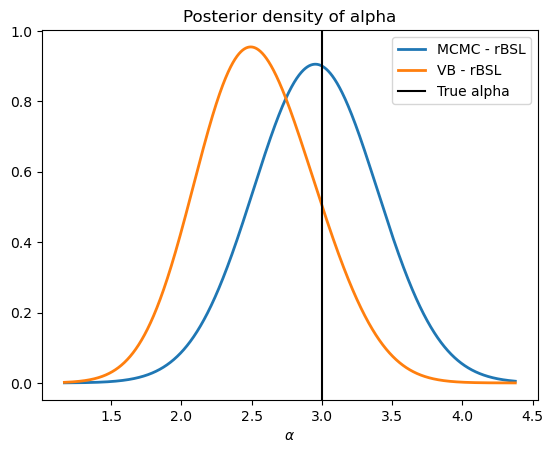

In [97]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-6*pos_alpha_std,np.mean(best_alpha)-6*np.std(best_alpha)), max(pos_alpha_mean+8*pos_alpha_std, np.mean(best_alpha)+8*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.435, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.345, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

plt.axvline(x = 3, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

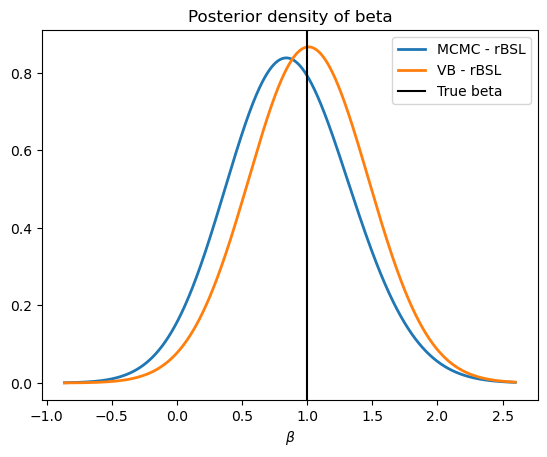

In [105]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-8*pos_beta_std,np.mean(best_beta)-8*np.std(best_beta)), max(pos_beta_mean+8*pos_beta_std, np.mean(best_beta)+8*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.425, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.46, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

plt.axvline(x = 1, ymin = 0, color = 'black', label = 'True beta')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


Text(0.5, 1.0, 'Posterior density of gamma')

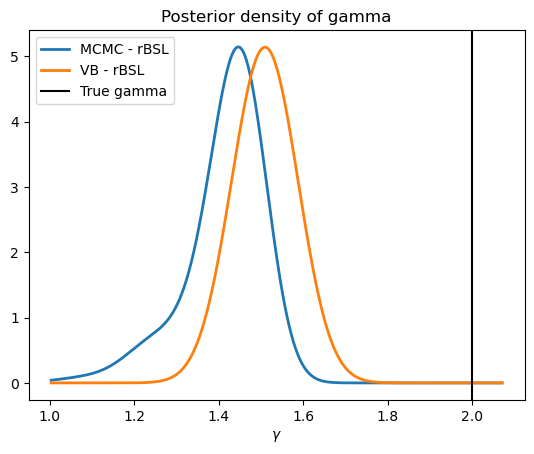

In [117]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-5*pos_gamma_std,np.mean(best_gamma)-5*np.std(best_gamma)), max(pos_gamma_mean+8*pos_gamma_std, np.mean(best_gamma)+8*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.055, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.07, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

plt.axvline(x = 2, ymin = 0, color = 'black', label = 'True gamma')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


Text(0.5, 1.0, 'Posterior density of delta')

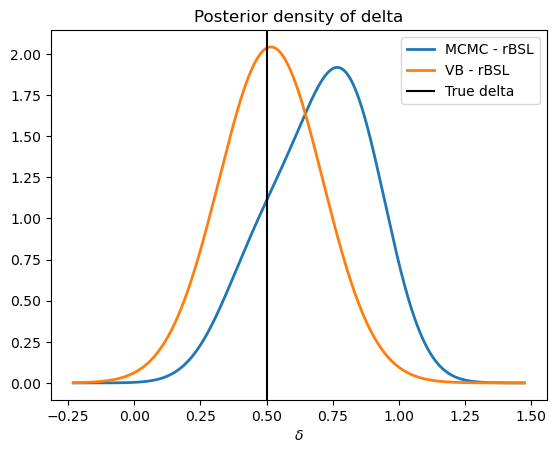

In [120]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-6*pos_delta_std,np.mean(best_delta)-6*np.std(best_delta)), max(pos_delta_mean+5*pos_delta_std, np.mean(best_delta)+5*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.135, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.195, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

plt.axvline(x = 0.5, ymin = 0, color = 'black', label = 'True delta')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')


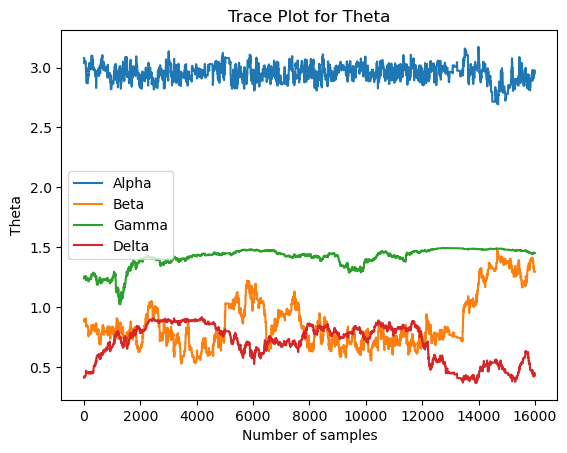

In [94]:
alpha_trace = pos_w[int(num_burnin):,0]
beta_trace = pos_w[int(num_burnin):,1]
gamma_trace = pos_w[int(num_burnin):,2]
delta_trace = pos_w[int(num_burnin):,3]

x = np.arange(len(alpha_trace))
plt.figure(facecolor = 'white')
plt.plot(x, alpha_trace, label='Alpha')  
plt.plot(x, beta_trace, label='Beta')  
plt.plot(x, gamma_trace, label='Gamma')  
plt.plot(x, delta_trace, label='Delta')  
plt.xlabel('Number of samples')
plt.ylabel('Theta')
plt.legend()
plt.title("Trace Plot for Theta")
plt.show()